In [1]:
import numpy as np
import pandas as pd
from indigo import *
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
from bokeh.io import output_notebook

In [2]:
output_notebook()

Loading BokehJS ...

### Some global variables used throughout this notebook

In [3]:
PATH = "Adrenergic_dataset.csv"
FOLDS = 5
SEED = 12
ASSAY =  "AdrA1A_PCHEMBL_VALUE"
#ASSAY =  "logP"

columns = ["Structure", "ID", ASSAY]

### Read data from csv

In [4]:
df = pd.read_csv(PATH)
df.head()

,Structure,ID,logP,Vx,MW,NegativeCharge,PositiveCharge,Flex,AromaticRings,OverallCharge,...,q485,frg-8,frg-26,frg-54,Nn,AdrA1A_PCHEMBL_VALUE,AdrA1B_PCHEMBL_VALUE,AdrA1D_PCHEMBL_VALUE,AdrA2A_PCHEMBL_VALUE,AdrA2C_PCHEMBL_VALUE
0,CC\C(=C(\CC)/c1ccc(O)cc1)\c2ccc(O)cc2,CHEMBL411,4.871,224.4,268.4,0,0,0.1905,2,0,...,4,2,0,0,0,NaN,NaN,NaN,NaN,5.66
1,CSc1ccc2Sc3ccccc3N(CCC4CCCCN4C)c2c1,CHEMBL479,5.900,290.2,370.6,0,2,0.1429,2,2,...,18,0,0,0,2,NaN,NaN,NaN,NaN,7.60
2,COc1cccc(CCN2C3C4C5CC6C7C5C3C7C2(O)C46)c1,CHEMBL2205811,3.040,225.5,309.4,0,1,0.1379,1,1,...,4,0,0,0,1,NaN,NaN,NaN,NaN,6.25
3,COc1cc(CN[C@H]2C3C4CC5C6C4CC3C6C25)cc(OC)c1OC,CHEMBL2432051,3.380,256.3,341.4,0,1,0.2000,1,1,...,8,0,0,0,1,NaN,NaN,NaN,NaN,5.64
4,COc1cccc(CCN2C3C4C5CC6C7C5C3C7C2(O)C46)c1OC,CHEMBL2205813,2.899,245.4,339.4,0,1,0.1613,1,1,...,6,0,0,0,1,NaN,NaN,NaN,NaN,5.36


### Drop NA values from assay value column

In [5]:
dataset = df[columns]
dataset.dropna(subset=[ASSAY], inplace=True)

In [6]:
indigo = Indigo()


def get_fingerprints(
    dataset: pd.DataFrame, 
    ignore_stereochemistry_errors: bool = True,
    ignore_bad_valence: bool = True,
    similarity_type: str = "ecfp6", # "ecfp4", "ecfp6", "ecfp8", "sim", "chem"
    fp_sim_qwords: int = 8,
    fp_ord_qwords: int = 25,
    fp_any_qwords: int = 15,
    fp_tau_qwords: int = 25,
    fp_ext_enabled: bool = True
):
    indigo.setOption("ignore-stereochemistry-errors", ignore_stereochemistry_errors)
    indigo.setOption("ignore-bad-valence", ignore_bad_valence)
    indigo.setOption("similarity-type", similarity_type)
    indigo.setOption("fp-sim-qwords", fp_sim_qwords)
    indigo.setOption("fp-ord-qwords", fp_ord_qwords)
    indigo.setOption("fp-any-qwords", fp_any_qwords)
    indigo.setOption("fp-tau-qwords", fp_tau_qwords)
    indigo.setOption("fp-ext-enabled", fp_ext_enabled)
    fingerprints = []
    max_val = -np.Inf

    for struct in dataset["Structure"]:
        mol = indigo.loadMolecule(struct)
        mol.aromatize()
        fingerprint = mol.fingerprint("full").toBuffer()
        buffered = np.frombuffer(fingerprint, dtype=np.uint8)
        buffered = np.unpackbits(buffered)
        fingerprints.append(buffered)
        max_val = max(max_val, *buffered)

    fingerprints = np.array(fingerprints, dtype=np.float32) / max_val
    return fingerprints


fingerprints = get_fingerprints(dataset)
dataset.head()

,Structure,ID,AdrA1A_PCHEMBL_VALUE
7,CNC(=O)C(CCN1CCC(O)(CC1)c2ccc(Cl)cc2)(c3ccccc3...,CHEMBL1627,8.00
12,Cc1ccc2c(cccc2n1)N3CCN(CCc4cccc5c4OCc6c(ncn56)...,CHEMBL1241913,8.56
13,COc1ccccc1OCCNCC2CSC(S2)(c3ccccc3)c4ccccc4,CHEMBL1086156,7.45
16,O[C@H]1[C@H](CC[C@@H]1Oc2ccccc2)NC[C@H]3COc4cc...,CHEMBL135974,6.41
19,COc1cccc(OC)c1OCCNC[C@H]2COc3ccccc3O2,CHEMBL1182155,9.39


### Draw distribution plot for assay values

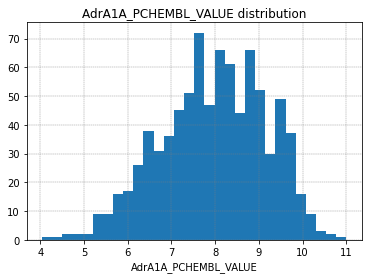

In [7]:
def build_histogram(input, title: str = ''):
    x = input
    n, bins, patches = plt.hist(x, 30)

    #plt.style.use('classic')
    plt.xlabel(title)
    plt.title(f'{title} distribution')
    plt.grid(True, color = "grey", linewidth = "0.4", linestyle = "dashed")
    plt.show()

build_histogram(input=dataset[ASSAY], title=ASSAY)

## Out-of-fold $r^2$ score estimations on train, validation and test datasets

### Random Forest Regression

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from utils.folds import oof


bundle = train_test_split(fingerprints, dataset, shuffle=True, random_state=SEED, test_size=0.25)

y_test = bundle[3]

model = RandomForestRegressor(n_estimators=100, max_features=0.2, max_depth=12, min_samples_leaf=2)
errors, y_pred = oof(model, bundle, assay=ASSAY)

MEAN TRAIN:  0.8880027550922505
MEAN VALIDATION:  0.48953245199675555
MEAN TEST 0.5395193088550421


### Fingerprints optimization

In [9]:
import optuna

In [ ]:
class FingerprintObjective(object):
    def __init__(self, dataset):
        self.dataset = dataset

    def __call__(self, trial):
        trials_dict = {
            #"ignore_stereochemistry_errors": trial.suggest_categorical("ignore_stereochemistry_errors", [0, 1]),
            #"ignore_bad_valence": trial.suggest_categorical("ignore_bad_valence", [0, 1]),
            "similarity_type": trial.suggest_categorical("similarity_type", ["ecfp4", "ecfp6", "ecfp8", "sim", "chem"]),
            "fp_sim_qwords": trial.suggest_int("fp_sim_qwords", 1, 32),
            "fp_ord_qwords": trial.suggest_int("fp_ord_qwords", 1, 32), #int = 25,
            "fp_any_qwords": trial.suggest_int("fp_any_qwords", 1, 32), #,int = 15,
            "fp_tau_qwords": trial.suggest_int("fp_tau_qwords", 1, 32), #int = 25,
            "fp_ext_enabled": trial.suggest_categorical("fp_ext_enabled", [0, 1]) #bool = True
        }
        
        # rf_trial_dict = {
        #     "max_depth": trial.suggest_int('rf_max_depth', 2, 200, log=True),
        #     "min_samples_leaf": trial.suggest_int('rf_min_samples_leaf', 2, 200),
        #     "n_estimators": trial.suggest_int('rf_estimators', 2, 200),
        #     "max_features": trial.suggest_float('rf_max_feats', 0.1, 0.9)
        # }
    

        fingerprints = get_fingerprints(self.dataset, **trials_dict)
        bundle = train_test_split(fingerprints, dataset, shuffle=True, random_state=SEED, test_size=0.25)

        y_test = bundle[3]

        model = RandomForestRegressor(n_estimators=100, max_features=0.2, max_depth=12, min_samples_leaf=2)
        errors, y_pred = oof(model, bundle, assay=ASSAY)
        return np.mean(errors)


pruner = optuna.pruners.SuccessiveHalvingPruner()
sampler = optuna.samplers.NSGAIISampler(population_size=200)
study = optuna.create_study(direction='maximize', pruner=pruner, sampler=sampler)
study.optimize(FingerprintObjective(dataset), n_trials=1024, n_jobs = 4)

In [10]:
#current_best = study.best_params
current_best = {'similarity_type': 'ecfp8', 'fp_sim_qwords': 29, 'fp_ord_qwords': 19, 'fp_any_qwords': 32, 'fp_tau_qwords': 5, 'fp_ext_enabled': 1}


In [11]:
class RFObjective(object):
    def __init__(self, dataset, fp_params: dict):
        self.dataset = dataset
        self.fingerprints = get_fingerprints(dataset, **fp_params)

    def __call__(self, trial):        
        rf_trial_dict = {
            "max_depth": trial.suggest_int('rf_max_depth', 2, 150),
            "min_samples_leaf": trial.suggest_int('rf_min_samples_leaf', 1, 80),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 150),
            "n_estimators": trial.suggest_int('rf_estimators', 2, 150),
            "max_features": trial.suggest_float('rf_max_feats', 0.1, 0.4, log=True)
        }
    
        bundle = train_test_split(self.fingerprints, self.dataset, shuffle=True, random_state=SEED, test_size=0.25)

        y_test = bundle[3]

        model = RandomForestRegressor(**rf_trial_dict)
        scores, y_pred = oof(model, bundle, assay=ASSAY)
        return np.mean(scores)


sampler = optuna.samplers.NSGAIISampler(population_size=200)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(RFObjective(dataset, current_best), n_trials=1024, n_jobs = 6)

[I 2022-01-26 12:48:43,212] A new study created in memory with name: no-name-ae387813-262e-4176-9f69-3fa155b94556
/Users/Aleksei_Kornev2/workspace/Indigo/api/python/venv/lib/python3.9/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2022-01-26 12:48:48,032] Trial 0 finished with value: 0.38376651018103497 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 74, 'min_samples_split': 88, 'rf_estimators': 35, 'rf_max_feats': 0.359049784656003}. Best is trial 0 with value: 0.38376651018103497.


MEAN TRAIN:  0.34907206001232494
MEAN VALIDATION:  0.27996730495064137
MEAN TEST 0.38376651018103497


[I 2022-01-26 12:48:50,297] Trial 3 finished with value: 0.4220393398867611 and parameters: {'rf_max_depth': 76, 'rf_min_samples_leaf': 54, 'min_samples_split': 72, 'rf_estimators': 58, 'rf_max_feats': 0.29188749267317665}. Best is trial 3 with value: 0.4220393398867611.


MEAN TRAIN:  0.40016072187977614
MEAN VALIDATION:  0.3184489795995705
MEAN TEST 0.4220393398867611


[I 2022-01-26 12:48:51,334] Trial 1 finished with value: 0.3871841205058198 and parameters: {'rf_max_depth': 25, 'rf_min_samples_leaf': 64, 'min_samples_split': 137, 'rf_estimators': 103, 'rf_max_feats': 0.20923291542880496}. Best is trial 3 with value: 0.4220393398867611.


MEAN TRAIN:  0.36148194673506684
MEAN VALIDATION:  0.2867426380841829
MEAN TEST 0.3871841205058198


[I 2022-01-26 12:48:52,020] Trial 5 finished with value: 0.38443331407804526 and parameters: {'rf_max_depth': 49, 'rf_min_samples_leaf': 74, 'min_samples_split': 91, 'rf_estimators': 109, 'rf_max_feats': 0.25091247237440056}. Best is trial 3 with value: 0.4220393398867611.


MEAN TRAIN:  0.3506064576289706
MEAN VALIDATION:  0.28135412642489754
MEAN TEST 0.38443331407804526


[I 2022-01-26 12:48:56,009] Trial 4 finished with value: 0.41581168948209546 and parameters: {'rf_max_depth': 65, 'rf_min_samples_leaf': 51, 'min_samples_split': 93, 'rf_estimators': 147, 'rf_max_feats': 0.21136188244879323}. Best is trial 3 with value: 0.4220393398867611.
[I 2022-01-26 12:48:56,062] Trial 6 finished with value: 0.4182834123787257 and parameters: {'rf_max_depth': 65, 'rf_min_samples_leaf': 46, 'min_samples_split': 29, 'rf_estimators': 129, 'rf_max_feats': 0.1421216226469506}. Best is trial 3 with value: 0.4220393398867611.
[I 2022-01-26 12:48:56,182] Trial 7 finished with value: 0.3767977458996783 and parameters: {'rf_max_depth': 25, 'rf_min_samples_leaf': 80, 'min_samples_split': 105, 'rf_estimators': 87, 'rf_max_feats': 0.2933881731926903}. Best is trial 3 with value: 0.4220393398867611.


MEAN TRAIN:  0.405001060181707
MEAN VALIDATION:  0.31950734996487934
MEAN TEST 0.41581168948209546
MEAN TRAIN:  0.41301986970445376
MEAN VALIDATION:  0.326156644311669
MEAN TEST 0.4182834123787257
MEAN TRAIN:  0.33977581058518674
MEAN VALIDATION:  0.2716429572580739
MEAN TEST 0.3767977458996783


[I 2022-01-26 12:48:57,096] Trial 8 finished with value: 0.4490460057780264 and parameters: {'rf_max_depth': 79, 'rf_min_samples_leaf': 33, 'min_samples_split': 67, 'rf_estimators': 59, 'rf_max_feats': 0.23657862780431765}. Best is trial 8 with value: 0.4490460057780264.
[I 2022-01-26 12:48:57,172] Trial 2 finished with value: 0.4346502534417109 and parameters: {'rf_max_depth': 3, 'rf_min_samples_leaf': 21, 'min_samples_split': 101, 'rf_estimators': 144, 'rf_max_feats': 0.240531876313841}. Best is trial 8 with value: 0.4490460057780264.


MEAN TRAIN:  0.47079784579633366
MEAN VALIDATION:  0.36095545059149237
MEAN TEST 0.4490460057780264
MEAN TRAIN:  0.43174052002649194
MEAN VALIDATION:  0.3346960808407731
MEAN TEST 0.4346502534417109


[I 2022-01-26 12:48:57,629] Trial 12 finished with value: 0.42069856860932353 and parameters: {'rf_max_depth': 15, 'rf_min_samples_leaf': 47, 'min_samples_split': 87, 'rf_estimators': 12, 'rf_max_feats': 0.3273425049577186}. Best is trial 8 with value: 0.4490460057780264.


MEAN TRAIN:  0.4217267953766625
MEAN VALIDATION:  0.3227424259708486
MEAN TEST 0.42069856860932353


[I 2022-01-26 12:48:58,560] Trial 15 finished with value: 0.37800781709264536 and parameters: {'rf_max_depth': 44, 'rf_min_samples_leaf': 48, 'min_samples_split': 129, 'rf_estimators': 19, 'rf_max_feats': 0.10917080295282397}. Best is trial 8 with value: 0.4490460057780264.


MEAN TRAIN:  0.3635536251150159
MEAN VALIDATION:  0.2800766880039789
MEAN TEST 0.37800781709264536


[I 2022-01-26 12:48:59,927] Trial 14 finished with value: 0.38247123719247134 and parameters: {'rf_max_depth': 128, 'rf_min_samples_leaf': 67, 'min_samples_split': 110, 'rf_estimators': 44, 'rf_max_feats': 0.19757582075704383}. Best is trial 8 with value: 0.4490460057780264.


MEAN TRAIN:  0.35772695253123826
MEAN VALIDATION:  0.28659064176543253
MEAN TEST 0.38247123719247134


[I 2022-01-26 12:49:03,132] Trial 10 finished with value: 0.3942308469814275 and parameters: {'rf_max_depth': 81, 'rf_min_samples_leaf': 65, 'min_samples_split': 57, 'rf_estimators': 94, 'rf_max_feats': 0.27685373700195814}. Best is trial 8 with value: 0.4490460057780264.


MEAN TRAIN:  0.365580415251795
MEAN VALIDATION:  0.2923402355218652
MEAN TEST 0.3942308469814275


[I 2022-01-26 12:49:04,956] Trial 11 finished with value: 0.3868002721648776 and parameters: {'rf_max_depth': 135, 'rf_min_samples_leaf': 76, 'min_samples_split': 55, 'rf_estimators': 117, 'rf_max_feats': 0.3347294987066542}. Best is trial 8 with value: 0.4490460057780264.


MEAN TRAIN:  0.3504839296837222
MEAN VALIDATION:  0.2799955490251423
MEAN TEST 0.3868002721648776


[I 2022-01-26 12:49:05,454] Trial 9 finished with value: 0.3996894982412055 and parameters: {'rf_max_depth': 88, 'rf_min_samples_leaf': 66, 'min_samples_split': 103, 'rf_estimators': 144, 'rf_max_feats': 0.3966484779386933}. Best is trial 8 with value: 0.4490460057780264.


MEAN TRAIN:  0.3701005835264752
MEAN VALIDATION:  0.29605182879221903
MEAN TEST 0.3996894982412055


[I 2022-01-26 12:49:07,044] Trial 18 finished with value: 0.39746958132033317 and parameters: {'rf_max_depth': 2, 'rf_min_samples_leaf': 46, 'min_samples_split': 40, 'rf_estimators': 58, 'rf_max_feats': 0.194778682859134}. Best is trial 8 with value: 0.4490460057780264.


MEAN TRAIN:  0.3782530028707486
MEAN VALIDATION:  0.29693888030865867
MEAN TEST 0.39746958132033317


[I 2022-01-26 12:49:07,883] Trial 21 finished with value: 0.3903634911014085 and parameters: {'rf_max_depth': 123, 'rf_min_samples_leaf': 56, 'min_samples_split': 57, 'rf_estimators': 14, 'rf_max_feats': 0.10877850163112186}. Best is trial 8 with value: 0.4490460057780264.


MEAN TRAIN:  0.37393807684714453
MEAN VALIDATION:  0.28582120326704735
MEAN TEST 0.3903634911014085


[I 2022-01-26 12:49:08,796] Trial 13 finished with value: 0.4382042294092363 and parameters: {'rf_max_depth': 27, 'rf_min_samples_leaf': 42, 'min_samples_split': 54, 'rf_estimators': 104, 'rf_max_feats': 0.3037609047432277}. Best is trial 8 with value: 0.4490460057780264.


MEAN TRAIN:  0.44496591227267623
MEAN VALIDATION:  0.344363794159772
MEAN TEST 0.4382042294092363


[I 2022-01-26 12:49:09,366] Trial 17 finished with value: 0.40166136672356395 and parameters: {'rf_max_depth': 45, 'rf_min_samples_leaf': 7, 'min_samples_split': 150, 'rf_estimators': 113, 'rf_max_feats': 0.2862235002305295}. Best is trial 8 with value: 0.4490460057780264.


MEAN TRAIN:  0.37745923518639846
MEAN VALIDATION:  0.2990912145975329
MEAN TEST 0.40166136672356395


[I 2022-01-26 12:49:12,697] Trial 22 finished with value: 0.41673699560906297 and parameters: {'rf_max_depth': 127, 'rf_min_samples_leaf': 5, 'min_samples_split': 125, 'rf_estimators': 52, 'rf_max_feats': 0.18929983981702914}. Best is trial 8 with value: 0.4490460057780264.


MEAN TRAIN:  0.41232674537772196
MEAN VALIDATION:  0.31842739939298
MEAN TEST 0.41673699560906297


[I 2022-01-26 12:49:16,119] Trial 20 finished with value: 0.4373254651010957 and parameters: {'rf_max_depth': 90, 'rf_min_samples_leaf': 22, 'min_samples_split': 100, 'rf_estimators': 89, 'rf_max_feats': 0.2624444850624932}. Best is trial 8 with value: 0.4490460057780264.


MEAN TRAIN:  0.4435405140776087
MEAN VALIDATION:  0.3416315733076289
MEAN TEST 0.4373254651010957


[I 2022-01-26 12:49:16,702] Trial 23 finished with value: 0.4105896750313316 and parameters: {'rf_max_depth': 111, 'rf_min_samples_leaf': 56, 'min_samples_split': 36, 'rf_estimators': 76, 'rf_max_feats': 0.25420884573348834}. Best is trial 8 with value: 0.4490460057780264.


MEAN TRAIN:  0.3938976935975359
MEAN VALIDATION:  0.3062154144355027
MEAN TEST 0.4105896750313316


[I 2022-01-26 12:49:17,282] Trial 16 finished with value: 0.4962791317268402 and parameters: {'rf_max_depth': 12, 'rf_min_samples_leaf': 7, 'min_samples_split': 47, 'rf_estimators': 124, 'rf_max_feats': 0.23180815775416327}. Best is trial 16 with value: 0.4962791317268402.


MEAN TRAIN:  0.5939965882236975
MEAN VALIDATION:  0.4112391365315434
MEAN TEST 0.4962791317268402


[I 2022-01-26 12:49:18,716] Trial 28 finished with value: 0.3901935122012476 and parameters: {'rf_max_depth': 82, 'rf_min_samples_leaf': 31, 'min_samples_split': 124, 'rf_estimators': 32, 'rf_max_feats': 0.10516677422711479}. Best is trial 16 with value: 0.4962791317268402.


MEAN TRAIN:  0.3796875182483125
MEAN VALIDATION:  0.2948779955581482
MEAN TEST 0.3901935122012476


[I 2022-01-26 12:49:20,992] Trial 26 finished with value: 0.44857599062925413 and parameters: {'rf_max_depth': 124, 'rf_min_samples_leaf': 30, 'min_samples_split': 76, 'rf_estimators': 49, 'rf_max_feats': 0.23068739276242153}. Best is trial 16 with value: 0.4962791317268402.


MEAN TRAIN:  0.4650291638735989
MEAN VALIDATION:  0.35183470106503817
MEAN TEST 0.44857599062925413


[I 2022-01-26 12:49:24,318] Trial 25 finished with value: 0.42087335271545534 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 55, 'min_samples_split': 32, 'rf_estimators': 96, 'rf_max_feats': 0.3919793296448739}. Best is trial 16 with value: 0.4962791317268402.


MEAN TRAIN:  0.4051026785802037
MEAN VALIDATION:  0.32252479652316307
MEAN TEST 0.42087335271545534


[I 2022-01-26 12:49:25,531] Trial 24 finished with value: 0.4722783012156279 and parameters: {'rf_max_depth': 98, 'rf_min_samples_leaf': 24, 'min_samples_split': 30, 'rf_estimators': 116, 'rf_max_feats': 0.26130711509354204}. Best is trial 16 with value: 0.4962791317268402.


MEAN TRAIN:  0.5241088692361752
MEAN VALIDATION:  0.3815205140740448
MEAN TEST 0.4722783012156279


[I 2022-01-26 12:49:26,188] Trial 32 finished with value: 0.408326326126056 and parameters: {'rf_max_depth': 30, 'rf_min_samples_leaf': 45, 'min_samples_split': 102, 'rf_estimators': 9, 'rf_max_feats': 0.13440905141668824}. Best is trial 16 with value: 0.4962791317268402.


MEAN TRAIN:  0.3944242007815328
MEAN VALIDATION:  0.30703658010973445
MEAN TEST 0.408326326126056


[I 2022-01-26 12:49:26,829] Trial 29 finished with value: 0.40056137288917204 and parameters: {'rf_max_depth': 23, 'rf_min_samples_leaf': 61, 'min_samples_split': 10, 'rf_estimators': 95, 'rf_max_feats': 0.29327815818259056}. Best is trial 16 with value: 0.4962791317268402.


MEAN TRAIN:  0.3752924039284794
MEAN VALIDATION:  0.295319042987244
MEAN TEST 0.40056137288917204


[I 2022-01-26 12:49:27,172] Trial 30 finished with value: 0.3711589247355371 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 76, 'min_samples_split': 86, 'rf_estimators': 116, 'rf_max_feats': 0.19210586006247674}. Best is trial 16 with value: 0.4962791317268402.


MEAN TRAIN:  0.3406257890643564
MEAN VALIDATION:  0.26977722776164614
MEAN TEST 0.3711589247355371


[I 2022-01-26 12:49:27,696] Trial 33 finished with value: 0.40386695728158106 and parameters: {'rf_max_depth': 95, 'rf_min_samples_leaf': 58, 'min_samples_split': 86, 'rf_estimators': 17, 'rf_max_feats': 0.2693556080076496}. Best is trial 16 with value: 0.4962791317268402.
[I 2022-01-26 12:49:27,810] Trial 19 finished with value: 0.4752823842800943 and parameters: {'rf_max_depth': 79, 'rf_min_samples_leaf': 20, 'min_samples_split': 58, 'rf_estimators': 148, 'rf_max_feats': 0.3136701879008911}. Best is trial 16 with value: 0.4962791317268402.


MEAN TRAIN:  0.3830464195707362
MEAN VALIDATION:  0.29804137073434384
MEAN TEST 0.40386695728158106
MEAN TRAIN:  0.5235578182100362
MEAN VALIDATION:  0.38064996481688934
MEAN TEST 0.4752823842800943


[I 2022-01-26 12:49:28,495] Trial 31 finished with value: 0.3938497148692451 and parameters: {'rf_max_depth': 71, 'rf_min_samples_leaf': 56, 'min_samples_split': 130, 'rf_estimators': 67, 'rf_max_feats': 0.17895101940533845}. Best is trial 16 with value: 0.4962791317268402.


MEAN TRAIN:  0.3700601357002748
MEAN VALIDATION:  0.29408897083325225
MEAN TEST 0.3938497148692451


[I 2022-01-26 12:49:31,702] Trial 35 finished with value: 0.4070120165378164 and parameters: {'rf_max_depth': 79, 'rf_min_samples_leaf': 48, 'min_samples_split': 106, 'rf_estimators': 83, 'rf_max_feats': 0.10713541449559455}. Best is trial 16 with value: 0.4962791317268402.


MEAN TRAIN:  0.3930538958697408
MEAN VALIDATION:  0.30608543504143554
MEAN TEST 0.4070120165378164


[I 2022-01-26 12:49:33,532] Trial 34 finished with value: 0.3992404321406854 and parameters: {'rf_max_depth': 132, 'rf_min_samples_leaf': 29, 'min_samples_split': 128, 'rf_estimators': 123, 'rf_max_feats': 0.13063615884859192}. Best is trial 16 with value: 0.4962791317268402.


MEAN TRAIN:  0.3807452066297081
MEAN VALIDATION:  0.30160476141236153
MEAN TEST 0.3992404321406854


[I 2022-01-26 12:49:37,213] Trial 37 finished with value: 0.3853628266678447 and parameters: {'rf_max_depth': 127, 'rf_min_samples_leaf': 68, 'min_samples_split': 135, 'rf_estimators': 150, 'rf_max_feats': 0.20914095032517677}. Best is trial 16 with value: 0.4962791317268402.
[I 2022-01-26 12:49:37,233] Trial 38 finished with value: 0.3816458992331515 and parameters: {'rf_max_depth': 8, 'rf_min_samples_leaf': 70, 'min_samples_split': 45, 'rf_estimators': 143, 'rf_max_feats': 0.21267088380363247}. Best is trial 16 with value: 0.4962791317268402.


MEAN TRAIN:  0.3547093247617979
MEAN VALIDATION:  0.28146639089169057
MEAN TEST 0.3853628266678447
MEAN TRAIN:  0.35427500943318935
MEAN VALIDATION:  0.2817736847821483
MEAN TEST 0.3816458992331515


[I 2022-01-26 12:49:37,499] Trial 27 finished with value: 0.4831344274500301 and parameters: {'rf_max_depth': 55, 'rf_min_samples_leaf': 9, 'min_samples_split': 65, 'rf_estimators': 138, 'rf_max_feats': 0.33320852781882665}. Best is trial 16 with value: 0.4962791317268402.


MEAN TRAIN:  0.541078783784545
MEAN VALIDATION:  0.39101321551806867
MEAN TEST 0.4831344274500301


[I 2022-01-26 12:49:38,316] Trial 43 finished with value: 0.3913892819386663 and parameters: {'rf_max_depth': 103, 'rf_min_samples_leaf': 21, 'min_samples_split': 129, 'rf_estimators': 7, 'rf_max_feats': 0.3212814979510111}. Best is trial 16 with value: 0.4962791317268402.


MEAN TRAIN:  0.3777180177232812
MEAN VALIDATION:  0.29582551116294914
MEAN TEST 0.3913892819386663


[I 2022-01-26 12:49:38,654] Trial 36 finished with value: 0.4194232100507055 and parameters: {'rf_max_depth': 31, 'rf_min_samples_leaf': 52, 'min_samples_split': 90, 'rf_estimators': 118, 'rf_max_feats': 0.2735369717199962}. Best is trial 16 with value: 0.4962791317268402.


MEAN TRAIN:  0.4074567447616406
MEAN VALIDATION:  0.32242956202531337
MEAN TEST 0.4194232100507055


[I 2022-01-26 12:49:38,987] Trial 42 finished with value: 0.4203420712951673 and parameters: {'rf_max_depth': 89, 'rf_min_samples_leaf': 51, 'min_samples_split': 73, 'rf_estimators': 18, 'rf_max_feats': 0.24927922625422333}. Best is trial 16 with value: 0.4962791317268402.


MEAN TRAIN:  0.4048314533358274
MEAN VALIDATION:  0.3108561717026251
MEAN TEST 0.4203420712951673


[I 2022-01-26 12:49:39,295] Trial 40 finished with value: 0.3992906156519715 and parameters: {'rf_max_depth': 145, 'rf_min_samples_leaf': 49, 'min_samples_split': 123, 'rf_estimators': 102, 'rf_max_feats': 0.14747463459583157}. Best is trial 16 with value: 0.4962791317268402.
[I 2022-01-26 12:49:39,370] Trial 45 finished with value: 0.4330387006950289 and parameters: {'rf_max_depth': 25, 'rf_min_samples_leaf': 22, 'min_samples_split': 79, 'rf_estimators': 8, 'rf_max_feats': 0.11458628716787883}. Best is trial 16 with value: 0.4962791317268402.


MEAN TRAIN:  0.38051289764419954
MEAN VALIDATION:  0.2957215571279062
MEAN TEST 0.3992906156519715
MEAN TRAIN:  0.45095765919606523
MEAN VALIDATION:  0.336387241044492
MEAN TEST 0.4330387006950289


[I 2022-01-26 12:49:41,593] Trial 47 finished with value: 0.4468417566848494 and parameters: {'rf_max_depth': 127, 'rf_min_samples_leaf': 33, 'min_samples_split': 3, 'rf_estimators': 20, 'rf_max_feats': 0.2692400801023779}. Best is trial 16 with value: 0.4962791317268402.


MEAN TRAIN:  0.46689994909776766
MEAN VALIDATION:  0.3481811341437785
MEAN TEST 0.4468417566848494


[I 2022-01-26 12:49:42,217] Trial 44 finished with value: 0.40593327019883174 and parameters: {'rf_max_depth': 3, 'rf_min_samples_leaf': 55, 'min_samples_split': 19, 'rf_estimators': 50, 'rf_max_feats': 0.2239397339722947}. Best is trial 16 with value: 0.4962791317268402.


MEAN TRAIN:  0.3913152973702695
MEAN VALIDATION:  0.308872673380434
MEAN TEST 0.40593327019883174


[I 2022-01-26 12:49:44,160] Trial 50 finished with value: 0.3901168884586941 and parameters: {'rf_max_depth': 127, 'rf_min_samples_leaf': 20, 'min_samples_split': 134, 'rf_estimators': 42, 'rf_max_feats': 0.10428225593526336}. Best is trial 16 with value: 0.4962791317268402.


MEAN TRAIN:  0.37825963249716676
MEAN VALIDATION:  0.2989584861190747
MEAN TEST 0.3901168884586941


[I 2022-01-26 12:49:44,568] Trial 48 finished with value: 0.4546192580936056 and parameters: {'rf_max_depth': 136, 'rf_min_samples_leaf': 23, 'min_samples_split': 73, 'rf_estimators': 51, 'rf_max_feats': 0.23677834479262172}. Best is trial 16 with value: 0.4962791317268402.


MEAN TRAIN:  0.48028546940700856
MEAN VALIDATION:  0.3634435209369115
MEAN TEST 0.4546192580936056


[I 2022-01-26 12:49:45,317] Trial 51 finished with value: 0.35611740490132804 and parameters: {'rf_max_depth': 150, 'rf_min_samples_leaf': 80, 'min_samples_split': 71, 'rf_estimators': 26, 'rf_max_feats': 0.12349783790610754}. Best is trial 16 with value: 0.4962791317268402.


MEAN TRAIN:  0.32369347117050423
MEAN VALIDATION:  0.2601540165136352
MEAN TEST 0.35611740490132804


[I 2022-01-26 12:49:45,762] Trial 53 finished with value: 0.3846774682722913 and parameters: {'rf_max_depth': 68, 'rf_min_samples_leaf': 15, 'min_samples_split': 114, 'rf_estimators': 6, 'rf_max_feats': 0.12508669917109336}. Best is trial 16 with value: 0.4962791317268402.


MEAN TRAIN:  0.3918237650746152
MEAN VALIDATION:  0.28503196108369633
MEAN TEST 0.3846774682722913


[I 2022-01-26 12:49:46,176] Trial 39 finished with value: 0.4963482765076891 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 1, 'min_samples_split': 63, 'rf_estimators': 86, 'rf_max_feats': 0.30544307143426497}. Best is trial 39 with value: 0.4963482765076891.
[I 2022-01-26 12:49:46,289] Trial 41 finished with value: 0.4287908484465519 and parameters: {'rf_max_depth': 120, 'rf_min_samples_leaf': 23, 'min_samples_split': 108, 'rf_estimators': 109, 'rf_max_feats': 0.21740822460401762}. Best is trial 39 with value: 0.4963482765076891.


MEAN TRAIN:  0.6118218957049019
MEAN VALIDATION:  0.42041935364584815
MEAN TEST 0.4963482765076891
MEAN TRAIN:  0.427418215146319
MEAN VALIDATION:  0.3333825439848671
MEAN TEST 0.4287908484465519


[I 2022-01-26 12:49:48,320] Trial 54 finished with value: 0.3650898934062975 and parameters: {'rf_max_depth': 144, 'rf_min_samples_leaf': 79, 'min_samples_split': 125, 'rf_estimators': 45, 'rf_max_feats': 0.1820536119273586}. Best is trial 39 with value: 0.4963482765076891.


MEAN TRAIN:  0.3341827378806539
MEAN VALIDATION:  0.26711287708760356
MEAN TEST 0.3650898934062975


[I 2022-01-26 12:49:49,143] Trial 52 finished with value: 0.40680720425680406 and parameters: {'rf_max_depth': 88, 'rf_min_samples_leaf': 39, 'min_samples_split': 122, 'rf_estimators': 66, 'rf_max_feats': 0.19506485939930177}. Best is trial 39 with value: 0.4963482765076891.


MEAN TRAIN:  0.38603481451269794
MEAN VALIDATION:  0.30782180715638746
MEAN TEST 0.40680720425680406


[I 2022-01-26 12:49:49,900] Trial 49 finished with value: 0.4170032422379196 and parameters: {'rf_max_depth': 61, 'rf_min_samples_leaf': 49, 'min_samples_split': 109, 'rf_estimators': 100, 'rf_max_feats': 0.24555571452175884}. Best is trial 39 with value: 0.4963482765076891.


MEAN TRAIN:  0.4044615501473503
MEAN VALIDATION:  0.31928249536264397
MEAN TEST 0.4170032422379196


[I 2022-01-26 12:49:50,575] Trial 46 finished with value: 0.46379687608361586 and parameters: {'rf_max_depth': 28, 'rf_min_samples_leaf': 16, 'min_samples_split': 69, 'rf_estimators': 143, 'rf_max_feats': 0.1515093753548118}. Best is trial 39 with value: 0.4963482765076891.


MEAN TRAIN:  0.49532625669896485
MEAN VALIDATION:  0.3675119699885047
MEAN TEST 0.46379687608361586


[I 2022-01-26 12:49:53,347] Trial 56 finished with value: 0.4002336680731341 and parameters: {'rf_max_depth': 21, 'rf_min_samples_leaf': 62, 'min_samples_split': 133, 'rf_estimators': 70, 'rf_max_feats': 0.3961217389267222}. Best is trial 39 with value: 0.4963482765076891.


MEAN TRAIN:  0.3733222013849433
MEAN VALIDATION:  0.3004612118194211
MEAN TEST 0.4002336680731341


[I 2022-01-26 12:49:55,370] Trial 57 finished with value: 0.4014843821810932 and parameters: {'rf_max_depth': 109, 'rf_min_samples_leaf': 62, 'min_samples_split': 6, 'rf_estimators': 89, 'rf_max_feats': 0.27463307551454835}. Best is trial 39 with value: 0.4963482765076891.
[I 2022-01-26 12:49:55,486] Trial 59 finished with value: 0.3902340293132965 and parameters: {'rf_max_depth': 141, 'rf_min_samples_leaf': 70, 'min_samples_split': 64, 'rf_estimators': 67, 'rf_max_feats': 0.3322679307065798}. Best is trial 39 with value: 0.4963482765076891.


MEAN TRAIN:  0.37584450049746587
MEAN VALIDATION:  0.29833420367227836
MEAN TEST 0.4014843821810932
MEAN TRAIN:  0.3581330560585888
MEAN VALIDATION:  0.2810856030777383
MEAN TEST 0.3902340293132965


[I 2022-01-26 12:49:56,915] Trial 63 finished with value: 0.42859703271738586 and parameters: {'rf_max_depth': 25, 'rf_min_samples_leaf': 43, 'min_samples_split': 73, 'rf_estimators': 12, 'rf_max_feats': 0.2653094332342102}. Best is trial 39 with value: 0.4963482765076891.


MEAN TRAIN:  0.43324828868361714
MEAN VALIDATION:  0.3304672186337011
MEAN TEST 0.42859703271738586


[I 2022-01-26 12:49:58,697] Trial 58 finished with value: 0.4428106489780017 and parameters: {'rf_max_depth': 124, 'rf_min_samples_leaf': 26, 'min_samples_split': 88, 'rf_estimators': 113, 'rf_max_feats': 0.20439722094718152}. Best is trial 39 with value: 0.4963482765076891.


MEAN TRAIN:  0.45165278490562466
MEAN VALIDATION:  0.34792116454730804
MEAN TEST 0.4428106489780017


[I 2022-01-26 12:50:00,108] Trial 64 finished with value: 0.41975714231603883 and parameters: {'rf_max_depth': 19, 'rf_min_samples_leaf': 47, 'min_samples_split': 32, 'rf_estimators': 49, 'rf_max_feats': 0.15029276927002022}. Best is trial 39 with value: 0.4963482765076891.
[I 2022-01-26 12:50:00,147] Trial 60 finished with value: 0.5281141274824366 and parameters: {'rf_max_depth': 82, 'rf_min_samples_leaf': 6, 'min_samples_split': 9, 'rf_estimators': 52, 'rf_max_feats': 0.22703744150321095}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.41180246125016967
MEAN VALIDATION:  0.32313002031733984
MEAN TEST 0.41975714231603883
MEAN TRAIN:  0.754529681821161
MEAN VALIDATION:  0.46064387191586
MEAN TEST 0.5281141274824366


[I 2022-01-26 12:50:01,172] Trial 62 finished with value: 0.3860007222422481 and parameters: {'rf_max_depth': 123, 'rf_min_samples_leaf': 37, 'min_samples_split': 143, 'rf_estimators': 126, 'rf_max_feats': 0.11766688061768207}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.3642188452701024
MEAN VALIDATION:  0.28687937873533687
MEAN TEST 0.3860007222422481


[I 2022-01-26 12:50:02,381] Trial 55 finished with value: 0.4483464161981159 and parameters: {'rf_max_depth': 48, 'rf_min_samples_leaf': 35, 'min_samples_split': 82, 'rf_estimators': 147, 'rf_max_feats': 0.29089997671668544}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.4597054857534129
MEAN VALIDATION:  0.3522547458906216
MEAN TEST 0.4483464161981159


[I 2022-01-26 12:50:05,296] Trial 65 finished with value: 0.40384174705322984 and parameters: {'rf_max_depth': 41, 'rf_min_samples_leaf': 51, 'min_samples_split': 48, 'rf_estimators': 139, 'rf_max_feats': 0.10229773961391604}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.39056768577968476
MEAN VALIDATION:  0.306348889759374
MEAN TEST 0.40384174705322984


[I 2022-01-26 12:50:05,537] Trial 66 finished with value: 0.39365922609538445 and parameters: {'rf_max_depth': 103, 'rf_min_samples_leaf': 50, 'min_samples_split': 149, 'rf_estimators': 62, 'rf_max_feats': 0.3529707304201736}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.36514293863030084
MEAN VALIDATION:  0.2916789233501834
MEAN TEST 0.39365922609538445


[I 2022-01-26 12:50:08,330] Trial 61 finished with value: 0.4863071326417092 and parameters: {'rf_max_depth': 88, 'rf_min_samples_leaf': 19, 'min_samples_split': 39, 'rf_estimators': 130, 'rf_max_feats': 0.21081860894120014}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.5584862096361508
MEAN VALIDATION:  0.3920015355665644
MEAN TEST 0.4863071326417092


[I 2022-01-26 12:50:08,973] Trial 72 finished with value: 0.42058098028749813 and parameters: {'rf_max_depth': 32, 'rf_min_samples_leaf': 15, 'min_samples_split': 71, 'rf_estimators': 5, 'rf_max_feats': 0.20950434332899404}. Best is trial 60 with value: 0.5281141274824366.
[I 2022-01-26 12:50:09,142] Trial 70 finished with value: 0.4453090072714317 and parameters: {'rf_max_depth': 91, 'rf_min_samples_leaf': 26, 'min_samples_split': 82, 'rf_estimators': 39, 'rf_max_feats': 0.24128513179325833}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.4665532441799102
MEAN VALIDATION:  0.3456808181046912
MEAN TEST 0.42058098028749813
MEAN TRAIN:  0.46247232726075377
MEAN VALIDATION:  0.34384086457620755
MEAN TEST 0.4453090072714317


[I 2022-01-26 12:50:10,794] Trial 71 finished with value: 0.3867440333344906 and parameters: {'rf_max_depth': 5, 'rf_min_samples_leaf': 65, 'min_samples_split': 72, 'rf_estimators': 87, 'rf_max_feats': 0.19560160860771114}. Best is trial 60 with value: 0.5281141274824366.
[I 2022-01-26 12:50:10,951] Trial 67 finished with value: 0.39787656523185744 and parameters: {'rf_max_depth': 44, 'rf_min_samples_leaf': 64, 'min_samples_split': 20, 'rf_estimators': 139, 'rf_max_feats': 0.28116545892286937}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.3623860464492763
MEAN VALIDATION:  0.28624383803819425
MEAN TEST 0.3867440333344906
MEAN TRAIN:  0.37089405208687937
MEAN VALIDATION:  0.29556152151829407
MEAN TEST 0.39787656523185744


[I 2022-01-26 12:50:13,415] Trial 69 finished with value: 0.4108708015691601 and parameters: {'rf_max_depth': 79, 'rf_min_samples_leaf': 33, 'min_samples_split': 126, 'rf_estimators': 109, 'rf_max_feats': 0.37628160037292935}. Best is trial 60 with value: 0.5281141274824366.
[I 2022-01-26 12:50:13,576] Trial 73 finished with value: 0.36466248017550174 and parameters: {'rf_max_depth': 133, 'rf_min_samples_leaf': 78, 'min_samples_split': 69, 'rf_estimators': 85, 'rf_max_feats': 0.1797997931603552}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.39331866718028047
MEAN VALIDATION:  0.3099607708043445
MEAN TEST 0.4108708015691601
MEAN TRAIN:  0.3313452261347303
MEAN VALIDATION:  0.2589693532029814
MEAN TEST 0.36466248017550174


[I 2022-01-26 12:50:14,672] Trial 68 finished with value: 0.5270898765406976 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 7, 'min_samples_split': 16, 'rf_estimators': 79, 'rf_max_feats': 0.24823792777759626}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.7229725090591247
MEAN VALIDATION:  0.4517153296948858
MEAN TEST 0.5270898765406976


[I 2022-01-26 12:50:14,965] Trial 74 finished with value: 0.3810240695725825 and parameters: {'rf_max_depth': 20, 'rf_min_samples_leaf': 75, 'min_samples_split': 11, 'rf_estimators': 89, 'rf_max_feats': 0.2456061657250199}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.34673352428654597
MEAN VALIDATION:  0.2780557179936146
MEAN TEST 0.3810240695725825


[I 2022-01-26 12:50:17,557] Trial 76 finished with value: 0.44441628432197666 and parameters: {'rf_max_depth': 124, 'rf_min_samples_leaf': 19, 'min_samples_split': 79, 'rf_estimators': 107, 'rf_max_feats': 0.10665860038712986}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.4622510772148651
MEAN VALIDATION:  0.35147239245820583
MEAN TEST 0.44441628432197666


[I 2022-01-26 12:50:17,965] Trial 78 finished with value: 0.40257850027756054 and parameters: {'rf_max_depth': 86, 'rf_min_samples_leaf': 54, 'min_samples_split': 88, 'rf_estimators': 81, 'rf_max_feats': 0.12768581845090096}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.3867614532980243
MEAN VALIDATION:  0.3084952599065657
MEAN TEST 0.40257850027756054


[I 2022-01-26 12:50:20,064] Trial 75 finished with value: 0.3965372309328452 and parameters: {'rf_max_depth': 6, 'rf_min_samples_leaf': 66, 'min_samples_split': 23, 'rf_estimators': 99, 'rf_max_feats': 0.3749185281634642}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.369360947814231
MEAN VALIDATION:  0.2918692260988808
MEAN TEST 0.3965372309328452


[I 2022-01-26 12:50:21,150] Trial 81 finished with value: 0.46703844545327494 and parameters: {'rf_max_depth': 133, 'rf_min_samples_leaf': 7, 'min_samples_split': 60, 'rf_estimators': 48, 'rf_max_feats': 0.10584924573435953}. Best is trial 60 with value: 0.5281141274824366.
[I 2022-01-26 12:50:21,336] Trial 79 finished with value: 0.3856423140788393 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 70, 'min_samples_split': 45, 'rf_estimators': 94, 'rf_max_feats': 0.26519999622720763}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.5293376560181
MEAN VALIDATION:  0.3796797212248076
MEAN TEST 0.46703844545327494
MEAN TRAIN:  0.35578329935184755
MEAN VALIDATION:  0.2810276128053516
MEAN TEST 0.3856423140788393


[I 2022-01-26 12:50:23,112] Trial 80 finished with value: 0.4548298020586078 and parameters: {'rf_max_depth': 102, 'rf_min_samples_leaf': 4, 'min_samples_split': 88, 'rf_estimators': 94, 'rf_max_feats': 0.1787290734540983}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.4962457719421631
MEAN VALIDATION:  0.3658618849057242
MEAN TEST 0.4548298020586078


[I 2022-01-26 12:50:24,481] Trial 83 finished with value: 0.4155097660546704 and parameters: {'rf_max_depth': 148, 'rf_min_samples_leaf': 45, 'min_samples_split': 28, 'rf_estimators': 82, 'rf_max_feats': 0.10863973642353174}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.4127230194580253
MEAN VALIDATION:  0.3268956611459869
MEAN TEST 0.4155097660546704


[I 2022-01-26 12:50:24,959] Trial 85 finished with value: 0.4243813891917229 and parameters: {'rf_max_depth': 28, 'rf_min_samples_leaf': 47, 'min_samples_split': 40, 'rf_estimators': 36, 'rf_max_feats': 0.28229458209363234}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.4259087511413231
MEAN VALIDATION:  0.32439338547191904
MEAN TEST 0.4243813891917229


[I 2022-01-26 12:50:25,684] Trial 77 finished with value: 0.42965476565168403 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 47, 'min_samples_split': 37, 'rf_estimators': 128, 'rf_max_feats': 0.2790276694076502}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.4260252405482391
MEAN VALIDATION:  0.33211537942191754
MEAN TEST 0.42965476565168403


[I 2022-01-26 12:50:29,413] Trial 82 finished with value: 0.403793823319546 and parameters: {'rf_max_depth': 31, 'rf_min_samples_leaf': 65, 'min_samples_split': 117, 'rf_estimators': 119, 'rf_max_feats': 0.38080004161311753}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.37427190044241027
MEAN VALIDATION:  0.2983614091260823
MEAN TEST 0.403793823319546


[I 2022-01-26 12:50:29,866] Trial 88 finished with value: 0.49560644492854633 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 7, 'min_samples_split': 47, 'rf_estimators': 39, 'rf_max_feats': 0.22674391882371772}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.592314421891372
MEAN VALIDATION:  0.4100305201275133
MEAN TEST 0.49560644492854633


[I 2022-01-26 12:50:30,346] Trial 86 finished with value: 0.4059179887843268 and parameters: {'rf_max_depth': 28, 'rf_min_samples_leaf': 9, 'min_samples_split': 142, 'rf_estimators': 83, 'rf_max_feats': 0.31281730000824953}. Best is trial 60 with value: 0.5281141274824366.
[I 2022-01-26 12:50:30,448] Trial 84 finished with value: 0.44089214434883717 and parameters: {'rf_max_depth': 79, 'rf_min_samples_leaf': 14, 'min_samples_split': 98, 'rf_estimators': 111, 'rf_max_feats': 0.21206184990702778}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.3856622559680127
MEAN VALIDATION:  0.3003867422623438
MEAN TEST 0.4059179887843268
MEAN TRAIN:  0.452457238121864
MEAN VALIDATION:  0.344050902706721
MEAN TEST 0.44089214434883717


[I 2022-01-26 12:50:33,898] Trial 90 finished with value: 0.45070377793702054 and parameters: {'rf_max_depth': 69, 'rf_min_samples_leaf': 15, 'min_samples_split': 75, 'rf_estimators': 67, 'rf_max_feats': 0.13187468604134922}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.4810650693074384
MEAN VALIDATION:  0.361970299197392
MEAN TEST 0.45070377793702054


[I 2022-01-26 12:50:34,390] Trial 89 finished with value: 0.43174035585948956 and parameters: {'rf_max_depth': 54, 'rf_min_samples_leaf': 43, 'min_samples_split': 85, 'rf_estimators': 108, 'rf_max_feats': 0.21957865453999337}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.4339950315458273
MEAN VALIDATION:  0.3380510732133107
MEAN TEST 0.43174035585948956


[I 2022-01-26 12:50:34,656] Trial 95 finished with value: 0.36031097366553794 and parameters: {'rf_max_depth': 129, 'rf_min_samples_leaf': 68, 'min_samples_split': 24, 'rf_estimators': 2, 'rf_max_feats': 0.32818899652191424}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.3046233554729267
MEAN VALIDATION:  0.25843359109853825
MEAN TEST 0.36031097366553794


[I 2022-01-26 12:50:35,610] Trial 91 finished with value: 0.4207034181754256 and parameters: {'rf_max_depth': 63, 'rf_min_samples_leaf': 46, 'min_samples_split': 84, 'rf_estimators': 93, 'rf_max_feats': 0.14650178821423257}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.417583676672427
MEAN VALIDATION:  0.3233388266395726
MEAN TEST 0.4207034181754256


[I 2022-01-26 12:50:36,611] Trial 97 finished with value: 0.43489405026911376 and parameters: {'rf_max_depth': 40, 'rf_min_samples_leaf': 8, 'min_samples_split': 75, 'rf_estimators': 14, 'rf_max_feats': 0.10703427220815187}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.4841162359229861
MEAN VALIDATION:  0.3501776931908878
MEAN TEST 0.43489405026911376


[I 2022-01-26 12:50:39,427] Trial 98 finished with value: 0.41892086840518666 and parameters: {'rf_max_depth': 141, 'rf_min_samples_leaf': 46, 'min_samples_split': 106, 'rf_estimators': 44, 'rf_max_feats': 0.18428178169495638}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.4085603727630828
MEAN VALIDATION:  0.3216087406927678
MEAN TEST 0.41892086840518666


[I 2022-01-26 12:50:39,779] Trial 92 finished with value: 0.40039068992507626 and parameters: {'rf_max_depth': 84, 'rf_min_samples_leaf': 22, 'min_samples_split': 144, 'rf_estimators': 108, 'rf_max_feats': 0.3452912111735371}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.37626638619507263
MEAN VALIDATION:  0.2931942997296182
MEAN TEST 0.40039068992507626


[I 2022-01-26 12:50:40,907] Trial 94 finished with value: 0.4195401565179141 and parameters: {'rf_max_depth': 71, 'rf_min_samples_leaf': 53, 'min_samples_split': 91, 'rf_estimators': 80, 'rf_max_feats': 0.27820784414842537}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.4026939837669069
MEAN VALIDATION:  0.3206296086824373
MEAN TEST 0.4195401565179141


[I 2022-01-26 12:50:41,473] Trial 93 finished with value: 0.52582413156431 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 64, 'rf_max_feats': 0.26261310838608254}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.7111011079323065
MEAN VALIDATION:  0.4464721524212564
MEAN TEST 0.52582413156431


[I 2022-01-26 12:50:42,221] Trial 99 finished with value: 0.3920616353536321 and parameters: {'rf_max_depth': 23, 'rf_min_samples_leaf': 16, 'min_samples_split': 136, 'rf_estimators': 57, 'rf_max_feats': 0.10700496854105708}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.38085875031952937
MEAN VALIDATION:  0.2906540945172453
MEAN TEST 0.3920616353536321


[I 2022-01-26 12:50:43,417] Trial 96 finished with value: 0.39669378454095894 and parameters: {'rf_max_depth': 14, 'rf_min_samples_leaf': 59, 'min_samples_split': 52, 'rf_estimators': 149, 'rf_max_feats': 0.16872271417973192}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.3725152773492619
MEAN VALIDATION:  0.30044372403552755
MEAN TEST 0.39669378454095894


[I 2022-01-26 12:50:44,232] Trial 87 finished with value: 0.4550384043034633 and parameters: {'rf_max_depth': 38, 'rf_min_samples_leaf': 17, 'min_samples_split': 90, 'rf_estimators': 150, 'rf_max_feats': 0.3907328331056691}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.47095169403595205
MEAN VALIDATION:  0.35856630576243853
MEAN TEST 0.4550384043034633


[I 2022-01-26 12:50:45,597] Trial 100 finished with value: 0.3947647856808914 and parameters: {'rf_max_depth': 71, 'rf_min_samples_leaf': 52, 'min_samples_split': 123, 'rf_estimators': 112, 'rf_max_feats': 0.12555230749868643}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.37750953825409894
MEAN VALIDATION:  0.30257159965191543
MEAN TEST 0.3947647856808914


[I 2022-01-26 12:50:47,609] Trial 101 finished with value: 0.40439268828572167 and parameters: {'rf_max_depth': 95, 'rf_min_samples_leaf': 53, 'min_samples_split': 122, 'rf_estimators': 89, 'rf_max_feats': 0.24227246123734547}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.3858281278852796
MEAN VALIDATION:  0.3086887250693201
MEAN TEST 0.40439268828572167


[I 2022-01-26 12:50:47,859] Trial 103 finished with value: 0.4383595689168553 and parameters: {'rf_max_depth': 87, 'rf_min_samples_leaf': 21, 'min_samples_split': 88, 'rf_estimators': 94, 'rf_max_feats': 0.10753890540029357}. Best is trial 60 with value: 0.5281141274824366.
[I 2022-01-26 12:50:47,913] Trial 107 finished with value: 0.3572260085421101 and parameters: {'rf_max_depth': 112, 'rf_min_samples_leaf': 35, 'min_samples_split': 33, 'rf_estimators': 2, 'rf_max_feats': 0.13357966656973486}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.4452247233938177
MEAN VALIDATION:  0.3384439850742381
MEAN TEST 0.4383595689168553
MEAN TRAIN:  0.4027170583659189
MEAN VALIDATION:  0.2625720519848024
MEAN TEST 0.3572260085421101


[I 2022-01-26 12:50:49,238] Trial 102 finished with value: 0.42201146929203615 and parameters: {'rf_max_depth': 48, 'rf_min_samples_leaf': 9, 'min_samples_split': 117, 'rf_estimators': 112, 'rf_max_feats': 0.1734846452614586}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.41840081886750297
MEAN VALIDATION:  0.32707884023309897
MEAN TEST 0.42201146929203615


[I 2022-01-26 12:50:51,240] Trial 104 finished with value: 0.3897203604682858 and parameters: {'rf_max_depth': 108, 'rf_min_samples_leaf': 59, 'min_samples_split': 50, 'rf_estimators': 148, 'rf_max_feats': 0.1346613005354891}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.3689467333265809
MEAN VALIDATION:  0.2938875406629421
MEAN TEST 0.3897203604682858


[I 2022-01-26 12:50:51,986] Trial 106 finished with value: 0.4295921391472845 and parameters: {'rf_max_depth': 63, 'rf_min_samples_leaf': 45, 'min_samples_split': 71, 'rf_estimators': 75, 'rf_max_feats': 0.21163057135192256}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.42530285515765875
MEAN VALIDATION:  0.33446656753162196
MEAN TEST 0.4295921391472845


[I 2022-01-26 12:50:54,578] Trial 111 finished with value: 0.3512910337029882 and parameters: {'rf_max_depth': 108, 'rf_min_samples_leaf': 80, 'min_samples_split': 78, 'rf_estimators': 79, 'rf_max_feats': 0.10836143151505073}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.3166466594353362
MEAN VALIDATION:  0.25086777265592114
MEAN TEST 0.3512910337029882


[I 2022-01-26 12:50:55,385] Trial 110 finished with value: 0.3900227199453189 and parameters: {'rf_max_depth': 131, 'rf_min_samples_leaf': 68, 'min_samples_split': 53, 'rf_estimators': 87, 'rf_max_feats': 0.24771111102078758}. Best is trial 60 with value: 0.5281141274824366.
[I 2022-01-26 12:50:55,534] Trial 112 finished with value: 0.3574796121069362 and parameters: {'rf_max_depth': 63, 'rf_min_samples_leaf': 80, 'min_samples_split': 124, 'rf_estimators': 75, 'rf_max_feats': 0.15026648008559515}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.36019702119845826
MEAN VALIDATION:  0.2878436481423877
MEAN TEST 0.3900227199453189
MEAN TRAIN:  0.32380572825876175
MEAN VALIDATION:  0.26495374876187994
MEAN TEST 0.3574796121069362


[I 2022-01-26 12:50:56,618] Trial 109 finished with value: 0.414612710219305 and parameters: {'rf_max_depth': 71, 'rf_min_samples_leaf': 53, 'min_samples_split': 19, 'rf_estimators': 104, 'rf_max_feats': 0.24463441989297824}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.4029383561208027
MEAN VALIDATION:  0.320034906910622
MEAN TEST 0.414612710219305


[I 2022-01-26 12:50:58,017] Trial 108 finished with value: 0.3936829964364461 and parameters: {'rf_max_depth': 17, 'rf_min_samples_leaf': 66, 'min_samples_split': 7, 'rf_estimators': 131, 'rf_max_feats': 0.2747654632577299}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.36717723995730844
MEAN VALIDATION:  0.29213206672301456
MEAN TEST 0.3936829964364461


[I 2022-01-26 12:50:59,996] Trial 113 finished with value: 0.400920977937926 and parameters: {'rf_max_depth': 81, 'rf_min_samples_leaf': 59, 'min_samples_split': 34, 'rf_estimators': 83, 'rf_max_feats': 0.17931782045014238}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.3754459790718515
MEAN VALIDATION:  0.29893004188130895
MEAN TEST 0.400920977937926


[I 2022-01-26 12:51:00,241] Trial 117 finished with value: 0.40915167193181573 and parameters: {'rf_max_depth': 77, 'rf_min_samples_leaf': 53, 'min_samples_split': 34, 'rf_estimators': 28, 'rf_max_feats': 0.2029963137223018}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.39320992016890505
MEAN VALIDATION:  0.3072868157352886
MEAN TEST 0.40915167193181573


[I 2022-01-26 12:51:01,180] Trial 105 finished with value: 0.45687475660273436 and parameters: {'rf_max_depth': 9, 'rf_min_samples_leaf': 32, 'min_samples_split': 70, 'rf_estimators': 140, 'rf_max_feats': 0.3049860790226595}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.4772275140184655
MEAN VALIDATION:  0.3634919131862615
MEAN TEST 0.45687475660273436


[I 2022-01-26 12:51:01,647] Trial 115 finished with value: 0.38471976109020123 and parameters: {'rf_max_depth': 36, 'rf_min_samples_leaf': 43, 'min_samples_split': 141, 'rf_estimators': 131, 'rf_max_feats': 0.1079651693171487}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.3614683559276225
MEAN VALIDATION:  0.28585635178502244
MEAN TEST 0.38471976109020123


[I 2022-01-26 12:51:02,073] Trial 114 finished with value: 0.4034131266757369 and parameters: {'rf_max_depth': 20, 'rf_min_samples_leaf': 8, 'min_samples_split': 136, 'rf_estimators': 94, 'rf_max_feats': 0.1989246027032809}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.39186370298544226
MEAN VALIDATION:  0.3024789070941344
MEAN TEST 0.4034131266757369


[I 2022-01-26 12:51:03,154] Trial 118 finished with value: 0.3648207135692562 and parameters: {'rf_max_depth': 94, 'rf_min_samples_leaf': 70, 'min_samples_split': 35, 'rf_estimators': 68, 'rf_max_feats': 0.10160746036193874}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.3338810615486866
MEAN VALIDATION:  0.2681633608665063
MEAN TEST 0.3648207135692562


[I 2022-01-26 12:51:03,739] Trial 120 finished with value: 0.3680341521521273 and parameters: {'rf_max_depth': 55, 'rf_min_samples_leaf': 71, 'min_samples_split': 9, 'rf_estimators': 49, 'rf_max_feats': 0.1310839479245253}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.3399222781842446
MEAN VALIDATION:  0.26676516060331446
MEAN TEST 0.3680341521521273


[I 2022-01-26 12:51:03,962] Trial 116 finished with value: 0.3908534525191305 and parameters: {'rf_max_depth': 60, 'rf_min_samples_leaf': 69, 'min_samples_split': 106, 'rf_estimators': 101, 'rf_max_feats': 0.2606108157219618}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.35757272636123794
MEAN VALIDATION:  0.29104038777350255
MEAN TEST 0.3908534525191305


[I 2022-01-26 12:51:06,328] Trial 125 finished with value: 0.3714351716593904 and parameters: {'rf_max_depth': 32, 'rf_min_samples_leaf': 79, 'min_samples_split': 23, 'rf_estimators': 40, 'rf_max_feats': 0.21851660641328494}. Best is trial 60 with value: 0.5281141274824366.
[I 2022-01-26 12:51:06,507] Trial 124 finished with value: 0.41391434834866486 and parameters: {'rf_max_depth': 122, 'rf_min_samples_leaf': 53, 'min_samples_split': 56, 'rf_estimators': 26, 'rf_max_feats': 0.3352194616470768}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.33541996906278965
MEAN VALIDATION:  0.2697677752022167
MEAN TEST 0.3714351716593904
MEAN TRAIN:  0.407361237568978
MEAN VALIDATION:  0.30498097551653425
MEAN TEST 0.41391434834866486


[I 2022-01-26 12:51:07,519] Trial 123 finished with value: 0.4642139233428546 and parameters: {'rf_max_depth': 63, 'rf_min_samples_leaf': 5, 'min_samples_split': 80, 'rf_estimators': 41, 'rf_max_feats': 0.20985491509691936}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.5098264573412513
MEAN VALIDATION:  0.37376140372607713
MEAN TEST 0.4642139233428546


[I 2022-01-26 12:51:08,881] Trial 127 finished with value: 0.39657001286382637 and parameters: {'rf_max_depth': 132, 'rf_min_samples_leaf': 60, 'min_samples_split': 41, 'rf_estimators': 32, 'rf_max_feats': 0.20017236499115032}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.37421299783042705
MEAN VALIDATION:  0.29497107214355617
MEAN TEST 0.39657001286382637


[I 2022-01-26 12:51:09,426] Trial 128 finished with value: 0.3937802720760891 and parameters: {'rf_max_depth': 133, 'rf_min_samples_leaf': 64, 'min_samples_split': 102, 'rf_estimators': 20, 'rf_max_feats': 0.3268603429938792}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.36464366166377166
MEAN VALIDATION:  0.2955695556067735
MEAN TEST 0.3937802720760891


[I 2022-01-26 12:51:09,682] Trial 122 finished with value: 0.42093960345925163 and parameters: {'rf_max_depth': 33, 'rf_min_samples_leaf': 6, 'min_samples_split': 119, 'rf_estimators': 118, 'rf_max_feats': 0.137566574932187}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.42172275951918803
MEAN VALIDATION:  0.32458918191492003
MEAN TEST 0.42093960345925163


[I 2022-01-26 12:51:09,964] Trial 126 finished with value: 0.3899826827864259 and parameters: {'rf_max_depth': 136, 'rf_min_samples_leaf': 45, 'min_samples_split': 142, 'rf_estimators': 61, 'rf_max_feats': 0.15760490222351045}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.3606896844596018
MEAN VALIDATION:  0.29460356140190946
MEAN TEST 0.3899826827864259


[I 2022-01-26 12:51:10,578] Trial 121 finished with value: 0.3865351281415647 and parameters: {'rf_max_depth': 13, 'rf_min_samples_leaf': 58, 'min_samples_split': 148, 'rf_estimators': 135, 'rf_max_feats': 0.2308334384175193}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.35694491586201416
MEAN VALIDATION:  0.28522878535235086
MEAN TEST 0.3865351281415647


[I 2022-01-26 12:51:10,801] Trial 119 finished with value: 0.37758140741652196 and parameters: {'rf_max_depth': 25, 'rf_min_samples_leaf': 79, 'min_samples_split': 89, 'rf_estimators': 147, 'rf_max_feats': 0.2846937879305388}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.3420924374043216
MEAN VALIDATION:  0.26982635141473316
MEAN TEST 0.37758140741652196


[I 2022-01-26 12:51:11,290] Trial 132 finished with value: 0.366754987301776 and parameters: {'rf_max_depth': 106, 'rf_min_samples_leaf': 67, 'min_samples_split': 135, 'rf_estimators': 27, 'rf_max_feats': 0.10157599330996589}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.3368822034304844
MEAN VALIDATION:  0.2610089888425554
MEAN TEST 0.366754987301776


[I 2022-01-26 12:51:15,177] Trial 130 finished with value: 0.3921695694144103 and parameters: {'rf_max_depth': 115, 'rf_min_samples_leaf': 57, 'min_samples_split': 10, 'rf_estimators': 117, 'rf_max_feats': 0.12046017909069932}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.37126061452109893
MEAN VALIDATION:  0.29293066670744644
MEAN TEST 0.3921695694144103


[I 2022-01-26 12:51:16,614] Trial 135 finished with value: 0.4490125824642601 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 13, 'min_samples_split': 85, 'rf_estimators': 65, 'rf_max_feats': 0.17977196154488673}. Best is trial 60 with value: 0.5281141274824366.
[I 2022-01-26 12:51:16,693] Trial 131 finished with value: 0.3963470439520564 and parameters: {'rf_max_depth': 141, 'rf_min_samples_leaf': 62, 'min_samples_split': 58, 'rf_estimators': 104, 'rf_max_feats': 0.2122338857549306}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.4716729247170502
MEAN VALIDATION:  0.35644365322373295
MEAN TEST 0.4490125824642601
MEAN TRAIN:  0.3711796162279429
MEAN VALIDATION:  0.2961957611087905
MEAN TEST 0.3963470439520564


[I 2022-01-26 12:51:19,224] Trial 137 finished with value: 0.4169192604783161 and parameters: {'rf_max_depth': 19, 'rf_min_samples_leaf': 50, 'min_samples_split': 108, 'rf_estimators': 32, 'rf_max_feats': 0.22453522325468878}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.40393747080583
MEAN VALIDATION:  0.31852897618949483
MEAN TEST 0.4169192604783161


[I 2022-01-26 12:51:20,162] Trial 129 finished with value: 0.4653826119984184 and parameters: {'rf_max_depth': 4, 'rf_min_samples_leaf': 27, 'min_samples_split': 62, 'rf_estimators': 90, 'rf_max_feats': 0.3048559791478397}. Best is trial 60 with value: 0.5281141274824366.
[I 2022-01-26 12:51:20,200] Trial 136 finished with value: 0.41208751544901767 and parameters: {'rf_max_depth': 69, 'rf_min_samples_leaf': 16, 'min_samples_split': 133, 'rf_estimators': 47, 'rf_max_feats': 0.3876852616803065}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.4945541901608352
MEAN VALIDATION:  0.3733980011250256
MEAN TEST 0.4653826119984184
MEAN TRAIN:  0.39087709697836504
MEAN VALIDATION:  0.31272180161879204
MEAN TEST 0.41208751544901767


[I 2022-01-26 12:51:21,166] Trial 133 finished with value: 0.40638436307889725 and parameters: {'rf_max_depth': 73, 'rf_min_samples_leaf': 59, 'min_samples_split': 25, 'rf_estimators': 121, 'rf_max_feats': 0.3079773382923694}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.383707266263457
MEAN VALIDATION:  0.3022591480193588
MEAN TEST 0.40638436307889725


[I 2022-01-26 12:51:21,995] Trial 138 finished with value: 0.3867505296227563 and parameters: {'rf_max_depth': 90, 'rf_min_samples_leaf': 68, 'min_samples_split': 22, 'rf_estimators': 78, 'rf_max_feats': 0.24324609003632613}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.3567911956223679
MEAN VALIDATION:  0.28433039472124627
MEAN TEST 0.3867505296227563


[I 2022-01-26 12:51:22,299] Trial 134 finished with value: 0.44307038583134145 and parameters: {'rf_max_depth': 149, 'rf_min_samples_leaf': 33, 'min_samples_split': 86, 'rf_estimators': 121, 'rf_max_feats': 0.24534907926792712}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.45171581023784013
MEAN VALIDATION:  0.34128727541627135
MEAN TEST 0.44307038583134145


[I 2022-01-26 12:51:23,542] Trial 141 finished with value: 0.3881733899903314 and parameters: {'rf_max_depth': 43, 'rf_min_samples_leaf': 65, 'min_samples_split': 147, 'rf_estimators': 47, 'rf_max_feats': 0.2563660926824782}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.35421026945123596
MEAN VALIDATION:  0.2887122328410644
MEAN TEST 0.3881733899903314


[I 2022-01-26 12:51:24,034] Trial 139 finished with value: 0.38344102238576283 and parameters: {'rf_max_depth': 14, 'rf_min_samples_leaf': 64, 'min_samples_split': 51, 'rf_estimators': 92, 'rf_max_feats': 0.13980273428374565}. Best is trial 60 with value: 0.5281141274824366.
[I 2022-01-26 12:51:24,052] Trial 145 finished with value: 0.39316744792548103 and parameters: {'rf_max_depth': 128, 'rf_min_samples_leaf': 56, 'min_samples_split': 19, 'rf_estimators': 6, 'rf_max_feats': 0.196612036370046}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.35825064744613405
MEAN VALIDATION:  0.2791685503028939
MEAN TEST 0.38344102238576283
MEAN TRAIN:  0.3697702934170969
MEAN VALIDATION:  0.2941556743124705
MEAN TEST 0.39316744792548103


[I 2022-01-26 12:51:25,214] Trial 146 finished with value: 0.38947917373395197 and parameters: {'rf_max_depth': 4, 'rf_min_samples_leaf': 54, 'min_samples_split': 36, 'rf_estimators': 17, 'rf_max_feats': 0.1607883529992318}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.38211160724451804
MEAN VALIDATION:  0.30074463399722084
MEAN TEST 0.38947917373395197


[I 2022-01-26 12:51:26,608] Trial 140 finished with value: 0.4557757472737457 and parameters: {'rf_max_depth': 74, 'rf_min_samples_leaf': 30, 'min_samples_split': 71, 'rf_estimators': 44, 'rf_max_feats': 0.3841525176855}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.48653172501087305
MEAN VALIDATION:  0.3533083188687488
MEAN TEST 0.4557757472737457


[I 2022-01-26 12:51:28,074] Trial 147 finished with value: 0.384640450889534 and parameters: {'rf_max_depth': 16, 'rf_min_samples_leaf': 66, 'min_samples_split': 38, 'rf_estimators': 67, 'rf_max_feats': 0.18027584725047166}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.3579732173462168
MEAN VALIDATION:  0.28118632081868544
MEAN TEST 0.384640450889534


[I 2022-01-26 12:51:28,399] Trial 143 finished with value: 0.37319300458469695 and parameters: {'rf_max_depth': 144, 'rf_min_samples_leaf': 70, 'min_samples_split': 96, 'rf_estimators': 137, 'rf_max_feats': 0.1293763112422274}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.34080684384669235
MEAN VALIDATION:  0.27590283362116147
MEAN TEST 0.37319300458469695


[I 2022-01-26 12:51:31,330] Trial 142 finished with value: 0.41302551804852017 and parameters: {'rf_max_depth': 91, 'rf_min_samples_leaf': 43, 'min_samples_split': 119, 'rf_estimators': 118, 'rf_max_feats': 0.28192789575558247}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.39835318437673245
MEAN VALIDATION:  0.30995942711677477
MEAN TEST 0.41302551804852017


[I 2022-01-26 12:51:32,589] Trial 151 finished with value: 0.39507858092356063 and parameters: {'rf_max_depth': 48, 'rf_min_samples_leaf': 64, 'min_samples_split': 45, 'rf_estimators': 60, 'rf_max_feats': 0.23272775808754995}. Best is trial 60 with value: 0.5281141274824366.
[I 2022-01-26 12:51:32,596] Trial 144 finished with value: 0.4608953355004647 and parameters: {'rf_max_depth': 79, 'rf_min_samples_leaf': 30, 'min_samples_split': 22, 'rf_estimators': 76, 'rf_max_feats': 0.3313834776815173}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.3646822050947575
MEAN VALIDATION:  0.29467484406907907
MEAN TEST 0.39507858092356063
MEAN TRAIN:  0.49693038784336496
MEAN VALIDATION:  0.3680518336411174
MEAN TEST 0.4608953355004647


[I 2022-01-26 12:51:32,995] Trial 153 finished with value: 0.39428059398490045 and parameters: {'rf_max_depth': 91, 'rf_min_samples_leaf': 44, 'min_samples_split': 83, 'rf_estimators': 5, 'rf_max_feats': 0.10830541854570117}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.388443182090809
MEAN VALIDATION:  0.31389192123215515
MEAN TEST 0.39428059398490045


[I 2022-01-26 12:51:33,989] Trial 155 finished with value: 0.3796577215863047 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 78, 'min_samples_split': 126, 'rf_estimators': 11, 'rf_max_feats': 0.3612147355306841}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.3417752802108498
MEAN VALIDATION:  0.27323989305455465
MEAN TEST 0.3796577215863047


[I 2022-01-26 12:51:36,092] Trial 149 finished with value: 0.39559582629245604 and parameters: {'rf_max_depth': 75, 'rf_min_samples_leaf': 47, 'min_samples_split': 150, 'rf_estimators': 102, 'rf_max_feats': 0.36044289443526467}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.36855173697297855
MEAN VALIDATION:  0.2931947736748527
MEAN TEST 0.39559582629245604


[I 2022-01-26 12:51:36,648] Trial 148 finished with value: 0.4063444700077591 and parameters: {'rf_max_depth': 39, 'rf_min_samples_leaf': 56, 'min_samples_split': 104, 'rf_estimators': 149, 'rf_max_feats': 0.22285732708804165}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.391050218711075
MEAN VALIDATION:  0.3080195463182333
MEAN TEST 0.4063444700077591


[I 2022-01-26 12:51:38,729] Trial 150 finished with value: 0.40165756599390895 and parameters: {'rf_max_depth': 66, 'rf_min_samples_leaf': 5, 'min_samples_split': 145, 'rf_estimators': 129, 'rf_max_feats': 0.2657838820335477}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.3861379256720701
MEAN VALIDATION:  0.30182688931844687
MEAN TEST 0.40165756599390895


[I 2022-01-26 12:51:40,544] Trial 157 finished with value: 0.4124796265161586 and parameters: {'rf_max_depth': 110, 'rf_min_samples_leaf': 45, 'min_samples_split': 50, 'rf_estimators': 75, 'rf_max_feats': 0.11618473478270543}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.41252217813480635
MEAN VALIDATION:  0.32177846874885024
MEAN TEST 0.4124796265161586


[I 2022-01-26 12:51:41,270] Trial 159 finished with value: 0.4284462571757757 and parameters: {'rf_max_depth': 113, 'rf_min_samples_leaf': 36, 'min_samples_split': 91, 'rf_estimators': 23, 'rf_max_feats': 0.22384960169408882}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.437365378488645
MEAN VALIDATION:  0.34386494889013325
MEAN TEST 0.4284462571757757


[I 2022-01-26 12:51:43,741] Trial 156 finished with value: 0.4164704723749729 and parameters: {'rf_max_depth': 105, 'rf_min_samples_leaf': 45, 'min_samples_split': 121, 'rf_estimators': 81, 'rf_max_feats': 0.3786749284025983}. Best is trial 60 with value: 0.5281141274824366.


MEAN TRAIN:  0.3972361309071267
MEAN VALIDATION:  0.31252442506273564
MEAN TEST 0.4164704723749729


[I 2022-01-26 12:51:44,255] Trial 154 finished with value: 0.5522924497637286 and parameters: {'rf_max_depth': 80, 'rf_min_samples_leaf': 1, 'min_samples_split': 12, 'rf_estimators': 39, 'rf_max_feats': 0.3044405652310468}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.8500651984017452
MEAN VALIDATION:  0.482792641929929
MEAN TEST 0.5522924497637286


[I 2022-01-26 12:51:45,698] Trial 161 finished with value: 0.37254242932325615 and parameters: {'rf_max_depth': 60, 'rf_min_samples_leaf': 72, 'min_samples_split': 21, 'rf_estimators': 91, 'rf_max_feats': 0.13312632469756264}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3374582063148747
MEAN VALIDATION:  0.2691633808344943
MEAN TEST 0.37254242932325615


[I 2022-01-26 12:51:46,230] Trial 163 finished with value: 0.4148432302556417 and parameters: {'rf_max_depth': 63, 'rf_min_samples_leaf': 45, 'min_samples_split': 108, 'rf_estimators': 26, 'rf_max_feats': 0.189849027583611}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4013139776645758
MEAN VALIDATION:  0.3159473798983633
MEAN TEST 0.4148432302556417


[I 2022-01-26 12:51:46,563] Trial 152 finished with value: 0.42107859906186 and parameters: {'rf_max_depth': 54, 'rf_min_samples_leaf': 6, 'min_samples_split': 125, 'rf_estimators': 148, 'rf_max_feats': 0.2936477192105139}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.41363383120156777
MEAN VALIDATION:  0.31343932919786355
MEAN TEST 0.42107859906186


[I 2022-01-26 12:51:47,137] Trial 162 finished with value: 0.36633843704503005 and parameters: {'rf_max_depth': 26, 'rf_min_samples_leaf': 70, 'min_samples_split': 126, 'rf_estimators': 81, 'rf_max_feats': 0.10335504501315433}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.33676667430147467
MEAN VALIDATION:  0.2721791454081574
MEAN TEST 0.36633843704503005


[I 2022-01-26 12:51:48,231] Trial 158 finished with value: 0.4091134404084191 and parameters: {'rf_max_depth': 43, 'rf_min_samples_leaf': 57, 'min_samples_split': 126, 'rf_estimators': 105, 'rf_max_feats': 0.3839070119685698}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3830664626711394
MEAN VALIDATION:  0.3027804567323191
MEAN TEST 0.4091134404084191


[I 2022-01-26 12:51:49,319] Trial 160 finished with value: 0.4724276127819542 and parameters: {'rf_max_depth': 8, 'rf_min_samples_leaf': 21, 'min_samples_split': 41, 'rf_estimators': 86, 'rf_max_feats': 0.16084404747235123}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5340995760883482
MEAN VALIDATION:  0.38502146250181435
MEAN TEST 0.4724276127819542


[I 2022-01-26 12:51:50,208] Trial 167 finished with value: 0.38861549419609964 and parameters: {'rf_max_depth': 24, 'rf_min_samples_leaf': 60, 'min_samples_split': 75, 'rf_estimators': 67, 'rf_max_feats': 0.10720033645406868}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3618961300210691
MEAN VALIDATION:  0.2883248680536391
MEAN TEST 0.38861549419609964


[I 2022-01-26 12:51:53,444] Trial 169 finished with value: 0.3877915546220848 and parameters: {'rf_max_depth': 72, 'rf_min_samples_leaf': 63, 'min_samples_split': 120, 'rf_estimators': 78, 'rf_max_feats': 0.14923060063933677}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3594404700776369
MEAN VALIDATION:  0.28142280826061955
MEAN TEST 0.3877915546220848


[I 2022-01-26 12:51:54,151] Trial 170 finished with value: 0.40137086991869253 and parameters: {'rf_max_depth': 97, 'rf_min_samples_leaf': 52, 'min_samples_split': 47, 'rf_estimators': 74, 'rf_max_feats': 0.1172462515063761}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.38908170527158886
MEAN VALIDATION:  0.30576990587725544
MEAN TEST 0.40137086991869253


[I 2022-01-26 12:51:55,836] Trial 165 finished with value: 0.40966560593234425 and parameters: {'rf_max_depth': 2, 'rf_min_samples_leaf': 7, 'min_samples_split': 26, 'rf_estimators': 127, 'rf_max_feats': 0.2450689733767801}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.41279513521064193
MEAN VALIDATION:  0.32279618334918886
MEAN TEST 0.40966560593234425


[I 2022-01-26 12:51:56,214] Trial 164 finished with value: 0.4091575733146657 and parameters: {'rf_max_depth': 4, 'rf_min_samples_leaf': 61, 'min_samples_split': 57, 'rf_estimators': 107, 'rf_max_feats': 0.36415798697682195}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:51:56,332] Trial 173 finished with value: 0.38367514585096985 and parameters: {'rf_max_depth': 122, 'rf_min_samples_leaf': 50, 'min_samples_split': 34, 'rf_estimators': 6, 'rf_max_feats': 0.1411940740905124}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.38215917571788427
MEAN VALIDATION:  0.2981292990083907
MEAN TEST 0.4091575733146657
MEAN TRAIN:  0.380721206761364
MEAN VALIDATION:  0.3034589802799144
MEAN TEST 0.38367514585096985


[I 2022-01-26 12:51:57,243] Trial 171 finished with value: 0.3819198411398509 and parameters: {'rf_max_depth': 90, 'rf_min_samples_leaf': 72, 'min_samples_split': 126, 'rf_estimators': 67, 'rf_max_feats': 0.18521880701469726}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3483361029664583
MEAN VALIDATION:  0.2775756402356896
MEAN TEST 0.3819198411398509


[I 2022-01-26 12:51:58,632] Trial 174 finished with value: 0.42327728991057223 and parameters: {'rf_max_depth': 29, 'rf_min_samples_leaf': 54, 'min_samples_split': 98, 'rf_estimators': 20, 'rf_max_feats': 0.38431797872017975}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.39672996857837195
MEAN VALIDATION:  0.3134050237443815
MEAN TEST 0.42327728991057223


[I 2022-01-26 12:51:59,106] Trial 172 finished with value: 0.39555780802667995 and parameters: {'rf_max_depth': 15, 'rf_min_samples_leaf': 56, 'min_samples_split': 11, 'rf_estimators': 95, 'rf_max_feats': 0.12408770176174536}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:51:59,265] Trial 177 finished with value: 0.3816884814346523 and parameters: {'rf_max_depth': 26, 'rf_min_samples_leaf': 70, 'min_samples_split': 67, 'rf_estimators': 8, 'rf_max_feats': 0.25878127601618506}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3761756107078835
MEAN VALIDATION:  0.30566654556318473
MEAN TEST 0.39555780802667995
MEAN TRAIN:  0.34459400568529286
MEAN VALIDATION:  0.2731505487956681
MEAN TEST 0.3816884814346523


[I 2022-01-26 12:52:00,440] Trial 168 finished with value: 0.43716721028848904 and parameters: {'rf_max_depth': 3, 'rf_min_samples_leaf': 32, 'min_samples_split': 85, 'rf_estimators': 150, 'rf_max_feats': 0.20470129320391742}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.44058398643567387
MEAN VALIDATION:  0.34374764920263345
MEAN TEST 0.43716721028848904


[I 2022-01-26 12:52:01,738] Trial 175 finished with value: 0.4043585523416203 and parameters: {'rf_max_depth': 28, 'rf_min_samples_leaf': 3, 'min_samples_split': 133, 'rf_estimators': 83, 'rf_max_feats': 0.18130334261547118}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3977171878691991
MEAN VALIDATION:  0.30394617772019766
MEAN TEST 0.4043585523416203


[I 2022-01-26 12:52:04,091] Trial 166 finished with value: 0.4709093897105897 and parameters: {'rf_max_depth': 131, 'rf_min_samples_leaf': 24, 'min_samples_split': 64, 'rf_estimators': 124, 'rf_max_feats': 0.36404608642785957}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5045539143804687
MEAN VALIDATION:  0.37231486382229123
MEAN TEST 0.4709093897105897


[I 2022-01-26 12:52:07,090] Trial 181 finished with value: 0.40714204736041043 and parameters: {'rf_max_depth': 47, 'rf_min_samples_leaf': 59, 'min_samples_split': 84, 'rf_estimators': 65, 'rf_max_feats': 0.2963694508574897}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.38437162602460445
MEAN VALIDATION:  0.30982255005722276
MEAN TEST 0.40714204736041043


[I 2022-01-26 12:52:07,833] Trial 179 finished with value: 0.4599915160760923 and parameters: {'rf_max_depth': 139, 'rf_min_samples_leaf': 11, 'min_samples_split': 83, 'rf_estimators': 68, 'rf_max_feats': 0.3341816735844944}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4899419576729079
MEAN VALIDATION:  0.36624816044694014
MEAN TEST 0.4599915160760923


[I 2022-01-26 12:52:08,516] Trial 180 finished with value: 0.45241245850448786 and parameters: {'rf_max_depth': 116, 'rf_min_samples_leaf': 35, 'min_samples_split': 34, 'rf_estimators': 70, 'rf_max_feats': 0.3035446311843176}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4709130188367096
MEAN VALIDATION:  0.36257207660706997
MEAN TEST 0.45241245850448786


[I 2022-01-26 12:52:09,049] Trial 184 finished with value: 0.412159996489519 and parameters: {'rf_max_depth': 102, 'rf_min_samples_leaf': 20, 'min_samples_split': 104, 'rf_estimators': 16, 'rf_max_feats': 0.17938628313769953}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:52:09,195] Trial 178 finished with value: 0.4148360475942766 and parameters: {'rf_max_depth': 106, 'rf_min_samples_leaf': 48, 'min_samples_split': 117, 'rf_estimators': 117, 'rf_max_feats': 0.30035587310057826}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4233709672736728
MEAN VALIDATION:  0.3205649533021126
MEAN TEST 0.412159996489519
MEAN TRAIN:  0.3972782288258352
MEAN VALIDATION:  0.31527154071224706
MEAN TEST 0.4148360475942766


[I 2022-01-26 12:52:12,960] Trial 182 finished with value: 0.42852701779981733 and parameters: {'rf_max_depth': 64, 'rf_min_samples_leaf': 37, 'min_samples_split': 107, 'rf_estimators': 96, 'rf_max_feats': 0.29752892690851884}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:52:12,969] Trial 183 finished with value: 0.4507074097643963 and parameters: {'rf_max_depth': 38, 'rf_min_samples_leaf': 30, 'min_samples_split': 14, 'rf_estimators': 78, 'rf_max_feats': 0.14684367747319815}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4222798539031312
MEAN VALIDATION:  0.3263747160862275
MEAN TEST 0.42852701779981733
MEAN TRAIN:  0.47593431964735605
MEAN VALIDATION:  0.3564653309167573
MEAN TEST 0.4507074097643963


[I 2022-01-26 12:52:13,267] Trial 185 finished with value: 0.40008970036788083 and parameters: {'rf_max_depth': 7, 'rf_min_samples_leaf': 57, 'min_samples_split': 39, 'rf_estimators': 71, 'rf_max_feats': 0.19317826453170944}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.38250632580281396
MEAN VALIDATION:  0.2966482896743743
MEAN TEST 0.40008970036788083


[I 2022-01-26 12:52:15,708] Trial 176 finished with value: 0.48904257876500096 and parameters: {'rf_max_depth': 95, 'rf_min_samples_leaf': 19, 'min_samples_split': 2, 'rf_estimators': 128, 'rf_max_feats': 0.29526048006823363}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:52:15,836] Trial 187 finished with value: 0.42694833372601915 and parameters: {'rf_max_depth': 67, 'rf_min_samples_leaf': 18, 'min_samples_split': 104, 'rf_estimators': 112, 'rf_max_feats': 0.1328887953928784}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5672979022253523
MEAN VALIDATION:  0.3981482147088579
MEAN TEST 0.48904257876500096
MEAN TRAIN:  0.42801952354090167
MEAN VALIDATION:  0.32916059541359066
MEAN TEST 0.42694833372601915


[I 2022-01-26 12:52:18,106] Trial 191 finished with value: 0.4897653935598328 and parameters: {'rf_max_depth': 33, 'rf_min_samples_leaf': 13, 'min_samples_split': 2, 'rf_estimators': 20, 'rf_max_feats': 0.17101719412170735}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.6072953602213563
MEAN VALIDATION:  0.40874530578247
MEAN TEST 0.4897653935598328


[I 2022-01-26 12:52:18,564] Trial 186 finished with value: 0.3967634243686518 and parameters: {'rf_max_depth': 42, 'rf_min_samples_leaf': 45, 'min_samples_split': 147, 'rf_estimators': 114, 'rf_max_feats': 0.3343159541214414}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.37185569555494546
MEAN VALIDATION:  0.2944911503287651
MEAN TEST 0.3967634243686518


[I 2022-01-26 12:52:20,454] Trial 189 finished with value: 0.42679975552556915 and parameters: {'rf_max_depth': 31, 'rf_min_samples_leaf': 39, 'min_samples_split': 64, 'rf_estimators': 130, 'rf_max_feats': 0.11765090363848593}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.43172532055640006
MEAN VALIDATION:  0.3348051251322083
MEAN TEST 0.42679975552556915


[I 2022-01-26 12:52:22,422] Trial 188 finished with value: 0.39980447863712587 and parameters: {'rf_max_depth': 52, 'rf_min_samples_leaf': 49, 'min_samples_split': 140, 'rf_estimators': 101, 'rf_max_feats': 0.3825726445297472}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3752499447051861
MEAN VALIDATION:  0.2880944183827996
MEAN TEST 0.39980447863712587


[I 2022-01-26 12:52:23,831] Trial 195 finished with value: 0.4015883629383702 and parameters: {'rf_max_depth': 84, 'rf_min_samples_leaf': 39, 'min_samples_split': 130, 'rf_estimators': 49, 'rf_max_feats': 0.21344696362766355}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.37969691593325816
MEAN VALIDATION:  0.3016742883035052
MEAN TEST 0.4015883629383702


[I 2022-01-26 12:52:24,117] Trial 192 finished with value: 0.44200447936505166 and parameters: {'rf_max_depth': 36, 'rf_min_samples_leaf': 32, 'min_samples_split': 15, 'rf_estimators': 132, 'rf_max_feats': 0.1169696631447995}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.46090199538987653
MEAN VALIDATION:  0.3502717284969221
MEAN TEST 0.44200447936505166


[I 2022-01-26 12:52:26,459] Trial 197 finished with value: 0.4647553111542012 and parameters: {'rf_max_depth': 113, 'rf_min_samples_leaf': 1, 'min_samples_split': 72, 'rf_estimators': 28, 'rf_max_feats': 0.1582130310692979}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5610093031865948
MEAN VALIDATION:  0.3832242742099128
MEAN TEST 0.4647553111542012


[I 2022-01-26 12:52:27,483] Trial 198 finished with value: 0.5224036006362214 and parameters: {'rf_max_depth': 46, 'rf_min_samples_leaf': 9, 'min_samples_split': 7, 'rf_estimators': 25, 'rf_max_feats': 0.19413162457208868}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.6783408456810986
MEAN VALIDATION:  0.4203406485601775
MEAN TEST 0.5224036006362214


[I 2022-01-26 12:52:27,707] Trial 200 finished with value: 0.33023275798222895 and parameters: {'rf_max_depth': 27, 'rf_min_samples_leaf': 74, 'min_samples_split': 15, 'rf_estimators': 3, 'rf_max_feats': 0.12904582392795558}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:52:27,872] Trial 196 finished with value: 0.3766855028435134 and parameters: {'rf_max_depth': 145, 'rf_min_samples_leaf': 79, 'min_samples_split': 93, 'rf_estimators': 84, 'rf_max_feats': 0.2713307172012198}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.29759523398108745
MEAN VALIDATION:  0.22295425546320868
MEAN TEST 0.33023275798222895
MEAN TRAIN:  0.33923392103058825
MEAN VALIDATION:  0.27296706074606003
MEAN TEST 0.3766855028435134


[I 2022-01-26 12:52:29,155] Trial 194 finished with value: 0.4893973926019826 and parameters: {'rf_max_depth': 102, 'rf_min_samples_leaf': 6, 'min_samples_split': 59, 'rf_estimators': 83, 'rf_max_feats': 0.25157053002486407}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5646925096387967
MEAN VALIDATION:  0.4005141680959604
MEAN TEST 0.4893973926019826


[I 2022-01-26 12:52:29,392] Trial 190 finished with value: 0.4825965939250663 and parameters: {'rf_max_depth': 130, 'rf_min_samples_leaf': 4, 'min_samples_split': 72, 'rf_estimators': 143, 'rf_max_feats': 0.22871422589729562}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5456074621477743
MEAN VALIDATION:  0.3912407769779811
MEAN TEST 0.4825965939250663


[I 2022-01-26 12:52:32,794] Trial 203 finished with value: 0.37968489125282856 and parameters: {'rf_max_depth': 66, 'rf_min_samples_leaf': 79, 'min_samples_split': 19, 'rf_estimators': 48, 'rf_max_feats': 0.3273963261462674}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.34318762832860583
MEAN VALIDATION:  0.27520257154156885
MEAN TEST 0.37968489125282856


[I 2022-01-26 12:52:33,092] Trial 199 finished with value: 0.4487254935397318 and parameters: {'rf_max_depth': 129, 'rf_min_samples_leaf': 32, 'min_samples_split': 62, 'rf_estimators': 75, 'rf_max_feats': 0.19112810641788142}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.47206310599373624
MEAN VALIDATION:  0.35550803801240494
MEAN TEST 0.4487254935397318


[I 2022-01-26 12:52:33,958] Trial 193 finished with value: 0.4743943830091772 and parameters: {'rf_max_depth': 91, 'rf_min_samples_leaf': 19, 'min_samples_split': 55, 'rf_estimators': 149, 'rf_max_feats': 0.21898454056865116}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5250982859904475
MEAN VALIDATION:  0.3802021535456898
MEAN TEST 0.4743943830091772


[I 2022-01-26 12:52:34,872] Trial 202 finished with value: 0.37961138103015574 and parameters: {'rf_max_depth': 17, 'rf_min_samples_leaf': 77, 'min_samples_split': 79, 'rf_estimators': 104, 'rf_max_feats': 0.2502980299507227}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3424532037388791
MEAN VALIDATION:  0.2741007429683529
MEAN TEST 0.37961138103015574


[I 2022-01-26 12:52:36,558] Trial 204 finished with value: 0.4306676066139218 and parameters: {'rf_max_depth': 17, 'rf_min_samples_leaf': 2, 'min_samples_split': 109, 'rf_estimators': 120, 'rf_max_feats': 0.11272436586590792}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4457763030125378
MEAN VALIDATION:  0.34185293219518753
MEAN TEST 0.4306676066139218


[I 2022-01-26 12:52:37,982] Trial 207 finished with value: 0.43279847844311775 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 30, 'min_samples_split': 97, 'rf_estimators': 44, 'rf_max_feats': 0.22674391882371772}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4373154588905571
MEAN VALIDATION:  0.3310804653880862
MEAN TEST 0.43279847844311775


[I 2022-01-26 12:52:38,671] Trial 201 finished with value: 0.43623891543232113 and parameters: {'rf_max_depth': 61, 'rf_min_samples_leaf': 43, 'min_samples_split': 100, 'rf_estimators': 91, 'rf_max_feats': 0.37035522298663875}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4318012296001646
MEAN VALIDATION:  0.32957477631082577
MEAN TEST 0.43623891543232113


[I 2022-01-26 12:52:40,029] Trial 210 finished with value: 0.4431043293788289 and parameters: {'rf_max_depth': 113, 'rf_min_samples_leaf': 36, 'min_samples_split': 71, 'rf_estimators': 19, 'rf_max_feats': 0.22384960169408882}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4550196994035026
MEAN VALIDATION:  0.3497155772245707
MEAN TEST 0.4431043293788289


[I 2022-01-26 12:52:40,981] Trial 206 finished with value: 0.3970250267647744 and parameters: {'rf_max_depth': 77, 'rf_min_samples_leaf': 5, 'min_samples_split': 149, 'rf_estimators': 101, 'rf_max_feats': 0.2606108157219618}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.38010099589508434
MEAN VALIDATION:  0.293823370806782
MEAN TEST 0.3970250267647744


[I 2022-01-26 12:52:43,385] Trial 209 finished with value: 0.4016322235062383 and parameters: {'rf_max_depth': 41, 'rf_min_samples_leaf': 51, 'min_samples_split': 85, 'rf_estimators': 139, 'rf_max_feats': 0.10229773961391604}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.39195574566668484
MEAN VALIDATION:  0.30610379526777537
MEAN TEST 0.4016322235062383


[I 2022-01-26 12:52:43,660] Trial 211 finished with value: 0.40119275612091954 and parameters: {'rf_max_depth': 4, 'rf_min_samples_leaf': 61, 'min_samples_split': 8, 'rf_estimators': 64, 'rf_max_feats': 0.26261310838608254}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3777069154593728
MEAN VALIDATION:  0.29498149157961756
MEAN TEST 0.40119275612091954


[I 2022-01-26 12:52:43,957] Trial 205 finished with value: 0.49885131016119544 and parameters: {'rf_max_depth': 108, 'rf_min_samples_leaf': 7, 'min_samples_split': 50, 'rf_estimators': 79, 'rf_max_feats': 0.24823792777759626}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5871882598489435
MEAN VALIDATION:  0.4138153436498687
MEAN TEST 0.49885131016119544


[I 2022-01-26 12:52:45,685] Trial 214 finished with value: 0.4147667738697132 and parameters: {'rf_max_depth': 29, 'rf_min_samples_leaf': 54, 'min_samples_split': 103, 'rf_estimators': 20, 'rf_max_feats': 0.3825041673834177}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3986232185278261
MEAN VALIDATION:  0.3223386327085727
MEAN TEST 0.4147667738697132


[I 2022-01-26 12:52:46,281] Trial 217 finished with value: 0.4276558132769049 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 15, 'min_samples_split': 71, 'rf_estimators': 5, 'rf_max_feats': 0.20950434332899404}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4727470459902331
MEAN VALIDATION:  0.3562622039999733
MEAN TEST 0.4276558132769049


[I 2022-01-26 12:52:46,602] Trial 212 finished with value: 0.470821443619524 and parameters: {'rf_max_depth': 124, 'rf_min_samples_leaf': 19, 'min_samples_split': 7, 'rf_estimators': 87, 'rf_max_feats': 0.10665860038712986}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5368786713531062
MEAN VALIDATION:  0.38604643776190006
MEAN TEST 0.470821443619524


[I 2022-01-26 12:52:46,922] Trial 215 finished with value: 0.4162075092807944 and parameters: {'rf_max_depth': 71, 'rf_min_samples_leaf': 6, 'min_samples_split': 122, 'rf_estimators': 52, 'rf_max_feats': 0.14647899945910198}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.41311090525879424
MEAN VALIDATION:  0.3207071513469337
MEAN TEST 0.4162075092807944


[I 2022-01-26 12:52:49,441] Trial 216 finished with value: 0.3922715466571197 and parameters: {'rf_max_depth': 19, 'rf_min_samples_leaf': 47, 'min_samples_split': 150, 'rf_estimators': 62, 'rf_max_feats': 0.36044289443526467}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.37130529332016626
MEAN VALIDATION:  0.2818342837977739
MEAN TEST 0.3922715466571197


[I 2022-01-26 12:52:52,104] Trial 213 finished with value: 0.441927524024479 and parameters: {'rf_max_depth': 48, 'rf_min_samples_leaf': 35, 'min_samples_split': 82, 'rf_estimators': 147, 'rf_max_feats': 0.17977196154488673}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.44766179944735035
MEAN VALIDATION:  0.34944517799792285
MEAN TEST 0.441927524024479


[I 2022-01-26 12:52:52,753] Trial 221 finished with value: 0.4478503524704083 and parameters: {'rf_max_depth': 9, 'rf_min_samples_leaf': 32, 'min_samples_split': 72, 'rf_estimators': 38, 'rf_max_feats': 0.19560160860771114}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.46190195488392255
MEAN VALIDATION:  0.3428848897108098
MEAN TEST 0.4478503524704083


[I 2022-01-26 12:52:53,820] Trial 208 finished with value: 0.4768270937318245 and parameters: {'rf_max_depth': 19, 'rf_min_samples_leaf': 5, 'min_samples_split': 79, 'rf_estimators': 140, 'rf_max_feats': 0.319134732860408}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5248210629653278
MEAN VALIDATION:  0.38542662748483436
MEAN TEST 0.4768270937318245


[I 2022-01-26 12:52:54,161] Trial 218 finished with value: 0.43422826498170564 and parameters: {'rf_max_depth': 70, 'rf_min_samples_leaf': 11, 'min_samples_split': 110, 'rf_estimators': 80, 'rf_max_feats': 0.29188749267317665}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.43326493266479316
MEAN VALIDATION:  0.3359654442615433
MEAN TEST 0.43422826498170564


[I 2022-01-26 12:52:54,594] Trial 219 finished with value: 0.396840279879232 and parameters: {'rf_max_depth': 76, 'rf_min_samples_leaf': 32, 'min_samples_split': 128, 'rf_estimators': 150, 'rf_max_feats': 0.14684367747319815}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3800337151681066
MEAN VALIDATION:  0.29782787231146574
MEAN TEST 0.396840279879232


[I 2022-01-26 12:52:59,072] Trial 220 finished with value: 0.3933068378994923 and parameters: {'rf_max_depth': 122, 'rf_min_samples_leaf': 60, 'min_samples_split': 137, 'rf_estimators': 144, 'rf_max_feats': 0.3352194616470768}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:52:59,212] Trial 222 finished with value: 0.4150791932742125 and parameters: {'rf_max_depth': 84, 'rf_min_samples_leaf': 53, 'min_samples_split': 62, 'rf_estimators': 89, 'rf_max_feats': 0.24227246123734547}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3685493385264052
MEAN VALIDATION:  0.2923940855398256
MEAN TEST 0.3933068378994923
MEAN TRAIN:  0.4042847925788678
MEAN VALIDATION:  0.32232314417775987
MEAN TEST 0.4150791932742125


[I 2022-01-26 12:52:59,977] Trial 228 finished with value: 0.36044968119790577 and parameters: {'rf_max_depth': 40, 'rf_min_samples_leaf': 63, 'min_samples_split': 75, 'rf_estimators': 14, 'rf_max_feats': 0.10703427220815187}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3393995553624989
MEAN VALIDATION:  0.2648815577242426
MEAN TEST 0.36044968119790577


[I 2022-01-26 12:53:00,362] Trial 225 finished with value: 0.4708961037556631 and parameters: {'rf_max_depth': 148, 'rf_min_samples_leaf': 6, 'min_samples_split': 59, 'rf_estimators': 83, 'rf_max_feats': 0.10863973642353174}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5450724244633919
MEAN VALIDATION:  0.3881164104114355
MEAN TEST 0.4708961037556631


[I 2022-01-26 12:53:00,732] Trial 224 finished with value: 0.39030148995512715 and parameters: {'rf_max_depth': 91, 'rf_min_samples_leaf': 69, 'min_samples_split': 106, 'rf_estimators': 101, 'rf_max_feats': 0.2606108157219618}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.35654526405550857
MEAN VALIDATION:  0.2832672401399196
MEAN TEST 0.39030148995512715


[I 2022-01-26 12:53:02,530] Trial 227 finished with value: 0.38296179322291624 and parameters: {'rf_max_depth': 3, 'rf_min_samples_leaf': 71, 'min_samples_split': 117, 'rf_estimators': 50, 'rf_max_feats': 0.2239397339722947}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3525783764155293
MEAN VALIDATION:  0.28108583339992943
MEAN TEST 0.38296179322291624


[I 2022-01-26 12:53:02,945] Trial 226 finished with value: 0.4503105358030049 and parameters: {'rf_max_depth': 40, 'rf_min_samples_leaf': 35, 'min_samples_split': 75, 'rf_estimators': 70, 'rf_max_feats': 0.3071053155272198}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4655574626384821
MEAN VALIDATION:  0.3525859596358917
MEAN TEST 0.4503105358030049


[I 2022-01-26 12:53:04,558] Trial 229 finished with value: 0.39941868547461706 and parameters: {'rf_max_depth': 13, 'rf_min_samples_leaf': 47, 'min_samples_split': 142, 'rf_estimators': 49, 'rf_max_feats': 0.31281730000824953}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.37767998806407116
MEAN VALIDATION:  0.29334955380898053
MEAN TEST 0.39941868547461706


[I 2022-01-26 12:53:08,381] Trial 232 finished with value: 0.44836612601791764 and parameters: {'rf_max_depth': 38, 'rf_min_samples_leaf': 30, 'min_samples_split': 14, 'rf_estimators': 78, 'rf_max_feats': 0.13252611829437114}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4728484633975013
MEAN VALIDATION:  0.3519832110124682
MEAN TEST 0.44836612601791764


[I 2022-01-26 12:53:08,763] Trial 231 finished with value: 0.36957245058424454 and parameters: {'rf_max_depth': 3, 'rf_min_samples_leaf': 80, 'min_samples_split': 13, 'rf_estimators': 150, 'rf_max_feats': 0.18167963351070876}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3332084843052339
MEAN VALIDATION:  0.2680314835684152
MEAN TEST 0.36957245058424454


[I 2022-01-26 12:53:09,950] Trial 223 finished with value: 0.48434235589473396 and parameters: {'rf_max_depth': 137, 'rf_min_samples_leaf': 20, 'min_samples_split': 9, 'rf_estimators': 142, 'rf_max_feats': 0.22703744150321095}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5532982323239717
MEAN VALIDATION:  0.3948241723501138
MEAN TEST 0.48434235589473396


[I 2022-01-26 12:53:10,408] Trial 230 finished with value: 0.4073126922532436 and parameters: {'rf_max_depth': 132, 'rf_min_samples_leaf': 56, 'min_samples_split': 119, 'rf_estimators': 123, 'rf_max_feats': 0.25420884573348834}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:53:10,509] Trial 233 finished with value: 0.4082434778575367 and parameters: {'rf_max_depth': 105, 'rf_min_samples_leaf': 45, 'min_samples_split': 121, 'rf_estimators': 108, 'rf_max_feats': 0.21206184990702778}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3850580784202471
MEAN VALIDATION:  0.304348621129822
MEAN TEST 0.4073126922532436
MEAN TRAIN:  0.3927333520260187
MEAN VALIDATION:  0.3088288240907566
MEAN TEST 0.4082434778575367


[I 2022-01-26 12:53:10,811] Trial 237 finished with value: 0.4279717314950938 and parameters: {'rf_max_depth': 116, 'rf_min_samples_leaf': 35, 'min_samples_split': 34, 'rf_estimators': 7, 'rf_max_feats': 0.25884420142187625}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4505330599125335
MEAN VALIDATION:  0.3392246078502925
MEAN TEST 0.4279717314950938


[I 2022-01-26 12:53:11,647] Trial 240 finished with value: 0.42048889834738307 and parameters: {'rf_max_depth': 124, 'rf_min_samples_leaf': 35, 'min_samples_split': 76, 'rf_estimators': 12, 'rf_max_feats': 0.1301654471176484}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4366993552242072
MEAN VALIDATION:  0.321551508801678
MEAN TEST 0.42048889834738307


[I 2022-01-26 12:53:11,960] Trial 239 finished with value: 0.41484164779242727 and parameters: {'rf_max_depth': 95, 'rf_min_samples_leaf': 31, 'min_samples_split': 106, 'rf_estimators': 14, 'rf_max_feats': 0.29526048006823363}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4205073570475807
MEAN VALIDATION:  0.3284496286577576
MEAN TEST 0.41484164779242727


[I 2022-01-26 12:53:13,383] Trial 238 finished with value: 0.4550854113014043 and parameters: {'rf_max_depth': 63, 'rf_min_samples_leaf': 5, 'min_samples_split': 80, 'rf_estimators': 41, 'rf_max_feats': 0.1223807646517333}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4958705789040552
MEAN VALIDATION:  0.36350298364975203
MEAN TEST 0.4550854113014043


[I 2022-01-26 12:53:14,908] Trial 234 finished with value: 0.4321694277500085 and parameters: {'rf_max_depth': 136, 'rf_min_samples_leaf': 19, 'min_samples_split': 107, 'rf_estimators': 130, 'rf_max_feats': 0.21081860894120014}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4317306738695338
MEAN VALIDATION:  0.3334075773770495
MEAN TEST 0.4321694277500085


[I 2022-01-26 12:53:17,049] Trial 242 finished with value: 0.4565198807783589 and parameters: {'rf_max_depth': 39, 'rf_min_samples_leaf': 30, 'min_samples_split': 12, 'rf_estimators': 49, 'rf_max_feats': 0.23068739276242153}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4866809957400816
MEAN VALIDATION:  0.35764286837463444
MEAN TEST 0.4565198807783589


[I 2022-01-26 12:53:17,341] Trial 241 finished with value: 0.3993165708279173 and parameters: {'rf_max_depth': 145, 'rf_min_samples_leaf': 49, 'min_samples_split': 123, 'rf_estimators': 102, 'rf_max_feats': 0.14747463459583157}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3789138792546069
MEAN VALIDATION:  0.29936695239261335
MEAN TEST 0.3993165708279173


[I 2022-01-26 12:53:17,666] Trial 235 finished with value: 0.4795080396959692 and parameters: {'rf_max_depth': 79, 'rf_min_samples_leaf': 17, 'min_samples_split': 58, 'rf_estimators': 58, 'rf_max_feats': 0.37035522298663875}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5308353347083179
MEAN VALIDATION:  0.37691254367821725
MEAN TEST 0.4795080396959692


[I 2022-01-26 12:53:19,010] Trial 236 finished with value: 0.45853348173733083 and parameters: {'rf_max_depth': 78, 'rf_min_samples_leaf': 34, 'min_samples_split': 41, 'rf_estimators': 86, 'rf_max_feats': 0.29526048006823363}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4751482032577094
MEAN VALIDATION:  0.3598490207483582
MEAN TEST 0.45853348173733083


[I 2022-01-26 12:53:20,228] Trial 246 finished with value: 0.4147429891066265 and parameters: {'rf_max_depth': 91, 'rf_min_samples_leaf': 44, 'min_samples_split': 83, 'rf_estimators': 52, 'rf_max_feats': 0.11862222863278177}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4147953355647737
MEAN VALIDATION:  0.3198795797382976
MEAN TEST 0.4147429891066265


[I 2022-01-26 12:53:22,310] Trial 243 finished with value: 0.4543686464154309 and parameters: {'rf_max_depth': 106, 'rf_min_samples_leaf': 18, 'min_samples_split': 71, 'rf_estimators': 126, 'rf_max_feats': 0.1328887953928784}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4811887941128637
MEAN VALIDATION:  0.35895562352260263
MEAN TEST 0.4543686464154309


[I 2022-01-26 12:53:24,359] Trial 244 finished with value: 0.45937074803220446 and parameters: {'rf_max_depth': 124, 'rf_min_samples_leaf': 30, 'min_samples_split': 71, 'rf_estimators': 72, 'rf_max_feats': 0.35078484174284874}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.48343702316092096
MEAN VALIDATION:  0.3657255655528247
MEAN TEST 0.45937074803220446


[I 2022-01-26 12:53:25,556] Trial 251 finished with value: 0.4198032221106005 and parameters: {'rf_max_depth': 137, 'rf_min_samples_leaf': 27, 'min_samples_split': 102, 'rf_estimators': 20, 'rf_max_feats': 0.11533197518174791}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4119126384429654
MEAN VALIDATION:  0.3233484925006237
MEAN TEST 0.4198032221106005


[I 2022-01-26 12:53:26,566] Trial 245 finished with value: 0.42501396308204215 and parameters: {'rf_max_depth': 65, 'rf_min_samples_leaf': 46, 'min_samples_split': 29, 'rf_estimators': 129, 'rf_max_feats': 0.194778682859134}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.42260530196160423
MEAN VALIDATION:  0.3278490599855347
MEAN TEST 0.42501396308204215


[I 2022-01-26 12:53:28,297] Trial 249 finished with value: 0.43714121874774553 and parameters: {'rf_max_depth': 75, 'rf_min_samples_leaf': 26, 'min_samples_split': 88, 'rf_estimators': 114, 'rf_max_feats': 0.16683699259431534}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4477877679707353
MEAN VALIDATION:  0.3417329714758311
MEAN TEST 0.43714121874774553


[I 2022-01-26 12:53:29,859] Trial 248 finished with value: 0.42992616986236987 and parameters: {'rf_max_depth': 28, 'rf_min_samples_leaf': 47, 'min_samples_split': 40, 'rf_estimators': 114, 'rf_max_feats': 0.28229458209363234}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4268230864921301
MEAN VALIDATION:  0.3326809874468971
MEAN TEST 0.42992616986236987


[I 2022-01-26 12:53:32,083] Trial 250 finished with value: 0.49250199393413663 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 9, 'min_samples_split': 55, 'rf_estimators': 78, 'rf_max_feats': 0.24823792777759626}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5630342675921309
MEAN VALIDATION:  0.4015473203927599
MEAN TEST 0.49250199393413663


[I 2022-01-26 12:53:32,672] Trial 255 finished with value: 0.4796292219328288 and parameters: {'rf_max_depth': 95, 'rf_min_samples_leaf': 19, 'min_samples_split': 2, 'rf_estimators': 28, 'rf_max_feats': 0.1582130310692979}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.544049295557123
MEAN VALIDATION:  0.37450742727523106
MEAN TEST 0.4796292219328288


[I 2022-01-26 12:53:33,439] Trial 254 finished with value: 0.3795664947610434 and parameters: {'rf_max_depth': 112, 'rf_min_samples_leaf': 66, 'min_samples_split': 79, 'rf_estimators': 120, 'rf_max_feats': 0.11272436586590792}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3480746709180117
MEAN VALIDATION:  0.2752831158907887
MEAN TEST 0.3795664947610434


[I 2022-01-26 12:53:34,179] Trial 252 finished with value: 0.4214410112767844 and parameters: {'rf_max_depth': 63, 'rf_min_samples_leaf': 45, 'min_samples_split': 108, 'rf_estimators': 89, 'rf_max_feats': 0.31033820866398987}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4125800376904157
MEAN VALIDATION:  0.3222610131192481
MEAN TEST 0.4214410112767844


[I 2022-01-26 12:53:35,969] Trial 253 finished with value: 0.3791410542223869 and parameters: {'rf_max_depth': 80, 'rf_min_samples_leaf': 77, 'min_samples_split': 26, 'rf_estimators': 150, 'rf_max_feats': 0.2450689733767801}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.34241864298492514
MEAN VALIDATION:  0.2722997113872089
MEAN TEST 0.3791410542223869


[I 2022-01-26 12:53:36,641] Trial 247 finished with value: 0.47798671632064166 and parameters: {'rf_max_depth': 33, 'rf_min_samples_leaf': 24, 'min_samples_split': 2, 'rf_estimators': 124, 'rf_max_feats': 0.36404608642785957}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.53410006167256
MEAN VALIDATION:  0.3815162880117888
MEAN TEST 0.47798671632064166


[I 2022-01-26 12:53:39,620] Trial 256 finished with value: 0.4313651842420726 and parameters: {'rf_max_depth': 84, 'rf_min_samples_leaf': 39, 'min_samples_split': 47, 'rf_estimators': 131, 'rf_max_feats': 0.1172462515063761}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4338276939970133
MEAN VALIDATION:  0.33593267203550303
MEAN TEST 0.4313651842420726


[I 2022-01-26 12:53:42,004] Trial 257 finished with value: 0.41523124559567715 and parameters: {'rf_max_depth': 61, 'rf_min_samples_leaf': 55, 'min_samples_split': 100, 'rf_estimators': 91, 'rf_max_feats': 0.37035522298663875}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.39921918081792035
MEAN VALIDATION:  0.3167682374976184
MEAN TEST 0.41523124559567715


[I 2022-01-26 12:53:43,108] Trial 258 finished with value: 0.4025644558611307 and parameters: {'rf_max_depth': 66, 'rf_min_samples_leaf': 5, 'min_samples_split': 145, 'rf_estimators': 129, 'rf_max_feats': 0.2657838820335477}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3881924821916759
MEAN VALIDATION:  0.3002532432595085
MEAN TEST 0.4025644558611307


[I 2022-01-26 12:53:43,593] Trial 263 finished with value: 0.4422402643514577 and parameters: {'rf_max_depth': 33, 'rf_min_samples_leaf': 21, 'min_samples_split': 88, 'rf_estimators': 20, 'rf_max_feats': 0.18500073618051172}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4536942813050926
MEAN VALIDATION:  0.34172708561538867
MEAN TEST 0.4422402643514577


[I 2022-01-26 12:53:44,892] Trial 262 finished with value: 0.408935966677433 and parameters: {'rf_max_depth': 98, 'rf_min_samples_leaf': 48, 'min_samples_split': 30, 'rf_estimators': 109, 'rf_max_feats': 0.10917080295282397}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.40154735048601936
MEAN VALIDATION:  0.3132802599385033
MEAN TEST 0.408935966677433


[I 2022-01-26 12:53:46,481] Trial 261 finished with value: 0.40794306233225547 and parameters: {'rf_max_depth': 6, 'rf_min_samples_leaf': 56, 'min_samples_split': 125, 'rf_estimators': 108, 'rf_max_feats': 0.3452912111735371}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.383239025123751
MEAN VALIDATION:  0.30116330775332456
MEAN TEST 0.40794306233225547


[I 2022-01-26 12:53:48,516] Trial 267 finished with value: 0.3833953684597238 and parameters: {'rf_max_depth': 124, 'rf_min_samples_leaf': 60, 'min_samples_split': 110, 'rf_estimators': 44, 'rf_max_feats': 0.11646555787528627}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.36148868037669296
MEAN VALIDATION:  0.29225705331461144
MEAN TEST 0.3833953684597238


[I 2022-01-26 12:53:54,638] Trial 265 finished with value: 0.42616567555235463 and parameters: {'rf_max_depth': 106, 'rf_min_samples_leaf': 48, 'min_samples_split': 48, 'rf_estimators': 117, 'rf_max_feats': 0.30035587310057826}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:53:54,761] Trial 266 finished with value: 0.40834376887469437 and parameters: {'rf_max_depth': 59, 'rf_min_samples_leaf': 60, 'min_samples_split': 80, 'rf_estimators': 110, 'rf_max_feats': 0.34476137338155355}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4223810350133405
MEAN VALIDATION:  0.3307215369383659
MEAN TEST 0.42616567555235463
MEAN TRAIN:  0.38352780356560173
MEAN VALIDATION:  0.3011165535886173
MEAN TEST 0.40834376887469437


[I 2022-01-26 12:53:56,474] Trial 264 finished with value: 0.39943336324628953 and parameters: {'rf_max_depth': 79, 'rf_min_samples_leaf': 66, 'min_samples_split': 103, 'rf_estimators': 144, 'rf_max_feats': 0.3966484779386933}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.37274524380196195
MEAN VALIDATION:  0.2931660514288403
MEAN TEST 0.39943336324628953


[I 2022-01-26 12:53:57,032] Trial 271 finished with value: 0.3962204054165229 and parameters: {'rf_max_depth': 65, 'rf_min_samples_leaf': 51, 'min_samples_split': 103, 'rf_estimators': 9, 'rf_max_feats': 0.12408770176174536}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.38827829430219507
MEAN VALIDATION:  0.3033189115019549
MEAN TEST 0.3962204054165229


[I 2022-01-26 12:53:57,519] Trial 260 finished with value: 0.49585421905825344 and parameters: {'rf_max_depth': 9, 'rf_min_samples_leaf': 7, 'min_samples_split': 52, 'rf_estimators': 124, 'rf_max_feats': 0.3749185281634642}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5933976448056699
MEAN VALIDATION:  0.41273545316117577
MEAN TEST 0.49585421905825344


[I 2022-01-26 12:53:59,599] Trial 272 finished with value: 0.4602650556087486 and parameters: {'rf_max_depth': 4, 'rf_min_samples_leaf': 27, 'min_samples_split': 62, 'rf_estimators': 26, 'rf_max_feats': 0.2450689733767801}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4833024847285209
MEAN VALIDATION:  0.35702635247249953
MEAN TEST 0.4602650556087486


[I 2022-01-26 12:54:00,113] Trial 270 finished with value: 0.4998638311812367 and parameters: {'rf_max_depth': 28, 'rf_min_samples_leaf': 13, 'min_samples_split': 2, 'rf_estimators': 64, 'rf_max_feats': 0.12046017909069932}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:54:00,184] Trial 259 finished with value: 0.5383306478433495 and parameters: {'rf_max_depth': 33, 'rf_min_samples_leaf': 6, 'min_samples_split': 2, 'rf_estimators': 128, 'rf_max_feats': 0.29526048006823363}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.6078410630521013
MEAN VALIDATION:  0.4197270774612683
MEAN TEST 0.4998638311812367
MEAN TRAIN:  0.7629028613843045
MEAN VALIDATION:  0.4668538219514475
MEAN TEST 0.5383306478433495


[I 2022-01-26 12:54:01,720] Trial 276 finished with value: 0.43430047024934615 and parameters: {'rf_max_depth': 40, 'rf_min_samples_leaf': 8, 'min_samples_split': 117, 'rf_estimators': 14, 'rf_max_feats': 0.3352194616470768}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.42203454515470823
MEAN VALIDATION:  0.3245211183957245
MEAN TEST 0.43430047024934615


[I 2022-01-26 12:54:02,779] Trial 269 finished with value: 0.41246580208045175 and parameters: {'rf_max_depth': 82, 'rf_min_samples_leaf': 45, 'min_samples_split': 121, 'rf_estimators': 81, 'rf_max_feats': 0.3786749284025983}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.39616188881658887
MEAN VALIDATION:  0.31503565589896104
MEAN TEST 0.41246580208045175


[I 2022-01-26 12:54:03,274] Trial 273 finished with value: 0.44367249692262145 and parameters: {'rf_max_depth': 147, 'rf_min_samples_leaf': 35, 'min_samples_split': 79, 'rf_estimators': 62, 'rf_max_feats': 0.2450689733767801}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.45654260456155893
MEAN VALIDATION:  0.34653437090498346
MEAN TEST 0.44367249692262145


[I 2022-01-26 12:54:03,496] Trial 268 finished with value: 0.5323651111514713 and parameters: {'rf_max_depth': 61, 'rf_min_samples_leaf': 6, 'min_samples_split': 9, 'rf_estimators': 91, 'rf_max_feats': 0.22703744150321095}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.7560357987130971
MEAN VALIDATION:  0.4718286999977928
MEAN TEST 0.5323651111514713


[I 2022-01-26 12:54:05,233] Trial 279 finished with value: 0.39527544648743174 and parameters: {'rf_max_depth': 17, 'rf_min_samples_leaf': 53, 'min_samples_split': 130, 'rf_estimators': 28, 'rf_max_feats': 0.21344696362766355}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.37273118409124256
MEAN VALIDATION:  0.29353008726589574
MEAN TEST 0.39527544648743174


[I 2022-01-26 12:54:07,133] Trial 280 finished with value: 0.412579954629473 and parameters: {'rf_max_depth': 80, 'rf_min_samples_leaf': 54, 'min_samples_split': 12, 'rf_estimators': 39, 'rf_max_feats': 0.29188749267317665}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:54:07,235] Trial 278 finished with value: 0.40534178547165994 and parameters: {'rf_max_depth': 102, 'rf_min_samples_leaf': 51, 'min_samples_split': 59, 'rf_estimators': 83, 'rf_max_feats': 0.12046017909069932}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.401103122568245
MEAN VALIDATION:  0.32115578165024944
MEAN TEST 0.412579954629473
MEAN TRAIN:  0.39413145001802186
MEAN VALIDATION:  0.3151506176022599
MEAN TEST 0.40534178547165994


[I 2022-01-26 12:54:08,785] Trial 283 finished with value: 0.4346445846686171 and parameters: {'rf_max_depth': 127, 'rf_min_samples_leaf': 33, 'min_samples_split': 3, 'rf_estimators': 20, 'rf_max_feats': 0.1381156124617064}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.45321731287550737
MEAN VALIDATION:  0.34665207985757013
MEAN TEST 0.4346445846686171


[I 2022-01-26 12:54:10,884] Trial 277 finished with value: 0.4581549405636151 and parameters: {'rf_max_depth': 139, 'rf_min_samples_leaf': 24, 'min_samples_split': 73, 'rf_estimators': 68, 'rf_max_feats': 0.3341816735844944}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:54:11,076] Trial 275 finished with value: 0.4158970136089348 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 55, 'min_samples_split': 32, 'rf_estimators': 96, 'rf_max_feats': 0.3919793296448739}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.49093713073343836
MEAN VALIDATION:  0.3634494091883093
MEAN TEST 0.4581549405636151
MEAN TRAIN:  0.40309298380559844
MEAN VALIDATION:  0.31809340140897613
MEAN TEST 0.4158970136089348


[I 2022-01-26 12:54:13,022] Trial 281 finished with value: 0.3978714871083041 and parameters: {'rf_max_depth': 30, 'rf_min_samples_leaf': 45, 'min_samples_split': 142, 'rf_estimators': 87, 'rf_max_feats': 0.30485213099511177}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.37666413646291363
MEAN VALIDATION:  0.29431131969985697
MEAN TEST 0.3978714871083041


[I 2022-01-26 12:54:13,239] Trial 282 finished with value: 0.4097013390473423 and parameters: {'rf_max_depth': 61, 'rf_min_samples_leaf': 49, 'min_samples_split': 73, 'rf_estimators': 100, 'rf_max_feats': 0.12686001875181482}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4009217437875853
MEAN VALIDATION:  0.3124459056747885
MEAN TEST 0.4097013390473423


[I 2022-01-26 12:54:14,738] Trial 287 finished with value: 0.4143310364325717 and parameters: {'rf_max_depth': 79, 'rf_min_samples_leaf': 48, 'min_samples_split': 106, 'rf_estimators': 23, 'rf_max_feats': 0.15969021274842965}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3985559638834418
MEAN VALIDATION:  0.31732529179130653
MEAN TEST 0.4143310364325717


[I 2022-01-26 12:54:15,507] Trial 289 finished with value: 0.4313630605147488 and parameters: {'rf_max_depth': 113, 'rf_min_samples_leaf': 36, 'min_samples_split': 30, 'rf_estimators': 4, 'rf_max_feats': 0.35577244134013103}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4479000300424157
MEAN VALIDATION:  0.32538136803852125
MEAN TEST 0.4313630605147488


[I 2022-01-26 12:54:16,948] Trial 286 finished with value: 0.4693206029204444 and parameters: {'rf_max_depth': 80, 'rf_min_samples_leaf': 27, 'min_samples_split': 12, 'rf_estimators': 39, 'rf_max_feats': 0.3044405652310468}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.508406384660301
MEAN VALIDATION:  0.35972195550540603
MEAN TEST 0.4693206029204444


[I 2022-01-26 12:54:17,293] Trial 288 finished with value: 0.3759386341737455 and parameters: {'rf_max_depth': 96, 'rf_min_samples_leaf': 75, 'min_samples_split': 122, 'rf_estimators': 66, 'rf_max_feats': 0.19506485939930177}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.34258080571257593
MEAN VALIDATION:  0.2784433543895478
MEAN TEST 0.3759386341737455


[I 2022-01-26 12:54:18,102] Trial 285 finished with value: 0.40375269412930964 and parameters: {'rf_max_depth': 133, 'rf_min_samples_leaf': 42, 'min_samples_split': 133, 'rf_estimators': 76, 'rf_max_feats': 0.3012972176426906}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3842123248449825
MEAN VALIDATION:  0.3023936195874076
MEAN TEST 0.40375269412930964


[I 2022-01-26 12:54:18,871] Trial 293 finished with value: 0.3973418242440664 and parameters: {'rf_max_depth': 8, 'rf_min_samples_leaf': 21, 'min_samples_split': 113, 'rf_estimators': 11, 'rf_max_feats': 0.16084404747235123}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3975207921414664
MEAN VALIDATION:  0.2962249809880899
MEAN TEST 0.3973418242440664


[I 2022-01-26 12:54:19,214] Trial 274 finished with value: 0.49061284091496227 and parameters: {'rf_max_depth': 88, 'rf_min_samples_leaf': 19, 'min_samples_split': 41, 'rf_estimators': 128, 'rf_max_feats': 0.29526048006823363}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5608297600477983
MEAN VALIDATION:  0.39579091065929417
MEAN TEST 0.49061284091496227


[I 2022-01-26 12:54:19,957] Trial 295 finished with value: 0.41775536593029977 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 7, 'min_samples_split': 106, 'rf_estimators': 5, 'rf_max_feats': 0.34894130247384836}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.426999538597636
MEAN VALIDATION:  0.31853373702220156
MEAN TEST 0.41775536593029977


[I 2022-01-26 12:54:21,184] Trial 291 finished with value: 0.4606564698297058 and parameters: {'rf_max_depth': 28, 'rf_min_samples_leaf': 16, 'min_samples_split': 69, 'rf_estimators': 39, 'rf_max_feats': 0.22674391882371772}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4972611737435798
MEAN VALIDATION:  0.36118619025070836
MEAN TEST 0.4606564698297058


[I 2022-01-26 12:54:22,279] Trial 284 finished with value: 0.43153832336351244 and parameters: {'rf_max_depth': 44, 'rf_min_samples_leaf': 48, 'min_samples_split': 44, 'rf_estimators': 120, 'rf_max_feats': 0.3187314119128053}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4253488201675216
MEAN VALIDATION:  0.33155617549507493
MEAN TEST 0.43153832336351244


[I 2022-01-26 12:54:24,437] Trial 290 finished with value: 0.41619970146747676 and parameters: {'rf_max_depth': 124, 'rf_min_samples_leaf': 45, 'min_samples_split': 121, 'rf_estimators': 81, 'rf_max_feats': 0.3786749284025983}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.39669425543170195
MEAN VALIDATION:  0.3159033435504187
MEAN TEST 0.41619970146747676


[I 2022-01-26 12:54:31,616] Trial 294 finished with value: 0.40734250731126254 and parameters: {'rf_max_depth': 31, 'rf_min_samples_leaf': 61, 'min_samples_split': 88, 'rf_estimators': 119, 'rf_max_feats': 0.38080004161311753}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.38236888761280363
MEAN VALIDATION:  0.30346129890873835
MEAN TEST 0.40734250731126254


[I 2022-01-26 12:54:31,825] Trial 296 finished with value: 0.44022561115277614 and parameters: {'rf_max_depth': 8, 'rf_min_samples_leaf': 43, 'min_samples_split': 41, 'rf_estimators': 86, 'rf_max_feats': 0.37628160037292935}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4455663279335648
MEAN VALIDATION:  0.3412183394449239
MEAN TEST 0.44022561115277614


[I 2022-01-26 12:54:32,491] Trial 292 finished with value: 0.4643600226751814 and parameters: {'rf_max_depth': 102, 'rf_min_samples_leaf': 32, 'min_samples_split': 32, 'rf_estimators': 96, 'rf_max_feats': 0.3919793296448739}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4914709495850724
MEAN VALIDATION:  0.365761454355419
MEAN TEST 0.4643600226751814


[I 2022-01-26 12:54:39,869] Trial 301 finished with value: 0.3971047150453685 and parameters: {'rf_max_depth': 136, 'rf_min_samples_leaf': 2, 'min_samples_split': 142, 'rf_estimators': 118, 'rf_max_feats': 0.15760490222351045}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.38497190690181066
MEAN VALIDATION:  0.300203496167527
MEAN TEST 0.3971047150453685


[I 2022-01-26 12:54:40,652] Trial 297 finished with value: 0.479031589349271 and parameters: {'rf_max_depth': 98, 'rf_min_samples_leaf': 24, 'min_samples_split': 48, 'rf_estimators': 139, 'rf_max_feats': 0.26130711509354204}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5285768091960061
MEAN VALIDATION:  0.38247704186445963
MEAN TEST 0.479031589349271


[I 2022-01-26 12:54:41,418] Trial 298 finished with value: 0.45897172797497754 and parameters: {'rf_max_depth': 74, 'rf_min_samples_leaf': 32, 'min_samples_split': 71, 'rf_estimators': 140, 'rf_max_feats': 0.3049860790226595}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:54:41,508] Trial 299 finished with value: 0.4643643138485894 and parameters: {'rf_max_depth': 4, 'rf_min_samples_leaf': 27, 'min_samples_split': 62, 'rf_estimators': 118, 'rf_max_feats': 0.3048559791478397}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.47804618530299886
MEAN VALIDATION:  0.36408142402557936
MEAN TEST 0.45897172797497754
MEAN TRAIN:  0.4951602347508768
MEAN VALIDATION:  0.366331590033225
MEAN TEST 0.4643643138485894


[I 2022-01-26 12:54:42,384] Trial 305 finished with value: 0.38689722188749637 and parameters: {'rf_max_depth': 102, 'rf_min_samples_leaf': 49, 'min_samples_split': 140, 'rf_estimators': 12, 'rf_max_feats': 0.2747654632577299}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.35721202393851303
MEAN VALIDATION:  0.28004460334236936
MEAN TEST 0.38689722188749637


[I 2022-01-26 12:54:43,187] Trial 304 finished with value: 0.40588236680549183 and parameters: {'rf_max_depth': 28, 'rf_min_samples_leaf': 47, 'min_samples_split': 112, 'rf_estimators': 43, 'rf_max_feats': 0.14748412140701564}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.39353608663542705
MEAN VALIDATION:  0.31096833746746055
MEAN TEST 0.40588236680549183


[I 2022-01-26 12:54:44,175] Trial 303 finished with value: 0.3923260787200293 and parameters: {'rf_max_depth': 2, 'rf_min_samples_leaf': 64, 'min_samples_split': 40, 'rf_estimators': 58, 'rf_max_feats': 0.27685373700195814}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.36331932561927516
MEAN VALIDATION:  0.28712332732218326
MEAN TEST 0.3923260787200293


[I 2022-01-26 12:54:48,443] Trial 309 finished with value: 0.40449473513479006 and parameters: {'rf_max_depth': 65, 'rf_min_samples_leaf': 51, 'min_samples_split': 93, 'rf_estimators': 91, 'rf_max_feats': 0.10700496854105708}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:54:48,500] Trial 300 finished with value: 0.4175840105035909 and parameters: {'rf_max_depth': 48, 'rf_min_samples_leaf': 56, 'min_samples_split': 64, 'rf_estimators': 147, 'rf_max_feats': 0.36404608642785957}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3916913849922366
MEAN VALIDATION:  0.31009071861748483
MEAN TEST 0.40449473513479006
MEAN TRAIN:  0.397064727279081
MEAN VALIDATION:  0.312658611601767
MEAN TEST 0.4175840105035909


[I 2022-01-26 12:54:49,211] Trial 302 finished with value: 0.45866349942189444 and parameters: {'rf_max_depth': 28, 'rf_min_samples_leaf': 32, 'min_samples_split': 15, 'rf_estimators': 132, 'rf_max_feats': 0.28229458209363234}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4834668791203004
MEAN VALIDATION:  0.36219977715768337
MEAN TEST 0.45866349942189444


[I 2022-01-26 12:54:51,805] Trial 308 finished with value: 0.5138031163339203 and parameters: {'rf_max_depth': 79, 'rf_min_samples_leaf': 9, 'min_samples_split': 10, 'rf_estimators': 95, 'rf_max_feats': 0.10713541449559455}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.6657303242468213
MEAN VALIDATION:  0.43678436595559306
MEAN TEST 0.5138031163339203


[I 2022-01-26 12:54:54,865] Trial 306 finished with value: 0.45849804152281515 and parameters: {'rf_max_depth': 9, 'rf_min_samples_leaf': 32, 'min_samples_split': 70, 'rf_estimators': 120, 'rf_max_feats': 0.2936477192105139}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.47947543883972543
MEAN VALIDATION:  0.35996622887395313
MEAN TEST 0.45849804152281515


[I 2022-01-26 12:54:56,040] Trial 312 finished with value: 0.4374347888727142 and parameters: {'rf_max_depth': 97, 'rf_min_samples_leaf': 35, 'min_samples_split': 34, 'rf_estimators': 120, 'rf_max_feats': 0.1172462515063761}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4487984113823954
MEAN VALIDATION:  0.3382901047651517
MEAN TEST 0.4374347888727142


[I 2022-01-26 12:54:56,589] Trial 310 finished with value: 0.4682056201775782 and parameters: {'rf_max_depth': 63, 'rf_min_samples_leaf': 7, 'min_samples_split': 80, 'rf_estimators': 87, 'rf_max_feats': 0.20985491509691936}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5041254815754035
MEAN VALIDATION:  0.3763992927899311
MEAN TEST 0.4682056201775782


[I 2022-01-26 12:54:57,223] Trial 314 finished with value: 0.4588274057545304 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 12, 'min_samples_split': 65, 'rf_estimators': 25, 'rf_max_feats': 0.19413162457208868}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:54:57,409] Trial 313 finished with value: 0.451985770028999 and parameters: {'rf_max_depth': 74, 'rf_min_samples_leaf': 13, 'min_samples_split': 91, 'rf_estimators': 65, 'rf_max_feats': 0.22384960169408882}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5111643610992992
MEAN VALIDATION:  0.3676910045444923
MEAN TEST 0.4588274057545304
MEAN TRAIN:  0.46746225674707664
MEAN VALIDATION:  0.36036877920703736
MEAN TEST 0.451985770028999


[I 2022-01-26 12:54:57,859] Trial 316 finished with value: 0.42615334971867663 and parameters: {'rf_max_depth': 90, 'rf_min_samples_leaf': 47, 'min_samples_split': 22, 'rf_estimators': 12, 'rf_max_feats': 0.3273425049577186}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.42001849462174673
MEAN VALIDATION:  0.33893933784666697
MEAN TEST 0.42615334971867663


[I 2022-01-26 12:54:58,330] Trial 311 finished with value: 0.48673455858226156 and parameters: {'rf_max_depth': 132, 'rf_min_samples_leaf': 5, 'min_samples_split': 57, 'rf_estimators': 94, 'rf_max_feats': 0.18929983981702914}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.574300966427135
MEAN VALIDATION:  0.401462241403598
MEAN TEST 0.48673455858226156


[I 2022-01-26 12:54:59,238] Trial 307 finished with value: 0.4869876126051548 and parameters: {'rf_max_depth': 4, 'rf_min_samples_leaf': 7, 'min_samples_split': 47, 'rf_estimators': 124, 'rf_max_feats': 0.3048559791478397}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.560856034565185
MEAN VALIDATION:  0.40103802657658427
MEAN TEST 0.4869876126051548


[I 2022-01-26 12:55:03,947] Trial 318 finished with value: 0.4574179860017494 and parameters: {'rf_max_depth': 8, 'rf_min_samples_leaf': 15, 'min_samples_split': 72, 'rf_estimators': 86, 'rf_max_feats': 0.16084404747235123}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4890983621995121
MEAN VALIDATION:  0.36440664774878495
MEAN TEST 0.4574179860017494


[I 2022-01-26 12:55:05,603] Trial 317 finished with value: 0.4597124016848125 and parameters: {'rf_max_depth': 116, 'rf_min_samples_leaf': 27, 'min_samples_split': 62, 'rf_estimators': 70, 'rf_max_feats': 0.3035446311843176}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.49636886335389097
MEAN VALIDATION:  0.361135668875069
MEAN TEST 0.4597124016848125


[I 2022-01-26 12:55:07,764] Trial 315 finished with value: 0.4318117350149552 and parameters: {'rf_max_depth': 3, 'rf_min_samples_leaf': 35, 'min_samples_split': 101, 'rf_estimators': 144, 'rf_max_feats': 0.240531876313841}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4264991896836654
MEAN VALIDATION:  0.3356285239314402
MEAN TEST 0.4318117350149552


[I 2022-01-26 12:55:08,676] Trial 323 finished with value: 0.39008743658536005 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 74, 'min_samples_split': 36, 'rf_estimators': 35, 'rf_max_feats': 0.359049784656003}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.35254359779728117
MEAN VALIDATION:  0.2807895139964488
MEAN TEST 0.39008743658536005


[I 2022-01-26 12:55:09,135] Trial 325 finished with value: 0.3686040365396961 and parameters: {'rf_max_depth': 103, 'rf_min_samples_leaf': 62, 'min_samples_split': 129, 'rf_estimators': 7, 'rf_max_feats': 0.15943475205235802}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.34380340024562434
MEAN VALIDATION:  0.2631076404350274
MEAN TEST 0.3686040365396961


[I 2022-01-26 12:55:09,564] Trial 320 finished with value: 0.46143945790538987 and parameters: {'rf_max_depth': 129, 'rf_min_samples_leaf': 23, 'min_samples_split': 73, 'rf_estimators': 116, 'rf_max_feats': 0.23677834479262172}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4825462160654917
MEAN VALIDATION:  0.36216925090544255
MEAN TEST 0.46143945790538987


[I 2022-01-26 12:55:10,205] Trial 321 finished with value: 0.41921863150787075 and parameters: {'rf_max_depth': 133, 'rf_min_samples_leaf': 53, 'min_samples_split': 56, 'rf_estimators': 111, 'rf_max_feats': 0.3352194616470768}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.40476062815573355
MEAN VALIDATION:  0.3210098967002368
MEAN TEST 0.41921863150787075


[I 2022-01-26 12:55:12,100] Trial 319 finished with value: 0.4975352406028405 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 1, 'min_samples_split': 63, 'rf_estimators': 86, 'rf_max_feats': 0.30544307143426497}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.6093081148477437
MEAN VALIDATION:  0.41502105431396175
MEAN TEST 0.4975352406028405


[I 2022-01-26 12:55:14,162] Trial 326 finished with value: 0.37691483800697567 and parameters: {'rf_max_depth': 40, 'rf_min_samples_leaf': 41, 'min_samples_split': 144, 'rf_estimators': 108, 'rf_max_feats': 0.10703427220815187}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3589737415092157
MEAN VALIDATION:  0.2845642130994047
MEAN TEST 0.37691483800697567


[I 2022-01-26 12:55:15,897] Trial 324 finished with value: 0.47407030733181743 and parameters: {'rf_max_depth': 62, 'rf_min_samples_leaf': 19, 'min_samples_split': 2, 'rf_estimators': 91, 'rf_max_feats': 0.12171073352913159}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5408139859818698
MEAN VALIDATION:  0.3885438840365458
MEAN TEST 0.47407030733181743


[I 2022-01-26 12:55:16,724] Trial 328 finished with value: 0.4562991832050277 and parameters: {'rf_max_depth': 89, 'rf_min_samples_leaf': 23, 'min_samples_split': 73, 'rf_estimators': 51, 'rf_max_feats': 0.24927922625422333}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4839842698182453
MEAN VALIDATION:  0.35978784878556047
MEAN TEST 0.4562991832050277


[I 2022-01-26 12:55:17,094] Trial 330 finished with value: 0.3864305378146379 and parameters: {'rf_max_depth': 48, 'rf_min_samples_leaf': 64, 'min_samples_split': 129, 'rf_estimators': 50, 'rf_max_feats': 0.14263063708061186}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3564821239504587
MEAN VALIDATION:  0.2894585002496374
MEAN TEST 0.3864305378146379


[I 2022-01-26 12:55:18,013] Trial 332 finished with value: 0.38489624275068335 and parameters: {'rf_max_depth': 31, 'rf_min_samples_leaf': 65, 'min_samples_split': 73, 'rf_estimators': 12, 'rf_max_feats': 0.38080004161311753}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.36384359201921035
MEAN VALIDATION:  0.28976023829645225
MEAN TEST 0.38489624275068335


[I 2022-01-26 12:55:20,382] Trial 327 finished with value: 0.4346357413983978 and parameters: {'rf_max_depth': 61, 'rf_min_samples_leaf': 33, 'min_samples_split': 100, 'rf_estimators': 109, 'rf_max_feats': 0.24534907926792712}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4335405024100944
MEAN VALIDATION:  0.3339793629346355
MEAN TEST 0.4346357413983978


[I 2022-01-26 12:55:21,098] Trial 334 finished with value: 0.415174624718989 and parameters: {'rf_max_depth': 36, 'rf_min_samples_leaf': 2, 'min_samples_split': 121, 'rf_estimators': 51, 'rf_max_feats': 0.11272436586590792}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.41813333120275864
MEAN VALIDATION:  0.3177039125993951
MEAN TEST 0.415174624718989


[I 2022-01-26 12:55:23,898] Trial 331 finished with value: 0.3990270427120782 and parameters: {'rf_max_depth': 6, 'rf_min_samples_leaf': 66, 'min_samples_split': 23, 'rf_estimators': 76, 'rf_max_feats': 0.3749185281634642}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3692386539362674
MEAN VALIDATION:  0.2924021641891731
MEAN TEST 0.3990270427120782


[I 2022-01-26 12:55:24,488] Trial 322 finished with value: 0.47048962304769243 and parameters: {'rf_max_depth': 25, 'rf_min_samples_leaf': 6, 'min_samples_split': 79, 'rf_estimators': 148, 'rf_max_feats': 0.2936477192105139}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5153944549733351
MEAN VALIDATION:  0.3777049933521804
MEAN TEST 0.47048962304769243


[I 2022-01-26 12:55:25,488] Trial 336 finished with value: 0.36728257711453755 and parameters: {'rf_max_depth': 129, 'rf_min_samples_leaf': 80, 'min_samples_split': 62, 'rf_estimators': 75, 'rf_max_feats': 0.19112810641788142}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.32953523688404407
MEAN VALIDATION:  0.26881834722015674
MEAN TEST 0.36728257711453755


[I 2022-01-26 12:55:27,289] Trial 337 finished with value: 0.44483975000184195 and parameters: {'rf_max_depth': 82, 'rf_min_samples_leaf': 39, 'min_samples_split': 30, 'rf_estimators': 35, 'rf_max_feats': 0.22703744150321095}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.44936316953430155
MEAN VALIDATION:  0.34384798620831225
MEAN TEST 0.44483975000184195


[I 2022-01-26 12:55:27,932] Trial 333 finished with value: 0.4562075564001521 and parameters: {'rf_max_depth': 50, 'rf_min_samples_leaf': 15, 'min_samples_split': 72, 'rf_estimators': 141, 'rf_max_feats': 0.13261871409998663}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4857065558826049
MEAN VALIDATION:  0.362453492929198
MEAN TEST 0.4562075564001521


[I 2022-01-26 12:55:29,940] Trial 335 finished with value: 0.3835474025772572 and parameters: {'rf_max_depth': 91, 'rf_min_samples_leaf': 70, 'min_samples_split': 82, 'rf_estimators': 139, 'rf_max_feats': 0.24128513179325833}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3528104083605834
MEAN VALIDATION:  0.27938168903752747
MEAN TEST 0.3835474025772572


[I 2022-01-26 12:55:31,884] Trial 329 finished with value: 0.491943861675532 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 19, 'min_samples_split': 39, 'rf_estimators': 130, 'rf_max_feats': 0.27168102352640006}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5655072755145729
MEAN VALIDATION:  0.399740138675419
MEAN TEST 0.491943861675532


[I 2022-01-26 12:55:33,659] Trial 338 finished with value: 0.39244055777320935 and parameters: {'rf_max_depth': 12, 'rf_min_samples_leaf': 65, 'min_samples_split': 15, 'rf_estimators': 124, 'rf_max_feats': 0.23180815775416327}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.36588122524994204
MEAN VALIDATION:  0.2895646449904322
MEAN TEST 0.39244055777320935


[I 2022-01-26 12:55:35,925] Trial 341 finished with value: 0.4162995465313453 and parameters: {'rf_max_depth': 36, 'rf_min_samples_leaf': 43, 'min_samples_split': 4, 'rf_estimators': 131, 'rf_max_feats': 0.1079651693171487}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.41784316954227074
MEAN VALIDATION:  0.32398066171765477
MEAN TEST 0.4162995465313453


[I 2022-01-26 12:55:37,577] Trial 339 finished with value: 0.5414301520351225 and parameters: {'rf_max_depth': 109, 'rf_min_samples_leaf': 3, 'min_samples_split': 14, 'rf_estimators': 78, 'rf_max_feats': 0.14684367747319815}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.7845117349444077
MEAN VALIDATION:  0.4792290817375157
MEAN TEST 0.5414301520351225


[I 2022-01-26 12:55:38,728] Trial 343 finished with value: 0.4067197618727304 and parameters: {'rf_max_depth': 88, 'rf_min_samples_leaf': 39, 'min_samples_split': 122, 'rf_estimators': 95, 'rf_max_feats': 0.19506485939930177}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:55:38,781] Trial 342 finished with value: 0.48870778007459814 and parameters: {'rf_max_depth': 105, 'rf_min_samples_leaf': 16, 'min_samples_split': 6, 'rf_estimators': 81, 'rf_max_feats': 0.1515093753548118}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3897386430191774
MEAN VALIDATION:  0.3097159526475214
MEAN TEST 0.4067197618727304
MEAN TRAIN:  0.5785835212420534
MEAN VALIDATION:  0.3992169339444828
MEAN TEST 0.48870778007459814


[I 2022-01-26 12:55:40,900] Trial 340 finished with value: 0.4114305593367272 and parameters: {'rf_max_depth': 13, 'rf_min_samples_leaf': 57, 'min_samples_split': 82, 'rf_estimators': 147, 'rf_max_feats': 0.29089997671668544}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3922614380091122
MEAN VALIDATION:  0.30986145481754385
MEAN TEST 0.4114305593367272


[I 2022-01-26 12:55:42,033] Trial 344 finished with value: 0.4032192929940067 and parameters: {'rf_max_depth': 4, 'rf_min_samples_leaf': 61, 'min_samples_split': 52, 'rf_estimators': 100, 'rf_max_feats': 0.29526048006823363}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.37768457956145474
MEAN VALIDATION:  0.2988679535906564
MEAN TEST 0.4032192929940067


[I 2022-01-26 12:55:42,269] Trial 348 finished with value: 0.404558325668552 and parameters: {'rf_max_depth': 20, 'rf_min_samples_leaf': 6, 'min_samples_split': 136, 'rf_estimators': 52, 'rf_max_feats': 0.22703744150321095}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.39079163358970037
MEAN VALIDATION:  0.3030455990256681
MEAN TEST 0.404558325668552


[I 2022-01-26 12:55:46,701] Trial 345 finished with value: 0.4144037372897088 and parameters: {'rf_max_depth': 89, 'rf_min_samples_leaf': 33, 'min_samples_split': 126, 'rf_estimators': 109, 'rf_max_feats': 0.37628160037292935}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3985727269931065
MEAN VALIDATION:  0.3080727459660425
MEAN TEST 0.4144037372897088


[I 2022-01-26 12:55:47,812] Trial 351 finished with value: 0.3960046129591886 and parameters: {'rf_max_depth': 102, 'rf_min_samples_leaf': 65, 'min_samples_split': 59, 'rf_estimators': 72, 'rf_max_feats': 0.30544307143426497}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:55:47,864] Trial 347 finished with value: 0.4803844476288134 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 22, 'min_samples_split': 16, 'rf_estimators': 79, 'rf_max_feats': 0.24823792777759626}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.365287379571945
MEAN VALIDATION:  0.2948989636217433
MEAN TEST 0.3960046129591886
MEAN TRAIN:  0.5370978174500461
MEAN VALIDATION:  0.3971295746406086
MEAN TEST 0.4803844476288134


[I 2022-01-26 12:55:48,596] Trial 354 finished with value: 0.46042963973704065 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 1, 'min_samples_split': 63, 'rf_estimators': 8, 'rf_max_feats': 0.11529672930234706}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5613284761240607
MEAN VALIDATION:  0.3721053580717922
MEAN TEST 0.46042963973704065


[I 2022-01-26 12:55:49,508] Trial 355 finished with value: 0.4399839440790327 and parameters: {'rf_max_depth': 31, 'rf_min_samples_leaf': 8, 'min_samples_split': 75, 'rf_estimators': 14, 'rf_max_feats': 0.10703427220815187}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.48096920308563973
MEAN VALIDATION:  0.347100239828786
MEAN TEST 0.4399839440790327


[I 2022-01-26 12:55:50,131] Trial 350 finished with value: 0.5036634137145964 and parameters: {'rf_max_depth': 81, 'rf_min_samples_leaf': 8, 'min_samples_split': 34, 'rf_estimators': 74, 'rf_max_feats': 0.17931782045014238}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.6238482948987663
MEAN VALIDATION:  0.42301698171353497
MEAN TEST 0.5036634137145964


[I 2022-01-26 12:55:50,946] Trial 353 finished with value: 0.4635263089581355 and parameters: {'rf_max_depth': 133, 'rf_min_samples_leaf': 7, 'min_samples_split': 60, 'rf_estimators': 48, 'rf_max_feats': 0.10584924573435953}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.530785801467752
MEAN VALIDATION:  0.3860648439420918
MEAN TEST 0.4635263089581355


[I 2022-01-26 12:55:51,150] Trial 346 finished with value: 0.49654073182799907 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 1, 'min_samples_split': 63, 'rf_estimators': 86, 'rf_max_feats': 0.30544307143426497}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.6133644321080132
MEAN VALIDATION:  0.4198588081659982
MEAN TEST 0.49654073182799907


[I 2022-01-26 12:55:51,693] Trial 349 finished with value: 0.5227611032204625 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 64, 'rf_max_feats': 0.26261310838608254}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:55:51,792] Trial 359 finished with value: 0.37337157179504094 and parameters: {'rf_max_depth': 121, 'rf_min_samples_leaf': 58, 'min_samples_split': 86, 'rf_estimators': 4, 'rf_max_feats': 0.29188749267317665}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.7083457086403417
MEAN VALIDATION:  0.44284121774677787
MEAN TEST 0.5227611032204625
MEAN TRAIN:  0.3512425844612325
MEAN VALIDATION:  0.23157015945666326
MEAN TEST 0.37337157179504094


[I 2022-01-26 12:55:55,443] Trial 352 finished with value: 0.4715268960286069 and parameters: {'rf_max_depth': 71, 'rf_min_samples_leaf': 24, 'min_samples_split': 30, 'rf_estimators': 67, 'rf_max_feats': 0.26130711509354204}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5289142314573178
MEAN VALIDATION:  0.37916005211783804
MEAN TEST 0.4715268960286069


[I 2022-01-26 12:55:56,839] Trial 361 finished with value: 0.4795992152106388 and parameters: {'rf_max_depth': 90, 'rf_min_samples_leaf': 22, 'min_samples_split': 49, 'rf_estimators': 39, 'rf_max_feats': 0.23422073334782467}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5270926536351501
MEAN VALIDATION:  0.37385174307541547
MEAN TEST 0.4795992152106388


[I 2022-01-26 12:55:57,691] Trial 357 finished with value: 0.37453954104739073 and parameters: {'rf_max_depth': 84, 'rf_min_samples_leaf': 75, 'min_samples_split': 98, 'rf_estimators': 122, 'rf_max_feats': 0.21344696362766355}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.34368099935318747
MEAN VALIDATION:  0.2738499249238285
MEAN TEST 0.37453954104739073


[I 2022-01-26 12:55:58,035] Trial 360 finished with value: 0.4190472460077038 and parameters: {'rf_max_depth': 65, 'rf_min_samples_leaf': 51, 'min_samples_split': 93, 'rf_estimators': 78, 'rf_max_feats': 0.21136188244879323}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4051064315862801
MEAN VALIDATION:  0.32162037793392917
MEAN TEST 0.4190472460077038


[I 2022-01-26 12:56:00,118] Trial 356 finished with value: 0.5509940979962901 and parameters: {'rf_max_depth': 80, 'rf_min_samples_leaf': 1, 'min_samples_split': 12, 'rf_estimators': 39, 'rf_max_feats': 0.2693556080076496}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.8514299043926495
MEAN VALIDATION:  0.4808337084109696
MEAN TEST 0.5509940979962901


[I 2022-01-26 12:56:00,659] Trial 366 finished with value: 0.3525438803167007 and parameters: {'rf_max_depth': 41, 'rf_min_samples_leaf': 78, 'min_samples_split': 142, 'rf_estimators': 12, 'rf_max_feats': 0.10229773961391604}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3176360818160268
MEAN VALIDATION:  0.2560894868596642
MEAN TEST 0.3525438803167007


[I 2022-01-26 12:56:02,646] Trial 363 finished with value: 0.40150586656201626 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 55, 'min_samples_split': 84, 'rf_estimators': 96, 'rf_max_feats': 0.14650178821423257}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3859394171823573
MEAN VALIDATION:  0.3029760702852732
MEAN TEST 0.40150586656201626


[I 2022-01-26 12:56:04,181] Trial 358 finished with value: 0.5275880251359888 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 64, 'rf_max_feats': 0.26261310838608254}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.7089986547530913
MEAN VALIDATION:  0.4477967226654115
MEAN TEST 0.5275880251359888


[I 2022-01-26 12:56:07,467] Trial 364 finished with value: 0.45197498038356265 and parameters: {'rf_max_depth': 139, 'rf_min_samples_leaf': 30, 'min_samples_split': 83, 'rf_estimators': 68, 'rf_max_feats': 0.3341816735844944}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4648571368429681
MEAN VALIDATION:  0.3497754659662137
MEAN TEST 0.45197498038356265


[I 2022-01-26 12:56:07,736] Trial 365 finished with value: 0.43571073021579637 and parameters: {'rf_max_depth': 54, 'rf_min_samples_leaf': 43, 'min_samples_split': 59, 'rf_estimators': 83, 'rf_max_feats': 0.26953295131945465}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4377447764936647
MEAN VALIDATION:  0.3379797857268324
MEAN TEST 0.43571073021579637


[I 2022-01-26 12:56:09,988] Trial 367 finished with value: 0.4281292923843809 and parameters: {'rf_max_depth': 30, 'rf_min_samples_leaf': 45, 'min_samples_split': 32, 'rf_estimators': 89, 'rf_max_feats': 0.24227246123734547}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.42794366299615405
MEAN VALIDATION:  0.3337383244697086
MEAN TEST 0.4281292923843809


[I 2022-01-26 12:56:14,467] Trial 370 finished with value: 0.46673402166824535 and parameters: {'rf_max_depth': 98, 'rf_min_samples_leaf': 19, 'min_samples_split': 71, 'rf_estimators': 44, 'rf_max_feats': 0.37774454139844355}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5041802648166642
MEAN VALIDATION:  0.36258227055583336
MEAN TEST 0.46673402166824535


[I 2022-01-26 12:56:15,265] Trial 372 finished with value: 0.3975730523113116 and parameters: {'rf_max_depth': 55, 'rf_min_samples_leaf': 30, 'min_samples_split': 126, 'rf_estimators': 105, 'rf_max_feats': 0.11771418941169369}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3838476417969011
MEAN VALIDATION:  0.30350651568585124
MEAN TEST 0.3975730523113116


[I 2022-01-26 12:56:16,236] Trial 362 finished with value: 0.49216457767465266 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 9, 'min_samples_split': 50, 'rf_estimators': 131, 'rf_max_feats': 0.2790276694076502}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5785685965195033
MEAN VALIDATION:  0.40203542718305385
MEAN TEST 0.49216457767465266


[I 2022-01-26 12:56:16,746] Trial 373 finished with value: 0.43733152771890627 and parameters: {'rf_max_depth': 149, 'rf_min_samples_leaf': 36, 'min_samples_split': 79, 'rf_estimators': 23, 'rf_max_feats': 0.22384960169408882}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.44930547824226696
MEAN VALIDATION:  0.34027491630461715
MEAN TEST 0.43733152771890627


[I 2022-01-26 12:56:17,514] Trial 368 finished with value: 0.44744966665906405 and parameters: {'rf_max_depth': 103, 'rf_min_samples_leaf': 15, 'min_samples_split': 93, 'rf_estimators': 117, 'rf_max_feats': 0.3212814979510111}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.46388311415263594
MEAN VALIDATION:  0.3558207665478325
MEAN TEST 0.44744966665906405


[I 2022-01-26 12:56:17,718] Trial 369 finished with value: 0.4364318123896525 and parameters: {'rf_max_depth': 114, 'rf_min_samples_leaf': 32, 'min_samples_split': 100, 'rf_estimators': 144, 'rf_max_feats': 0.240531876313841}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4350793573782319
MEAN VALIDATION:  0.3373017886355044
MEAN TEST 0.4364318123896525


[I 2022-01-26 12:56:21,819] Trial 377 finished with value: 0.48391623824110297 and parameters: {'rf_max_depth': 63, 'rf_min_samples_leaf': 6, 'min_samples_split': 55, 'rf_estimators': 30, 'rf_max_feats': 0.21898454056865116}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5732063801496586
MEAN VALIDATION:  0.40267287148490893
MEAN TEST 0.48391623824110297


[I 2022-01-26 12:56:22,584] Trial 374 finished with value: 0.41618541652511765 and parameters: {'rf_max_depth': 128, 'rf_min_samples_leaf': 5, 'min_samples_split': 125, 'rf_estimators': 90, 'rf_max_feats': 0.20840511094045105}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.41167815771413296
MEAN VALIDATION:  0.3206442664212445
MEAN TEST 0.41618541652511765


[I 2022-01-26 12:56:23,455] Trial 378 finished with value: 0.4114629136675528 and parameters: {'rf_max_depth': 16, 'rf_min_samples_leaf': 52, 'min_samples_split': 98, 'rf_estimators': 74, 'rf_max_feats': 0.18027584725047166}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.39885840880954254
MEAN VALIDATION:  0.3132780674517947
MEAN TEST 0.4114629136675528


[I 2022-01-26 12:56:23,920] Trial 381 finished with value: 0.3851410922032245 and parameters: {'rf_max_depth': 111, 'rf_min_samples_leaf': 39, 'min_samples_split': 78, 'rf_estimators': 5, 'rf_max_feats': 0.15288227241577723}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4066046858825131
MEAN VALIDATION:  0.31362585007849975
MEAN TEST 0.3851410922032245


[I 2022-01-26 12:56:25,013] Trial 371 finished with value: 0.4473971198194347 and parameters: {'rf_max_depth': 86, 'rf_min_samples_leaf': 35, 'min_samples_split': 82, 'rf_estimators': 147, 'rf_max_feats': 0.29089997671668544}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4594091490917382
MEAN VALIDATION:  0.35180745355154885
MEAN TEST 0.4473971198194347


[I 2022-01-26 12:56:26,941] Trial 376 finished with value: 0.39903859837519945 and parameters: {'rf_max_depth': 2, 'rf_min_samples_leaf': 51, 'min_samples_split': 73, 'rf_estimators': 127, 'rf_max_feats': 0.24927922625422333}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:56:27,128] Trial 375 finished with value: 0.3868022060860708 and parameters: {'rf_max_depth': 130, 'rf_min_samples_leaf': 70, 'min_samples_split': 72, 'rf_estimators': 143, 'rf_max_feats': 0.25144462148778923}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.38244758172912396
MEAN VALIDATION:  0.303519800297519
MEAN TEST 0.39903859837519945
MEAN TRAIN:  0.35615367557478944
MEAN VALIDATION:  0.2859222538116127
MEAN TEST 0.3868022060860708


[I 2022-01-26 12:56:27,787] Trial 383 finished with value: 0.38101256356964736 and parameters: {'rf_max_depth': 82, 'rf_min_samples_leaf': 63, 'min_samples_split': 122, 'rf_estimators': 52, 'rf_max_feats': 0.12544532715304713}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3572131011262146
MEAN VALIDATION:  0.27984828632434033
MEAN TEST 0.38101256356964736


[I 2022-01-26 12:56:29,157] Trial 379 finished with value: 0.4051873209765115 and parameters: {'rf_max_depth': 90, 'rf_min_samples_leaf': 43, 'min_samples_split': 129, 'rf_estimators': 89, 'rf_max_feats': 0.2624444850624932}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3833921531216645
MEAN VALIDATION:  0.3015159745969697
MEAN TEST 0.4051873209765115


[I 2022-01-26 12:56:31,395] Trial 382 finished with value: 0.4069666070281196 and parameters: {'rf_max_depth': 81, 'rf_min_samples_leaf': 59, 'min_samples_split': 37, 'rf_estimators': 83, 'rf_max_feats': 0.2790276694076502}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3849789791573584
MEAN VALIDATION:  0.30720036150271685
MEAN TEST 0.4069666070281196


[I 2022-01-26 12:56:32,202] Trial 385 finished with value: 0.4026031477951067 and parameters: {'rf_max_depth': 31, 'rf_min_samples_leaf': 57, 'min_samples_split': 39, 'rf_estimators': 71, 'rf_max_feats': 0.19317826453170944}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.38140406460108867
MEAN VALIDATION:  0.3062878631211672
MEAN TEST 0.4026031477951067


[I 2022-01-26 12:56:34,913] Trial 387 finished with value: 0.39294680262928783 and parameters: {'rf_max_depth': 148, 'rf_min_samples_leaf': 45, 'min_samples_split': 126, 'rf_estimators': 109, 'rf_max_feats': 0.10863973642353174}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:56:34,993] Trial 380 finished with value: 0.46554543004536536 and parameters: {'rf_max_depth': 60, 'rf_min_samples_leaf': 21, 'min_samples_split': 73, 'rf_estimators': 101, 'rf_max_feats': 0.2606108157219618}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.373684962337658
MEAN VALIDATION:  0.2969384718334946
MEAN TEST 0.39294680262928783
MEAN TRAIN:  0.4872670986897316
MEAN VALIDATION:  0.3724888372490186
MEAN TEST 0.46554543004536536


[I 2022-01-26 12:56:35,696] Trial 388 finished with value: 0.45756788180805985 and parameters: {'rf_max_depth': 10, 'rf_min_samples_leaf': 28, 'min_samples_split': 12, 'rf_estimators': 39, 'rf_max_feats': 0.18130334261547118}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4893317613993525
MEAN VALIDATION:  0.3619047236457469
MEAN TEST 0.45756788180805985


[I 2022-01-26 12:56:37,487] Trial 384 finished with value: 0.46149768626605986 and parameters: {'rf_max_depth': 9, 'rf_min_samples_leaf': 31, 'min_samples_split': 16, 'rf_estimators': 79, 'rf_max_feats': 0.3049860790226595}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.48963306354271313
MEAN VALIDATION:  0.3671201841493818
MEAN TEST 0.46149768626605986


[I 2022-01-26 12:56:37,874] Trial 386 finished with value: 0.4809876965800566 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 19, 'min_samples_split': 3, 'rf_estimators': 102, 'rf_max_feats': 0.14747463459583157}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5476285335439819
MEAN VALIDATION:  0.3874401282683766
MEAN TEST 0.4809876965800566


[I 2022-01-26 12:56:40,353] Trial 391 finished with value: 0.4132239141401496 and parameters: {'rf_max_depth': 81, 'rf_min_samples_leaf': 49, 'min_samples_split': 105, 'rf_estimators': 83, 'rf_max_feats': 0.17931782045014238}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:56:40,555] Trial 389 finished with value: 0.41905823111063556 and parameters: {'rf_max_depth': 137, 'rf_min_samples_leaf': 46, 'min_samples_split': 84, 'rf_estimators': 129, 'rf_max_feats': 0.1421216226469506}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4003557971711572
MEAN VALIDATION:  0.314117550508043
MEAN TEST 0.4132239141401496
MEAN TRAIN:  0.41399919760584936
MEAN VALIDATION:  0.3234716157835143
MEAN TEST 0.41905823111063556


[I 2022-01-26 12:56:42,448] Trial 393 finished with value: 0.3928460190065528 and parameters: {'rf_max_depth': 21, 'rf_min_samples_leaf': 62, 'min_samples_split': 73, 'rf_estimators': 70, 'rf_max_feats': 0.24927922625422333}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3706871516877009
MEAN VALIDATION:  0.28753546158569016
MEAN TEST 0.3928460190065528


[I 2022-01-26 12:56:44,554] Trial 394 finished with value: 0.3920698085805405 and parameters: {'rf_max_depth': 133, 'rf_min_samples_leaf': 64, 'min_samples_split': 118, 'rf_estimators': 113, 'rf_max_feats': 0.20439722094718152}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.36430247739640575
MEAN VALIDATION:  0.29065341845154846
MEAN TEST 0.3920698085805405


[I 2022-01-26 12:56:47,537] Trial 398 finished with value: 0.4585397360439072 and parameters: {'rf_max_depth': 66, 'rf_min_samples_leaf': 19, 'min_samples_split': 71, 'rf_estimators': 32, 'rf_max_feats': 0.2280793748958792}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4941402686559318
MEAN VALIDATION:  0.36875257863225536
MEAN TEST 0.4585397360439072


[I 2022-01-26 12:56:50,095] Trial 396 finished with value: 0.43382553260295226 and parameters: {'rf_max_depth': 27, 'rf_min_samples_leaf': 42, 'min_samples_split': 104, 'rf_estimators': 104, 'rf_max_feats': 0.3037609047432277}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4230880659797188
MEAN VALIDATION:  0.33371029097233984
MEAN TEST 0.43382553260295226


[I 2022-01-26 12:56:50,709] Trial 390 finished with value: 0.49867832322359595 and parameters: {'rf_max_depth': 36, 'rf_min_samples_leaf': 2, 'min_samples_split': 58, 'rf_estimators': 120, 'rf_max_feats': 0.23180815775416327}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.6169027729170395
MEAN VALIDATION:  0.42009158220654663
MEAN TEST 0.49867832322359595


[I 2022-01-26 12:56:51,030] Trial 399 finished with value: 0.40826378807176694 and parameters: {'rf_max_depth': 3, 'rf_min_samples_leaf': 55, 'min_samples_split': 19, 'rf_estimators': 50, 'rf_max_feats': 0.2239397339722947}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:56:51,185] Trial 401 finished with value: 0.3517122560498354 and parameters: {'rf_max_depth': 102, 'rf_min_samples_leaf': 75, 'min_samples_split': 88, 'rf_estimators': 8, 'rf_max_feats': 0.1787290734540983}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.39396418927506144
MEAN VALIDATION:  0.3132372206879913
MEAN TEST 0.40826378807176694
MEAN TRAIN:  0.32630523558370583
MEAN VALIDATION:  0.24204143462519773
MEAN TEST 0.3517122560498354


[I 2022-01-26 12:56:53,453] Trial 402 finished with value: 0.40544103828340494 and parameters: {'rf_max_depth': 133, 'rf_min_samples_leaf': 49, 'min_samples_split': 60, 'rf_estimators': 48, 'rf_max_feats': 0.10584924573435953}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3992889805412204
MEAN VALIDATION:  0.3125261254853303
MEAN TEST 0.40544103828340494


[I 2022-01-26 12:56:55,525] Trial 395 finished with value: 0.4365979659361944 and parameters: {'rf_max_depth': 67, 'rf_min_samples_leaf': 19, 'min_samples_split': 106, 'rf_estimators': 130, 'rf_max_feats': 0.3922336098873619}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4351104538827048
MEAN VALIDATION:  0.33461146909804335
MEAN TEST 0.4365979659361944


[I 2022-01-26 12:56:56,230] Trial 403 finished with value: 0.4444524960329385 and parameters: {'rf_max_depth': 38, 'rf_min_samples_leaf': 30, 'min_samples_split': 60, 'rf_estimators': 78, 'rf_max_feats': 0.12046927633044895}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.47149274874342917
MEAN VALIDATION:  0.35505945766811725
MEAN TEST 0.4444524960329385


[I 2022-01-26 12:56:56,664] Trial 392 finished with value: 0.5202186337059922 and parameters: {'rf_max_depth': 130, 'rf_min_samples_leaf': 9, 'min_samples_split': 18, 'rf_estimators': 143, 'rf_max_feats': 0.22871422589729562}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.685918158424667
MEAN VALIDATION:  0.4434658000687607
MEAN TEST 0.5202186337059922


[I 2022-01-26 12:57:00,582] Trial 405 finished with value: 0.3852870678022818 and parameters: {'rf_max_depth': 128, 'rf_min_samples_leaf': 67, 'min_samples_split': 110, 'rf_estimators': 89, 'rf_max_feats': 0.19757582075704383}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.35729210312869875
MEAN VALIDATION:  0.2883676469246946
MEAN TEST 0.3852870678022818


[I 2022-01-26 12:57:00,957] Trial 397 finished with value: 0.49167068507761813 and parameters: {'rf_max_depth': 61, 'rf_min_samples_leaf': 20, 'min_samples_split': 2, 'rf_estimators': 128, 'rf_max_feats': 0.3165003529313483}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5632933331067015
MEAN VALIDATION:  0.39268461103541635
MEAN TEST 0.49167068507761813


[I 2022-01-26 12:57:01,862] Trial 404 finished with value: 0.40335308744021975 and parameters: {'rf_max_depth': 73, 'rf_min_samples_leaf': 59, 'min_samples_split': 27, 'rf_estimators': 130, 'rf_max_feats': 0.21189047509948392}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3774421727763747
MEAN VALIDATION:  0.3041051625296398
MEAN TEST 0.40335308744021975


[I 2022-01-26 12:57:02,540] Trial 400 finished with value: 0.4111072398044426 and parameters: {'rf_max_depth': 48, 'rf_min_samples_leaf': 35, 'min_samples_split': 127, 'rf_estimators': 147, 'rf_max_feats': 0.29089997671668544}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.39147672174832626
MEAN VALIDATION:  0.30657922284129296
MEAN TEST 0.4111072398044426


[I 2022-01-26 12:57:05,005] Trial 407 finished with value: 0.43097333630907775 and parameters: {'rf_max_depth': 124, 'rf_min_samples_leaf': 30, 'min_samples_split': 107, 'rf_estimators': 81, 'rf_max_feats': 0.3026808377712907}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4254167811658924
MEAN VALIDATION:  0.3323818968326334
MEAN TEST 0.43097333630907775


[I 2022-01-26 12:57:05,925] Trial 406 finished with value: 0.46523614126385526 and parameters: {'rf_max_depth': 139, 'rf_min_samples_leaf': 11, 'min_samples_split': 83, 'rf_estimators': 68, 'rf_max_feats': 0.3341816735844944}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.493286643551558
MEAN VALIDATION:  0.36946045225675633
MEAN TEST 0.46523614126385526


[I 2022-01-26 12:57:08,520] Trial 409 finished with value: 0.4001769815027867 and parameters: {'rf_max_depth': 103, 'rf_min_samples_leaf': 21, 'min_samples_split': 149, 'rf_estimators': 62, 'rf_max_feats': 0.3529707304201736}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3708064465130012
MEAN VALIDATION:  0.2839681382405356
MEAN TEST 0.4001769815027867


[I 2022-01-26 12:57:09,300] Trial 408 finished with value: 0.4015175623563419 and parameters: {'rf_max_depth': 87, 'rf_min_samples_leaf': 21, 'min_samples_split': 136, 'rf_estimators': 94, 'rf_max_feats': 0.19775158895783512}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.38237837492667504
MEAN VALIDATION:  0.2964060377871136
MEAN TEST 0.4015175623563419


[I 2022-01-26 12:57:11,501] Trial 411 finished with value: 0.4745598999198677 and parameters: {'rf_max_depth': 148, 'rf_min_samples_leaf': 6, 'min_samples_split': 59, 'rf_estimators': 83, 'rf_max_feats': 0.10863973642353174}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.541653117332895
MEAN VALIDATION:  0.3895677027087692
MEAN TEST 0.4745598999198677


[I 2022-01-26 12:57:12,595] Trial 415 finished with value: 0.4798742589631317 and parameters: {'rf_max_depth': 113, 'rf_min_samples_leaf': 1, 'min_samples_split': 72, 'rf_estimators': 28, 'rf_max_feats': 0.1582130310692979}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5590641136306544
MEAN VALIDATION:  0.39834651303466717
MEAN TEST 0.4798742589631317


[I 2022-01-26 12:57:12,837] Trial 412 finished with value: 0.45305510095966073 and parameters: {'rf_max_depth': 67, 'rf_min_samples_leaf': 13, 'min_samples_split': 85, 'rf_estimators': 65, 'rf_max_feats': 0.17977196154488673}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.47364534169122025
MEAN VALIDATION:  0.3590185894476082
MEAN TEST 0.45305510095966073


[I 2022-01-26 12:57:13,179] Trial 413 finished with value: 0.45326742237860584 and parameters: {'rf_max_depth': 102, 'rf_min_samples_leaf': 6, 'min_samples_split': 80, 'rf_estimators': 78, 'rf_max_feats': 0.11419530513043057}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:57:13,255] Trial 410 finished with value: 0.46245358931649927 and parameters: {'rf_max_depth': 63, 'rf_min_samples_leaf': 7, 'min_samples_split': 70, 'rf_estimators': 120, 'rf_max_feats': 0.10822322368810078}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.491855527796211
MEAN VALIDATION:  0.3635124772871793
MEAN TEST 0.45326742237860584
MEAN TRAIN:  0.5081091220072039
MEAN VALIDATION:  0.3795880707239775
MEAN TEST 0.46245358931649927


[I 2022-01-26 12:57:14,996] Trial 417 finished with value: 0.4895398453479135 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 16, 'min_samples_split': 6, 'rf_estimators': 25, 'rf_max_feats': 0.1515093753548118}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5728193641609709
MEAN VALIDATION:  0.3968180689708743
MEAN TEST 0.4895398453479135


[I 2022-01-26 12:57:16,213] Trial 418 finished with value: 0.516037461150672 and parameters: {'rf_max_depth': 109, 'rf_min_samples_leaf': 9, 'min_samples_split': 7, 'rf_estimators': 25, 'rf_max_feats': 0.19413162457208868}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.6783261330306949
MEAN VALIDATION:  0.42680083127176704
MEAN TEST 0.516037461150672


[I 2022-01-26 12:57:20,049] Trial 414 finished with value: 0.48216823923473073 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 7, 'min_samples_split': 62, 'rf_estimators': 90, 'rf_max_feats': 0.22674391882371772}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5481126314669955
MEAN VALIDATION:  0.3941809296986973
MEAN TEST 0.48216823923473073


[I 2022-01-26 12:57:22,440] Trial 422 finished with value: 0.3847119996469942 and parameters: {'rf_max_depth': 63, 'rf_min_samples_leaf': 70, 'min_samples_split': 108, 'rf_estimators': 89, 'rf_max_feats': 0.26130711509354204}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.35476857957584806
MEAN VALIDATION:  0.2837619853995119
MEAN TEST 0.3847119996469942


[I 2022-01-26 12:57:29,343] Trial 424 finished with value: 0.46223954627630626 and parameters: {'rf_max_depth': 63, 'rf_min_samples_leaf': 27, 'min_samples_split': 62, 'rf_estimators': 70, 'rf_max_feats': 0.20985491509691936}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.48943763175417987
MEAN VALIDATION:  0.36558977484037414
MEAN TEST 0.46223954627630626


[I 2022-01-26 12:57:29,949] Trial 419 finished with value: 0.4871600311290683 and parameters: {'rf_max_depth': 91, 'rf_min_samples_leaf': 19, 'min_samples_split': 9, 'rf_estimators': 141, 'rf_max_feats': 0.21898454056865116}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:57:29,962] Trial 421 finished with value: 0.43469960648245787 and parameters: {'rf_max_depth': 98, 'rf_min_samples_leaf': 1, 'min_samples_split': 115, 'rf_estimators': 139, 'rf_max_feats': 0.30544307143426497}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5595806359141733
MEAN VALIDATION:  0.3996354564033748
MEAN TEST 0.4871600311290683
MEAN TRAIN:  0.4416152228297571
MEAN VALIDATION:  0.33409821640255605
MEAN TEST 0.43469960648245787


[I 2022-01-26 12:57:32,931] Trial 423 finished with value: 0.4322556951464346 and parameters: {'rf_max_depth': 95, 'rf_min_samples_leaf': 19, 'min_samples_split': 106, 'rf_estimators': 128, 'rf_max_feats': 0.29526048006823363}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.43560322559427195
MEAN VALIDATION:  0.33209882019164805
MEAN TEST 0.4322556951464346


[I 2022-01-26 12:57:33,774] Trial 425 finished with value: 0.4339871297639634 and parameters: {'rf_max_depth': 38, 'rf_min_samples_leaf': 32, 'min_samples_split': 85, 'rf_estimators': 78, 'rf_max_feats': 0.12046927633044895}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:57:33,836] Trial 420 finished with value: 0.5492814379291486 and parameters: {'rf_max_depth': 139, 'rf_min_samples_leaf': 3, 'min_samples_split': 14, 'rf_estimators': 78, 'rf_max_feats': 0.3341816735844944}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:57:33,925] Trial 416 finished with value: 0.4862719094474703 and parameters: {'rf_max_depth': 114, 'rf_min_samples_leaf': 9, 'min_samples_split': 65, 'rf_estimators': 135, 'rf_max_feats': 0.37628160037292935}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4398353331014742
MEAN VALIDATION:  0.3380324333221646
MEAN TEST 0.4339871297639634
MEAN TRAIN:  0.8026383585781988
MEAN VALIDATION:  0.4843111027006278
MEAN TEST 0.5492814379291486
MEAN TRAIN:  0.5451681571236758
MEAN VALIDATION:  0.390970236379848
MEAN TEST 0.4862719094474703


[I 2022-01-26 12:57:34,606] Trial 428 finished with value: 0.41306876885186294 and parameters: {'rf_max_depth': 90, 'rf_min_samples_leaf': 19, 'min_samples_split': 117, 'rf_estimators': 14, 'rf_max_feats': 0.36424903533430164}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4131973638618788
MEAN VALIDATION:  0.3012101039459385
MEAN TEST 0.41306876885186294


[I 2022-01-26 12:57:41,616] Trial 430 finished with value: 0.42631948874593883 and parameters: {'rf_max_depth': 61, 'rf_min_samples_leaf': 43, 'min_samples_split': 102, 'rf_estimators': 91, 'rf_max_feats': 0.24474502900923878}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:57:41,717] Trial 429 finished with value: 0.44460071514761734 and parameters: {'rf_max_depth': 90, 'rf_min_samples_leaf': 33, 'min_samples_split': 22, 'rf_estimators': 121, 'rf_max_feats': 0.12546314631994335}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4236721449936362
MEAN VALIDATION:  0.32653896543526395
MEAN TEST 0.42631948874593883
MEAN TRAIN:  0.4608061914559588
MEAN VALIDATION:  0.350578455534207
MEAN TEST 0.44460071514761734


[I 2022-01-26 12:57:41,911] Trial 431 finished with value: 0.5068690805695477 and parameters: {'rf_max_depth': 31, 'rf_min_samples_leaf': 7, 'min_samples_split': 25, 'rf_estimators': 87, 'rf_max_feats': 0.10703427220815187}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.650554778539896
MEAN VALIDATION:  0.4308820327114951
MEAN TEST 0.5068690805695477


[I 2022-01-26 12:57:43,050] Trial 432 finished with value: 0.5020208925086171 and parameters: {'rf_max_depth': 81, 'rf_min_samples_leaf': 8, 'min_samples_split': 34, 'rf_estimators': 74, 'rf_max_feats': 0.17931782045014238}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.6213892343108107
MEAN VALIDATION:  0.4211915828913112
MEAN TEST 0.5020208925086171


[I 2022-01-26 12:57:43,983] Trial 426 finished with value: 0.4721365282161683 and parameters: {'rf_max_depth': 98, 'rf_min_samples_leaf': 24, 'min_samples_split': 30, 'rf_estimators': 116, 'rf_max_feats': 0.26130711509354204}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5281286982281903
MEAN VALIDATION:  0.38274610305730683
MEAN TEST 0.4721365282161683


[I 2022-01-26 12:57:46,712] Trial 427 finished with value: 0.4629997229547076 and parameters: {'rf_max_depth': 9, 'rf_min_samples_leaf': 25, 'min_samples_split': 70, 'rf_estimators': 140, 'rf_max_feats': 0.3049860790226595}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.48940379690709246
MEAN VALIDATION:  0.365095544254664
MEAN TEST 0.4629997229547076


[I 2022-01-26 12:57:47,270] Trial 435 finished with value: 0.4715537916708251 and parameters: {'rf_max_depth': 53, 'rf_min_samples_leaf': 27, 'min_samples_split': 2, 'rf_estimators': 41, 'rf_max_feats': 0.3048559791478397}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5080886520290203
MEAN VALIDATION:  0.3713775467823902
MEAN TEST 0.4715537916708251


[I 2022-01-26 12:57:48,341] Trial 434 finished with value: 0.47941629511066264 and parameters: {'rf_max_depth': 131, 'rf_min_samples_leaf': 7, 'min_samples_split': 64, 'rf_estimators': 58, 'rf_max_feats': 0.23180815775416327}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5441821366516093
MEAN VALIDATION:  0.39173329999712153
MEAN TEST 0.47941629511066264


[I 2022-01-26 12:57:53,818] Trial 433 finished with value: 0.45187764987454687 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 33, 'min_samples_split': 71, 'rf_estimators': 143, 'rf_max_feats': 0.20950434332899404}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.46539191557526394
MEAN VALIDATION:  0.35276328648628663
MEAN TEST 0.45187764987454687


[I 2022-01-26 12:57:56,073] Trial 436 finished with value: 0.4479020245766964 and parameters: {'rf_max_depth': 4, 'rf_min_samples_leaf': 12, 'min_samples_split': 96, 'rf_estimators': 124, 'rf_max_feats': 0.3048559791478397}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:57:56,224] Trial 440 finished with value: 0.45292114274512496 and parameters: {'rf_max_depth': 132, 'rf_min_samples_leaf': 31, 'min_samples_split': 23, 'rf_estimators': 94, 'rf_max_feats': 0.18929983981702914}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4578976709526101
MEAN VALIDATION:  0.3514591007393446
MEAN TEST 0.4479020245766964
MEAN TRAIN:  0.4777070783097037
MEAN VALIDATION:  0.35787988756109745
MEAN TEST 0.45292114274512496


[I 2022-01-26 12:57:56,991] Trial 438 finished with value: 0.47822547831167644 and parameters: {'rf_max_depth': 71, 'rf_min_samples_leaf': 24, 'min_samples_split': 52, 'rf_estimators': 72, 'rf_max_feats': 0.35078484174284874}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5279979443584113
MEAN VALIDATION:  0.3864331964299743
MEAN TEST 0.47822547831167644


[I 2022-01-26 12:57:57,328] Trial 441 finished with value: 0.4002952153410086 and parameters: {'rf_max_depth': 108, 'rf_min_samples_leaf': 3, 'min_samples_split': 137, 'rf_estimators': 67, 'rf_max_feats': 0.14684367747319815}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3892324038675314
MEAN VALIDATION:  0.3097561165534648
MEAN TEST 0.4002952153410086


[I 2022-01-26 12:57:58,366] Trial 444 finished with value: 0.4536549970742675 and parameters: {'rf_max_depth': 25, 'rf_min_samples_leaf': 34, 'min_samples_split': 41, 'rf_estimators': 12, 'rf_max_feats': 0.2653094332342102}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.45789240800735076
MEAN VALIDATION:  0.35094719774083594
MEAN TEST 0.4536549970742675


[I 2022-01-26 12:57:59,957] Trial 446 finished with value: 0.39025382286315263 and parameters: {'rf_max_depth': 95, 'rf_min_samples_leaf': 60, 'min_samples_split': 71, 'rf_estimators': 28, 'rf_max_feats': 0.1582130310692979}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.36848542972143916
MEAN VALIDATION:  0.2849195084724713
MEAN TEST 0.39025382286315263


[I 2022-01-26 12:58:00,745] Trial 439 finished with value: 0.45647549368432366 and parameters: {'rf_max_depth': 9, 'rf_min_samples_leaf': 32, 'min_samples_split': 70, 'rf_estimators': 120, 'rf_max_feats': 0.2936477192105139}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4776016687766876
MEAN VALIDATION:  0.35693444210606984
MEAN TEST 0.45647549368432366


[I 2022-01-26 12:58:02,652] Trial 437 finished with value: 0.49129185242828566 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 1, 'min_samples_split': 63, 'rf_estimators': 143, 'rf_max_feats': 0.22871422589729562}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.6082259157269142
MEAN VALIDATION:  0.41314850210413373
MEAN TEST 0.49129185242828566


[I 2022-01-26 12:58:06,003] Trial 449 finished with value: 0.450601184652687 and parameters: {'rf_max_depth': 95, 'rf_min_samples_leaf': 32, 'min_samples_split': 70, 'rf_estimators': 28, 'rf_max_feats': 0.3049860790226595}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4782952344101409
MEAN VALIDATION:  0.3513718254168955
MEAN TEST 0.450601184652687


[I 2022-01-26 12:58:07,713] Trial 443 finished with value: 0.4255825376124653 and parameters: {'rf_max_depth': 71, 'rf_min_samples_leaf': 47, 'min_samples_split': 87, 'rf_estimators': 128, 'rf_max_feats': 0.26130711509354204}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.42427833461032904
MEAN VALIDATION:  0.3241809702279272
MEAN TEST 0.4255825376124653


[I 2022-01-26 12:58:08,293] Trial 447 finished with value: 0.46535928269165516 and parameters: {'rf_max_depth': 63, 'rf_min_samples_leaf': 7, 'min_samples_split': 80, 'rf_estimators': 87, 'rf_max_feats': 0.20985491509691936}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5018797482759242
MEAN VALIDATION:  0.37473167117683825
MEAN TEST 0.46535928269165516


[I 2022-01-26 12:58:09,015] Trial 452 finished with value: 0.39121757050859285 and parameters: {'rf_max_depth': 10, 'rf_min_samples_leaf': 56, 'min_samples_split': 10, 'rf_estimators': 14, 'rf_max_feats': 0.10713541449559455}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3686176053872103
MEAN VALIDATION:  0.2859913887278255
MEAN TEST 0.39121757050859285


[I 2022-01-26 12:58:10,182] Trial 445 finished with value: 0.4810622732380693 and parameters: {'rf_max_depth': 15, 'rf_min_samples_leaf': 19, 'min_samples_split': 41, 'rf_estimators': 128, 'rf_max_feats': 0.17977196154488673}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.550803589541327
MEAN VALIDATION:  0.38837801374120595
MEAN TEST 0.4810622732380693


[I 2022-01-26 12:58:11,222] Trial 454 finished with value: 0.44874879226686726 and parameters: {'rf_max_depth': 74, 'rf_min_samples_leaf': 27, 'min_samples_split': 62, 'rf_estimators': 8, 'rf_max_feats': 0.19916491037541156}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.47030971022670415
MEAN VALIDATION:  0.33245296729989765
MEAN TEST 0.44874879226686726


[I 2022-01-26 12:58:12,255] Trial 451 finished with value: 0.4150948196845343 and parameters: {'rf_max_depth': 76, 'rf_min_samples_leaf': 40, 'min_samples_split': 98, 'rf_estimators': 79, 'rf_max_feats': 0.10703427220815187}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4125041296920114
MEAN VALIDATION:  0.32422216669314374
MEAN TEST 0.4150948196845343


[I 2022-01-26 12:58:12,824] Trial 450 finished with value: 0.4741297868701082 and parameters: {'rf_max_depth': 124, 'rf_min_samples_leaf': 19, 'min_samples_split': 11, 'rf_estimators': 87, 'rf_max_feats': 0.10665860038712986}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5384409912560331
MEAN VALIDATION:  0.3895615806147764
MEAN TEST 0.4741297868701082


[I 2022-01-26 12:58:13,862] Trial 456 finished with value: 0.4301136485740825 and parameters: {'rf_max_depth': 38, 'rf_min_samples_leaf': 17, 'min_samples_split': 100, 'rf_estimators': 19, 'rf_max_feats': 0.1787290734540983}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4357137155376766
MEAN VALIDATION:  0.34763843390960797
MEAN TEST 0.4301136485740825


[I 2022-01-26 12:58:15,993] Trial 448 finished with value: 0.4539548972642393 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 9, 'min_samples_split': 90, 'rf_estimators': 150, 'rf_max_feats': 0.24823792777759626}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4768976577751577
MEAN VALIDATION:  0.35874151814221633
MEAN TEST 0.4539548972642393


[I 2022-01-26 12:58:16,356] Trial 442 finished with value: 0.4768449228609527 and parameters: {'rf_max_depth': 130, 'rf_min_samples_leaf': 9, 'min_samples_split': 72, 'rf_estimators': 143, 'rf_max_feats': 0.33320852781882665}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5244980350157723
MEAN VALIDATION:  0.383255277255683
MEAN TEST 0.4768449228609527


[I 2022-01-26 12:58:22,130] Trial 458 finished with value: 0.4681913746055981 and parameters: {'rf_max_depth': 79, 'rf_min_samples_leaf': 7, 'min_samples_split': 80, 'rf_estimators': 87, 'rf_max_feats': 0.20985491509691936}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:58:22,236] Trial 459 finished with value: 0.4517447718747105 and parameters: {'rf_max_depth': 20, 'rf_min_samples_leaf': 30, 'min_samples_split': 20, 'rf_estimators': 81, 'rf_max_feats': 0.1515093753548118}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.503056923966992
MEAN VALIDATION:  0.37383664143519646
MEAN TEST 0.4681913746055981
MEAN TRAIN:  0.4761307293264167
MEAN VALIDATION:  0.36097524951867666
MEAN TEST 0.4517447718747105


[I 2022-01-26 12:58:22,339] Trial 460 finished with value: 0.46500512559171014 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 24, 'min_samples_split': 30, 'rf_estimators': 58, 'rf_max_feats': 0.19413162457208868}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.516559871414462
MEAN VALIDATION:  0.3766142024534505
MEAN TEST 0.46500512559171014


[I 2022-01-26 12:58:22,729] Trial 455 finished with value: 0.46356888197904195 and parameters: {'rf_max_depth': 84, 'rf_min_samples_leaf': 5, 'min_samples_split': 79, 'rf_estimators': 131, 'rf_max_feats': 0.171267951465991}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5123367962418209
MEAN VALIDATION:  0.37650366475209995
MEAN TEST 0.46356888197904195


[I 2022-01-26 12:58:22,987] Trial 457 finished with value: 0.4065346952903341 and parameters: {'rf_max_depth': 4, 'rf_min_samples_leaf': 39, 'min_samples_split': 130, 'rf_estimators': 118, 'rf_max_feats': 0.3048559791478397}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3876457350844172
MEAN VALIDATION:  0.29595738504785774
MEAN TEST 0.4065346952903341


[I 2022-01-26 12:58:26,139] Trial 453 finished with value: 0.4974537202673252 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 7, 'min_samples_split': 50, 'rf_estimators': 123, 'rf_max_feats': 0.24823792777759626}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5871252821172673
MEAN VALIDATION:  0.4147630402000647
MEAN TEST 0.4974537202673252


[I 2022-01-26 12:58:29,906] Trial 461 finished with value: 0.4757484340694894 and parameters: {'rf_max_depth': 54, 'rf_min_samples_leaf': 7, 'min_samples_split': 59, 'rf_estimators': 83, 'rf_max_feats': 0.15247997606493877}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5462881207671687
MEAN VALIDATION:  0.3915638427671027
MEAN TEST 0.4757484340694894


[I 2022-01-26 12:58:30,328] Trial 465 finished with value: 0.45290383714065074 and parameters: {'rf_max_depth': 9, 'rf_min_samples_leaf': 32, 'min_samples_split': 55, 'rf_estimators': 78, 'rf_max_feats': 0.19560160860771114}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4759975898444124
MEAN VALIDATION:  0.3571485979916491
MEAN TEST 0.45290383714065074


[I 2022-01-26 12:58:32,464] Trial 468 finished with value: 0.37885714896587264 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 79, 'min_samples_split': 97, 'rf_estimators': 25, 'rf_max_feats': 0.29892626626692115}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.3419100925715226
MEAN VALIDATION:  0.2797141705473726
MEAN TEST 0.37885714896587264


[I 2022-01-26 12:58:35,429] Trial 467 finished with value: 0.4144534477774343 and parameters: {'rf_max_depth': 81, 'rf_min_samples_leaf': 51, 'min_samples_split': 30, 'rf_estimators': 74, 'rf_max_feats': 0.17743531767438475}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.40053299989863084
MEAN VALIDATION:  0.31777784801051767
MEAN TEST 0.4144534477774343


[I 2022-01-26 12:58:40,507] Trial 466 finished with value: 0.48883677936790837 and parameters: {'rf_max_depth': 131, 'rf_min_samples_leaf': 4, 'min_samples_split': 64, 'rf_estimators': 90, 'rf_max_feats': 0.2920117552148781}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5761256505897453
MEAN VALIDATION:  0.40132489151996936
MEAN TEST 0.48883677936790837


[I 2022-01-26 12:58:41,951] Trial 462 finished with value: 0.48820390034681777 and parameters: {'rf_max_depth': 28, 'rf_min_samples_leaf': 19, 'min_samples_split': 40, 'rf_estimators': 132, 'rf_max_feats': 0.28229458209363234}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5619717656177385
MEAN VALIDATION:  0.39737371918644554
MEAN TEST 0.48820390034681777


[I 2022-01-26 12:58:42,160] Trial 464 finished with value: 0.4656408885448613 and parameters: {'rf_max_depth': 74, 'rf_min_samples_leaf': 30, 'min_samples_split': 2, 'rf_estimators': 124, 'rf_max_feats': 0.36404608642785957}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4996063771278406
MEAN VALIDATION:  0.3690210736583941
MEAN TEST 0.4656408885448613


[I 2022-01-26 12:58:42,611] Trial 469 finished with value: 0.4452795070925629 and parameters: {'rf_max_depth': 80, 'rf_min_samples_leaf': 1, 'min_samples_split': 102, 'rf_estimators': 139, 'rf_max_feats': 0.1479006107148702}. Best is trial 154 with value: 0.5522924497637286.
[I 2022-01-26 12:58:42,768] Trial 471 finished with value: 0.442669354302576 and parameters: {'rf_max_depth': 38, 'rf_min_samples_leaf': 27, 'min_samples_split': 62, 'rf_estimators': 26, 'rf_max_feats': 0.14684367747319815}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.4663525355982136
MEAN VALIDATION:  0.3507757028882921
MEAN TEST 0.4452795070925629
MEAN TRAIN:  0.47837099756133916
MEAN VALIDATION:  0.36227968511888636
MEAN TEST 0.442669354302576


[I 2022-01-26 12:58:45,361] Trial 470 finished with value: 0.4892351918236402 and parameters: {'rf_max_depth': 27, 'rf_min_samples_leaf': 2, 'min_samples_split': 58, 'rf_estimators': 112, 'rf_max_feats': 0.1214290143650878}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.5990764345458957
MEAN VALIDATION:  0.4116697658959353
MEAN TEST 0.4892351918236402


[I 2022-01-26 12:58:50,184] Trial 473 finished with value: 0.45737059368584265 and parameters: {'rf_max_depth': 55, 'rf_min_samples_leaf': 19, 'min_samples_split': 65, 'rf_estimators': 119, 'rf_max_feats': 0.1263764656279593}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.48752447572572183
MEAN VALIDATION:  0.35834227278675923
MEAN TEST 0.45737059368584265


[I 2022-01-26 12:58:50,942] Trial 463 finished with value: 0.5320995964136118 and parameters: {'rf_max_depth': 68, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 116, 'rf_max_feats': 0.3733026091718963}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.722170297033034
MEAN VALIDATION:  0.4476927468864534
MEAN TEST 0.5320995964136118


[I 2022-01-26 12:58:51,233] Trial 475 finished with value: 0.43531681743097456 and parameters: {'rf_max_depth': 47, 'rf_min_samples_leaf': 43, 'min_samples_split': 73, 'rf_estimators': 88, 'rf_max_feats': 0.2653094332342102}. Best is trial 154 with value: 0.5522924497637286.


MEAN TRAIN:  0.43765210270523164
MEAN VALIDATION:  0.33466252574505095
MEAN TEST 0.43531681743097456


[I 2022-01-26 12:58:51,877] Trial 472 finished with value: 0.5547352832054083 and parameters: {'rf_max_depth': 80, 'rf_min_samples_leaf': 1, 'min_samples_split': 12, 'rf_estimators': 39, 'rf_max_feats': 0.2693556080076496}. Best is trial 472 with value: 0.5547352832054083.


MEAN TRAIN:  0.8496154595000516
MEAN VALIDATION:  0.4852904122083361
MEAN TEST 0.5547352832054083


[I 2022-01-26 12:58:54,490] Trial 478 finished with value: 0.45319198131662136 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 19, 'min_samples_split': 59, 'rf_estimators': 61, 'rf_max_feats': 0.10863973642353174}. Best is trial 472 with value: 0.5547352832054083.


MEAN TRAIN:  0.4928595140412854
MEAN VALIDATION:  0.3688260370626531
MEAN TEST 0.45319198131662136


[I 2022-01-26 12:58:58,802] Trial 477 finished with value: 0.4326821083033682 and parameters: {'rf_max_depth': 16, 'rf_min_samples_leaf': 39, 'min_samples_split': 2, 'rf_estimators': 131, 'rf_max_feats': 0.1582130310692979}. Best is trial 472 with value: 0.5547352832054083.


MEAN TRAIN:  0.44023187043476797
MEAN VALIDATION:  0.33550744574238617
MEAN TEST 0.4326821083033682


[I 2022-01-26 12:58:59,287] Trial 480 finished with value: 0.45644215300494073 and parameters: {'rf_max_depth': 38, 'rf_min_samples_leaf': 30, 'min_samples_split': 14, 'rf_estimators': 78, 'rf_max_feats': 0.20985491509691936}. Best is trial 472 with value: 0.5547352832054083.


MEAN TRAIN:  0.48527718402704867
MEAN VALIDATION:  0.3627834968538077
MEAN TEST 0.45644215300494073


[I 2022-01-26 12:59:00,113] Trial 476 finished with value: 0.5018846898565125 and parameters: {'rf_max_depth': 63, 'rf_min_samples_leaf': 7, 'min_samples_split': 50, 'rf_estimators': 79, 'rf_max_feats': 0.37582284871915433}. Best is trial 472 with value: 0.5547352832054083.


MEAN TRAIN:  0.5929484508805577
MEAN VALIDATION:  0.4070528005714958
MEAN TEST 0.5018846898565125


[I 2022-01-26 12:59:04,191] Trial 482 finished with value: 0.38837378925994714 and parameters: {'rf_max_depth': 119, 'rf_min_samples_leaf': 67, 'min_samples_split': 98, 'rf_estimators': 83, 'rf_max_feats': 0.21206184990702778}. Best is trial 472 with value: 0.5547352832054083.


MEAN TRAIN:  0.35870568736577824
MEAN VALIDATION:  0.28287413549098284
MEAN TEST 0.38837378925994714


[I 2022-01-26 12:59:05,192] Trial 481 finished with value: 0.4287336052326277 and parameters: {'rf_max_depth': 27, 'rf_min_samples_leaf': 42, 'min_samples_split': 104, 'rf_estimators': 104, 'rf_max_feats': 0.3037609047432277}. Best is trial 472 with value: 0.5547352832054083.


MEAN TRAIN:  0.4207107401367116
MEAN VALIDATION:  0.32662477157134634
MEAN TEST 0.4287336052326277


[I 2022-01-26 12:59:05,550] Trial 483 finished with value: 0.3945593254076873 and parameters: {'rf_max_depth': 106, 'rf_min_samples_leaf': 47, 'min_samples_split': 125, 'rf_estimators': 114, 'rf_max_feats': 0.14318672858131262}. Best is trial 472 with value: 0.5547352832054083.


MEAN TRAIN:  0.37614248934019107
MEAN VALIDATION:  0.29768420232355125
MEAN TEST 0.3945593254076873


[I 2022-01-26 12:59:06,277] Trial 486 finished with value: 0.43587125425010065 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 35, 'min_samples_split': 7, 'rf_estimators': 10, 'rf_max_feats': 0.1615133606067284}. Best is trial 472 with value: 0.5547352832054083.


MEAN TRAIN:  0.44485523694265117
MEAN VALIDATION:  0.3415003786943698
MEAN TEST 0.43587125425010065


[I 2022-01-26 12:59:08,371] Trial 484 finished with value: 0.4482416721816129 and parameters: {'rf_max_depth': 52, 'rf_min_samples_leaf': 26, 'min_samples_split': 73, 'rf_estimators': 113, 'rf_max_feats': 0.14858337789831086}. Best is trial 472 with value: 0.5547352832054083.


MEAN TRAIN:  0.4653072339870308
MEAN VALIDATION:  0.34774112158525944
MEAN TEST 0.4482416721816129


[I 2022-01-26 12:59:08,783] Trial 488 finished with value: 0.5288819219341059 and parameters: {'rf_max_depth': 109, 'rf_min_samples_leaf': 3, 'min_samples_split': 14, 'rf_estimators': 12, 'rf_max_feats': 0.2653094332342102}. Best is trial 472 with value: 0.5547352832054083.


MEAN TRAIN:  0.7765123627192001
MEAN VALIDATION:  0.4836310293423395
MEAN TEST 0.5288819219341059


[I 2022-01-26 12:59:09,339] Trial 474 finished with value: 0.560543776322629 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 1, 'min_samples_split': 9, 'rf_estimators': 91, 'rf_max_feats': 0.30544307143426497}. Best is trial 474 with value: 0.560543776322629.
[I 2022-01-26 12:59:09,469] Trial 489 finished with value: 0.42375373216478274 and parameters: {'rf_max_depth': 149, 'rf_min_samples_leaf': 33, 'min_samples_split': 87, 'rf_estimators': 12, 'rf_max_feats': 0.22881711720326664}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.8741269918058429
MEAN VALIDATION:  0.49588081558238295
MEAN TEST 0.560543776322629
MEAN TRAIN:  0.43884517813968393
MEAN VALIDATION:  0.3333037702994394
MEAN TEST 0.42375373216478274


[I 2022-01-26 12:59:11,005] Trial 485 finished with value: 0.4658083763249531 and parameters: {'rf_max_depth': 36, 'rf_min_samples_leaf': 16, 'min_samples_split': 56, 'rf_estimators': 81, 'rf_max_feats': 0.1515093753548118}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.5182286310191554
MEAN VALIDATION:  0.37150881334526875
MEAN TEST 0.4658083763249531


[I 2022-01-26 12:59:11,883] Trial 479 finished with value: 0.5124585303834499 and parameters: {'rf_max_depth': 95, 'rf_min_samples_leaf': 12, 'min_samples_split': 2, 'rf_estimators': 121, 'rf_max_feats': 0.29526048006823363}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.6464906253747275
MEAN VALIDATION:  0.43051115340678836
MEAN TEST 0.5124585303834499


[I 2022-01-26 12:59:14,515] Trial 492 finished with value: 0.4257486076975575 and parameters: {'rf_max_depth': 132, 'rf_min_samples_leaf': 47, 'min_samples_split': 40, 'rf_estimators': 44, 'rf_max_feats': 0.37774454139844355}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.427445040247947
MEAN VALIDATION:  0.3207198756467541
MEAN TEST 0.4257486076975575


[I 2022-01-26 12:59:15,631] Trial 490 finished with value: 0.4332358776570631 and parameters: {'rf_max_depth': 8, 'rf_min_samples_leaf': 43, 'min_samples_split': 80, 'rf_estimators': 86, 'rf_max_feats': 0.20985491509691936}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.4327408932340708
MEAN VALIDATION:  0.3372769880535788
MEAN TEST 0.4332358776570631


[I 2022-01-26 12:59:16,045] Trial 493 finished with value: 0.5003647164965752 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 5, 'min_samples_split': 47, 'rf_estimators': 39, 'rf_max_feats': 0.22674391882371772}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.6119658610423555
MEAN VALIDATION:  0.41568991985752746
MEAN TEST 0.5003647164965752


[I 2022-01-26 12:59:18,960] Trial 494 finished with value: 0.45327445596530797 and parameters: {'rf_max_depth': 54, 'rf_min_samples_leaf': 2, 'min_samples_split': 85, 'rf_estimators': 108, 'rf_max_feats': 0.11529672930234706}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.5018623216624638
MEAN VALIDATION:  0.36776366878043915
MEAN TEST 0.45327445596530797


[I 2022-01-26 12:59:22,391] Trial 487 finished with value: 0.48049007487320533 and parameters: {'rf_max_depth': 128, 'rf_min_samples_leaf': 20, 'min_samples_split': 7, 'rf_estimators': 142, 'rf_max_feats': 0.22703744150321095}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.5542057493205526
MEAN VALIDATION:  0.38881922138585684
MEAN TEST 0.48049007487320533


[I 2022-01-26 12:59:23,707] Trial 491 finished with value: 0.4822826803731924 and parameters: {'rf_max_depth': 48, 'rf_min_samples_leaf': 24, 'min_samples_split': 12, 'rf_estimators': 104, 'rf_max_feats': 0.3037609047432277}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.5307734279425308
MEAN VALIDATION:  0.38635612840772715
MEAN TEST 0.4822826803731924


[I 2022-01-26 12:59:24,058] Trial 498 finished with value: 0.4348876249504846 and parameters: {'rf_max_depth': 30, 'rf_min_samples_leaf': 45, 'min_samples_split': 2, 'rf_estimators': 45, 'rf_max_feats': 0.3165003529313483}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.4342975696156649
MEAN VALIDATION:  0.3411418163758833
MEAN TEST 0.4348876249504846


[I 2022-01-26 12:59:26,999] Trial 497 finished with value: 0.40792203881651135 and parameters: {'rf_max_depth': 88, 'rf_min_samples_leaf': 1, 'min_samples_split': 141, 'rf_estimators': 128, 'rf_max_feats': 0.29526048006823363}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.39519995824699566
MEAN VALIDATION:  0.30812088803329984
MEAN TEST 0.40792203881651135


[I 2022-01-26 12:59:27,669] Trial 496 finished with value: 0.4626836714146694 and parameters: {'rf_max_depth': 54, 'rf_min_samples_leaf': 32, 'min_samples_split': 59, 'rf_estimators': 83, 'rf_max_feats': 0.3919793296448739}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.48935105790623207
MEAN VALIDATION:  0.3636370100193972
MEAN TEST 0.4626836714146694


[I 2022-01-26 12:59:31,226] Trial 502 finished with value: 0.4616441343322176 and parameters: {'rf_max_depth': 91, 'rf_min_samples_leaf': 19, 'min_samples_split': 55, 'rf_estimators': 66, 'rf_max_feats': 0.12892504766274773}. Best is trial 474 with value: 0.560543776322629.
[I 2022-01-26 12:59:31,352] Trial 495 finished with value: 0.4638878354243621 and parameters: {'rf_max_depth': 60, 'rf_min_samples_leaf': 21, 'min_samples_split': 73, 'rf_estimators': 147, 'rf_max_feats': 0.29089997671668544}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.5078291710702476
MEAN VALIDATION:  0.3737251812691579
MEAN TEST 0.4616441343322176
MEAN TRAIN:  0.4929426429838384
MEAN VALIDATION:  0.3694020464730169
MEAN TEST 0.4638878354243621


[I 2022-01-26 12:59:31,527] Trial 500 finished with value: 0.464270036433008 and parameters: {'rf_max_depth': 116, 'rf_min_samples_leaf': 27, 'min_samples_split': 62, 'rf_estimators': 70, 'rf_max_feats': 0.3035446311843176}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.5003440101208226
MEAN VALIDATION:  0.373590415504691
MEAN TEST 0.464270036433008


[I 2022-01-26 12:59:34,060] Trial 501 finished with value: 0.527325170579297 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 64, 'rf_max_feats': 0.26261310838608254}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.7117148167340857
MEAN VALIDATION:  0.4487561428624837
MEAN TEST 0.527325170579297


[I 2022-01-26 12:59:36,561] Trial 503 finished with value: 0.5409192827318494 and parameters: {'rf_max_depth': 102, 'rf_min_samples_leaf': 4, 'min_samples_split': 7, 'rf_estimators': 87, 'rf_max_feats': 0.10665860038712986}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.8007044599427438
MEAN VALIDATION:  0.46498359254122096
MEAN TEST 0.5409192827318494


[I 2022-01-26 12:59:38,723] Trial 505 finished with value: 0.4453088701790093 and parameters: {'rf_max_depth': 116, 'rf_min_samples_leaf': 32, 'min_samples_split': 83, 'rf_estimators': 68, 'rf_max_feats': 0.3341816735844944}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.46362289331189965
MEAN VALIDATION:  0.3544230428486527
MEAN TEST 0.4453088701790093


[I 2022-01-26 12:59:39,556] Trial 509 finished with value: 0.4507158260001459 and parameters: {'rf_max_depth': 113, 'rf_min_samples_leaf': 13, 'min_samples_split': 34, 'rf_estimators': 4, 'rf_max_feats': 0.35577244134013103}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.5690239861101155
MEAN VALIDATION:  0.36504994234909105
MEAN TEST 0.4507158260001459


[I 2022-01-26 12:59:39,808] Trial 499 finished with value: 0.5429753659255543 and parameters: {'rf_max_depth': 14, 'rf_min_samples_leaf': 3, 'min_samples_split': 14, 'rf_estimators': 138, 'rf_max_feats': 0.14684367747319815}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.7879585747921766
MEAN VALIDATION:  0.47560152723038984
MEAN TEST 0.5429753659255543


[I 2022-01-26 12:59:40,867] Trial 507 finished with value: 0.47517084312793223 and parameters: {'rf_max_depth': 136, 'rf_min_samples_leaf': 16, 'min_samples_split': 48, 'rf_estimators': 81, 'rf_max_feats': 0.1515093753548118}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.5363392595575867
MEAN VALIDATION:  0.37980169631825067
MEAN TEST 0.47517084312793223


[I 2022-01-26 12:59:43,210] Trial 512 finished with value: 0.45458933550025105 and parameters: {'rf_max_depth': 127, 'rf_min_samples_leaf': 33, 'min_samples_split': 3, 'rf_estimators': 20, 'rf_max_feats': 0.2692400801023779}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.47076141230964536
MEAN VALIDATION:  0.3619713738051307
MEAN TEST 0.45458933550025105


[I 2022-01-26 12:59:43,555] Trial 504 finished with value: 0.50629444350939 and parameters: {'rf_max_depth': 109, 'rf_min_samples_leaf': 3, 'min_samples_split': 46, 'rf_estimators': 124, 'rf_max_feats': 0.14684367747319815}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.6311598164492311
MEAN VALIDATION:  0.4281756526510616
MEAN TEST 0.50629444350939


[I 2022-01-26 12:59:44,380] Trial 511 finished with value: 0.4199587472733432 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 8, 'min_samples_split': 116, 'rf_estimators': 65, 'rf_max_feats': 0.17101719412170735}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.41777554401982736
MEAN VALIDATION:  0.32739494756912524
MEAN TEST 0.4199587472733432


[I 2022-01-26 12:59:44,747] Trial 510 finished with value: 0.3879361836215346 and parameters: {'rf_max_depth': 38, 'rf_min_samples_leaf': 60, 'min_samples_split': 139, 'rf_estimators': 78, 'rf_max_feats': 0.22703744150321095}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.36030954901658757
MEAN VALIDATION:  0.285850622978178
MEAN TEST 0.3879361836215346


[I 2022-01-26 12:59:47,935] Trial 506 finished with value: 0.45152539217860765 and parameters: {'rf_max_depth': 48, 'rf_min_samples_leaf': 35, 'min_samples_split': 71, 'rf_estimators': 147, 'rf_max_feats': 0.29089997671668544}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.46756868734818957
MEAN VALIDATION:  0.3565439924733161
MEAN TEST 0.45152539217860765


[I 2022-01-26 12:59:49,557] Trial 515 finished with value: 0.42382630093411217 and parameters: {'rf_max_depth': 131, 'rf_min_samples_leaf': 35, 'min_samples_split': 90, 'rf_estimators': 87, 'rf_max_feats': 0.10665860038712986}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.4287741911428989
MEAN VALIDATION:  0.33181863004653184
MEAN TEST 0.42382630093411217


[I 2022-01-26 12:59:56,319] Trial 513 finished with value: 0.4682339232539771 and parameters: {'rf_max_depth': 4, 'rf_min_samples_leaf': 27, 'min_samples_split': 2, 'rf_estimators': 90, 'rf_max_feats': 0.29526048006823363}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.5066729241760173
MEAN VALIDATION:  0.37308931152025904
MEAN TEST 0.4682339232539771


[I 2022-01-26 12:59:58,473] Trial 508 finished with value: 0.4804394908949252 and parameters: {'rf_max_depth': 17, 'rf_min_samples_leaf': 24, 'min_samples_split': 2, 'rf_estimators': 124, 'rf_max_feats': 0.36404608642785957}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.5341686542248321
MEAN VALIDATION:  0.3882210628691049
MEAN TEST 0.4804394908949252


[I 2022-01-26 13:00:02,224] Trial 514 finished with value: 0.46662285034574935 and parameters: {'rf_max_depth': 25, 'rf_min_samples_leaf': 6, 'min_samples_split': 79, 'rf_estimators': 148, 'rf_max_feats': 0.2280793748958792}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.510352715800636
MEAN VALIDATION:  0.377346464716589
MEAN TEST 0.46662285034574935


[I 2022-01-26 13:00:02,754] Trial 516 finished with value: 0.49824670768530605 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 1, 'min_samples_split': 63, 'rf_estimators': 86, 'rf_max_feats': 0.30544307143426497}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.610195487529357
MEAN VALIDATION:  0.4198770148326071
MEAN TEST 0.49824670768530605


[I 2022-01-26 13:00:06,295] Trial 522 finished with value: 0.4360922255076217 and parameters: {'rf_max_depth': 114, 'rf_min_samples_leaf': 21, 'min_samples_split': 94, 'rf_estimators': 25, 'rf_max_feats': 0.240531876313841}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.4493782798564764
MEAN VALIDATION:  0.3427273533272771
MEAN TEST 0.4360922255076217


[I 2022-01-26 13:00:06,712] Trial 518 finished with value: 0.5117355257845119 and parameters: {'rf_max_depth': 27, 'rf_min_samples_leaf': 8, 'min_samples_split': 34, 'rf_estimators': 74, 'rf_max_feats': 0.3037609047432277}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.6367116367802474
MEAN VALIDATION:  0.42422686183386366
MEAN TEST 0.5117355257845119


[I 2022-01-26 13:00:08,271] Trial 517 finished with value: 0.45600881448197655 and parameters: {'rf_max_depth': 38, 'rf_min_samples_leaf': 23, 'min_samples_split': 90, 'rf_estimators': 116, 'rf_max_feats': 0.3907328331056691}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.4663692018782311
MEAN VALIDATION:  0.35744071166204006
MEAN TEST 0.45600881448197655


[I 2022-01-26 13:00:08,953] Trial 521 finished with value: 0.44745167086967114 and parameters: {'rf_max_depth': 124, 'rf_min_samples_leaf': 19, 'min_samples_split': 69, 'rf_estimators': 87, 'rf_max_feats': 0.10111595381502969}. Best is trial 474 with value: 0.560543776322629.
[I 2022-01-26 13:00:09,083] Trial 525 finished with value: 0.44063201548131553 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 16, 'min_samples_split': 63, 'rf_estimators': 8, 'rf_max_feats': 0.11529672930234706}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.47526912245392827
MEAN VALIDATION:  0.3565549343365265
MEAN TEST 0.44745167086967114
MEAN TRAIN:  0.48104137320128026
MEAN VALIDATION:  0.36641558578755595
MEAN TEST 0.44063201548131553


[I 2022-01-26 13:00:13,605] Trial 519 finished with value: 0.47804982863000217 and parameters: {'rf_max_depth': 137, 'rf_min_samples_leaf': 20, 'min_samples_split': 9, 'rf_estimators': 142, 'rf_max_feats': 0.16442360021787134}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.5433440032522597
MEAN VALIDATION:  0.389987178177289
MEAN TEST 0.47804982863000217


[I 2022-01-26 13:00:14,872] Trial 524 finished with value: 0.46388025119609155 and parameters: {'rf_max_depth': 61, 'rf_min_samples_leaf': 16, 'min_samples_split': 64, 'rf_estimators': 91, 'rf_max_feats': 0.1515093753548118}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.5016888729117565
MEAN VALIDATION:  0.36525962029431075
MEAN TEST 0.46388025119609155


[I 2022-01-26 13:00:15,270] Trial 528 finished with value: 0.47838969740118903 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 1, 'min_samples_split': 63, 'rf_estimators': 8, 'rf_max_feats': 0.29089997671668544}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.590293034582961
MEAN VALIDATION:  0.38440075490746217
MEAN TEST 0.47838969740118903


[I 2022-01-26 13:00:17,100] Trial 523 finished with value: 0.37944819247898137 and parameters: {'rf_max_depth': 75, 'rf_min_samples_leaf': 77, 'min_samples_split': 41, 'rf_estimators': 128, 'rf_max_feats': 0.29526048006823363}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.3463881603326824
MEAN VALIDATION:  0.2814860092950182
MEAN TEST 0.37944819247898137


[I 2022-01-26 13:00:18,033] Trial 526 finished with value: 0.49394970574241626 and parameters: {'rf_max_depth': 97, 'rf_min_samples_leaf': 1, 'min_samples_split': 55, 'rf_estimators': 86, 'rf_max_feats': 0.12212008920419007}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.618081669927067
MEAN VALIDATION:  0.41389308861319113
MEAN TEST 0.49394970574241626


[I 2022-01-26 13:00:19,036] Trial 531 finished with value: 0.4198260124046193 and parameters: {'rf_max_depth': 40, 'rf_min_samples_leaf': 8, 'min_samples_split': 117, 'rf_estimators': 14, 'rf_max_feats': 0.3037609047432277}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.42161150186474766
MEAN VALIDATION:  0.3268346683813707
MEAN TEST 0.4198260124046193


[I 2022-01-26 13:00:21,313] Trial 532 finished with value: 0.37264412191844076 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 80, 'min_samples_split': 60, 'rf_estimators': 44, 'rf_max_feats': 0.22674391882371772}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.3316413706687681
MEAN VALIDATION:  0.27188195952227845
MEAN TEST 0.37264412191844076


[I 2022-01-26 13:00:23,300] Trial 529 finished with value: 0.44668523756887274 and parameters: {'rf_max_depth': 79, 'rf_min_samples_leaf': 7, 'min_samples_split': 98, 'rf_estimators': 79, 'rf_max_feats': 0.21206184990702778}. Best is trial 474 with value: 0.560543776322629.
[I 2022-01-26 13:00:23,479] Trial 520 finished with value: 0.46774444819395455 and parameters: {'rf_max_depth': 98, 'rf_min_samples_leaf': 24, 'min_samples_split': 58, 'rf_estimators': 148, 'rf_max_feats': 0.3136701879008911}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.46308442478518375
MEAN VALIDATION:  0.34845513951332363
MEAN TEST 0.44668523756887274
MEAN TRAIN:  0.5130115400383033
MEAN VALIDATION:  0.37318355635229067
MEAN TEST 0.46774444819395455


[I 2022-01-26 13:00:25,839] Trial 530 finished with value: 0.5076976361424173 and parameters: {'rf_max_depth': 32, 'rf_min_samples_leaf': 8, 'min_samples_split': 34, 'rf_estimators': 74, 'rf_max_feats': 0.17931782045014238}. Best is trial 474 with value: 0.560543776322629.
[I 2022-01-26 13:00:25,998] Trial 533 finished with value: 0.42532505721489666 and parameters: {'rf_max_depth': 79, 'rf_min_samples_leaf': 43, 'min_samples_split': 10, 'rf_estimators': 95, 'rf_max_feats': 0.14452464674301493}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.622139084857089
MEAN VALIDATION:  0.4155514060810053
MEAN TEST 0.5076976361424173
MEAN TRAIN:  0.42619717113036454
MEAN VALIDATION:  0.3342186576283717
MEAN TEST 0.42532505721489666


[I 2022-01-26 13:00:27,995] Trial 527 finished with value: 0.46900350897558096 and parameters: {'rf_max_depth': 139, 'rf_min_samples_leaf': 11, 'min_samples_split': 73, 'rf_estimators': 128, 'rf_max_feats': 0.29526048006823363}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.5106942900636129
MEAN VALIDATION:  0.3784071243045159
MEAN TEST 0.46900350897558096


[I 2022-01-26 13:00:31,836] Trial 535 finished with value: 0.48132186102096924 and parameters: {'rf_max_depth': 9, 'rf_min_samples_leaf': 7, 'min_samples_split': 60, 'rf_estimators': 48, 'rf_max_feats': 0.3049860790226595}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.5598090162264168
MEAN VALIDATION:  0.40231288645213825
MEAN TEST 0.48132186102096924


[I 2022-01-26 13:00:33,738] Trial 534 finished with value: 0.5222800198407999 and parameters: {'rf_max_depth': 114, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 64, 'rf_max_feats': 0.240531876313841}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.7071481666034487
MEAN VALIDATION:  0.4425702570104833
MEAN TEST 0.5222800198407999


[I 2022-01-26 13:00:34,724] Trial 538 finished with value: 0.5000532144080961 and parameters: {'rf_max_depth': 69, 'rf_min_samples_leaf': 13, 'min_samples_split': 2, 'rf_estimators': 67, 'rf_max_feats': 0.17101719412170735}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.6170762061959625
MEAN VALIDATION:  0.42237513966446744
MEAN TEST 0.5000532144080961


[I 2022-01-26 13:00:36,650] Trial 542 finished with value: 0.44135174328810944 and parameters: {'rf_max_depth': 136, 'rf_min_samples_leaf': 35, 'min_samples_split': 22, 'rf_estimators': 12, 'rf_max_feats': 0.3273425049577186}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.4609637150184954
MEAN VALIDATION:  0.33265240480829006
MEAN TEST 0.44135174328810944


[I 2022-01-26 13:00:37,476] Trial 541 finished with value: 0.4602143225913321 and parameters: {'rf_max_depth': 121, 'rf_min_samples_leaf': 7, 'min_samples_split': 80, 'rf_estimators': 32, 'rf_max_feats': 0.20985491509691936}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.49649711071595937
MEAN VALIDATION:  0.36122188741752514
MEAN TEST 0.4602143225913321


[I 2022-01-26 13:00:41,182] Trial 540 finished with value: 0.4806434588012154 and parameters: {'rf_max_depth': 79, 'rf_min_samples_leaf': 17, 'min_samples_split': 58, 'rf_estimators': 49, 'rf_max_feats': 0.37035522298663875}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.5347962951707139
MEAN VALIDATION:  0.38303035293915216
MEAN TEST 0.4806434588012154


[I 2022-01-26 13:00:42,376] Trial 536 finished with value: 0.44543475421560386 and parameters: {'rf_max_depth': 55, 'rf_min_samples_leaf': 39, 'min_samples_split': 64, 'rf_estimators': 147, 'rf_max_feats': 0.29089997671668544}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.45712440161901274
MEAN VALIDATION:  0.35043383901860403
MEAN TEST 0.44543475421560386


[I 2022-01-26 13:00:48,310] Trial 543 finished with value: 0.43173612211513585 and parameters: {'rf_max_depth': 90, 'rf_min_samples_leaf': 47, 'min_samples_split': 22, 'rf_estimators': 81, 'rf_max_feats': 0.3692189591491229}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.4303212024150703
MEAN VALIDATION:  0.33006732147750484
MEAN TEST 0.43173612211513585


[I 2022-01-26 13:00:49,104] Trial 537 finished with value: 0.551018673501902 and parameters: {'rf_max_depth': 113, 'rf_min_samples_leaf': 1, 'min_samples_split': 18, 'rf_estimators': 143, 'rf_max_feats': 0.13479858187024568}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.8092814296426617
MEAN VALIDATION:  0.4807665828418555
MEAN TEST 0.551018673501902


[I 2022-01-26 13:00:52,449] Trial 547 finished with value: 0.47468515068019546 and parameters: {'rf_max_depth': 88, 'rf_min_samples_leaf': 19, 'min_samples_split': 41, 'rf_estimators': 39, 'rf_max_feats': 0.15104665609713863}. Best is trial 474 with value: 0.560543776322629.
[I 2022-01-26 13:00:52,469] Trial 544 finished with value: 0.43898105130356607 and parameters: {'rf_max_depth': 61, 'rf_min_samples_leaf': 22, 'min_samples_split': 100, 'rf_estimators': 140, 'rf_max_feats': 0.24823792777759626}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.5419206354444898
MEAN VALIDATION:  0.3943107334549455
MEAN TEST 0.47468515068019546
MEAN TRAIN:  0.4417190188401389
MEAN VALIDATION:  0.3373590379070981
MEAN TEST 0.43898105130356607


[I 2022-01-26 13:00:53,170] Trial 549 finished with value: 0.44894305233267484 and parameters: {'rf_max_depth': 46, 'rf_min_samples_leaf': 24, 'min_samples_split': 30, 'rf_estimators': 8, 'rf_max_feats': 0.11014384378700454}. Best is trial 474 with value: 0.560543776322629.


MEAN TRAIN:  0.4873267570912983
MEAN VALIDATION:  0.3535602880023429
MEAN TEST 0.44894305233267484


[I 2022-01-26 13:00:53,874] Trial 539 finished with value: 0.5642706316233468 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 1, 'min_samples_split': 4, 'rf_estimators': 64, 'rf_max_feats': 0.30544307143426497}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.9088598496825047
MEAN VALIDATION:  0.4866986521399623
MEAN TEST 0.5642706316233468


[I 2022-01-26 13:00:54,302] Trial 546 finished with value: 0.5295673285409285 and parameters: {'rf_max_depth': 38, 'rf_min_samples_leaf': 5, 'min_samples_split': 14, 'rf_estimators': 78, 'rf_max_feats': 0.14684367747319815}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.750765817960212
MEAN VALIDATION:  0.45567980732135593
MEAN TEST 0.5295673285409285


[I 2022-01-26 13:00:57,143] Trial 545 finished with value: 0.44896595375640314 and parameters: {'rf_max_depth': 111, 'rf_min_samples_leaf': 36, 'min_samples_split': 72, 'rf_estimators': 143, 'rf_max_feats': 0.22290291646978727}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4614975513934582
MEAN VALIDATION:  0.3543068828566489
MEAN TEST 0.44896595375640314


[I 2022-01-26 13:01:02,384] Trial 553 finished with value: 0.4021790618906211 and parameters: {'rf_max_depth': 148, 'rf_min_samples_leaf': 1, 'min_samples_split': 143, 'rf_estimators': 83, 'rf_max_feats': 0.2693556080076496}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.3900797795501282
MEAN VALIDATION:  0.2982437500198904
MEAN TEST 0.4021790618906211


[I 2022-01-26 13:01:05,528] Trial 551 finished with value: 0.43066680631213244 and parameters: {'rf_max_depth': 149, 'rf_min_samples_leaf': 33, 'min_samples_split': 100, 'rf_estimators': 121, 'rf_max_feats': 0.24534907926792712}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.43191330918450693
MEAN VALIDATION:  0.3310034748614157
MEAN TEST 0.43066680631213244


[I 2022-01-26 13:01:06,703] Trial 548 finished with value: 0.43994811231895375 and parameters: {'rf_max_depth': 88, 'rf_min_samples_leaf': 44, 'min_samples_split': 39, 'rf_estimators': 130, 'rf_max_feats': 0.3383944313494169}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.440284568708228
MEAN VALIDATION:  0.3396993675607575
MEAN TEST 0.43994811231895375


[I 2022-01-26 13:01:08,290] Trial 550 finished with value: 0.4552924975668275 and parameters: {'rf_max_depth': 40, 'rf_min_samples_leaf': 35, 'min_samples_split': 41, 'rf_estimators': 112, 'rf_max_feats': 0.3071053155272198}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4717767256355293
MEAN VALIDATION:  0.35740888844430174
MEAN TEST 0.4552924975668275


[I 2022-01-26 13:01:09,758] Trial 557 finished with value: 0.454498628068139 and parameters: {'rf_max_depth': 63, 'rf_min_samples_leaf': 18, 'min_samples_split': 55, 'rf_estimators': 30, 'rf_max_feats': 0.1328887953928784}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5100718874660102
MEAN VALIDATION:  0.36392201969569166
MEAN TEST 0.454498628068139


[I 2022-01-26 13:01:13,836] Trial 555 finished with value: 0.44322767554881926 and parameters: {'rf_max_depth': 124, 'rf_min_samples_leaf': 26, 'min_samples_split': 88, 'rf_estimators': 113, 'rf_max_feats': 0.20439722094718152}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.45455427444373003
MEAN VALIDATION:  0.3483433378079136
MEAN TEST 0.44322767554881926


[I 2022-01-26 13:01:14,477] Trial 552 finished with value: 0.5013951632981405 and parameters: {'rf_max_depth': 36, 'rf_min_samples_leaf': 2, 'min_samples_split': 58, 'rf_estimators': 121, 'rf_max_feats': 0.23180815775416327}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6180450791726692
MEAN VALIDATION:  0.4224485334619935
MEAN TEST 0.5013951632981405


[I 2022-01-26 13:01:17,418] Trial 556 finished with value: 0.41514949681963415 and parameters: {'rf_max_depth': 133, 'rf_min_samples_leaf': 53, 'min_samples_split': 56, 'rf_estimators': 111, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.3994206053120112
MEAN VALIDATION:  0.3167145153872778
MEAN TEST 0.41514949681963415


[I 2022-01-26 13:01:18,990] Trial 562 finished with value: 0.42578195457937423 and parameters: {'rf_max_depth': 40, 'rf_min_samples_leaf': 8, 'min_samples_split': 117, 'rf_estimators': 13, 'rf_max_feats': 0.2931591824655798}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4219534606850881
MEAN VALIDATION:  0.33286546653871435
MEAN TEST 0.42578195457937423


[I 2022-01-26 13:01:22,399] Trial 554 finished with value: 0.5026271209467973 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 15, 'min_samples_split': 14, 'rf_estimators': 132, 'rf_max_feats': 0.28229458209363234}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6071006165699346
MEAN VALIDATION:  0.42208636387703835
MEAN TEST 0.5026271209467973


[I 2022-01-26 13:01:23,088] Trial 558 finished with value: 0.45422383355664975 and parameters: {'rf_max_depth': 9, 'rf_min_samples_leaf': 7, 'min_samples_split': 85, 'rf_estimators': 124, 'rf_max_feats': 0.20470129320391742}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4886386105853749
MEAN VALIDATION:  0.3617136760486212
MEAN TEST 0.45422383355664975


[I 2022-01-26 13:01:24,201] Trial 563 finished with value: 0.4153204033102692 and parameters: {'rf_max_depth': 105, 'rf_min_samples_leaf': 48, 'min_samples_split': 83, 'rf_estimators': 68, 'rf_max_feats': 0.1515093753548118}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4079129505845949
MEAN VALIDATION:  0.31761050218624154
MEAN TEST 0.4153204033102692


[I 2022-01-26 13:01:24,842] Trial 564 finished with value: 0.46219382349667715 and parameters: {'rf_max_depth': 33, 'rf_min_samples_leaf': 21, 'min_samples_split': 47, 'rf_estimators': 20, 'rf_max_feats': 0.18500073618051172}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5219122431435466
MEAN VALIDATION:  0.38305219382023725
MEAN TEST 0.46219382349667715


[I 2022-01-26 13:01:27,202] Trial 565 finished with value: 0.4290739358332001 and parameters: {'rf_max_depth': 50, 'rf_min_samples_leaf': 17, 'min_samples_split': 90, 'rf_estimators': 53, 'rf_max_feats': 0.13261871409998663}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4491653517017614
MEAN VALIDATION:  0.34071423615527235
MEAN TEST 0.4290739358332001


[I 2022-01-26 13:01:30,343] Trial 559 finished with value: 0.5352694300610134 and parameters: {'rf_max_depth': 108, 'rf_min_samples_leaf': 1, 'min_samples_split': 32, 'rf_estimators': 85, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7412553266915651
MEAN VALIDATION:  0.4633791693616326
MEAN TEST 0.5352694300610134


[I 2022-01-26 13:01:30,558] Trial 568 finished with value: 0.4639735373036767 and parameters: {'rf_max_depth': 4, 'rf_min_samples_leaf': 27, 'min_samples_split': 55, 'rf_estimators': 26, 'rf_max_feats': 0.21898454056865116}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4965097145689906
MEAN VALIDATION:  0.3691755820549523
MEAN TEST 0.4639735373036767


[I 2022-01-26 13:01:31,642] Trial 560 finished with value: 0.4595532694613714 and parameters: {'rf_max_depth': 79, 'rf_min_samples_leaf': 14, 'min_samples_split': 83, 'rf_estimators': 111, 'rf_max_feats': 0.3341816735844944}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.48545365772897214
MEAN VALIDATION:  0.3692811082881171
MEAN TEST 0.4595532694613714


[I 2022-01-26 13:01:32,543] Trial 561 finished with value: 0.431681203013728 and parameters: {'rf_max_depth': 4, 'rf_min_samples_leaf': 27, 'min_samples_split': 106, 'rf_estimators': 140, 'rf_max_feats': 0.319134732860408}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4291335606758688
MEAN VALIDATION:  0.33331118799015724
MEAN TEST 0.431681203013728


[I 2022-01-26 13:01:33,066] Trial 567 finished with value: 0.47650963468043733 and parameters: {'rf_max_depth': 81, 'rf_min_samples_leaf': 6, 'min_samples_split': 59, 'rf_estimators': 74, 'rf_max_feats': 0.14595229789495304}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5511586245359587
MEAN VALIDATION:  0.3908995495192481
MEAN TEST 0.47650963468043733


[I 2022-01-26 13:01:34,301] Trial 566 finished with value: 0.4601116322661699 and parameters: {'rf_max_depth': 38, 'rf_min_samples_leaf': 30, 'min_samples_split': 58, 'rf_estimators': 78, 'rf_max_feats': 0.23180815775416327}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4900032740832122
MEAN VALIDATION:  0.36165779173615775
MEAN TEST 0.4601116322661699


[I 2022-01-26 13:01:36,176] Trial 573 finished with value: 0.5016840698328318 and parameters: {'rf_max_depth': 7, 'rf_min_samples_leaf': 13, 'min_samples_split': 2, 'rf_estimators': 20, 'rf_max_feats': 0.17101719412170735}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6103658569770772
MEAN VALIDATION:  0.4063750902321258
MEAN TEST 0.5016840698328318


[I 2022-01-26 13:01:38,651] Trial 574 finished with value: 0.4504937305861694 and parameters: {'rf_max_depth': 69, 'rf_min_samples_leaf': 15, 'min_samples_split': 75, 'rf_estimators': 44, 'rf_max_feats': 0.13187468604134922}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.47740096094740814
MEAN VALIDATION:  0.3533766655227564
MEAN TEST 0.4504937305861694


[I 2022-01-26 13:01:39,118] Trial 571 finished with value: 0.43876432381083036 and parameters: {'rf_max_depth': 96, 'rf_min_samples_leaf': 42, 'min_samples_split': 58, 'rf_estimators': 61, 'rf_max_feats': 0.24128513179325833}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.43920913220057034
MEAN VALIDATION:  0.3415645920279921
MEAN TEST 0.43876432381083036


[I 2022-01-26 13:01:41,223] Trial 570 finished with value: 0.432557323688867 and parameters: {'rf_max_depth': 63, 'rf_min_samples_leaf': 45, 'min_samples_split': 57, 'rf_estimators': 89, 'rf_max_feats': 0.2624444850624932}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.43139952103530393
MEAN VALIDATION:  0.34001758864692516
MEAN TEST 0.432557323688867


[I 2022-01-26 13:01:45,724] Trial 576 finished with value: 0.3776630672279824 and parameters: {'rf_max_depth': 90, 'rf_min_samples_leaf': 74, 'min_samples_split': 88, 'rf_estimators': 89, 'rf_max_feats': 0.2624444850624932}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.34730540079054373
MEAN VALIDATION:  0.27882572627400803
MEAN TEST 0.3776630672279824


[I 2022-01-26 13:01:46,508] Trial 577 finished with value: 0.38066288904835793 and parameters: {'rf_max_depth': 63, 'rf_min_samples_leaf': 77, 'min_samples_split': 55, 'rf_estimators': 86, 'rf_max_feats': 0.30544307143426497}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.3464108396004103
MEAN VALIDATION:  0.27456807019125684
MEAN TEST 0.38066288904835793


[I 2022-01-26 13:01:46,736] Trial 575 finished with value: 0.5517226194231177 and parameters: {'rf_max_depth': 125, 'rf_min_samples_leaf': 1, 'min_samples_split': 12, 'rf_estimators': 39, 'rf_max_feats': 0.2280793748958792}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8467664172737616
MEAN VALIDATION:  0.4768359458783825
MEAN TEST 0.5517226194231177


[I 2022-01-26 13:01:47,491] Trial 569 finished with value: 0.5278088683426934 and parameters: {'rf_max_depth': 129, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 75, 'rf_max_feats': 0.2748305490716357}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7114758296078441
MEAN VALIDATION:  0.45562573523817856
MEAN TEST 0.5278088683426934


[I 2022-01-26 13:01:50,349] Trial 572 finished with value: 0.4664966892634211 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 32, 'min_samples_split': 32, 'rf_estimators': 96, 'rf_max_feats': 0.3919793296448739}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.49260140828400417
MEAN VALIDATION:  0.36826301401881445
MEAN TEST 0.4664966892634211


[I 2022-01-26 13:01:51,836] Trial 580 finished with value: 0.48584510440955864 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 19, 'min_samples_split': 27, 'rf_estimators': 28, 'rf_max_feats': 0.30544307143426497}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5678395016789552
MEAN VALIDATION:  0.3911064882100086
MEAN TEST 0.48584510440955864


[I 2022-01-26 13:01:52,856] Trial 579 finished with value: 0.4119681509823409 and parameters: {'rf_max_depth': 54, 'rf_min_samples_leaf': 57, 'min_samples_split': 85, 'rf_estimators': 65, 'rf_max_feats': 0.2936477192105139}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.39133823756035513
MEAN VALIDATION:  0.3156337075779873
MEAN TEST 0.4119681509823409


[I 2022-01-26 13:01:53,081] Trial 578 finished with value: 0.4736089168807741 and parameters: {'rf_max_depth': 127, 'rf_min_samples_leaf': 19, 'min_samples_split': 52, 'rf_estimators': 87, 'rf_max_feats': 0.23422073334782467}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5296324213016643
MEAN VALIDATION:  0.38421143147708425
MEAN TEST 0.4736089168807741


[I 2022-01-26 13:01:53,442] Trial 581 finished with value: 0.4272743727294809 and parameters: {'rf_max_depth': 27, 'rf_min_samples_leaf': 7, 'min_samples_split': 104, 'rf_estimators': 104, 'rf_max_feats': 0.10584924573435953}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4372324166586693
MEAN VALIDATION:  0.33372824924675776
MEAN TEST 0.4272743727294809


[I 2022-01-26 13:01:58,584] Trial 582 finished with value: 0.4339859607697716 and parameters: {'rf_max_depth': 54, 'rf_min_samples_leaf': 43, 'min_samples_split': 63, 'rf_estimators': 108, 'rf_max_feats': 0.21957865453999337}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4363097302217353
MEAN VALIDATION:  0.34027555744628984
MEAN TEST 0.4339859607697716


[I 2022-01-26 13:02:00,186] Trial 588 finished with value: 0.4687381847743505 and parameters: {'rf_max_depth': 95, 'rf_min_samples_leaf': 19, 'min_samples_split': 2, 'rf_estimators': 8, 'rf_max_feats': 0.29526048006823363}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5554574687517817
MEAN VALIDATION:  0.35439126208833216
MEAN TEST 0.4687381847743505


[I 2022-01-26 13:02:04,544] Trial 584 finished with value: 0.43704611549060923 and parameters: {'rf_max_depth': 46, 'rf_min_samples_leaf': 39, 'min_samples_split': 7, 'rf_estimators': 131, 'rf_max_feats': 0.19413162457208868}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4464654497063215
MEAN VALIDATION:  0.34383084945999826
MEAN TEST 0.43704611549060923


[I 2022-01-26 13:02:04,840] Trial 586 finished with value: 0.45781688559695055 and parameters: {'rf_max_depth': 63, 'rf_min_samples_leaf': 25, 'min_samples_split': 71, 'rf_estimators': 75, 'rf_max_feats': 0.3263664134288083}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.48974760139464807
MEAN VALIDATION:  0.3671822375709789
MEAN TEST 0.45781688559695055


[I 2022-01-26 13:02:05,435] Trial 585 finished with value: 0.43451350404036954 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 47, 'min_samples_split': 37, 'rf_estimators': 86, 'rf_max_feats': 0.37628160037292935}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4292099570392958
MEAN VALIDATION:  0.32948578926788513
MEAN TEST 0.43451350404036954


[I 2022-01-26 13:02:06,957] Trial 589 finished with value: 0.37385527215055786 and parameters: {'rf_max_depth': 28, 'rf_min_samples_leaf': 77, 'min_samples_split': 65, 'rf_estimators': 94, 'rf_max_feats': 0.22674391882371772}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.33798715446600924
MEAN VALIDATION:  0.268209025603522
MEAN TEST 0.37385527215055786


[I 2022-01-26 13:02:07,729] Trial 583 finished with value: 0.49151642819835306 and parameters: {'rf_max_depth': 91, 'rf_min_samples_leaf': 19, 'min_samples_split': 12, 'rf_estimators': 105, 'rf_max_feats': 0.2693556080076496}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.56703727567087
MEAN VALIDATION:  0.3957978753031183
MEAN TEST 0.49151642819835306


[I 2022-01-26 13:02:09,937] Trial 587 finished with value: 0.5243924550890592 and parameters: {'rf_max_depth': 100, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 78, 'rf_max_feats': 0.26261310838608254}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7133920781740102
MEAN VALIDATION:  0.45111051660955903
MEAN TEST 0.5243924550890592


[I 2022-01-26 13:02:13,279] Trial 590 finished with value: 0.46181558672442213 and parameters: {'rf_max_depth': 11, 'rf_min_samples_leaf': 8, 'min_samples_split': 83, 'rf_estimators': 68, 'rf_max_feats': 0.26261310838608254}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:02:13,341] Trial 592 finished with value: 0.3962869030657982 and parameters: {'rf_max_depth': 28, 'rf_min_samples_leaf': 9, 'min_samples_split': 149, 'rf_estimators': 98, 'rf_max_feats': 0.22674391882371772}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4925956447170556
MEAN VALIDATION:  0.364119347576206
MEAN TEST 0.46181558672442213
MEAN TRAIN:  0.3761122706845762
MEAN VALIDATION:  0.2873348237407006
MEAN TEST 0.3962869030657982


[I 2022-01-26 13:02:14,883] Trial 596 finished with value: 0.37750469702418554 and parameters: {'rf_max_depth': 31, 'rf_min_samples_leaf': 65, 'min_samples_split': 64, 'rf_estimators': 28, 'rf_max_feats': 0.11765090363848593}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.3477083111612782
MEAN VALIDATION:  0.27947805933301756
MEAN TEST 0.37750469702418554


[I 2022-01-26 13:02:16,047] Trial 593 finished with value: 0.427860067989951 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 47, 'min_samples_split': 50, 'rf_estimators': 79, 'rf_max_feats': 0.2790276694076502}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4228864386537877
MEAN VALIDATION:  0.3243825911531791
MEAN TEST 0.427860067989951


[I 2022-01-26 13:02:16,639] Trial 591 finished with value: 0.4262608995908699 and parameters: {'rf_max_depth': 75, 'rf_min_samples_leaf': 41, 'min_samples_split': 88, 'rf_estimators': 142, 'rf_max_feats': 0.16683699259431534}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.42980986499598217
MEAN VALIDATION:  0.3321307665698795
MEAN TEST 0.4262608995908699


[I 2022-01-26 13:02:21,158] Trial 597 finished with value: 0.47056414797401347 and parameters: {'rf_max_depth': 137, 'rf_min_samples_leaf': 20, 'min_samples_split': 55, 'rf_estimators': 55, 'rf_max_feats': 0.22703744150321095}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5195037065203947
MEAN VALIDATION:  0.37595162906364826
MEAN TEST 0.47056414797401347


[I 2022-01-26 13:02:23,296] Trial 595 finished with value: 0.4108647848215619 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 58, 'min_samples_split': 37, 'rf_estimators': 128, 'rf_max_feats': 0.2790276694076502}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:02:23,400] Trial 598 finished with value: 0.39389490071444 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 68, 'min_samples_split': 2, 'rf_estimators': 91, 'rf_max_feats': 0.26261310838608254}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.38963726015870487
MEAN VALIDATION:  0.30816221826851053
MEAN TEST 0.4108647848215619
MEAN TRAIN:  0.36119154090142047
MEAN VALIDATION:  0.2864303285734561
MEAN TEST 0.39389490071444


[I 2022-01-26 13:02:25,864] Trial 600 finished with value: 0.4488942351768574 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 4, 'min_samples_split': 88, 'rf_estimators': 94, 'rf_max_feats': 0.1515093753548118}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.48971459277415585
MEAN VALIDATION:  0.3642151764881493
MEAN TEST 0.4488942351768574


[I 2022-01-26 13:02:27,091] Trial 601 finished with value: 0.45999747185183243 and parameters: {'rf_max_depth': 102, 'rf_min_samples_leaf': 32, 'min_samples_split': 32, 'rf_estimators': 30, 'rf_max_feats': 0.3919793296448739}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:02:27,234] Trial 599 finished with value: 0.45837074542923206 and parameters: {'rf_max_depth': 91, 'rf_min_samples_leaf': 19, 'min_samples_split': 64, 'rf_estimators': 130, 'rf_max_feats': 0.11765090363848593}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4837676970774133
MEAN VALIDATION:  0.36431407564042084
MEAN TEST 0.45999747185183243
MEAN TRAIN:  0.4897441967634892
MEAN VALIDATION:  0.3626301560203212
MEAN TEST 0.45837074542923206


[I 2022-01-26 13:02:29,243] Trial 605 finished with value: 0.43196472069285363 and parameters: {'rf_max_depth': 113, 'rf_min_samples_leaf': 36, 'min_samples_split': 85, 'rf_estimators': 23, 'rf_max_feats': 0.17977196154488673}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.43682161200947406
MEAN VALIDATION:  0.3311223629172082
MEAN TEST 0.43196472069285363


[I 2022-01-26 13:02:34,448] Trial 606 finished with value: 0.4512061809831174 and parameters: {'rf_max_depth': 59, 'rf_min_samples_leaf': 1, 'min_samples_split': 88, 'rf_estimators': 94, 'rf_max_feats': 0.11533197518174791}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:02:34,640] Trial 603 finished with value: 0.46085217541871193 and parameters: {'rf_max_depth': 127, 'rf_min_samples_leaf': 30, 'min_samples_split': 14, 'rf_estimators': 78, 'rf_max_feats': 0.2692400801023779}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.49948365223880276
MEAN VALIDATION:  0.3731028872218576
MEAN TEST 0.4512061809831174
MEAN TRAIN:  0.4934654774175943
MEAN VALIDATION:  0.3631404953884438
MEAN TEST 0.46085217541871193


[I 2022-01-26 13:02:35,214] Trial 602 finished with value: 0.48197763664736365 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 9, 'min_samples_split': 65, 'rf_estimators': 64, 'rf_max_feats': 0.33320852781882665}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5398536617351967
MEAN VALIDATION:  0.39463386512073634
MEAN TEST 0.48197763664736365


[I 2022-01-26 13:02:35,814] Trial 607 finished with value: 0.40050745837912005 and parameters: {'rf_max_depth': 140, 'rf_min_samples_leaf': 62, 'min_samples_split': 59, 'rf_estimators': 78, 'rf_max_feats': 0.23231275305516208}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.37584120525542586
MEAN VALIDATION:  0.29873023288012507
MEAN TEST 0.40050745837912005


[I 2022-01-26 13:02:38,295] Trial 594 finished with value: 0.5238345662398496 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 9, 'min_samples_split': 16, 'rf_estimators': 131, 'rf_max_feats': 0.3049860790226595}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6949600605537316
MEAN VALIDATION:  0.45130213480354103
MEAN TEST 0.5238345662398496


[I 2022-01-26 13:02:39,626] Trial 604 finished with value: 0.4992890606236523 and parameters: {'rf_max_depth': 139, 'rf_min_samples_leaf': 5, 'min_samples_split': 57, 'rf_estimators': 68, 'rf_max_feats': 0.3341816735844944}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5914741732365005
MEAN VALIDATION:  0.409318997602562
MEAN TEST 0.4992890606236523


[I 2022-01-26 13:02:44,406] Trial 610 finished with value: 0.506835759144869 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 1, 'min_samples_split': 56, 'rf_estimators': 44, 'rf_max_feats': 0.30544307143426497}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6388599896701822
MEAN VALIDATION:  0.4260187666863908
MEAN TEST 0.506835759144869


[I 2022-01-26 13:02:46,840] Trial 609 finished with value: 0.4508859462403295 and parameters: {'rf_max_depth': 29, 'rf_min_samples_leaf': 33, 'min_samples_split': 78, 'rf_estimators': 109, 'rf_max_feats': 0.24534907926792712}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.46215813891806884
MEAN VALIDATION:  0.351405256516036
MEAN TEST 0.4508859462403295


[I 2022-01-26 13:02:51,062] Trial 612 finished with value: 0.4405664310130497 and parameters: {'rf_max_depth': 106, 'rf_min_samples_leaf': 23, 'min_samples_split': 95, 'rf_estimators': 117, 'rf_max_feats': 0.23677834479262172}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.44710742398204983
MEAN VALIDATION:  0.35166271490053935
MEAN TEST 0.4405664310130497


[I 2022-01-26 13:02:55,390] Trial 608 finished with value: 0.47598187822566906 and parameters: {'rf_max_depth': 98, 'rf_min_samples_leaf': 24, 'min_samples_split': 47, 'rf_estimators': 139, 'rf_max_feats': 0.26130711509354204}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5275757315956545
MEAN VALIDATION:  0.37976831470466876
MEAN TEST 0.47598187822566906


[I 2022-01-26 13:02:56,031] Trial 611 finished with value: 0.5280767375673981 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 7, 'min_samples_split': 2, 'rf_estimators': 91, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.733857306025792
MEAN VALIDATION:  0.46600859661503174
MEAN TEST 0.5280767375673981


[I 2022-01-26 13:02:57,795] Trial 614 finished with value: 0.4943035288149886 and parameters: {'rf_max_depth': 75, 'rf_min_samples_leaf': 1, 'min_samples_split': 63, 'rf_estimators': 86, 'rf_max_feats': 0.19337332801595083}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.598735686533721
MEAN VALIDATION:  0.41106842659703424
MEAN TEST 0.4943035288149886


[I 2022-01-26 13:03:07,421] Trial 613 finished with value: 0.48353373404428607 and parameters: {'rf_max_depth': 55, 'rf_min_samples_leaf': 9, 'min_samples_split': 65, 'rf_estimators': 138, 'rf_max_feats': 0.33320852781882665}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5404205214921831
MEAN VALIDATION:  0.3871251134124062
MEAN TEST 0.48353373404428607


[I 2022-01-26 13:03:08,517] Trial 617 finished with value: 0.42207202515238346 and parameters: {'rf_max_depth': 128, 'rf_min_samples_leaf': 46, 'min_samples_split': 7, 'rf_estimators': 120, 'rf_max_feats': 0.17101719412170735}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4183693079809651
MEAN VALIDATION:  0.32363445977332356
MEAN TEST 0.42207202515238346


[I 2022-01-26 13:03:10,819] Trial 616 finished with value: 0.5092779891993265 and parameters: {'rf_max_depth': 127, 'rf_min_samples_leaf': 12, 'min_samples_split': 9, 'rf_estimators': 91, 'rf_max_feats': 0.22703744150321095}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6369937963715496
MEAN VALIDATION:  0.42236563622103895
MEAN TEST 0.5092779891993265


[I 2022-01-26 13:03:11,240] Trial 618 finished with value: 0.46204325829191034 and parameters: {'rf_max_depth': 61, 'rf_min_samples_leaf': 25, 'min_samples_split': 64, 'rf_estimators': 91, 'rf_max_feats': 0.2364547023124566}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.49409549250172535
MEAN VALIDATION:  0.3679497763092519
MEAN TEST 0.46204325829191034


[I 2022-01-26 13:03:14,032] Trial 623 finished with value: 0.4482124359715577 and parameters: {'rf_max_depth': 113, 'rf_min_samples_leaf': 28, 'min_samples_split': 63, 'rf_estimators': 15, 'rf_max_feats': 0.19337332801595083}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4813365418007094
MEAN VALIDATION:  0.3598260417181741
MEAN TEST 0.4482124359715577


[I 2022-01-26 13:03:19,204] Trial 621 finished with value: 0.47474486844505587 and parameters: {'rf_max_depth': 7, 'rf_min_samples_leaf': 9, 'min_samples_split': 65, 'rf_estimators': 55, 'rf_max_feats': 0.22703744150321095}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5299786593706997
MEAN VALIDATION:  0.38166226309778395
MEAN TEST 0.47474486844505587


[I 2022-01-26 13:03:20,328] Trial 615 finished with value: 0.49010222476851517 and parameters: {'rf_max_depth': 79, 'rf_min_samples_leaf': 11, 'min_samples_split': 58, 'rf_estimators': 148, 'rf_max_feats': 0.3136701879008911}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5487738241378813
MEAN VALIDATION:  0.3935248757578286
MEAN TEST 0.49010222476851517


[I 2022-01-26 13:03:22,453] Trial 619 finished with value: 0.49669945229334883 and parameters: {'rf_max_depth': 91, 'rf_min_samples_leaf': 1, 'min_samples_split': 63, 'rf_estimators': 86, 'rf_max_feats': 0.31737078897730425}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.614300215908449
MEAN VALIDATION:  0.41306686260238135
MEAN TEST 0.49669945229334883


[I 2022-01-26 13:03:23,145] Trial 624 finished with value: 0.4667286644327988 and parameters: {'rf_max_depth': 124, 'rf_min_samples_leaf': 21, 'min_samples_split': 41, 'rf_estimators': 86, 'rf_max_feats': 0.10665860038712986}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.524095688206119
MEAN VALIDATION:  0.3736002744269521
MEAN TEST 0.4667286644327988


[I 2022-01-26 13:03:25,641] Trial 620 finished with value: 0.5392948964777753 and parameters: {'rf_max_depth': 36, 'rf_min_samples_leaf': 3, 'min_samples_split': 14, 'rf_estimators': 78, 'rf_max_feats': 0.14684367747319815}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7850739278626955
MEAN VALIDATION:  0.479082741280379
MEAN TEST 0.5392948964777753


[I 2022-01-26 13:03:29,697] Trial 628 finished with value: 0.5292480922100892 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 9, 'min_samples_split': 16, 'rf_estimators': 25, 'rf_max_feats': 0.3049860790226595}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6883473289896213
MEAN VALIDATION:  0.4372899278633275
MEAN TEST 0.5292480922100892


[I 2022-01-26 13:03:30,672] Trial 626 finished with value: 0.4803001220321791 and parameters: {'rf_max_depth': 54, 'rf_min_samples_leaf': 7, 'min_samples_split': 55, 'rf_estimators': 83, 'rf_max_feats': 0.15247997606493877}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5572277640464572
MEAN VALIDATION:  0.4004451173903014
MEAN TEST 0.4803001220321791


[I 2022-01-26 13:03:34,120] Trial 630 finished with value: 0.46689433003436215 and parameters: {'rf_max_depth': 25, 'rf_min_samples_leaf': 19, 'min_samples_split': 57, 'rf_estimators': 28, 'rf_max_feats': 0.2676221609487403}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5190880413228528
MEAN VALIDATION:  0.3651344096891084
MEAN TEST 0.46689433003436215


[I 2022-01-26 13:03:35,577] Trial 627 finished with value: 0.43099686223310785 and parameters: {'rf_max_depth': 55, 'rf_min_samples_leaf': 8, 'min_samples_split': 107, 'rf_estimators': 138, 'rf_max_feats': 0.17931782045014238}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.44041036272846323
MEAN VALIDATION:  0.3399398527928688
MEAN TEST 0.43099686223310785


[I 2022-01-26 13:03:36,041] Trial 629 finished with value: 0.5007104468506937 and parameters: {'rf_max_depth': 135, 'rf_min_samples_leaf': 13, 'min_samples_split': 2, 'rf_estimators': 72, 'rf_max_feats': 0.17101719412170735}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6173167020305235
MEAN VALIDATION:  0.41262160076165344
MEAN TEST 0.5007104468506937


[I 2022-01-26 13:03:37,347] Trial 625 finished with value: 0.5176013151180938 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 9, 'min_samples_split': 4, 'rf_estimators': 78, 'rf_max_feats': 0.26261310838608254}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6889961375948405
MEAN VALIDATION:  0.437273724816137
MEAN TEST 0.5176013151180938


[I 2022-01-26 13:03:40,151] Trial 632 finished with value: 0.3645355919566896 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 79, 'min_samples_split': 12, 'rf_estimators': 104, 'rf_max_feats': 0.15104665609713863}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.3289669144017604
MEAN VALIDATION:  0.2593068923543139
MEAN TEST 0.3645355919566896


[I 2022-01-26 13:03:42,128] Trial 633 finished with value: 0.4981940403194665 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 5, 'min_samples_split': 47, 'rf_estimators': 39, 'rf_max_feats': 0.22674391882371772}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6125496152903471
MEAN VALIDATION:  0.4203269079196169
MEAN TEST 0.4981940403194665


[I 2022-01-26 13:03:45,829] Trial 636 finished with value: 0.4957333921996927 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 7, 'min_samples_split': 30, 'rf_estimators': 58, 'rf_max_feats': 0.10584924573435953}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6310008943426814
MEAN VALIDATION:  0.4204482898879037
MEAN TEST 0.4957333921996927


[I 2022-01-26 13:03:47,995] Trial 635 finished with value: 0.5497436538927291 and parameters: {'rf_max_depth': 69, 'rf_min_samples_leaf': 1, 'min_samples_split': 12, 'rf_estimators': 39, 'rf_max_feats': 0.22434362471930752}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8488239498908966
MEAN VALIDATION:  0.4829116023678976
MEAN TEST 0.5497436538927291


[I 2022-01-26 13:03:48,935] Trial 622 finished with value: 0.5394901049665698 and parameters: {'rf_max_depth': 33, 'rf_min_samples_leaf': 6, 'min_samples_split': 2, 'rf_estimators': 128, 'rf_max_feats': 0.29526048006823363}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.764219349306438
MEAN VALIDATION:  0.4614390872111743
MEAN TEST 0.5394901049665698


[I 2022-01-26 13:03:54,164] Trial 637 finished with value: 0.4855832677770507 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 9, 'min_samples_split': 65, 'rf_estimators': 64, 'rf_max_feats': 0.33320852781882665}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5445389727075208
MEAN VALIDATION:  0.39772846286449814
MEAN TEST 0.4855832677770507


[I 2022-01-26 13:03:57,017] Trial 639 finished with value: 0.46491025081907883 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 28, 'min_samples_split': 4, 'rf_estimators': 64, 'rf_max_feats': 0.26261310838608254}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5036172331703865
MEAN VALIDATION:  0.3721576501105333
MEAN TEST 0.46491025081907883


[I 2022-01-26 13:03:57,884] Trial 641 finished with value: 0.5266648016053044 and parameters: {'rf_max_depth': 148, 'rf_min_samples_leaf': 3, 'min_samples_split': 2, 'rf_estimators': 12, 'rf_max_feats': 0.2653094332342102}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8402249870609644
MEAN VALIDATION:  0.4639909263114288
MEAN TEST 0.5266648016053044


[I 2022-01-26 13:04:00,838] Trial 638 finished with value: 0.4825782509645526 and parameters: {'rf_max_depth': 100, 'rf_min_samples_leaf': 8, 'min_samples_split': 63, 'rf_estimators': 86, 'rf_max_feats': 0.30544307143426497}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5462380788512033
MEAN VALIDATION:  0.3874301660942626
MEAN TEST 0.4825782509645526


[I 2022-01-26 13:04:01,524] Trial 634 finished with value: 0.48722358193728876 and parameters: {'rf_max_depth': 27, 'rf_min_samples_leaf': 20, 'min_samples_split': 9, 'rf_estimators': 142, 'rf_max_feats': 0.3037609047432277}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5606473271753969
MEAN VALIDATION:  0.39457191936988795
MEAN TEST 0.48722358193728876


[I 2022-01-26 13:04:03,488] Trial 640 finished with value: 0.49434140545961647 and parameters: {'rf_max_depth': 14, 'rf_min_samples_leaf': 3, 'min_samples_split': 58, 'rf_estimators': 138, 'rf_max_feats': 0.14684367747319815}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5881541688933722
MEAN VALIDATION:  0.4163071404695374
MEAN TEST 0.49434140545961647


[I 2022-01-26 13:04:06,714] Trial 642 finished with value: 0.4679225006639065 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 26, 'min_samples_split': 63, 'rf_estimators': 58, 'rf_max_feats': 0.37035522298663875}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5040359846244311
MEAN VALIDATION:  0.37049118812511705
MEAN TEST 0.4679225006639065


[I 2022-01-26 13:04:08,326] Trial 643 finished with value: 0.46857613021149047 and parameters: {'rf_max_depth': 8, 'rf_min_samples_leaf': 21, 'min_samples_split': 63, 'rf_estimators': 86, 'rf_max_feats': 0.24714336828043273}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5047700954945468
MEAN VALIDATION:  0.36973845640542935
MEAN TEST 0.46857613021149047


[I 2022-01-26 13:04:10,343] Trial 647 finished with value: 0.3826581278377231 and parameters: {'rf_max_depth': 12, 'rf_min_samples_leaf': 74, 'min_samples_split': 12, 'rf_estimators': 51, 'rf_max_feats': 0.23180815775416327}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.34414478511055896
MEAN VALIDATION:  0.27505296799732115
MEAN TEST 0.3826581278377231


[I 2022-01-26 13:04:14,561] Trial 631 finished with value: 0.5611247876835588 and parameters: {'rf_max_depth': 147, 'rf_min_samples_leaf': 1, 'min_samples_split': 4, 'rf_estimators': 105, 'rf_max_feats': 0.30544307143426497}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.9099598580630601
MEAN VALIDATION:  0.5001848166857874
MEAN TEST 0.5611247876835588


[I 2022-01-26 13:04:15,128] Trial 648 finished with value: 0.45914410229568176 and parameters: {'rf_max_depth': 4, 'rf_min_samples_leaf': 27, 'min_samples_split': 55, 'rf_estimators': 62, 'rf_max_feats': 0.20404673140513716}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.49383053816906175
MEAN VALIDATION:  0.3672929917584077
MEAN TEST 0.45914410229568176


[I 2022-01-26 13:04:15,596] Trial 645 finished with value: 0.5409138104146857 and parameters: {'rf_max_depth': 102, 'rf_min_samples_leaf': 4, 'min_samples_split': 7, 'rf_estimators': 87, 'rf_max_feats': 0.14684367747319815}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8092743144116792
MEAN VALIDATION:  0.47754875598334506
MEAN TEST 0.5409138104146857


[I 2022-01-26 13:04:17,919] Trial 651 finished with value: 0.5033272966964516 and parameters: {'rf_max_depth': 102, 'rf_min_samples_leaf': 8, 'min_samples_split': 8, 'rf_estimators': 25, 'rf_max_feats': 0.10665860038712986}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:04:18,083] Trial 649 finished with value: 0.49978372679752586 and parameters: {'rf_max_depth': 9, 'rf_min_samples_leaf': 2, 'min_samples_split': 58, 'rf_estimators': 48, 'rf_max_feats': 0.23180815775416327}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6838759821515621
MEAN VALIDATION:  0.4308027783962613
MEAN TEST 0.5033272966964516
MEAN TRAIN:  0.6141486173334005
MEAN VALIDATION:  0.4069583320608611
MEAN TEST 0.49978372679752586


[I 2022-01-26 13:04:26,462] Trial 654 finished with value: 0.5220080852296084 and parameters: {'rf_max_depth': 102, 'rf_min_samples_leaf': 6, 'min_samples_split': 7, 'rf_estimators': 74, 'rf_max_feats': 0.10665860038712986}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:04:26,569] Trial 646 finished with value: 0.4808013045711063 and parameters: {'rf_max_depth': 17, 'rf_min_samples_leaf': 24, 'min_samples_split': 2, 'rf_estimators': 124, 'rf_max_feats': 0.36404608642785957}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7352166241335867
MEAN VALIDATION:  0.45346852242943825
MEAN TEST 0.5220080852296084
MEAN TRAIN:  0.5355890601217829
MEAN VALIDATION:  0.39069842551020806
MEAN TEST 0.4808013045711063


[I 2022-01-26 13:04:27,775] Trial 650 finished with value: 0.4471205355578781 and parameters: {'rf_max_depth': 53, 'rf_min_samples_leaf': 39, 'min_samples_split': 63, 'rf_estimators': 86, 'rf_max_feats': 0.3749185281634642}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.46082063292786596
MEAN VALIDATION:  0.3490216390655515
MEAN TEST 0.4471205355578781


[I 2022-01-26 13:04:32,486] Trial 655 finished with value: 0.5041720384584114 and parameters: {'rf_max_depth': 102, 'rf_min_samples_leaf': 5, 'min_samples_split': 47, 'rf_estimators': 39, 'rf_max_feats': 0.22674391882371772}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6143170733777766
MEAN VALIDATION:  0.4197663361170159
MEAN TEST 0.5041720384584114


[I 2022-01-26 13:04:34,834] Trial 656 finished with value: 0.4950194237355925 and parameters: {'rf_max_depth': 129, 'rf_min_samples_leaf': 1, 'min_samples_split': 56, 'rf_estimators': 44, 'rf_max_feats': 0.2748305490716357}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6429270479294196
MEAN VALIDATION:  0.42029047312276563
MEAN TEST 0.4950194237355925


[I 2022-01-26 13:04:36,857] Trial 644 finished with value: 0.5561855284194566 and parameters: {'rf_max_depth': 125, 'rf_min_samples_leaf': 1, 'min_samples_split': 12, 'rf_estimators': 142, 'rf_max_feats': 0.2280793748958792}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8546078936690453
MEAN VALIDATION:  0.48887426498360176
MEAN TEST 0.5561855284194566


[I 2022-01-26 13:04:39,190] Trial 657 finished with value: 0.5295732321251052 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 7, 'min_samples_split': 16, 'rf_estimators': 74, 'rf_max_feats': 0.17931782045014238}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7155192529595675
MEAN VALIDATION:  0.45330080084061464
MEAN TEST 0.5295732321251052


[I 2022-01-26 13:04:40,473] Trial 652 finished with value: 0.5427380096099821 and parameters: {'rf_max_depth': 61, 'rf_min_samples_leaf': 1, 'min_samples_split': 32, 'rf_estimators': 96, 'rf_max_feats': 0.3165003529313483}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.747553757123075
MEAN VALIDATION:  0.4714605033542633
MEAN TEST 0.5427380096099821


[I 2022-01-26 13:04:43,336] Trial 653 finished with value: 0.48446926518988176 and parameters: {'rf_max_depth': 53, 'rf_min_samples_leaf': 9, 'min_samples_split': 65, 'rf_estimators': 135, 'rf_max_feats': 0.37628160037292935}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5430746728403154
MEAN VALIDATION:  0.3942913927247441
MEAN TEST 0.48446926518988176


[I 2022-01-26 13:04:44,042] Trial 660 finished with value: 0.4765665269338696 and parameters: {'rf_max_depth': 129, 'rf_min_samples_leaf': 17, 'min_samples_split': 58, 'rf_estimators': 49, 'rf_max_feats': 0.2748305490716357}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5280060886534163
MEAN VALIDATION:  0.3869722721765989
MEAN TEST 0.4765665269338696


[I 2022-01-26 13:04:44,676] Trial 661 finished with value: 0.4619580358317644 and parameters: {'rf_max_depth': 137, 'rf_min_samples_leaf': 21, 'min_samples_split': 55, 'rf_estimators': 55, 'rf_max_feats': 0.16084404747235123}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5094012425863663
MEAN VALIDATION:  0.35947821770887717
MEAN TEST 0.4619580358317644


[I 2022-01-26 13:04:49,568] Trial 659 finished with value: 0.4400705983173485 and parameters: {'rf_max_depth': 134, 'rf_min_samples_leaf': 40, 'min_samples_split': 16, 'rf_estimators': 142, 'rf_max_feats': 0.22703744150321095}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.44537463047049375
MEAN VALIDATION:  0.34516439938980464
MEAN TEST 0.4400705983173485


[I 2022-01-26 13:04:52,997] Trial 658 finished with value: 0.5292131879448415 and parameters: {'rf_max_depth': 100, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 97, 'rf_max_feats': 0.26261310838608254}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7123724958600011
MEAN VALIDATION:  0.4472617297385546
MEAN TEST 0.5292131879448415


[I 2022-01-26 13:04:53,746] Trial 664 finished with value: 0.46909403225208557 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 24, 'min_samples_split': 4, 'rf_estimators': 64, 'rf_max_feats': 0.26261310838608254}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5242119908323796
MEAN VALIDATION:  0.3742986059886334
MEAN TEST 0.46909403225208557


[I 2022-01-26 13:04:54,062] Trial 663 finished with value: 0.4068870692835894 and parameters: {'rf_max_depth': 36, 'rf_min_samples_leaf': 57, 'min_samples_split': 58, 'rf_estimators': 120, 'rf_max_feats': 0.23180815775416327}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.3884862200194522
MEAN VALIDATION:  0.3051290061120481
MEAN TEST 0.4068870692835894


[I 2022-01-26 13:04:56,714] Trial 666 finished with value: 0.42144994931128893 and parameters: {'rf_max_depth': 125, 'rf_min_samples_leaf': 50, 'min_samples_split': 30, 'rf_estimators': 67, 'rf_max_feats': 0.26130711509354204}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.415344380456897
MEAN VALIDATION:  0.32586280277222357
MEAN TEST 0.42144994931128893


[I 2022-01-26 13:04:58,672] Trial 668 finished with value: 0.44527788845311667 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 7, 'min_samples_split': 92, 'rf_estimators': 39, 'rf_max_feats': 0.26130711509354204}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.47718335808093004
MEAN VALIDATION:  0.35599928710670514
MEAN TEST 0.44527788845311667


[I 2022-01-26 13:04:59,125] Trial 665 finished with value: 0.47540670869237134 and parameters: {'rf_max_depth': 63, 'rf_min_samples_leaf': 27, 'min_samples_split': 62, 'rf_estimators': 79, 'rf_max_feats': 0.37582284871915433}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5048336808480208
MEAN VALIDATION:  0.3749320392694556
MEAN TEST 0.47540670869237134


[I 2022-01-26 13:05:06,163] Trial 671 finished with value: 0.5325694768232783 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 7, 'min_samples_split': 2, 'rf_estimators': 39, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7319471843835471
MEAN VALIDATION:  0.45129619057300774
MEAN TEST 0.5325694768232783


[I 2022-01-26 13:05:08,250] Trial 672 finished with value: 0.511945233137988 and parameters: {'rf_max_depth': 79, 'rf_min_samples_leaf': 8, 'min_samples_split': 10, 'rf_estimators': 92, 'rf_max_feats': 0.10713541449559455}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6863066780598136
MEAN VALIDATION:  0.4395518823193851
MEAN TEST 0.511945233137988


[I 2022-01-26 13:05:10,115] Trial 662 finished with value: 0.5298134796542142 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 144, 'rf_max_feats': 0.26261310838608254}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7124671433039981
MEAN VALIDATION:  0.44891431611499505
MEAN TEST 0.5298134796542142


[I 2022-01-26 13:05:11,950] Trial 667 finished with value: 0.5396492786830719 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 1, 'min_samples_split': 33, 'rf_estimators': 86, 'rf_max_feats': 0.26261310838608254}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7370375752462593
MEAN VALIDATION:  0.46847030439498677
MEAN TEST 0.5396492786830719


[I 2022-01-26 13:05:14,530] Trial 669 finished with value: 0.4919285791218238 and parameters: {'rf_max_depth': 28, 'rf_min_samples_leaf': 19, 'min_samples_split': 40, 'rf_estimators': 132, 'rf_max_feats': 0.28229458209363234}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5647345097889047
MEAN VALIDATION:  0.40022506422715454
MEAN TEST 0.4919285791218238


[I 2022-01-26 13:05:15,552] Trial 670 finished with value: 0.48002582097670166 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 15, 'min_samples_split': 61, 'rf_estimators': 132, 'rf_max_feats': 0.2920117552148781}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5288584393476279
MEAN VALIDATION:  0.3852904536202833
MEAN TEST 0.48002582097670166


[I 2022-01-26 13:05:17,489] Trial 677 finished with value: 0.4747972079513817 and parameters: {'rf_max_depth': 95, 'rf_min_samples_leaf': 19, 'min_samples_split': 2, 'rf_estimators': 28, 'rf_max_feats': 0.1582130310692979}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5470276197944897
MEAN VALIDATION:  0.38762872819475
MEAN TEST 0.4747972079513817


[I 2022-01-26 13:05:19,369] Trial 673 finished with value: 0.45929364900958103 and parameters: {'rf_max_depth': 130, 'rf_min_samples_leaf': 24, 'min_samples_split': 72, 'rf_estimators': 124, 'rf_max_feats': 0.22871422589729562}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:05:19,464] Trial 679 finished with value: 0.4454911054557037 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 34, 'min_samples_split': 6, 'rf_estimators': 25, 'rf_max_feats': 0.1481200682100457}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4850671795192765
MEAN VALIDATION:  0.3665802816206907
MEAN TEST 0.45929364900958103
MEAN TRAIN:  0.4575637650618999
MEAN VALIDATION:  0.34925082995682893
MEAN TEST 0.4454911054557037


[I 2022-01-26 13:05:23,412] Trial 676 finished with value: 0.5472992554019764 and parameters: {'rf_max_depth': 125, 'rf_min_samples_leaf': 1, 'min_samples_split': 12, 'rf_estimators': 39, 'rf_max_feats': 0.2748305490716357}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8506253098778807
MEAN VALIDATION:  0.4734262765311172
MEAN TEST 0.5472992554019764


[I 2022-01-26 13:05:25,924] Trial 681 finished with value: 0.439252236157586 and parameters: {'rf_max_depth': 80, 'rf_min_samples_leaf': 14, 'min_samples_split': 83, 'rf_estimators': 95, 'rf_max_feats': 0.10713541449559455}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.46467797347840867
MEAN VALIDATION:  0.3543250305707323
MEAN TEST 0.439252236157586


[I 2022-01-26 13:05:26,782] Trial 675 finished with value: 0.44736740106168843 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 9, 'min_samples_split': 98, 'rf_estimators': 131, 'rf_max_feats': 0.3049860790226595}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.46508256230463585
MEAN VALIDATION:  0.35519887917197907
MEAN TEST 0.44736740106168843


[I 2022-01-26 13:05:30,063] Trial 674 finished with value: 0.5525685728483248 and parameters: {'rf_max_depth': 109, 'rf_min_samples_leaf': 3, 'min_samples_split': 14, 'rf_estimators': 78, 'rf_max_feats': 0.3048559791478397}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:05:30,228] Trial 684 finished with value: 0.4823644356837885 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 7, 'min_samples_split': 59, 'rf_estimators': 22, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8028848006495058
MEAN VALIDATION:  0.4818232397935466
MEAN TEST 0.5525685728483248
MEAN TRAIN:  0.5533233040187865
MEAN VALIDATION:  0.37792756325519034
MEAN TEST 0.4823644356837885


[I 2022-01-26 13:05:31,587] Trial 680 finished with value: 0.4759442199132323 and parameters: {'rf_max_depth': 15, 'rf_min_samples_leaf': 19, 'min_samples_split': 41, 'rf_estimators': 128, 'rf_max_feats': 0.1276494323830762}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5396918650385605
MEAN VALIDATION:  0.38190487310467647
MEAN TEST 0.4759442199132323


[I 2022-01-26 13:05:32,500] Trial 678 finished with value: 0.48177930436095495 and parameters: {'rf_max_depth': 48, 'rf_min_samples_leaf': 24, 'min_samples_split': 12, 'rf_estimators': 104, 'rf_max_feats': 0.3037609047432277}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5303867260174053
MEAN VALIDATION:  0.3831900669785653
MEAN TEST 0.48177930436095495


[I 2022-01-26 13:05:32,766] Trial 682 finished with value: 0.40974714743777857 and parameters: {'rf_max_depth': 95, 'rf_min_samples_leaf': 1, 'min_samples_split': 142, 'rf_estimators': 86, 'rf_max_feats': 0.30544307143426497}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.39344374696530293
MEAN VALIDATION:  0.30413951122155225
MEAN TEST 0.40974714743777857


[I 2022-01-26 13:05:34,734] Trial 685 finished with value: 0.4548035770112415 and parameters: {'rf_max_depth': 98, 'rf_min_samples_leaf': 19, 'min_samples_split': 71, 'rf_estimators': 44, 'rf_max_feats': 0.1758097983401217}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.48124292397268437
MEAN VALIDATION:  0.3565447077198912
MEAN TEST 0.4548035770112415


[I 2022-01-26 13:05:38,810] Trial 689 finished with value: 0.4451215780775498 and parameters: {'rf_max_depth': 78, 'rf_min_samples_leaf': 34, 'min_samples_split': 9, 'rf_estimators': 52, 'rf_max_feats': 0.22703744150321095}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.46933434870872165
MEAN VALIDATION:  0.34835975656355583
MEAN TEST 0.4451215780775498


[I 2022-01-26 13:05:39,406] Trial 683 finished with value: 0.46299087041313164 and parameters: {'rf_max_depth': 131, 'rf_min_samples_leaf': 24, 'min_samples_split': 64, 'rf_estimators': 90, 'rf_max_feats': 0.2923827984166344}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5020653561378298
MEAN VALIDATION:  0.37403511011587576
MEAN TEST 0.46299087041313164


[I 2022-01-26 13:05:42,010] Trial 687 finished with value: 0.48550089164110355 and parameters: {'rf_max_depth': 9, 'rf_min_samples_leaf': 7, 'min_samples_split': 62, 'rf_estimators': 59, 'rf_max_feats': 0.3048559791478397}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5568905694962604
MEAN VALIDATION:  0.39377845546287854
MEAN TEST 0.48550089164110355


[I 2022-01-26 13:05:44,142] Trial 686 finished with value: 0.46211947878033344 and parameters: {'rf_max_depth': 137, 'rf_min_samples_leaf': 20, 'min_samples_split': 63, 'rf_estimators': 142, 'rf_max_feats': 0.16442360021787134}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4989726412253225
MEAN VALIDATION:  0.37011069456959744
MEAN TEST 0.46211947878033344


[I 2022-01-26 13:05:44,622] Trial 693 finished with value: 0.4335409468411697 and parameters: {'rf_max_depth': 67, 'rf_min_samples_leaf': 19, 'min_samples_split': 89, 'rf_estimators': 28, 'rf_max_feats': 0.16697020132013252}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.45182512520227985
MEAN VALIDATION:  0.34406534386721394
MEAN TEST 0.4335409468411697


[I 2022-01-26 13:05:47,977] Trial 691 finished with value: 0.5116015183888784 and parameters: {'rf_max_depth': 31, 'rf_min_samples_leaf': 7, 'min_samples_split': 25, 'rf_estimators': 87, 'rf_max_feats': 0.10703427220815187}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6531896155961961
MEAN VALIDATION:  0.4307158894709172
MEAN TEST 0.5116015183888784


[I 2022-01-26 13:05:49,201] Trial 690 finished with value: 0.49204702242477366 and parameters: {'rf_max_depth': 71, 'rf_min_samples_leaf': 7, 'min_samples_split': 59, 'rf_estimators': 72, 'rf_max_feats': 0.35078484174284874}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5676316121131955
MEAN VALIDATION:  0.39877210083223746
MEAN TEST 0.49204702242477366


[I 2022-01-26 13:05:51,015] Trial 695 finished with value: 0.47115150177905774 and parameters: {'rf_max_depth': 53, 'rf_min_samples_leaf': 27, 'min_samples_split': 2, 'rf_estimators': 41, 'rf_max_feats': 0.3048559791478397}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5130977524946755
MEAN VALIDATION:  0.37927217945050035
MEAN TEST 0.47115150177905774


[I 2022-01-26 13:05:51,616] Trial 694 finished with value: 0.448557764880435 and parameters: {'rf_max_depth': 105, 'rf_min_samples_leaf': 16, 'min_samples_split': 80, 'rf_estimators': 87, 'rf_max_feats': 0.1515093753548118}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:05:51,771] Trial 697 finished with value: 0.5144553939173786 and parameters: {'rf_max_depth': 109, 'rf_min_samples_leaf': 6, 'min_samples_split': 14, 'rf_estimators': 12, 'rf_max_feats': 0.22703744150321095}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.47124133800938006
MEAN VALIDATION:  0.354820856147975
MEAN TEST 0.448557764880435
MEAN TRAIN:  0.7232910586546946
MEAN VALIDATION:  0.44961254935555567
MEAN TEST 0.5144553939173786


[I 2022-01-26 13:05:53,558] Trial 692 finished with value: 0.3978836366718387 and parameters: {'rf_max_depth': 55, 'rf_min_samples_leaf': 19, 'min_samples_split': 149, 'rf_estimators': 135, 'rf_max_feats': 0.33430765476113006}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.3761026754996676
MEAN VALIDATION:  0.294250526379401
MEAN TEST 0.3978836366718387


[I 2022-01-26 13:05:54,352] Trial 696 finished with value: 0.4007226539972086 and parameters: {'rf_max_depth': 114, 'rf_min_samples_leaf': 8, 'min_samples_split': 147, 'rf_estimators': 75, 'rf_max_feats': 0.240531876313841}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.38041660595689153
MEAN VALIDATION:  0.29869681824193917
MEAN TEST 0.4007226539972086


[I 2022-01-26 13:05:55,258] Trial 688 finished with value: 0.4713044303492621 and parameters: {'rf_max_depth': 9, 'rf_min_samples_leaf': 6, 'min_samples_split': 79, 'rf_estimators': 148, 'rf_max_feats': 0.3049860790226595}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5174450786978833
MEAN VALIDATION:  0.3749272822785911
MEAN TEST 0.4713044303492621


[I 2022-01-26 13:05:57,953] Trial 702 finished with value: 0.5315892749843181 and parameters: {'rf_max_depth': 82, 'rf_min_samples_leaf': 3, 'min_samples_split': 9, 'rf_estimators': 16, 'rf_max_feats': 0.2137666100914958}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8177892029242008
MEAN VALIDATION:  0.47094639445712083
MEAN TEST 0.5315892749843181


[I 2022-01-26 13:06:01,523] Trial 699 finished with value: 0.4742557722279105 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 9, 'min_samples_split': 63, 'rf_estimators': 86, 'rf_max_feats': 0.19413162457208868}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5301535408305046
MEAN VALIDATION:  0.37971257607744124
MEAN TEST 0.4742557722279105


[I 2022-01-26 13:06:05,680] Trial 701 finished with value: 0.5483032564243053 and parameters: {'rf_max_depth': 91, 'rf_min_samples_leaf': 1, 'min_samples_split': 12, 'rf_estimators': 39, 'rf_max_feats': 0.2693556080076496}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8519407785949392
MEAN VALIDATION:  0.48912273462819866
MEAN TEST 0.5483032564243053


[I 2022-01-26 13:06:07,336] Trial 700 finished with value: 0.49250891842517885 and parameters: {'rf_max_depth': 131, 'rf_min_samples_leaf': 12, 'min_samples_split': 36, 'rf_estimators': 136, 'rf_max_feats': 0.1512344537710691}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.588452549654845
MEAN VALIDATION:  0.4084440781243709
MEAN TEST 0.49250891842517885


[I 2022-01-26 13:06:09,277] Trial 706 finished with value: 0.45750212777101257 and parameters: {'rf_max_depth': 50, 'rf_min_samples_leaf': 33, 'min_samples_split': 2, 'rf_estimators': 20, 'rf_max_feats': 0.33320852781882665}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4751337817393228
MEAN VALIDATION:  0.35302643886986995
MEAN TEST 0.45750212777101257


[I 2022-01-26 13:06:10,214] Trial 704 finished with value: 0.46180439481004915 and parameters: {'rf_max_depth': 98, 'rf_min_samples_leaf': 24, 'min_samples_split': 7, 'rf_estimators': 139, 'rf_max_feats': 0.11878858223505206}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5050155903456031
MEAN VALIDATION:  0.37225553161500735
MEAN TEST 0.46180439481004915


[I 2022-01-26 13:06:12,686] Trial 698 finished with value: 0.5303469043284169 and parameters: {'rf_max_depth': 62, 'rf_min_samples_leaf': 9, 'min_samples_split': 4, 'rf_estimators': 91, 'rf_max_feats': 0.3049860790226595}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:06:12,691] Trial 709 finished with value: 0.3929894575610304 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 8, 'min_samples_split': 144, 'rf_estimators': 39, 'rf_max_feats': 0.1346141361670423}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN: MEAN TRAIN:   0.3736471289756283
MEAN VALIDATION: 0.6946078703773562
MEAN VALIDATION:  0.44824895771756934
MEAN TEST 0.5303469043284169
 0.290446856747743
MEAN TEST 0.3929894575610304


[I 2022-01-26 13:06:15,771] Trial 705 finished with value: 0.5239860669391534 and parameters: {'rf_max_depth': 66, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 64, 'rf_max_feats': 0.240531876313841}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7090619789436813
MEAN VALIDATION:  0.44806103610079795
MEAN TEST 0.5239860669391534


[I 2022-01-26 13:06:16,601] Trial 708 finished with value: 0.4661614006352832 and parameters: {'rf_max_depth': 18, 'rf_min_samples_leaf': 24, 'min_samples_split': 71, 'rf_estimators': 39, 'rf_max_feats': 0.36404608642785957}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.49245695145322194
MEAN VALIDATION:  0.36893454787104324
MEAN TEST 0.4661614006352832


[I 2022-01-26 13:06:18,825] Trial 703 finished with value: 0.4875600638134271 and parameters: {'rf_max_depth': 28, 'rf_min_samples_leaf': 19, 'min_samples_split': 40, 'rf_estimators': 132, 'rf_max_feats': 0.28229458209363234}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.564024418757958
MEAN VALIDATION:  0.3970038230322433
MEAN TEST 0.4875600638134271


[I 2022-01-26 13:06:22,001] Trial 710 finished with value: 0.5318033396739555 and parameters: {'rf_max_depth': 33, 'rf_min_samples_leaf': 6, 'min_samples_split': 2, 'rf_estimators': 39, 'rf_max_feats': 0.22674391882371772}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:06:22,156] Trial 711 finished with value: 0.4667894483501061 and parameters: {'rf_max_depth': 127, 'rf_min_samples_leaf': 19, 'min_samples_split': 62, 'rf_estimators': 71, 'rf_max_feats': 0.21081860894120014}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7548048250346802
MEAN VALIDATION:  0.45847400290463114
MEAN TEST 0.5318033396739555
MEAN TRAIN:  0.5088909731700361
MEAN VALIDATION:  0.3718426822017111
MEAN TEST 0.4667894483501061


[I 2022-01-26 13:06:24,081] Trial 713 finished with value: 0.49434660228069094 and parameters: {'rf_max_depth': 139, 'rf_min_samples_leaf': 3, 'min_samples_split': 63, 'rf_estimators': 36, 'rf_max_feats': 0.29089997671668544}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5886178986453878
MEAN VALIDATION:  0.3977550340042018
MEAN TEST 0.49434660228069094


[I 2022-01-26 13:06:29,976] Trial 714 finished with value: 0.40135978682165463 and parameters: {'rf_max_depth': 12, 'rf_min_samples_leaf': 7, 'min_samples_split': 148, 'rf_estimators': 124, 'rf_max_feats': 0.23180815775416327}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:06:30,061] Trial 707 finished with value: 0.5505196014433492 and parameters: {'rf_max_depth': 124, 'rf_min_samples_leaf': 1, 'min_samples_split': 18, 'rf_estimators': 87, 'rf_max_feats': 0.21237497262445523}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.38417354349046845
MEAN VALIDATION:  0.298023547227668
MEAN TEST 0.40135978682165463
MEAN TRAIN:  0.8119345096184711
MEAN VALIDATION:  0.47561439735816896
MEAN TEST 0.5505196014433492


[I 2022-01-26 13:06:34,217] Trial 716 finished with value: 0.48234627246280065 and parameters: {'rf_max_depth': 78, 'rf_min_samples_leaf': 9, 'min_samples_split': 55, 'rf_estimators': 78, 'rf_max_feats': 0.24045753856657778}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5573284351508739
MEAN VALIDATION:  0.3992137254825671
MEAN TEST 0.48234627246280065


[I 2022-01-26 13:06:35,933] Trial 715 finished with value: 0.4732668020738484 and parameters: {'rf_max_depth': 71, 'rf_min_samples_leaf': 24, 'min_samples_split': 52, 'rf_estimators': 72, 'rf_max_feats': 0.35078484174284874}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5300812198204086
MEAN VALIDATION:  0.3780006098257485
MEAN TEST 0.4732668020738484


[I 2022-01-26 13:06:40,531] Trial 712 finished with value: 0.47321231082091764 and parameters: {'rf_max_depth': 130, 'rf_min_samples_leaf': 13, 'min_samples_split': 72, 'rf_estimators': 143, 'rf_max_feats': 0.33320852781882665}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5121168838222039
MEAN VALIDATION:  0.3792862939754123
MEAN TEST 0.47321231082091764


[I 2022-01-26 13:06:44,142] Trial 720 finished with value: 0.4566060251215351 and parameters: {'rf_max_depth': 64, 'rf_min_samples_leaf': 19, 'min_samples_split': 64, 'rf_estimators': 130, 'rf_max_feats': 0.11765090363848593}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.48956893631396864
MEAN VALIDATION:  0.3669861627283844
MEAN TEST 0.4566060251215351


[I 2022-01-26 13:06:45,714] Trial 719 finished with value: 0.46923351522074086 and parameters: {'rf_max_depth': 98, 'rf_min_samples_leaf': 24, 'min_samples_split': 63, 'rf_estimators': 101, 'rf_max_feats': 0.30544307143426497}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5022654095916975
MEAN VALIDATION:  0.3646092061686376
MEAN TEST 0.46923351522074086


[I 2022-01-26 13:06:49,856] Trial 717 finished with value: 0.5281073648087921 and parameters: {'rf_max_depth': 139, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 99, 'rf_max_feats': 0.3341816735844944}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7203060367553985
MEAN VALIDATION:  0.45770524242409627
MEAN TEST 0.5281073648087921


[I 2022-01-26 13:06:50,633] Trial 718 finished with value: 0.47298832906136756 and parameters: {'rf_max_depth': 55, 'rf_min_samples_leaf': 9, 'min_samples_split': 71, 'rf_estimators': 138, 'rf_max_feats': 0.28286566710097155}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5221043777199623
MEAN VALIDATION:  0.38095426276998445
MEAN TEST 0.47298832906136756


[I 2022-01-26 13:06:51,548] Trial 721 finished with value: 0.41641306178721554 and parameters: {'rf_max_depth': 79, 'rf_min_samples_leaf': 55, 'min_samples_split': 58, 'rf_estimators': 124, 'rf_max_feats': 0.37035522298663875}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4030615686113535
MEAN VALIDATION:  0.3202229227807955
MEAN TEST 0.41641306178721554


[I 2022-01-26 13:06:55,309] Trial 723 finished with value: 0.5572193934831766 and parameters: {'rf_max_depth': 56, 'rf_min_samples_leaf': 1, 'min_samples_split': 12, 'rf_estimators': 39, 'rf_max_feats': 0.2693556080076496}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8496490393727468
MEAN VALIDATION:  0.4897705018039445
MEAN TEST 0.5572193934831766


[I 2022-01-26 13:06:56,863] Trial 722 finished with value: 0.4917603497069898 and parameters: {'rf_max_depth': 69, 'rf_min_samples_leaf': 7, 'min_samples_split': 50, 'rf_estimators': 131, 'rf_max_feats': 0.18877906276055434}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5787789746015575
MEAN VALIDATION:  0.40637885221039866
MEAN TEST 0.4917603497069898


[I 2022-01-26 13:06:59,627] Trial 727 finished with value: 0.5128476940514048 and parameters: {'rf_max_depth': 108, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 64, 'rf_max_feats': 0.14430280884487345}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.694933824395471
MEAN VALIDATION:  0.43218001290426455
MEAN TEST 0.5128476940514048


[I 2022-01-26 13:07:00,402] Trial 726 finished with value: 0.5480902219805726 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 1, 'min_samples_split': 12, 'rf_estimators': 39, 'rf_max_feats': 0.2280793748958792}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8492560646276551
MEAN VALIDATION:  0.4718573970167764
MEAN TEST 0.5480902219805726


[I 2022-01-26 13:07:01,714] Trial 725 finished with value: 0.47187188040498584 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 9, 'min_samples_split': 65, 'rf_estimators': 132, 'rf_max_feats': 0.14684367747319815}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5225785791230418
MEAN VALIDATION:  0.3816346918180975
MEAN TEST 0.47187188040498584


[I 2022-01-26 13:07:03,464] Trial 724 finished with value: 0.4567532633733206 and parameters: {'rf_max_depth': 44, 'rf_min_samples_leaf': 35, 'min_samples_split': 4, 'rf_estimators': 131, 'rf_max_feats': 0.3049860790226595}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.47124725972269826
MEAN VALIDATION:  0.35723959323183047
MEAN TEST 0.4567532633733206


[I 2022-01-26 13:07:05,492] Trial 733 finished with value: 0.5054890200829609 and parameters: {'rf_max_depth': 46, 'rf_min_samples_leaf': 8, 'min_samples_split': 14, 'rf_estimators': 12, 'rf_max_feats': 0.17931782045014238}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6813533118835411
MEAN VALIDATION:  0.4430660526363656
MEAN TEST 0.5054890200829609


[I 2022-01-26 13:07:08,952] Trial 728 finished with value: 0.4226813932685641 and parameters: {'rf_max_depth': 88, 'rf_min_samples_leaf': 50, 'min_samples_split': 41, 'rf_estimators': 128, 'rf_max_feats': 0.2693556080076496}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.41412908149215494
MEAN VALIDATION:  0.3267338027901784
MEAN TEST 0.4226813932685641


[I 2022-01-26 13:07:11,165] Trial 731 finished with value: 0.40484535852616005 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 1, 'min_samples_split': 143, 'rf_estimators': 104, 'rf_max_feats': 0.30544307143426497}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.3900445416110851
MEAN VALIDATION:  0.30302845784312293
MEAN TEST 0.40484535852616005


[I 2022-01-26 13:07:12,632] Trial 729 finished with value: 0.4773453744434164 and parameters: {'rf_max_depth': 98, 'rf_min_samples_leaf': 24, 'min_samples_split': 9, 'rf_estimators': 91, 'rf_max_feats': 0.3360172927656278}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5323437838297393
MEAN VALIDATION:  0.38493602753491285
MEAN TEST 0.4773453744434164


[I 2022-01-26 13:07:13,255] Trial 730 finished with value: 0.49817116568825526 and parameters: {'rf_max_depth': 95, 'rf_min_samples_leaf': 3, 'min_samples_split': 46, 'rf_estimators': 128, 'rf_max_feats': 0.12211856659570905}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6283764385406705
MEAN VALIDATION:  0.4275071149498276
MEAN TEST 0.49817116568825526


[I 2022-01-26 13:07:14,160] Trial 734 finished with value: 0.46461954727862753 and parameters: {'rf_max_depth': 132, 'rf_min_samples_leaf': 24, 'min_samples_split': 65, 'rf_estimators': 54, 'rf_max_feats': 0.33320852781882665}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.49996666244477206
MEAN VALIDATION:  0.36606356681720215
MEAN TEST 0.46461954727862753


[I 2022-01-26 13:07:17,694] Trial 739 finished with value: 0.45293674174197107 and parameters: {'rf_max_depth': 98, 'rf_min_samples_leaf': 16, 'min_samples_split': 69, 'rf_estimators': 39, 'rf_max_feats': 0.14684367747319815}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.49071575510234294
MEAN VALIDATION:  0.36332911342356133
MEAN TEST 0.45293674174197107


[I 2022-01-26 13:07:21,119] Trial 735 finished with value: 0.5229481228069076 and parameters: {'rf_max_depth': 36, 'rf_min_samples_leaf': 2, 'min_samples_split': 34, 'rf_estimators': 74, 'rf_max_feats': 0.17931782045014238}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7112761080003082
MEAN VALIDATION:  0.4541893963670507
MEAN TEST 0.5229481228069076


[I 2022-01-26 13:07:22,229] Trial 738 finished with value: 0.5124130050301374 and parameters: {'rf_max_depth': 130, 'rf_min_samples_leaf': 7, 'min_samples_split': 25, 'rf_estimators': 87, 'rf_max_feats': 0.10703427220815187}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6536087105169389
MEAN VALIDATION:  0.42582918924911894
MEAN TEST 0.5124130050301374


[I 2022-01-26 13:07:23,156] Trial 736 finished with value: 0.41835424371866675 and parameters: {'rf_max_depth': 137, 'rf_min_samples_leaf': 50, 'min_samples_split': 39, 'rf_estimators': 130, 'rf_max_feats': 0.22703744150321095}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4108145281848115
MEAN VALIDATION:  0.32127749678163975
MEAN TEST 0.41835424371866675


[I 2022-01-26 13:07:24,239] Trial 737 finished with value: 0.4065745924549313 and parameters: {'rf_max_depth': 127, 'rf_min_samples_leaf': 19, 'min_samples_split': 134, 'rf_estimators': 139, 'rf_max_feats': 0.23422073334782467}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.389854908405167
MEAN VALIDATION:  0.3061375234183014
MEAN TEST 0.4065745924549313


[I 2022-01-26 13:07:25,322] Trial 743 finished with value: 0.3881854286137494 and parameters: {'rf_max_depth': 63, 'rf_min_samples_leaf': 22, 'min_samples_split': 146, 'rf_estimators': 30, 'rf_max_feats': 0.21898454056865116}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.36526178654664954
MEAN VALIDATION:  0.2956949048076881
MEAN TEST 0.3881854286137494


[I 2022-01-26 13:07:26,607] Trial 744 finished with value: 0.4567389251864828 and parameters: {'rf_max_depth': 71, 'rf_min_samples_leaf': 24, 'min_samples_split': 63, 'rf_estimators': 16, 'rf_max_feats': 0.30544307143426497}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4891762674118015
MEAN VALIDATION:  0.35694591777800283
MEAN TEST 0.4567389251864828


[I 2022-01-26 13:07:28,804] Trial 741 finished with value: 0.47966775082893687 and parameters: {'rf_max_depth': 38, 'rf_min_samples_leaf': 5, 'min_samples_split': 63, 'rf_estimators': 78, 'rf_max_feats': 0.14684367747319815}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5490348537325873
MEAN VALIDATION:  0.39350105086388176
MEAN TEST 0.47966775082893687


[I 2022-01-26 13:07:30,453] Trial 740 finished with value: 0.47660654498830474 and parameters: {'rf_max_depth': 27, 'rf_min_samples_leaf': 4, 'min_samples_split': 73, 'rf_estimators': 101, 'rf_max_feats': 0.22871422589729562}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5383812414944119
MEAN VALIDATION:  0.3898393048153136
MEAN TEST 0.47660654498830474


[I 2022-01-26 13:07:32,413] Trial 745 finished with value: 0.3684928524353565 and parameters: {'rf_max_depth': 12, 'rf_min_samples_leaf': 80, 'min_samples_split': 66, 'rf_estimators': 124, 'rf_max_feats': 0.19337332801595083}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.33282008808085484
MEAN VALIDATION:  0.26764560041851215
MEAN TEST 0.3684928524353565


[I 2022-01-26 13:07:33,525] Trial 732 finished with value: 0.5431552149743297 and parameters: {'rf_max_depth': 82, 'rf_min_samples_leaf': 6, 'min_samples_split': 2, 'rf_estimators': 128, 'rf_max_feats': 0.29526048006823363}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7628834727286148
MEAN VALIDATION:  0.46780248902551713
MEAN TEST 0.5431552149743297


[I 2022-01-26 13:07:36,226] Trial 748 finished with value: 0.39765425067356286 and parameters: {'rf_max_depth': 108, 'rf_min_samples_leaf': 24, 'min_samples_split': 141, 'rf_estimators': 67, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.3765779099818931
MEAN VALIDATION:  0.2934082250594668
MEAN TEST 0.39765425067356286


[I 2022-01-26 13:07:39,012] Trial 742 finished with value: 0.5563723414908254 and parameters: {'rf_max_depth': 95, 'rf_min_samples_leaf': 1, 'min_samples_split': 2, 'rf_estimators': 39, 'rf_max_feats': 0.2693556080076496}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.9167226333650899
MEAN VALIDATION:  0.4864130623867314
MEAN TEST 0.5563723414908254


[I 2022-01-26 13:07:42,450] Trial 751 finished with value: 0.47271377996519026 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 26, 'min_samples_split': 47, 'rf_estimators': 37, 'rf_max_feats': 0.29526048006823363}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5132000842396928
MEAN VALIDATION:  0.37548367110744213
MEAN TEST 0.47271377996519026


[I 2022-01-26 13:07:44,633] Trial 752 finished with value: 0.414294336443533 and parameters: {'rf_max_depth': 9, 'rf_min_samples_leaf': 7, 'min_samples_split': 134, 'rf_estimators': 48, 'rf_max_feats': 0.3049860790226595}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4028044084821496
MEAN VALIDATION:  0.3110184527449336
MEAN TEST 0.414294336443533


[I 2022-01-26 13:07:45,527] Trial 746 finished with value: 0.5336737673811978 and parameters: {'rf_max_depth': 22, 'rf_min_samples_leaf': 7, 'min_samples_split': 7, 'rf_estimators': 87, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:07:45,721] Trial 749 finished with value: 0.5376963395918 and parameters: {'rf_max_depth': 139, 'rf_min_samples_leaf': 3, 'min_samples_split': 14, 'rf_estimators': 78, 'rf_max_feats': 0.14436763192716243}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7327883829820762
MEAN VALIDATION:  0.4651039506650222
MEAN TEST 0.5336737673811978
MEAN TRAIN:  0.7865974920967126
MEAN VALIDATION:  0.4719001632122842
MEAN TEST 0.5376963395918


[I 2022-01-26 13:07:45,845] Trial 753 finished with value: 0.4128881016549492 and parameters: {'rf_max_depth': 124, 'rf_min_samples_leaf': 19, 'min_samples_split': 116, 'rf_estimators': 57, 'rf_max_feats': 0.10665860038712986}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4022767277717926
MEAN VALIDATION:  0.31761940637787195
MEAN TEST 0.4128881016549492


[I 2022-01-26 13:07:50,624] Trial 754 finished with value: 0.4633221961355677 and parameters: {'rf_max_depth': 32, 'rf_min_samples_leaf': 17, 'min_samples_split': 58, 'rf_estimators': 74, 'rf_max_feats': 0.11472606240672377}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5062872665141113
MEAN VALIDATION:  0.3704400970463973
MEAN TEST 0.4633221961355677


[I 2022-01-26 13:07:51,887] Trial 756 finished with value: 0.360853197704024 and parameters: {'rf_max_depth': 31, 'rf_min_samples_leaf': 75, 'min_samples_split': 25, 'rf_estimators': 143, 'rf_max_feats': 0.10703427220815187}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.3279100131189476
MEAN VALIDATION:  0.26501915482646954
MEAN TEST 0.360853197704024


[I 2022-01-26 13:07:58,873] Trial 750 finished with value: 0.48369473208596003 and parameters: {'rf_max_depth': 79, 'rf_min_samples_leaf': 17, 'min_samples_split': 58, 'rf_estimators': 133, 'rf_max_feats': 0.37035522298663875}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5352404983854063
MEAN VALIDATION:  0.38784877263465056
MEAN TEST 0.48369473208596003


[I 2022-01-26 13:07:59,218] Trial 747 finished with value: 0.5159875915747834 and parameters: {'rf_max_depth': 124, 'rf_min_samples_leaf': 13, 'min_samples_split': 13, 'rf_estimators': 143, 'rf_max_feats': 0.3225188904239183}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6352085454177921
MEAN VALIDATION:  0.42464788001667947
MEAN TEST 0.5159875915747834


[I 2022-01-26 13:07:59,462] Trial 755 finished with value: 0.5216537403716424 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 7, 'min_samples_split': 25, 'rf_estimators': 64, 'rf_max_feats': 0.30544307143426497}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6793166505148924
MEAN VALIDATION:  0.44104399212249684
MEAN TEST 0.5216537403716424


[I 2022-01-26 13:08:01,895] Trial 758 finished with value: 0.45645552713944715 and parameters: {'rf_max_depth': 5, 'rf_min_samples_leaf': 34, 'min_samples_split': 34, 'rf_estimators': 86, 'rf_max_feats': 0.29526048006823363}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4756070923210915
MEAN VALIDATION:  0.3554306076369529
MEAN TEST 0.45645552713944715


[I 2022-01-26 13:08:07,870] Trial 759 finished with value: 0.4944396597308794 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 1, 'min_samples_split': 63, 'rf_estimators': 86, 'rf_max_feats': 0.30544307143426497}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6079110807190207
MEAN VALIDATION:  0.4111971232441146
MEAN TEST 0.4944396597308794


[I 2022-01-26 13:08:09,521] Trial 757 finished with value: 0.5120040980406693 and parameters: {'rf_max_depth': 57, 'rf_min_samples_leaf': 12, 'min_samples_split': 2, 'rf_estimators': 121, 'rf_max_feats': 0.29526048006823363}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6453096806454567
MEAN VALIDATION:  0.4288586155911969
MEAN TEST 0.5120040980406693


[I 2022-01-26 13:08:10,347] Trial 765 finished with value: 0.441647599098426 and parameters: {'rf_max_depth': 95, 'rf_min_samples_leaf': 19, 'min_samples_split': 18, 'rf_estimators': 5, 'rf_max_feats': 0.21188644687084365}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5261854123008803
MEAN VALIDATION:  0.3791718499729198
MEAN TEST 0.441647599098426


[I 2022-01-26 13:08:11,679] Trial 762 finished with value: 0.49282222848256224 and parameters: {'rf_max_depth': 7, 'rf_min_samples_leaf': 7, 'min_samples_split': 50, 'rf_estimators': 79, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5854520565613354
MEAN VALIDATION:  0.4028663166851917
MEAN TEST 0.49282222848256224


[I 2022-01-26 13:08:13,141] Trial 764 finished with value: 0.3937864046822317 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 60, 'min_samples_split': 99, 'rf_estimators': 79, 'rf_max_feats': 0.1582130310692979}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.36992334728820675
MEAN VALIDATION:  0.2921942711198625
MEAN TEST 0.3937864046822317


[I 2022-01-26 13:08:13,796] Trial 763 finished with value: 0.4987608785694658 and parameters: {'rf_max_depth': 76, 'rf_min_samples_leaf': 5, 'min_samples_split': 42, 'rf_estimators': 104, 'rf_max_feats': 0.14684367747319815}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6157253844638018
MEAN VALIDATION:  0.4166466762394734
MEAN TEST 0.4987608785694658


[I 2022-01-26 13:08:18,729] Trial 767 finished with value: 0.47338641796800074 and parameters: {'rf_max_depth': 27, 'rf_min_samples_leaf': 13, 'min_samples_split': 58, 'rf_estimators': 78, 'rf_max_feats': 0.1214290143650878}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5181171196558862
MEAN VALIDATION:  0.38589894666744884
MEAN TEST 0.47338641796800074


[I 2022-01-26 13:08:23,074] Trial 760 finished with value: 0.5043124989855041 and parameters: {'rf_max_depth': 51, 'rf_min_samples_leaf': 15, 'min_samples_split': 25, 'rf_estimators': 132, 'rf_max_feats': 0.28229458209363234}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6064414347969239
MEAN VALIDATION:  0.41711122074390816
MEAN TEST 0.5043124989855041


[I 2022-01-26 13:08:25,729] Trial 766 finished with value: 0.4208770617752666 and parameters: {'rf_max_depth': 80, 'rf_min_samples_leaf': 1, 'min_samples_split': 127, 'rf_estimators': 124, 'rf_max_feats': 0.3044405652310468}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:08:25,852] Trial 768 finished with value: 0.4869221096690815 and parameters: {'rf_max_depth': 23, 'rf_min_samples_leaf': 9, 'min_samples_split': 55, 'rf_estimators': 78, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.41826867476638546
MEAN VALIDATION:  0.315881775557039
MEAN TEST 0.4208770617752666
MEAN TRAIN:  0.5604626170043039
MEAN VALIDATION:  0.39852018053695126
MEAN TEST 0.4869221096690815


[I 2022-01-26 13:08:26,363] Trial 761 finished with value: 0.5612642697301374 and parameters: {'rf_max_depth': 80, 'rf_min_samples_leaf': 1, 'min_samples_split': 12, 'rf_estimators': 88, 'rf_max_feats': 0.2693556080076496}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8542545666346288
MEAN VALIDATION:  0.4886439801529857
MEAN TEST 0.5612642697301374


[I 2022-01-26 13:08:26,806] Trial 770 finished with value: 0.461556539843272 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 8, 'min_samples_split': 83, 'rf_estimators': 68, 'rf_max_feats': 0.20429560850527193}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.491200134150857
MEAN VALIDATION:  0.3583812017100869
MEAN TEST 0.461556539843272


[I 2022-01-26 13:08:34,061] Trial 774 finished with value: 0.390817456875 and parameters: {'rf_max_depth': 138, 'rf_min_samples_leaf': 67, 'min_samples_split': 142, 'rf_estimators': 58, 'rf_max_feats': 0.37035522298663875}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.36095946660112344
MEAN VALIDATION:  0.2828907967937101
MEAN TEST 0.390817456875


[I 2022-01-26 13:08:35,967] Trial 771 finished with value: 0.47783134224913226 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 19, 'min_samples_split': 3, 'rf_estimators': 102, 'rf_max_feats': 0.14747463459583157}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5465850856078627
MEAN VALIDATION:  0.3876574968915654
MEAN TEST 0.47783134224913226


[I 2022-01-26 13:08:37,265] Trial 773 finished with value: 0.4568164170031429 and parameters: {'rf_max_depth': 63, 'rf_min_samples_leaf': 5, 'min_samples_split': 79, 'rf_estimators': 131, 'rf_max_feats': 0.10182948146530015}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.49694088114482166
MEAN VALIDATION:  0.3688750273387349
MEAN TEST 0.4568164170031429


[I 2022-01-26 13:08:38,138] Trial 772 finished with value: 0.47455548052901514 and parameters: {'rf_max_depth': 79, 'rf_min_samples_leaf': 9, 'min_samples_split': 58, 'rf_estimators': 112, 'rf_max_feats': 0.1214290143650878}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5349622233657978
MEAN VALIDATION:  0.3786597765481455
MEAN TEST 0.47455548052901514


[I 2022-01-26 13:08:41,462] Trial 769 finished with value: 0.4751229446447038 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 9, 'min_samples_split': 72, 'rf_estimators': 143, 'rf_max_feats': 0.33320852781882665}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5247522821281952
MEAN VALIDATION:  0.38732930466130633
MEAN TEST 0.4751229446447038


[I 2022-01-26 13:08:42,591] Trial 776 finished with value: 0.4497683533703169 and parameters: {'rf_max_depth': 105, 'rf_min_samples_leaf': 16, 'min_samples_split': 73, 'rf_estimators': 81, 'rf_max_feats': 0.1515093753548118}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4853302323088453
MEAN VALIDATION:  0.36510407476495843
MEAN TEST 0.4497683533703169


[I 2022-01-26 13:08:45,517] Trial 780 finished with value: 0.5266413843390296 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 4, 'min_samples_split': 7, 'rf_estimators': 25, 'rf_max_feats': 0.10665860038712986}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7925017471789103
MEAN VALIDATION:  0.46464017543292135
MEAN TEST 0.5266413843390296


[I 2022-01-26 13:08:49,857] Trial 779 finished with value: 0.4800658614504929 and parameters: {'rf_max_depth': 73, 'rf_min_samples_leaf': 19, 'min_samples_split': 44, 'rf_estimators': 74, 'rf_max_feats': 0.22000880072602988}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:08:50,040] Trial 782 finished with value: 0.5297281674575294 and parameters: {'rf_max_depth': 80, 'rf_min_samples_leaf': 1, 'min_samples_split': 14, 'rf_estimators': 12, 'rf_max_feats': 0.2653094332342102}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5466800118434383
MEAN VALIDATION:  0.38634462194437563
MEAN TEST 0.4800658614504929
MEAN TRAIN:  0.822807170766317
MEAN VALIDATION:  0.4715473247566506
MEAN TEST 0.5297281674575294


[I 2022-01-26 13:08:52,412] Trial 775 finished with value: 0.48168763262457004 and parameters: {'rf_max_depth': 98, 'rf_min_samples_leaf': 19, 'min_samples_split': 47, 'rf_estimators': 139, 'rf_max_feats': 0.26130711509354204}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5469905151164485
MEAN VALIDATION:  0.3910587017664743
MEAN TEST 0.48168763262457004


[I 2022-01-26 13:08:54,742] Trial 783 finished with value: 0.48131547520267154 and parameters: {'rf_max_depth': 63, 'rf_min_samples_leaf': 19, 'min_samples_split': 2, 'rf_estimators': 28, 'rf_max_feats': 0.21898454056865116}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5556350636870432
MEAN VALIDATION:  0.3919132875578931
MEAN TEST 0.48131547520267154


[I 2022-01-26 13:08:58,648] Trial 786 finished with value: 0.511142439640772 and parameters: {'rf_max_depth': 71, 'rf_min_samples_leaf': 9, 'min_samples_split': 18, 'rf_estimators': 21, 'rf_max_feats': 0.22871422589729562}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6783852405825153
MEAN VALIDATION:  0.43017423380752656
MEAN TEST 0.511142439640772


[I 2022-01-26 13:09:01,737] Trial 784 finished with value: 0.38397305649699903 and parameters: {'rf_max_depth': 19, 'rf_min_samples_leaf': 76, 'min_samples_split': 79, 'rf_estimators': 128, 'rf_max_feats': 0.29526048006823363}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:09:01,912] Trial 777 finished with value: 0.4754797434450751 and parameters: {'rf_max_depth': 137, 'rf_min_samples_leaf': 20, 'min_samples_split': 58, 'rf_estimators': 142, 'rf_max_feats': 0.3136701879008911}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.348966143391707
MEAN VALIDATION:  0.277756509943688
MEAN TEST 0.38397305649699903
MEAN TRAIN:  0.5227262556778769
MEAN VALIDATION:  0.3800846966126262
MEAN TEST 0.4754797434450751


[I 2022-01-26 13:09:05,616] Trial 788 finished with value: 0.501206273751643 and parameters: {'rf_max_depth': 46, 'rf_min_samples_leaf': 9, 'min_samples_split': 7, 'rf_estimators': 25, 'rf_max_feats': 0.19413162457208868}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6751459578533214
MEAN VALIDATION:  0.43565211036006735
MEAN TEST 0.501206273751643


[I 2022-01-26 13:09:07,771] Trial 785 finished with value: 0.4878633576382111 and parameters: {'rf_max_depth': 27, 'rf_min_samples_leaf': 19, 'min_samples_split': 9, 'rf_estimators': 112, 'rf_max_feats': 0.21898454056865116}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5610155291906879
MEAN VALIDATION:  0.39420409551564994
MEAN TEST 0.4878633576382111


[I 2022-01-26 13:09:10,024] Trial 781 finished with value: 0.529859226366788 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 136, 'rf_max_feats': 0.22703744150321095}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:09:10,169] Trial 787 finished with value: 0.45901609098454027 and parameters: {'rf_max_depth': 60, 'rf_min_samples_leaf': 21, 'min_samples_split': 73, 'rf_estimators': 88, 'rf_max_feats': 0.28229458209363234}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7082026867353358
MEAN VALIDATION:  0.4453646558870708
MEAN TEST 0.529859226366788
MEAN TRAIN:  0.4899851344194589
MEAN VALIDATION:  0.3608672325794952
MEAN TEST 0.45901609098454027


[I 2022-01-26 13:09:15,659] Trial 791 finished with value: 0.40152831866766076 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 3, 'min_samples_split': 138, 'rf_estimators': 124, 'rf_max_feats': 0.14684367747319815}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.3885092657722241
MEAN VALIDATION:  0.30466096993832437
MEAN TEST 0.40152831866766076


[I 2022-01-26 13:09:20,860] Trial 793 finished with value: 0.5097281101345928 and parameters: {'rf_max_depth': 84, 'rf_min_samples_leaf': 9, 'min_samples_split': 14, 'rf_estimators': 95, 'rf_max_feats': 0.10713541449559455}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6642838792156606
MEAN VALIDATION:  0.4398395876893268
MEAN TEST 0.5097281101345928


[I 2022-01-26 13:09:21,184] Trial 778 finished with value: 0.5549586562158316 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 1, 'min_samples_split': 16, 'rf_estimators': 131, 'rf_max_feats': 0.3049860790226595}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8299834467764189
MEAN VALIDATION:  0.4840175713165298
MEAN TEST 0.5549586562158316


[I 2022-01-26 13:09:22,072] Trial 792 finished with value: 0.4731273779231035 and parameters: {'rf_max_depth': 128, 'rf_min_samples_leaf': 20, 'min_samples_split': 7, 'rf_estimators': 142, 'rf_max_feats': 0.1036502377395946}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5304714305042368
MEAN VALIDATION:  0.3793890044511538
MEAN TEST 0.4731273779231035


[I 2022-01-26 13:09:24,518] Trial 794 finished with value: 0.47144963597681944 and parameters: {'rf_max_depth': 113, 'rf_min_samples_leaf': 21, 'min_samples_split': 53, 'rf_estimators': 74, 'rf_max_feats': 0.17931782045014238}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5192227036304013
MEAN VALIDATION:  0.3773084950883278
MEAN TEST 0.47144963597681944


[I 2022-01-26 13:09:25,865] Trial 789 finished with value: 0.49246435662757226 and parameters: {'rf_max_depth': 28, 'rf_min_samples_leaf': 19, 'min_samples_split': 12, 'rf_estimators': 132, 'rf_max_feats': 0.3037609047432277}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5701013587552188
MEAN VALIDATION:  0.40356471842775193
MEAN TEST 0.49246435662757226


[I 2022-01-26 13:09:26,725] Trial 795 finished with value: 0.4711268400632312 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 9, 'min_samples_split': 65, 'rf_estimators': 64, 'rf_max_feats': 0.1251969128915489}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.514452198656367
MEAN VALIDATION:  0.38277714411358865
MEAN TEST 0.4711268400632312


[I 2022-01-26 13:09:27,969] Trial 790 finished with value: 0.46994826193961786 and parameters: {'rf_max_depth': 139, 'rf_min_samples_leaf': 21, 'min_samples_split': 63, 'rf_estimators': 140, 'rf_max_feats': 0.30544307143426497}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5100304236521009
MEAN VALIDATION:  0.37315758672314586
MEAN TEST 0.46994826193961786


[I 2022-01-26 13:09:29,433] Trial 797 finished with value: 0.4967848937203764 and parameters: {'rf_max_depth': 129, 'rf_min_samples_leaf': 8, 'min_samples_split': 47, 'rf_estimators': 39, 'rf_max_feats': 0.2748305490716357}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5868030744093754
MEAN VALIDATION:  0.401039130343964
MEAN TEST 0.4967848937203764


[I 2022-01-26 13:09:33,550] Trial 798 finished with value: 0.4900124297454944 and parameters: {'rf_max_depth': 38, 'rf_min_samples_leaf': 7, 'min_samples_split': 50, 'rf_estimators': 79, 'rf_max_feats': 0.14684367747319815}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:09:33,709] Trial 801 finished with value: 0.45767080974943547 and parameters: {'rf_max_depth': 98, 'rf_min_samples_leaf': 24, 'min_samples_split': 58, 'rf_estimators': 69, 'rf_max_feats': 0.1214290143650878}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5736409411852277
MEAN VALIDATION:  0.40370213968408153
MEAN TEST 0.4900124297454944
MEAN TRAIN:  0.49074055028171293
MEAN VALIDATION:  0.36587001831422483
MEAN TEST 0.45767080974943547


[I 2022-01-26 13:09:34,777] Trial 800 finished with value: 0.5138437189300751 and parameters: {'rf_max_depth': 129, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 64, 'rf_max_feats': 0.12365405863523858}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6906287535741015
MEAN VALIDATION:  0.43733699986398944
MEAN TEST 0.5138437189300751


[I 2022-01-26 13:09:40,812] Trial 796 finished with value: 0.47646654433811814 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 1, 'min_samples_split': 80, 'rf_estimators': 112, 'rf_max_feats': 0.30544307143426497}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.549140278444225
MEAN VALIDATION:  0.3889134136894327
MEAN TEST 0.47646654433811814


[I 2022-01-26 13:09:44,320] Trial 803 finished with value: 0.5094875855054202 and parameters: {'rf_max_depth': 114, 'rf_min_samples_leaf': 8, 'min_samples_split': 33, 'rf_estimators': 64, 'rf_max_feats': 0.240531876313841}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6303306623396752
MEAN VALIDATION:  0.4257987000526137
MEAN TEST 0.5094875855054202


[I 2022-01-26 13:09:52,803] Trial 799 finished with value: 0.4890657913565531 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 15, 'min_samples_split': 50, 'rf_estimators': 132, 'rf_max_feats': 0.37582284871915433}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5615725478172322
MEAN VALIDATION:  0.3972829157161646
MEAN TEST 0.4890657913565531


[I 2022-01-26 13:09:53,597] Trial 807 finished with value: 0.4836259482592681 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 9, 'min_samples_split': 56, 'rf_estimators': 64, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5569311397046691
MEAN VALIDATION:  0.39649682931420865
MEAN TEST 0.4836259482592681


[I 2022-01-26 13:09:53,800] Trial 804 finished with value: 0.5464136014701391 and parameters: {'rf_max_depth': 95, 'rf_min_samples_leaf': 3, 'min_samples_split': 14, 'rf_estimators': 67, 'rf_max_feats': 0.3305207452655433}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.805013464592378
MEAN VALIDATION:  0.47748112361121525
MEAN TEST 0.5464136014701391


[I 2022-01-26 13:09:54,141] Trial 802 finished with value: 0.4784723190158247 and parameters: {'rf_max_depth': 82, 'rf_min_samples_leaf': 6, 'min_samples_split': 72, 'rf_estimators': 143, 'rf_max_feats': 0.33320852781882665}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5387082851477365
MEAN VALIDATION:  0.38767104710250694
MEAN TEST 0.4784723190158247


[I 2022-01-26 13:09:58,633] Trial 805 finished with value: 0.49321032963350964 and parameters: {'rf_max_depth': 108, 'rf_min_samples_leaf': 9, 'min_samples_split': 50, 'rf_estimators': 142, 'rf_max_feats': 0.2790276694076502}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.578087980478081
MEAN VALIDATION:  0.4040996279840098
MEAN TEST 0.49321032963350964


[I 2022-01-26 13:10:02,910] Trial 811 finished with value: 0.4555468341379173 and parameters: {'rf_max_depth': 140, 'rf_min_samples_leaf': 31, 'min_samples_split': 58, 'rf_estimators': 49, 'rf_max_feats': 0.37035522298663875}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.49205068335202623
MEAN VALIDATION:  0.3701529680499333
MEAN TEST 0.4555468341379173


[I 2022-01-26 13:10:04,001] Trial 808 finished with value: 0.4752878917896696 and parameters: {'rf_max_depth': 102, 'rf_min_samples_leaf': 9, 'min_samples_split': 50, 'rf_estimators': 131, 'rf_max_feats': 0.10549224967303183}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:10:04,135] Trial 809 finished with value: 0.4651935846023427 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 18, 'min_samples_split': 63, 'rf_estimators': 86, 'rf_max_feats': 0.20985491509691936}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5510617670354482
MEAN VALIDATION:  0.3927940734699672
MEAN TEST 0.4752878917896696
MEAN TRAIN:  0.5069431322277034
MEAN VALIDATION:  0.37292734300353964
MEAN TEST 0.4651935846023427


[I 2022-01-26 13:10:04,370] Trial 810 finished with value: 0.4797555067253508 and parameters: {'rf_max_depth': 4, 'rf_min_samples_leaf': 7, 'min_samples_split': 25, 'rf_estimators': 124, 'rf_max_feats': 0.10703427220815187}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:10:04,488] Trial 806 finished with value: 0.49215927472318893 and parameters: {'rf_max_depth': 79, 'rf_min_samples_leaf': 6, 'min_samples_split': 58, 'rf_estimators': 128, 'rf_max_feats': 0.3136701879008911}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5643640503274603
MEAN VALIDATION:  0.396864682200232
MEAN TEST 0.4797555067253508
MEAN TRAIN:  0.5779750585202501
MEAN VALIDATION:  0.4072415986333505
MEAN TEST 0.49215927472318893


[I 2022-01-26 13:10:07,751] Trial 816 finished with value: 0.38801862843996515 and parameters: {'rf_max_depth': 139, 'rf_min_samples_leaf': 60, 'min_samples_split': 63, 'rf_estimators': 63, 'rf_max_feats': 0.11529672930234706}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.35906939945408944
MEAN VALIDATION:  0.2819721276701486
MEAN TEST 0.38801862843996515


[I 2022-01-26 13:10:09,155] Trial 812 finished with value: 0.43373586703395917 and parameters: {'rf_max_depth': 49, 'rf_min_samples_leaf': 7, 'min_samples_split': 112, 'rf_estimators': 79, 'rf_max_feats': 0.33320852781882665}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4384085113521162
MEAN VALIDATION:  0.333067009054515
MEAN TEST 0.43373586703395917


[I 2022-01-26 13:10:10,176] Trial 817 finished with value: 0.42027315985969177 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 50, 'min_samples_split': 63, 'rf_estimators': 56, 'rf_max_feats': 0.240531876313841}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4119000652035754
MEAN VALIDATION:  0.3232011292507838
MEAN TEST 0.42027315985969177


[I 2022-01-26 13:10:10,707] Trial 814 finished with value: 0.4432668473683673 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 8, 'min_samples_split': 99, 'rf_estimators': 64, 'rf_max_feats': 0.19337332801595083}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.457411108990867
MEAN VALIDATION:  0.3410988065003727
MEAN TEST 0.4432668473683673


[I 2022-01-26 13:10:13,314] Trial 813 finished with value: 0.5238745006909464 and parameters: {'rf_max_depth': 102, 'rf_min_samples_leaf': 4, 'min_samples_split': 23, 'rf_estimators': 83, 'rf_max_feats': 0.10863973642353174}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7034457226594993
MEAN VALIDATION:  0.4500095239419462
MEAN TEST 0.5238745006909464


[I 2022-01-26 13:10:16,938] Trial 819 finished with value: 0.39933579222701476 and parameters: {'rf_max_depth': 9, 'rf_min_samples_leaf': 8, 'min_samples_split': 148, 'rf_estimators': 75, 'rf_max_feats': 0.2748305490716357}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.38234663708700395
MEAN VALIDATION:  0.2951994632075432
MEAN TEST 0.39933579222701476


[I 2022-01-26 13:10:17,650] Trial 823 finished with value: 0.3020824898125062 and parameters: {'rf_max_depth': 38, 'rf_min_samples_leaf': 69, 'min_samples_split': 18, 'rf_estimators': 2, 'rf_max_feats': 0.21237497262445523}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.3007615123988024
MEAN VALIDATION:  0.22152382304933788
MEAN TEST 0.3020824898125062


[I 2022-01-26 13:10:18,169] Trial 821 finished with value: 0.45171622966543784 and parameters: {'rf_max_depth': 81, 'rf_min_samples_leaf': 8, 'min_samples_split': 89, 'rf_estimators': 74, 'rf_max_feats': 0.14436763192716243}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4752746198959675
MEAN VALIDATION:  0.35720974404820993
MEAN TEST 0.45171622966543784


[I 2022-01-26 13:10:23,543] Trial 820 finished with value: 0.5266073775515914 and parameters: {'rf_max_depth': 46, 'rf_min_samples_leaf': 9, 'min_samples_split': 7, 'rf_estimators': 49, 'rf_max_feats': 0.33320852781882665}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7004334685863889
MEAN VALIDATION:  0.4486656915556494
MEAN TEST 0.5266073775515914


[I 2022-01-26 13:10:24,928] Trial 815 finished with value: 0.45955413450250465 and parameters: {'rf_max_depth': 60, 'rf_min_samples_leaf': 21, 'min_samples_split': 73, 'rf_estimators': 147, 'rf_max_feats': 0.26576065153133316}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.48865286688745513
MEAN VALIDATION:  0.3631782555742453
MEAN TEST 0.45955413450250465


[I 2022-01-26 13:10:27,159] Trial 825 finished with value: 0.5246355265337759 and parameters: {'rf_max_depth': 124, 'rf_min_samples_leaf': 8, 'min_samples_split': 13, 'rf_estimators': 40, 'rf_max_feats': 0.26261310838608254}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7085366101192093
MEAN VALIDATION:  0.44894195268619563
MEAN TEST 0.5246355265337759


[I 2022-01-26 13:10:29,421] Trial 818 finished with value: 0.5326371871240445 and parameters: {'rf_max_depth': 108, 'rf_min_samples_leaf': 7, 'min_samples_split': 16, 'rf_estimators': 95, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.722204553057208
MEAN VALIDATION:  0.4559380529373497
MEAN TEST 0.5326371871240445


[I 2022-01-26 13:10:30,277] Trial 824 finished with value: 0.5429494385325905 and parameters: {'rf_max_depth': 26, 'rf_min_samples_leaf': 3, 'min_samples_split': 10, 'rf_estimators': 74, 'rf_max_feats': 0.12046017909069932}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.813323250883986
MEAN VALIDATION:  0.4802413769701239
MEAN TEST 0.5429494385325905


[I 2022-01-26 13:10:31,251] Trial 826 finished with value: 0.4878480572529866 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 5, 'min_samples_split': 47, 'rf_estimators': 64, 'rf_max_feats': 0.12365405863523858}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5939446761188943
MEAN VALIDATION:  0.40721430611844356
MEAN TEST 0.4878480572529866


[I 2022-01-26 13:10:32,770] Trial 822 finished with value: 0.53478821841243 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 7, 'min_samples_split': 2, 'rf_estimators': 83, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7334816728898644
MEAN VALIDATION:  0.46315665463870176
MEAN TEST 0.53478821841243


[I 2022-01-26 13:10:34,215] Trial 828 finished with value: 0.48312482866547646 and parameters: {'rf_max_depth': 116, 'rf_min_samples_leaf': 1, 'min_samples_split': 63, 'rf_estimators': 64, 'rf_max_feats': 0.12365405863523858}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5858257999620615
MEAN VALIDATION:  0.3990426467972104
MEAN TEST 0.48312482866547646


[I 2022-01-26 13:10:40,069] Trial 827 finished with value: 0.5550803875667982 and parameters: {'rf_max_depth': 80, 'rf_min_samples_leaf': 1, 'min_samples_split': 12, 'rf_estimators': 44, 'rf_max_feats': 0.3044405652310468}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8528947579655002
MEAN VALIDATION:  0.48107598782839267
MEAN TEST 0.5550803875667982


[I 2022-01-26 13:10:40,729] Trial 831 finished with value: 0.3819388172532752 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 75, 'min_samples_split': 12, 'rf_estimators': 130, 'rf_max_feats': 0.25540386343716004}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.3479811691457401
MEAN VALIDATION:  0.2782582772932189
MEAN TEST 0.3819388172532752


[I 2022-01-26 13:10:43,839] Trial 832 finished with value: 0.5292037153044883 and parameters: {'rf_max_depth': 108, 'rf_min_samples_leaf': 7, 'min_samples_split': 6, 'rf_estimators': 81, 'rf_max_feats': 0.1515093753548118}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.717887390654567
MEAN VALIDATION:  0.45533838302005325
MEAN TEST 0.5292037153044883


[I 2022-01-26 13:10:46,455] Trial 835 finished with value: 0.49777387907580073 and parameters: {'rf_max_depth': 38, 'rf_min_samples_leaf': 8, 'min_samples_split': 44, 'rf_estimators': 39, 'rf_max_feats': 0.2280793748958792}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5971579994556124
MEAN VALIDATION:  0.4113240734163123
MEAN TEST 0.49777387907580073


[I 2022-01-26 13:10:47,170] Trial 833 finished with value: 0.5097076873628231 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 14, 'min_samples_split': 4, 'rf_estimators': 64, 'rf_max_feats': 0.3305207452655433}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6184114217033643
MEAN VALIDATION:  0.4189142033154739
MEAN TEST 0.5097076873628231


[I 2022-01-26 13:10:51,273] Trial 836 finished with value: 0.5140515159002772 and parameters: {'rf_max_depth': 66, 'rf_min_samples_leaf': 7, 'min_samples_split': 16, 'rf_estimators': 64, 'rf_max_feats': 0.11952114487135224}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6992467661555903
MEAN VALIDATION:  0.4400909977098294
MEAN TEST 0.5140515159002772


[I 2022-01-26 13:10:51,534] Trial 834 finished with value: 0.5415195411689002 and parameters: {'rf_max_depth': 102, 'rf_min_samples_leaf': 1, 'min_samples_split': 18, 'rf_estimators': 87, 'rf_max_feats': 0.10665860038712986}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8040149880624584
MEAN VALIDATION:  0.4739057662425811
MEAN TEST 0.5415195411689002


[I 2022-01-26 13:10:52,637] Trial 837 finished with value: 0.477491972837644 and parameters: {'rf_max_depth': 96, 'rf_min_samples_leaf': 24, 'min_samples_split': 48, 'rf_estimators': 39, 'rf_max_feats': 0.3037609047432277}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5275775587285481
MEAN VALIDATION:  0.3913147046418091
MEAN TEST 0.477491972837644


[I 2022-01-26 13:10:55,719] Trial 840 finished with value: 0.38530137503433065 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 64, 'min_samples_split': 35, 'rf_estimators': 64, 'rf_max_feats': 0.17618093022611173}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.35877323409359496
MEAN VALIDATION:  0.284003448318945
MEAN TEST 0.38530137503433065


[I 2022-01-26 13:10:56,323] Trial 838 finished with value: 0.4785711319422573 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 8, 'min_samples_split': 63, 'rf_estimators': 64, 'rf_max_feats': 0.24304507045602786}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5436291611029767
MEAN VALIDATION:  0.38804082243528193
MEAN TEST 0.4785711319422573


[I 2022-01-26 13:10:57,005] Trial 830 finished with value: 0.5324305383958353 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 7, 'min_samples_split': 2, 'rf_estimators': 129, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7346436075434324
MEAN VALIDATION:  0.462015600157585
MEAN TEST 0.5324305383958353


[I 2022-01-26 13:10:57,473] Trial 842 finished with value: 0.4733386214510066 and parameters: {'rf_max_depth': 129, 'rf_min_samples_leaf': 16, 'min_samples_split': 6, 'rf_estimators': 13, 'rf_max_feats': 0.12365405863523858}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5643644789314219
MEAN VALIDATION:  0.3927358903714094
MEAN TEST 0.4733386214510066


[I 2022-01-26 13:11:01,392] Trial 839 finished with value: 0.4174343584914017 and parameters: {'rf_max_depth': 113, 'rf_min_samples_leaf': 45, 'min_samples_split': 18, 'rf_estimators': 143, 'rf_max_feats': 0.13479858187024568}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.41568665308740443
MEAN VALIDATION:  0.32383599617805536
MEAN TEST 0.4174343584914017


[I 2022-01-26 13:11:02,550] Trial 829 finished with value: 0.5375309116587912 and parameters: {'rf_max_depth': 109, 'rf_min_samples_leaf': 6, 'min_samples_split': 14, 'rf_estimators': 131, 'rf_max_feats': 0.3049860790226595}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7536038834985387
MEAN VALIDATION:  0.46890778788660353
MEAN TEST 0.5375309116587912


[I 2022-01-26 13:11:03,419] Trial 846 finished with value: 0.5111673025158339 and parameters: {'rf_max_depth': 139, 'rf_min_samples_leaf': 3, 'min_samples_split': 14, 'rf_estimators': 12, 'rf_max_feats': 0.14436763192716243}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7694300064913822
MEAN VALIDATION:  0.4363471368158902
MEAN TEST 0.5111673025158339


[I 2022-01-26 13:11:09,801] Trial 844 finished with value: 0.5379942541071092 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 4, 'min_samples_split': 12, 'rf_estimators': 56, 'rf_max_feats': 0.2280793748958792}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7900826130298
MEAN VALIDATION:  0.4713729890030332
MEAN TEST 0.5379942541071092


[I 2022-01-26 13:11:10,159] Trial 843 finished with value: 0.5216222136827929 and parameters: {'rf_max_depth': 100, 'rf_min_samples_leaf': 7, 'min_samples_split': 16, 'rf_estimators': 79, 'rf_max_feats': 0.1932425679595335}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7170868011756432
MEAN VALIDATION:  0.45442991082565476
MEAN TEST 0.5216222136827929


[I 2022-01-26 13:11:10,709] Trial 848 finished with value: 0.4819891737616695 and parameters: {'rf_max_depth': 145, 'rf_min_samples_leaf': 2, 'min_samples_split': 67, 'rf_estimators': 48, 'rf_max_feats': 0.22674391882371772}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5748558562395745
MEAN VALIDATION:  0.3888748000772168
MEAN TEST 0.4819891737616695


[I 2022-01-26 13:11:11,545] Trial 841 finished with value: 0.5268638375542072 and parameters: {'rf_max_depth': 22, 'rf_min_samples_leaf': 7, 'min_samples_split': 7, 'rf_estimators': 86, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7320682783426042
MEAN VALIDATION:  0.4577412451272177
MEAN TEST 0.5268638375542072


[I 2022-01-26 13:11:14,350] Trial 852 finished with value: 0.5010231434720083 and parameters: {'rf_max_depth': 78, 'rf_min_samples_leaf': 3, 'min_samples_split': 41, 'rf_estimators': 12, 'rf_max_feats': 0.2653094332342102}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.664962301713989
MEAN VALIDATION:  0.4022116641365604
MEAN TEST 0.5010231434720083


[I 2022-01-26 13:11:15,112] Trial 850 finished with value: 0.4245212316482247 and parameters: {'rf_max_depth': 123, 'rf_min_samples_leaf': 47, 'min_samples_split': 8, 'rf_estimators': 48, 'rf_max_feats': 0.23180815775416327}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.42572755688074027
MEAN VALIDATION:  0.32258116783955293
MEAN TEST 0.4245212316482247


[I 2022-01-26 13:11:20,441] Trial 849 finished with value: 0.5140690828571733 and parameters: {'rf_max_depth': 79, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 99, 'rf_max_feats': 0.10577866273931257}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6861257444330487
MEAN VALIDATION:  0.44659767097120173
MEAN TEST 0.5140690828571733


[I 2022-01-26 13:11:20,957] Trial 854 finished with value: 0.49541923625485784 and parameters: {'rf_max_depth': 129, 'rf_min_samples_leaf': 7, 'min_samples_split': 47, 'rf_estimators': 39, 'rf_max_feats': 0.22674391882371772}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5912940443466705
MEAN VALIDATION:  0.409599944555043
MEAN TEST 0.49541923625485784


[I 2022-01-26 13:11:21,851] Trial 845 finished with value: 0.5504784639285851 and parameters: {'rf_max_depth': 108, 'rf_min_samples_leaf': 2, 'min_samples_split': 16, 'rf_estimators': 95, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8109801966649508
MEAN VALIDATION:  0.4840253117871508
MEAN TEST 0.5504784639285851


[I 2022-01-26 13:11:23,512] Trial 847 finished with value: 0.5209463074453726 and parameters: {'rf_max_depth': 61, 'rf_min_samples_leaf': 9, 'min_samples_split': 7, 'rf_estimators': 131, 'rf_max_feats': 0.19413162457208868}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6835829151678883
MEAN VALIDATION:  0.43807775563116014
MEAN TEST 0.5209463074453726


[I 2022-01-26 13:11:24,550] Trial 851 finished with value: 0.48247325883428144 and parameters: {'rf_max_depth': 30, 'rf_min_samples_leaf': 13, 'min_samples_split': 63, 'rf_estimators': 86, 'rf_max_feats': 0.30544307143426497}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5287163919259054
MEAN VALIDATION:  0.3845189617323891
MEAN TEST 0.48247325883428144


[I 2022-01-26 13:11:34,582] Trial 855 finished with value: 0.48959994850884403 and parameters: {'rf_max_depth': 76, 'rf_min_samples_leaf': 12, 'min_samples_split': 42, 'rf_estimators': 134, 'rf_max_feats': 0.15217487901661864}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5686945030370275
MEAN VALIDATION:  0.3999401303827014
MEAN TEST 0.48959994850884403


[I 2022-01-26 13:11:37,301] Trial 853 finished with value: 0.48936420198045416 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 15, 'min_samples_split': 50, 'rf_estimators': 132, 'rf_max_feats': 0.3165003529313483}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5570825163344524
MEAN VALIDATION:  0.40089488452164457
MEAN TEST 0.48936420198045416


[I 2022-01-26 13:11:40,998] Trial 857 finished with value: 0.49249273141847727 and parameters: {'rf_max_depth': 130, 'rf_min_samples_leaf': 6, 'min_samples_split': 59, 'rf_estimators': 143, 'rf_max_feats': 0.21870729434919295}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5674566528971885
MEAN VALIDATION:  0.4047504811857275
MEAN TEST 0.49249273141847727


[I 2022-01-26 13:11:42,689] Trial 856 finished with value: 0.5255256612915445 and parameters: {'rf_max_depth': 61, 'rf_min_samples_leaf': 8, 'min_samples_split': 2, 'rf_estimators': 90, 'rf_max_feats': 0.3165003529313483}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7176526197830648
MEAN VALIDATION:  0.44999006372244404
MEAN TEST 0.5255256612915445


[I 2022-01-26 13:11:44,471] Trial 861 finished with value: 0.5279935938903607 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 7, 'min_samples_split': 12, 'rf_estimators': 39, 'rf_max_feats': 0.21547309487124505}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7222718970241877
MEAN VALIDATION:  0.453554743367431
MEAN TEST 0.5279935938903607


[I 2022-01-26 13:11:45,766] Trial 859 finished with value: 0.5233402156022847 and parameters: {'rf_max_depth': 62, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 91, 'rf_max_feats': 0.3049860790226595}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7151730436001167
MEAN VALIDATION:  0.450155687367743
MEAN TEST 0.5233402156022847


[I 2022-01-26 13:11:47,609] Trial 865 finished with value: 0.48867180523631387 and parameters: {'rf_max_depth': 78, 'rf_min_samples_leaf': 8, 'min_samples_split': 14, 'rf_estimators': 12, 'rf_max_feats': 0.17931782045014238}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6818003765439112
MEAN VALIDATION:  0.4180011355784384
MEAN TEST 0.48867180523631387


[I 2022-01-26 13:11:51,961] Trial 862 finished with value: 0.5323394094531868 and parameters: {'rf_max_depth': 9, 'rf_min_samples_leaf': 2, 'min_samples_split': 31, 'rf_estimators': 48, 'rf_max_feats': 0.29526048006823363}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7305842646958298
MEAN VALIDATION:  0.4672227108813553
MEAN TEST 0.5323394094531868


[I 2022-01-26 13:11:54,487] Trial 858 finished with value: 0.528309048049162 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 116, 'rf_max_feats': 0.3733026091718963}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7214081769542052
MEAN VALIDATION:  0.4517681870877036
MEAN TEST 0.528309048049162


[I 2022-01-26 13:11:57,158] Trial 867 finished with value: 0.5224980916877239 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 7, 'min_samples_split': 23, 'rf_estimators': 25, 'rf_max_feats': 0.3049860790226595}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:11:57,311] Trial 863 finished with value: 0.531599933159456 and parameters: {'rf_max_depth': 119, 'rf_min_samples_leaf': 7, 'min_samples_split': 16, 'rf_estimators': 74, 'rf_max_feats': 0.26261310838608254}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6844431960226303
MEAN VALIDATION:  0.44175729267649066
MEAN TEST 0.5224980916877239
MEAN TRAIN:  0.7229604985189588
MEAN VALIDATION:  0.45198570786493236
MEAN TEST 0.531599933159456


[I 2022-01-26 13:12:00,755] Trial 866 finished with value: 0.5296866527812973 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 7, 'min_samples_split': 25, 'rf_estimators': 64, 'rf_max_feats': 0.30544307143426497}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6796973582679252
MEAN VALIDATION:  0.440130013051432
MEAN TEST 0.5296866527812973


[I 2022-01-26 13:12:05,045] Trial 860 finished with value: 0.5585536193787103 and parameters: {'rf_max_depth': 80, 'rf_min_samples_leaf': 1, 'min_samples_split': 12, 'rf_estimators': 97, 'rf_max_feats': 0.3044405652310468}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8551924283767232
MEAN VALIDATION:  0.48229638334753844
MEAN TEST 0.5585536193787103


[I 2022-01-26 13:12:07,696] Trial 869 finished with value: 0.41582889445501775 and parameters: {'rf_max_depth': 68, 'rf_min_samples_leaf': 8, 'min_samples_split': 131, 'rf_estimators': 87, 'rf_max_feats': 0.3733026091718963}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4060805443134706
MEAN VALIDATION:  0.3200432251911106
MEAN TEST 0.41582889445501775


[I 2022-01-26 13:12:12,176] Trial 872 finished with value: 0.4824691626771621 and parameters: {'rf_max_depth': 13, 'rf_min_samples_leaf': 1, 'min_samples_split': 62, 'rf_estimators': 87, 'rf_max_feats': 0.10703427220815187}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5834954027844864
MEAN VALIDATION:  0.4014843763747207
MEAN TEST 0.4824691626771621


[I 2022-01-26 13:12:12,892] Trial 874 finished with value: 0.4275540470755733 and parameters: {'rf_max_depth': 36, 'rf_min_samples_leaf': 34, 'min_samples_split': 34, 'rf_estimators': 6, 'rf_max_feats': 0.17931782045014238}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.44904580985461734
MEAN VALIDATION:  0.3468563765454711
MEAN TEST 0.4275540470755733


[I 2022-01-26 13:12:13,645] Trial 868 finished with value: 0.5227294457403542 and parameters: {'rf_max_depth': 122, 'rf_min_samples_leaf': 8, 'min_samples_split': 12, 'rf_estimators': 95, 'rf_max_feats': 0.2693556080076496}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7146554479252245
MEAN VALIDATION:  0.4494507885435791
MEAN TEST 0.5227294457403542


[I 2022-01-26 13:12:15,689] Trial 873 finished with value: 0.5139945721295074 and parameters: {'rf_max_depth': 109, 'rf_min_samples_leaf': 9, 'min_samples_split': 7, 'rf_estimators': 64, 'rf_max_feats': 0.14738396628876643}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6748092526024314
MEAN VALIDATION:  0.4343665080433044
MEAN TEST 0.5139945721295074


[I 2022-01-26 13:12:17,891] Trial 875 finished with value: 0.4053513628886055 and parameters: {'rf_max_depth': 38, 'rf_min_samples_leaf': 54, 'min_samples_split': 14, 'rf_estimators': 74, 'rf_max_feats': 0.16907209236302398}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.3900179872607456
MEAN VALIDATION:  0.31209310770443094
MEAN TEST 0.4053513628886055


[I 2022-01-26 13:12:21,858] Trial 871 finished with value: 0.5510623579094938 and parameters: {'rf_max_depth': 102, 'rf_min_samples_leaf': 3, 'min_samples_split': 14, 'rf_estimators': 87, 'rf_max_feats': 0.2653094332342102}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8025695564078061
MEAN VALIDATION:  0.48039617764708586
MEAN TEST 0.5510623579094938


[I 2022-01-26 13:12:24,265] Trial 864 finished with value: 0.5613273841981959 and parameters: {'rf_max_depth': 56, 'rf_min_samples_leaf': 1, 'min_samples_split': 12, 'rf_estimators': 142, 'rf_max_feats': 0.2693556080076496}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8561017383720534
MEAN VALIDATION:  0.4872365897139576
MEAN TEST 0.5613273841981959
MEAN TRAIN:  0.5497805611369084
MEAN VALIDATION:  0.3933071735419403
MEAN TEST 0.4800197694536961


[I 2022-01-26 13:12:24,469] Trial 876 finished with value: 0.4800197694536961 and parameters: {'rf_max_depth': 51, 'rf_min_samples_leaf': 15, 'min_samples_split': 50, 'rf_estimators': 79, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:12:25,928] Trial 877 finished with value: 0.5230688975021612 and parameters: {'rf_max_depth': 108, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 72, 'rf_max_feats': 0.17101719412170735}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6986598578832409
MEAN VALIDATION:  0.44122343074851544
MEAN TEST 0.5230688975021612


[I 2022-01-26 13:12:31,080] Trial 879 finished with value: 0.4201301192242285 and parameters: {'rf_max_depth': 36, 'rf_min_samples_leaf': 2, 'min_samples_split': 123, 'rf_estimators': 121, 'rf_max_feats': 0.17936411006477765}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.41775765177986646
MEAN VALIDATION:  0.32164346752062417
MEAN TEST 0.4201301192242285


[I 2022-01-26 13:12:34,200] Trial 880 finished with value: 0.5458113872159218 and parameters: {'rf_max_depth': 125, 'rf_min_samples_leaf': 1, 'min_samples_split': 12, 'rf_estimators': 39, 'rf_max_feats': 0.2280793748958792}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:12:34,230] Trial 882 finished with value: 0.46232040342916053 and parameters: {'rf_max_depth': 3, 'rf_min_samples_leaf': 3, 'min_samples_split': 34, 'rf_estimators': 74, 'rf_max_feats': 0.23145349754330097}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8464708330735929
MEAN VALIDATION:  0.4896619262962466
MEAN TEST 0.5458113872159218
MEAN TRAIN:  0.5175219832286213
MEAN VALIDATION:  0.38420724027370384
MEAN TEST 0.46232040342916053


[I 2022-01-26 13:12:36,113] Trial 870 finished with value: 0.5598632936619089 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 1, 'min_samples_split': 16, 'rf_estimators': 131, 'rf_max_feats': 0.3049860790226595}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.833271927598463
MEAN VALIDATION:  0.4863467255970614
MEAN TEST 0.5598632936619089


[I 2022-01-26 13:12:42,866] Trial 881 finished with value: 0.4998784143796124 and parameters: {'rf_max_depth': 36, 'rf_min_samples_leaf': 2, 'min_samples_split': 58, 'rf_estimators': 120, 'rf_max_feats': 0.23180815775416327}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:12:42,954] Trial 884 finished with value: 0.5241170324569049 and parameters: {'rf_max_depth': 33, 'rf_min_samples_leaf': 7, 'min_samples_split': 4, 'rf_estimators': 42, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6184596158519448
MEAN VALIDATION:  0.4247420070392517
MEAN TEST 0.4998784143796124
MEAN TRAIN:  0.7297246633936051
MEAN VALIDATION:  0.44752425274267377
MEAN TEST 0.5241170324569049


[I 2022-01-26 13:12:45,571] Trial 887 finished with value: 0.3806837640473709 and parameters: {'rf_max_depth': 56, 'rf_min_samples_leaf': 69, 'min_samples_split': 12, 'rf_estimators': 39, 'rf_max_feats': 0.20685071837006022}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.3478131883841556
MEAN VALIDATION:  0.27815725934548263
MEAN TEST 0.3806837640473709


[I 2022-01-26 13:12:48,368] Trial 889 finished with value: 0.5127204670649809 and parameters: {'rf_max_depth': 33, 'rf_min_samples_leaf': 9, 'min_samples_split': 2, 'rf_estimators': 20, 'rf_max_feats': 0.17101719412170735}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6687952266510522
MEAN VALIDATION:  0.42293828905555547
MEAN TEST 0.5127204670649809


[I 2022-01-26 13:12:50,189] Trial 878 finished with value: 0.5000218040459196 and parameters: {'rf_max_depth': 68, 'rf_min_samples_leaf': 1, 'min_samples_split': 63, 'rf_estimators': 147, 'rf_max_feats': 0.3662920922162988}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6153987358068367
MEAN VALIDATION:  0.41613663569095927
MEAN TEST 0.5000218040459196


[I 2022-01-26 13:12:53,182] Trial 883 finished with value: 0.5493252178136123 and parameters: {'rf_max_depth': 95, 'rf_min_samples_leaf': 3, 'min_samples_split': 2, 'rf_estimators': 78, 'rf_max_feats': 0.2693556080076496}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8556023795216318
MEAN VALIDATION:  0.48604165843502994
MEAN TEST 0.5493252178136123


[I 2022-01-26 13:12:54,096] Trial 885 finished with value: 0.5010909625765831 and parameters: {'rf_max_depth': 31, 'rf_min_samples_leaf': 8, 'min_samples_split': 43, 'rf_estimators': 136, 'rf_max_feats': 0.22703744150321095}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5995475110267572
MEAN VALIDATION:  0.4135774014660809
MEAN TEST 0.5010909625765831


[I 2022-01-26 13:12:56,008] Trial 888 finished with value: 0.534521484322658 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 64, 'rf_max_feats': 0.26261310838608254}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.711861104382717
MEAN VALIDATION:  0.4529189458952609
MEAN TEST 0.534521484322658


[I 2022-01-26 13:12:58,865] Trial 892 finished with value: 0.3987242331522011 and parameters: {'rf_max_depth': 28, 'rf_min_samples_leaf': 8, 'min_samples_split': 149, 'rf_estimators': 64, 'rf_max_feats': 0.240531876313841}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.3771529257485696
MEAN VALIDATION:  0.29017096158913674
MEAN TEST 0.3987242331522011


[I 2022-01-26 13:13:02,908] Trial 893 finished with value: 0.46124209490437645 and parameters: {'rf_max_depth': 139, 'rf_min_samples_leaf': 9, 'min_samples_split': 73, 'rf_estimators': 95, 'rf_max_feats': 0.1460667929699738}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.49897013801986195
MEAN VALIDATION:  0.3673325583839858
MEAN TEST 0.46124209490437645


[I 2022-01-26 13:13:04,817] Trial 890 finished with value: 0.5007529615555588 and parameters: {'rf_max_depth': 51, 'rf_min_samples_leaf': 12, 'min_samples_split': 25, 'rf_estimators': 136, 'rf_max_feats': 0.1512344537710691}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6261170771184383
MEAN VALIDATION:  0.4230362914881325
MEAN TEST 0.5007529615555588


[I 2022-01-26 13:13:05,857] Trial 891 finished with value: 0.5253681181019492 and parameters: {'rf_max_depth': 80, 'rf_min_samples_leaf': 8, 'min_samples_split': 10, 'rf_estimators': 72, 'rf_max_feats': 0.2653094332342102}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7113605069125923
MEAN VALIDATION:  0.4470313961986677
MEAN TEST 0.5253681181019492


[I 2022-01-26 13:13:08,464] Trial 896 finished with value: 0.38440185146349837 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 71, 'min_samples_split': 4, 'rf_estimators': 64, 'rf_max_feats': 0.26261310838608254}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.35394462256134673
MEAN VALIDATION:  0.28142177591076395
MEAN TEST 0.38440185146349837


[I 2022-01-26 13:13:08,712] Trial 886 finished with value: 0.5368329071578192 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 7, 'min_samples_split': 2, 'rf_estimators': 131, 'rf_max_feats': 0.3049860790226595}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7386183305943181
MEAN VALIDATION:  0.4580924347116069
MEAN TEST 0.5368329071578192


[I 2022-01-26 13:13:12,472] Trial 899 finished with value: 0.4199746006372468 and parameters: {'rf_max_depth': 69, 'rf_min_samples_leaf': 53, 'min_samples_split': 14, 'rf_estimators': 39, 'rf_max_feats': 0.2653094332342102}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4043992153489607
MEAN VALIDATION:  0.31770194153160114
MEAN TEST 0.4199746006372468


[I 2022-01-26 13:13:14,674] Trial 894 finished with value: 0.5281490778272477 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 5, 'min_samples_split': 16, 'rf_estimators': 131, 'rf_max_feats': 0.1353593286133362}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.734187871340199
MEAN VALIDATION:  0.4617553923173864
MEAN TEST 0.5281490778272477


[I 2022-01-26 13:13:15,180] Trial 898 finished with value: 0.3895438038080462 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 67, 'min_samples_split': 63, 'rf_estimators': 124, 'rf_max_feats': 0.23180815775416327}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.36035297811007816
MEAN VALIDATION:  0.2904414018822945
MEAN TEST 0.3895438038080462


[I 2022-01-26 13:13:16,826] Trial 897 finished with value: 0.5166505480913816 and parameters: {'rf_max_depth': 129, 'rf_min_samples_leaf': 9, 'min_samples_split': 4, 'rf_estimators': 75, 'rf_max_feats': 0.19413162457208868}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6828306721669936
MEAN VALIDATION:  0.4454576072181104
MEAN TEST 0.5166505480913816


[I 2022-01-26 13:13:17,204] Trial 903 finished with value: 0.48746802320484156 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 9, 'min_samples_split': 18, 'rf_estimators': 9, 'rf_max_feats': 0.31885648130616195}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6691594846596003
MEAN VALIDATION:  0.44250886232723674
MEAN TEST 0.48746802320484156


[I 2022-01-26 13:13:20,516] Trial 901 finished with value: 0.5274943131471934 and parameters: {'rf_max_depth': 139, 'rf_min_samples_leaf': 6, 'min_samples_split': 7, 'rf_estimators': 74, 'rf_max_feats': 0.10665860038712986}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.734078135091854
MEAN VALIDATION:  0.4563015247001287
MEAN TEST 0.5274943131471934


[I 2022-01-26 13:13:23,883] Trial 895 finished with value: 0.4980849136428048 and parameters: {'rf_max_depth': 113, 'rf_min_samples_leaf': 17, 'min_samples_split': 18, 'rf_estimators': 143, 'rf_max_feats': 0.29526048006823363}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5874084409135705
MEAN VALIDATION:  0.4084515030706665
MEAN TEST 0.4980849136428048


[I 2022-01-26 13:13:25,206] Trial 905 finished with value: 0.4615814894500961 and parameters: {'rf_max_depth': 113, 'rf_min_samples_leaf': 1, 'min_samples_split': 88, 'rf_estimators': 68, 'rf_max_feats': 0.240531876313841}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5127439407776404
MEAN VALIDATION:  0.3781656808276326
MEAN TEST 0.4615814894500961


[I 2022-01-26 13:13:33,426] Trial 906 finished with value: 0.5190392510648222 and parameters: {'rf_max_depth': 147, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 105, 'rf_max_feats': 0.1401534240995574}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6940312087555973
MEAN VALIDATION:  0.4473878160719744
MEAN TEST 0.5190392510648222


[I 2022-01-26 13:13:34,767] Trial 904 finished with value: 0.5351565071714525 and parameters: {'rf_max_depth': 108, 'rf_min_samples_leaf': 1, 'min_samples_split': 33, 'rf_estimators': 86, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7351667883788674
MEAN VALIDATION:  0.4640854171583205
MEAN TEST 0.5351565071714525


[I 2022-01-26 13:13:35,620] Trial 902 finished with value: 0.5226130951271968 and parameters: {'rf_max_depth': 62, 'rf_min_samples_leaf': 9, 'min_samples_split': 13, 'rf_estimators': 97, 'rf_max_feats': 0.3049860790226595}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6951178841827528
MEAN VALIDATION:  0.44300562019189754
MEAN TEST 0.5226130951271968


[I 2022-01-26 13:13:36,995] Trial 908 finished with value: 0.530363316260146 and parameters: {'rf_max_depth': 56, 'rf_min_samples_leaf': 6, 'min_samples_split': 16, 'rf_estimators': 51, 'rf_max_feats': 0.28025853613565327}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7351657613484149
MEAN VALIDATION:  0.4537727280979711
MEAN TEST 0.530363316260146


[I 2022-01-26 13:13:38,937] Trial 900 finished with value: 0.5616938345868009 and parameters: {'rf_max_depth': 69, 'rf_min_samples_leaf': 1, 'min_samples_split': 9, 'rf_estimators': 91, 'rf_max_feats': 0.30544307143426497}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8756394749740053
MEAN VALIDATION:  0.49608498505136084
MEAN TEST 0.5616938345868009


[I 2022-01-26 13:13:40,673] Trial 910 finished with value: 0.5071814388544056 and parameters: {'rf_max_depth': 81, 'rf_min_samples_leaf': 8, 'min_samples_split': 34, 'rf_estimators': 39, 'rf_max_feats': 0.22674391882371772}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6295332488768789
MEAN VALIDATION:  0.42448061566202283
MEAN TEST 0.5071814388544056


[I 2022-01-26 13:13:41,729] Trial 911 finished with value: 0.5244194284051307 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 31, 'rf_max_feats': 0.26261310838608254}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7077424991464953
MEAN VALIDATION:  0.45232812272590983
MEAN TEST 0.5244194284051307


[I 2022-01-26 13:13:44,903] Trial 912 finished with value: 0.40293000277346025 and parameters: {'rf_max_depth': 81, 'rf_min_samples_leaf': 59, 'min_samples_split': 34, 'rf_estimators': 95, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.38336879464500584
MEAN VALIDATION:  0.3036563128740668
MEAN TEST 0.40293000277346025


[I 2022-01-26 13:13:48,255] Trial 907 finished with value: 0.5538520268861975 and parameters: {'rf_max_depth': 102, 'rf_min_samples_leaf': 4, 'min_samples_split': 7, 'rf_estimators': 95, 'rf_max_feats': 0.2693556080076496}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8257565323678857
MEAN VALIDATION:  0.48028309776946704
MEAN TEST 0.5538520268861975


[I 2022-01-26 13:13:49,511] Trial 916 finished with value: 0.5487634487759313 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 4, 'min_samples_split': 7, 'rf_estimators': 25, 'rf_max_feats': 0.1893290605487018}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8118022123365967
MEAN VALIDATION:  0.4741908399513675
MEAN TEST 0.5487634487759313


[I 2022-01-26 13:13:51,916] Trial 909 finished with value: 0.49350563997408575 and parameters: {'rf_max_depth': 108, 'rf_min_samples_leaf': 9, 'min_samples_split': 50, 'rf_estimators': 131, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5755028692056948
MEAN VALIDATION:  0.40782257527257454
MEAN TEST 0.49350563997408575


[I 2022-01-26 13:13:53,337] Trial 919 finished with value: 0.48401452652784416 and parameters: {'rf_max_depth': 135, 'rf_min_samples_leaf': 13, 'min_samples_split': 14, 'rf_estimators': 12, 'rf_max_feats': 0.17101719412170735}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6035416155847011
MEAN VALIDATION:  0.4075109336618432
MEAN TEST 0.48401452652784416


[I 2022-01-26 13:13:53,917] Trial 914 finished with value: 0.5480880560613803 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 2, 'min_samples_split': 4, 'rf_estimators': 48, 'rf_max_feats': 0.23180815775416327}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8897837794626362
MEAN VALIDATION:  0.48921480241691395
MEAN TEST 0.5480880560613803


[I 2022-01-26 13:13:54,860] Trial 917 finished with value: 0.5359649978399272 and parameters: {'rf_max_depth': 46, 'rf_min_samples_leaf': 1, 'min_samples_split': 12, 'rf_estimators': 25, 'rf_max_feats': 0.2693556080076496}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8491845299668788
MEAN VALIDATION:  0.48286447876877653
MEAN TEST 0.5359649978399272


[I 2022-01-26 13:13:56,854] Trial 920 finished with value: 0.5145109229775721 and parameters: {'rf_max_depth': 80, 'rf_min_samples_leaf': 1, 'min_samples_split': 14, 'rf_estimators': 12, 'rf_max_feats': 0.2653094332342102}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8204531743694954
MEAN VALIDATION:  0.4648372278210875
MEAN TEST 0.5145109229775721


[I 2022-01-26 13:13:58,756] Trial 915 finished with value: 0.5042054615081357 and parameters: {'rf_max_depth': 28, 'rf_min_samples_leaf': 13, 'min_samples_split': 2, 'rf_estimators': 104, 'rf_max_feats': 0.26261310838608254}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6292207098544238
MEAN VALIDATION:  0.4192281454764893
MEAN TEST 0.5042054615081357


[I 2022-01-26 13:14:02,539] Trial 924 finished with value: 0.5017783471688595 and parameters: {'rf_max_depth': 46, 'rf_min_samples_leaf': 9, 'min_samples_split': 7, 'rf_estimators': 25, 'rf_max_feats': 0.19413162457208868}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6786509641958927
MEAN VALIDATION:  0.426218927702922
MEAN TEST 0.5017783471688595


[I 2022-01-26 13:14:07,618] Trial 923 finished with value: 0.5541471991419029 and parameters: {'rf_max_depth': 91, 'rf_min_samples_leaf': 1, 'min_samples_split': 12, 'rf_estimators': 39, 'rf_max_feats': 0.2693556080076496}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8484268467036318
MEAN VALIDATION:  0.4896640557357991
MEAN TEST 0.5541471991419029


[I 2022-01-26 13:14:08,801] Trial 913 finished with value: 0.5587698446805138 and parameters: {'rf_max_depth': 102, 'rf_min_samples_leaf': 1, 'min_samples_split': 7, 'rf_estimators': 87, 'rf_max_feats': 0.31090641892355975}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:14:08,924] Trial 918 finished with value: 0.4784522957852012 and parameters: {'rf_max_depth': 79, 'rf_min_samples_leaf': 11, 'min_samples_split': 58, 'rf_estimators': 148, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8894695880208638
MEAN VALIDATION:  0.48849381493617106
MEAN TEST 0.5587698446805138
MEAN TRAIN:  0.5415520051534007
MEAN VALIDATION:  0.3881319586639451
MEAN TEST 0.4784522957852012


[I 2022-01-26 13:14:09,497] Trial 921 finished with value: 0.5197760411030371 and parameters: {'rf_max_depth': 62, 'rf_min_samples_leaf': 9, 'min_samples_split': 4, 'rf_estimators': 91, 'rf_max_feats': 0.2280793748958792}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.688829756967007
MEAN VALIDATION:  0.4424875763475976
MEAN TEST 0.5197760411030371


[I 2022-01-26 13:14:09,880] Trial 925 finished with value: 0.4023713195687564 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 1, 'min_samples_split': 145, 'rf_estimators': 76, 'rf_max_feats': 0.3049860790226595}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.3879373556266185
MEAN VALIDATION:  0.294788162321984
MEAN TEST 0.4023713195687564


[I 2022-01-26 13:14:13,430] Trial 922 finished with value: 0.529697119813211 and parameters: {'rf_max_depth': 28, 'rf_min_samples_leaf': 1, 'min_samples_split': 40, 'rf_estimators': 86, 'rf_max_feats': 0.28229458209363234}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7070283017803818
MEAN VALIDATION:  0.44591196505325825
MEAN TEST 0.529697119813211


[I 2022-01-26 13:14:18,628] Trial 929 finished with value: 0.5448933644473456 and parameters: {'rf_max_depth': 36, 'rf_min_samples_leaf': 1, 'min_samples_split': 14, 'rf_estimators': 39, 'rf_max_feats': 0.2242156022207375}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8359911810154113
MEAN VALIDATION:  0.4892568097125494
MEAN TEST 0.5448933644473456


[I 2022-01-26 13:14:19,277] Trial 926 finished with value: 0.5476100677001737 and parameters: {'rf_max_depth': 139, 'rf_min_samples_leaf': 3, 'min_samples_split': 14, 'rf_estimators': 78, 'rf_max_feats': 0.14436763192716243}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.785199891302444
MEAN VALIDATION:  0.47849177698529816
MEAN TEST 0.5476100677001737


[I 2022-01-26 13:14:20,348] Trial 932 finished with value: 0.4877948848555828 and parameters: {'rf_max_depth': 147, 'rf_min_samples_leaf': 9, 'min_samples_split': 4, 'rf_estimators': 9, 'rf_max_feats': 0.2355345344810018}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6727333487620433
MEAN VALIDATION:  0.41209617079586625
MEAN TEST 0.4877948848555828


[I 2022-01-26 13:14:22,156] Trial 930 finished with value: 0.5254061374570378 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 62, 'rf_max_feats': 0.26261310838608254}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7117748547160826
MEAN VALIDATION:  0.45546971815847426
MEAN TEST 0.5254061374570378


[I 2022-01-26 13:14:23,609] Trial 935 finished with value: 0.5119898304973362 and parameters: {'rf_max_depth': 31, 'rf_min_samples_leaf': 3, 'min_samples_split': 14, 'rf_estimators': 12, 'rf_max_feats': 0.10703427220815187}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7561787480511809
MEAN VALIDATION:  0.4360910931954791
MEAN TEST 0.5119898304973362


[I 2022-01-26 13:14:24,013] Trial 933 finished with value: 0.5303188989597174 and parameters: {'rf_max_depth': 31, 'rf_min_samples_leaf': 1, 'min_samples_split': 25, 'rf_estimators': 39, 'rf_max_feats': 0.10703427220815187}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7546279046073558
MEAN VALIDATION:  0.4540107801281172
MEAN TEST 0.5303188989597174


[I 2022-01-26 13:14:26,553] Trial 927 finished with value: 0.4740881810046461 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 7, 'min_samples_split': 72, 'rf_estimators': 149, 'rf_max_feats': 0.22674391882371772}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5219689988695334
MEAN VALIDATION:  0.3761086281662306
MEAN TEST 0.4740881810046461


[I 2022-01-26 13:14:28,051] Trial 937 finished with value: 0.37430526476611814 and parameters: {'rf_max_depth': 141, 'rf_min_samples_leaf': 70, 'min_samples_split': 14, 'rf_estimators': 78, 'rf_max_feats': 0.1361585609075778}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.34246894002172984
MEAN VALIDATION:  0.27469521699323385
MEAN TEST 0.37430526476611814


[I 2022-01-26 13:14:29,602] Trial 934 finished with value: 0.5155019140960075 and parameters: {'rf_max_depth': 127, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 39, 'rf_max_feats': 0.31042807390908406}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7151476698427132
MEAN VALIDATION:  0.4483379420138605
MEAN TEST 0.5155019140960075


[I 2022-01-26 13:14:31,850] Trial 931 finished with value: 0.5306148464416364 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 7, 'min_samples_split': 2, 'rf_estimators': 91, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7320365589855132
MEAN VALIDATION:  0.4595431280255139
MEAN TEST 0.5306148464416364


[I 2022-01-26 13:14:34,001] Trial 928 finished with value: 0.5218034476683815 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 125, 'rf_max_feats': 0.26261310838608254}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7117855450207694
MEAN VALIDATION:  0.44921055477985855
MEAN TEST 0.5218034476683815


[I 2022-01-26 13:14:35,490] Trial 936 finished with value: 0.5072631286297157 and parameters: {'rf_max_depth': 32, 'rf_min_samples_leaf': 8, 'min_samples_split': 34, 'rf_estimators': 74, 'rf_max_feats': 0.22703744150321095}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6271692330335149
MEAN VALIDATION:  0.42143033613973985
MEAN TEST 0.5072631286297157


[I 2022-01-26 13:14:37,881] Trial 940 finished with value: 0.42018778396493356 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 42, 'min_samples_split': 92, 'rf_estimators': 128, 'rf_max_feats': 0.12800585004078796}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.42022474398074117
MEAN VALIDATION:  0.32544007218793286
MEAN TEST 0.42018778396493356


[I 2022-01-26 13:14:39,472] Trial 939 finished with value: 0.5171680246269659 and parameters: {'rf_max_depth': 9, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 74, 'rf_max_feats': 0.17931782045014238}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7004390255915329
MEAN VALIDATION:  0.44749361986413366
MEAN TEST 0.5171680246269659


[I 2022-01-26 13:14:40,686] Trial 941 finished with value: 0.5074347173297641 and parameters: {'rf_max_depth': 65, 'rf_min_samples_leaf': 7, 'min_samples_split': 25, 'rf_estimators': 87, 'rf_max_feats': 0.10703427220815187}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6527749849001482
MEAN VALIDATION:  0.429816792095367
MEAN TEST 0.5074347173297641


[I 2022-01-26 13:14:44,632] Trial 938 finished with value: 0.519970568346861 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 9, 'min_samples_split': 16, 'rf_estimators': 95, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6895437434043298
MEAN VALIDATION:  0.44527043992218635
MEAN TEST 0.519970568346861


[I 2022-01-26 13:14:46,746] Trial 945 finished with value: 0.4465917534780123 and parameters: {'rf_max_depth': 76, 'rf_min_samples_leaf': 16, 'min_samples_split': 78, 'rf_estimators': 104, 'rf_max_feats': 0.11846807631911244}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.47228551113549627
MEAN VALIDATION:  0.3590405951561354
MEAN TEST 0.4465917534780123


[I 2022-01-26 13:14:49,535] Trial 943 finished with value: 0.5265320100669424 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 1, 'min_samples_split': 34, 'rf_estimators': 86, 'rf_max_feats': 0.17931782045014238}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7260495991173384
MEAN VALIDATION:  0.45564101811383767
MEAN TEST 0.5265320100669424


[I 2022-01-26 13:14:49,982] Trial 949 finished with value: 0.4093762523112936 and parameters: {'rf_max_depth': 80, 'rf_min_samples_leaf': 1, 'min_samples_split': 60, 'rf_estimators': 3, 'rf_max_feats': 0.11789095608732551}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:14:50,048] Trial 948 finished with value: 0.40980714363654397 and parameters: {'rf_max_depth': 33, 'rf_min_samples_leaf': 56, 'min_samples_split': 2, 'rf_estimators': 39, 'rf_max_feats': 0.22674391882371772}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.551709104225506
MEAN VALIDATION:  0.34770782951628976
MEAN TEST 0.4093762523112936
MEAN TRAIN:  0.39008251783742875
MEAN VALIDATION:  0.3031187509862101
MEAN TEST 0.40980714363654397


[I 2022-01-26 13:14:50,282] Trial 947 finished with value: 0.4839328848044386 and parameters: {'rf_max_depth': 30, 'rf_min_samples_leaf': 5, 'min_samples_split': 58, 'rf_estimators': 39, 'rf_max_feats': 0.23180815775416327}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.573103556521642
MEAN VALIDATION:  0.4038312660419819
MEAN TEST 0.4839328848044386


[I 2022-01-26 13:14:51,493] Trial 952 finished with value: 0.41321440434212475 and parameters: {'rf_max_depth': 14, 'rf_min_samples_leaf': 7, 'min_samples_split': 124, 'rf_estimators': 12, 'rf_max_feats': 0.2653094332342102}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.3963663615669348
MEAN VALIDATION:  0.30061667724651764
MEAN TEST 0.41321440434212475


[I 2022-01-26 13:14:54,071] Trial 953 finished with value: 0.4891364913881066 and parameters: {'rf_max_depth': 46, 'rf_min_samples_leaf': 13, 'min_samples_split': 7, 'rf_estimators': 20, 'rf_max_feats': 0.19413162457208868}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6133222885947762
MEAN VALIDATION:  0.40562415657371426
MEAN TEST 0.4891364913881066


[I 2022-01-26 13:15:00,846] Trial 942 finished with value: 0.5262964191275232 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 130, 'rf_max_feats': 0.27168102352640006}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7128229288204919
MEAN VALIDATION:  0.4466287894820815
MEAN TEST 0.5262964191275232


[I 2022-01-26 13:15:04,518] Trial 954 finished with value: 0.4327204385681232 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 9, 'min_samples_split': 111, 'rf_estimators': 91, 'rf_max_feats': 0.3049860790226595}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.43136498530736506
MEAN VALIDATION:  0.33038727151711084
MEAN TEST 0.4327204385681232


[I 2022-01-26 13:15:06,647] Trial 946 finished with value: 0.5012323702841984 and parameters: {'rf_max_depth': 9, 'rf_min_samples_leaf': 7, 'min_samples_split': 52, 'rf_estimators': 124, 'rf_max_feats': 0.3749185281634642}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5912203715099974
MEAN VALIDATION:  0.41076933477816163
MEAN TEST 0.5012323702841984


[I 2022-01-26 13:15:11,523] Trial 951 finished with value: 0.510676593428733 and parameters: {'rf_max_depth': 37, 'rf_min_samples_leaf': 7, 'min_samples_split': 34, 'rf_estimators': 125, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6413294686279979
MEAN VALIDATION:  0.43237489371064297
MEAN TEST 0.510676593428733


[I 2022-01-26 13:15:15,812] Trial 956 finished with value: 0.5253500375743478 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 39, 'rf_max_feats': 0.36642883337329096}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7154825616838012
MEAN VALIDATION:  0.4407248818888022
MEAN TEST 0.5253500375743478


[I 2022-01-26 13:15:16,044] Trial 944 finished with value: 0.5341878931458007 and parameters: {'rf_max_depth': 68, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 139, 'rf_max_feats': 0.3733026091718963}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:15:16,047] Trial 950 finished with value: 0.5518569037467678 and parameters: {'rf_max_depth': 80, 'rf_min_samples_leaf': 1, 'min_samples_split': 12, 'rf_estimators': 88, 'rf_max_feats': 0.2693556080076496}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7212967522879496
MEAN VALIDATION:  0.45560685917396065
MEAN TEST 0.5341878931458007
MEAN TRAIN:  0.8541815648599002
MEAN VALIDATION:  0.4884876334560643
MEAN TEST 0.5518569037467678


[I 2022-01-26 13:15:20,167] Trial 957 finished with value: 0.47639030681633415 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 9, 'min_samples_split': 65, 'rf_estimators': 91, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5367921506776936
MEAN VALIDATION:  0.39699529491413293
MEAN TEST 0.47639030681633415


[I 2022-01-26 13:15:20,780] Trial 959 finished with value: 0.37624634779132143 and parameters: {'rf_max_depth': 36, 'rf_min_samples_leaf': 68, 'min_samples_split': 63, 'rf_estimators': 78, 'rf_max_feats': 0.15781659369154627}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.3487109714727096
MEAN VALIDATION:  0.2772253827226358
MEAN TEST 0.37624634779132143


[I 2022-01-26 13:15:23,911] Trial 955 finished with value: 0.5417438098718941 and parameters: {'rf_max_depth': 69, 'rf_min_samples_leaf': 3, 'min_samples_split': 14, 'rf_estimators': 78, 'rf_max_feats': 0.29526048006823363}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8021644135111339
MEAN VALIDATION:  0.47129788359970004
MEAN TEST 0.5417438098718941


[I 2022-01-26 13:15:24,962] Trial 958 finished with value: 0.4950915315116114 and parameters: {'rf_max_depth': 108, 'rf_min_samples_leaf': 7, 'min_samples_split': 50, 'rf_estimators': 79, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5852234872349905
MEAN VALIDATION:  0.4069334983698881
MEAN TEST 0.4950915315116114


[I 2022-01-26 13:15:28,228] Trial 960 finished with value: 0.5191780187404427 and parameters: {'rf_max_depth': 109, 'rf_min_samples_leaf': 8, 'min_samples_split': 14, 'rf_estimators': 74, 'rf_max_feats': 0.17931782045014238}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7018470076874005
MEAN VALIDATION:  0.4500826187151555
MEAN TEST 0.5191780187404427


[I 2022-01-26 13:15:30,050] Trial 965 finished with value: 0.46177878791203353 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 1, 'min_samples_split': 85, 'rf_estimators': 39, 'rf_max_feats': 0.2280793748958792}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5187175198019027
MEAN VALIDATION:  0.38060248486797715
MEAN TEST 0.46177878791203353


[I 2022-01-26 13:15:32,828] Trial 963 finished with value: 0.473138632732673 and parameters: {'rf_max_depth': 69, 'rf_min_samples_leaf': 24, 'min_samples_split': 9, 'rf_estimators': 91, 'rf_max_feats': 0.22434362471930752}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5244361546648685
MEAN VALIDATION:  0.3771939429465648
MEAN TEST 0.473138632732673


[I 2022-01-26 13:15:33,778] Trial 961 finished with value: 0.4851898421845128 and parameters: {'rf_max_depth': 124, 'rf_min_samples_leaf': 22, 'min_samples_split': 13, 'rf_estimators': 96, 'rf_max_feats': 0.3225188904239183}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5429979074262719
MEAN VALIDATION:  0.39236001172336
MEAN TEST 0.4851898421845128


[I 2022-01-26 13:15:37,806] Trial 962 finished with value: 0.529180532958662 and parameters: {'rf_max_depth': 129, 'rf_min_samples_leaf': 8, 'min_samples_split': 9, 'rf_estimators': 95, 'rf_max_feats': 0.22703744150321095}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7081940762915647
MEAN VALIDATION:  0.44910415133744885
MEAN TEST 0.529180532958662


[I 2022-01-26 13:15:39,710] Trial 968 finished with value: 0.544591704423808 and parameters: {'rf_max_depth': 139, 'rf_min_samples_leaf': 3, 'min_samples_split': 14, 'rf_estimators': 48, 'rf_max_feats': 0.14436763192716243}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7869314720350431
MEAN VALIDATION:  0.47537431651887446
MEAN TEST 0.544591704423808


[I 2022-01-26 13:15:41,008] Trial 967 finished with value: 0.4863010530126048 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 9, 'min_samples_split': 55, 'rf_estimators': 78, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5586285835494185
MEAN VALIDATION:  0.3939151954996397
MEAN TEST 0.4863010530126048


[I 2022-01-26 13:15:41,685] Trial 966 finished with value: 0.5066775302716143 and parameters: {'rf_max_depth': 33, 'rf_min_samples_leaf': 13, 'min_samples_split': 2, 'rf_estimators': 72, 'rf_max_feats': 0.29526048006823363}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6292977236465782
MEAN VALIDATION:  0.42281240147838384
MEAN TEST 0.5066775302716143


[I 2022-01-26 13:15:42,067] Trial 969 finished with value: 0.5440674118493666 and parameters: {'rf_max_depth': 30, 'rf_min_samples_leaf': 1, 'min_samples_split': 2, 'rf_estimators': 26, 'rf_max_feats': 0.18911502644962894}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.9135861477503452
MEAN VALIDATION:  0.459979425392809
MEAN TEST 0.5440674118493666


[I 2022-01-26 13:15:51,167] Trial 973 finished with value: 0.5072333220869248 and parameters: {'rf_max_depth': 132, 'rf_min_samples_leaf': 13, 'min_samples_split': 2, 'rf_estimators': 64, 'rf_max_feats': 0.2280793748958792}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6244079166343633
MEAN VALIDATION:  0.42260182148649256
MEAN TEST 0.5072333220869248


[I 2022-01-26 13:15:52,714] Trial 974 finished with value: 0.537495335904622 and parameters: {'rf_max_depth': 22, 'rf_min_samples_leaf': 6, 'min_samples_split': 7, 'rf_estimators': 52, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.
[I 2022-01-26 13:15:52,828] Trial 970 finished with value: 0.5237985179715166 and parameters: {'rf_max_depth': 120, 'rf_min_samples_leaf': 8, 'min_samples_split': 4, 'rf_estimators': 116, 'rf_max_feats': 0.1569751657375137}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7580066581507271
MEAN VALIDATION:  0.45842181984865205
MEAN TEST 0.537495335904622
MEAN TRAIN:  0.697579381055969
MEAN VALIDATION:  0.4562625479433981
MEAN TEST 0.5237985179715166


[I 2022-01-26 13:15:55,258] Trial 977 finished with value: 0.5058891856499399 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 8, 'min_samples_split': 16, 'rf_estimators': 25, 'rf_max_feats': 0.10665860038712986}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6800422430845492
MEAN VALIDATION:  0.43692404292399667
MEAN TEST 0.5058891856499399


[I 2022-01-26 13:15:55,846] Trial 978 finished with value: 0.3983428257172815 and parameters: {'rf_max_depth': 33, 'rf_min_samples_leaf': 6, 'min_samples_split': 2, 'rf_estimators': 2, 'rf_max_feats': 0.29526048006823363}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6372645932975722
MEAN VALIDATION:  0.2934898014618089
MEAN TEST 0.3983428257172815


[I 2022-01-26 13:15:56,084] Trial 975 finished with value: 0.4236278132520507 and parameters: {'rf_max_depth': 3, 'rf_min_samples_leaf': 3, 'min_samples_split': 106, 'rf_estimators': 78, 'rf_max_feats': 0.14436763192716243}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4307483687793365
MEAN VALIDATION:  0.3283857942437035
MEAN TEST 0.4236278132520507


[I 2022-01-26 13:16:04,025] Trial 964 finished with value: 0.5465168488361979 and parameters: {'rf_max_depth': 14, 'rf_min_samples_leaf': 3, 'min_samples_split': 14, 'rf_estimators': 138, 'rf_max_feats': 0.3341816735844944}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.806923297600803
MEAN VALIDATION:  0.48087605254792365
MEAN TEST 0.5465168488361979


[I 2022-01-26 13:16:04,851] Trial 971 finished with value: 0.5502216220202765 and parameters: {'rf_max_depth': 130, 'rf_min_samples_leaf': 1, 'min_samples_split': 25, 'rf_estimators': 87, 'rf_max_feats': 0.3479583103843516}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7811993116227336
MEAN VALIDATION:  0.48085410832650366
MEAN TEST 0.5502216220202765


[I 2022-01-26 13:16:05,074] Trial 979 finished with value: 0.4014438174411577 and parameters: {'rf_max_depth': 100, 'rf_min_samples_leaf': 8, 'min_samples_split': 147, 'rf_estimators': 120, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.382341274395624
MEAN VALIDATION:  0.29704361138423346
MEAN TEST 0.4014438174411577


[I 2022-01-26 13:16:10,754] Trial 982 finished with value: 0.5381502939227698 and parameters: {'rf_max_depth': 102, 'rf_min_samples_leaf': 5, 'min_samples_split': 4, 'rf_estimators': 39, 'rf_max_feats': 0.15375551819999858}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7747143087564433
MEAN VALIDATION:  0.4626984996595082
MEAN TEST 0.5381502939227698


[I 2022-01-26 13:16:15,300] Trial 984 finished with value: 0.3522901161497508 and parameters: {'rf_max_depth': 100, 'rf_min_samples_leaf': 80, 'min_samples_split': 16, 'rf_estimators': 113, 'rf_max_feats': 0.10665860038712986}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.31570898169356043
MEAN VALIDATION:  0.25570404390654744
MEAN TEST 0.3522901161497508


[I 2022-01-26 13:16:15,656] Trial 983 finished with value: 0.4756823614333451 and parameters: {'rf_max_depth': 88, 'rf_min_samples_leaf': 19, 'min_samples_split': 59, 'rf_estimators': 72, 'rf_max_feats': 0.29526048006823363}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5213131407547514
MEAN VALIDATION:  0.3762014214370863
MEAN TEST 0.4756823614333451


[I 2022-01-26 13:16:20,466] Trial 976 finished with value: 0.56071655432286 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 1, 'min_samples_split': 4, 'rf_estimators': 136, 'rf_max_feats': 0.13479858187024568}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.9086925828721031
MEAN VALIDATION:  0.49711975007377146
MEAN TEST 0.56071655432286


[I 2022-01-26 13:16:21,917] Trial 981 finished with value: 0.49620433702730704 and parameters: {'rf_max_depth': 12, 'rf_min_samples_leaf': 7, 'min_samples_split': 47, 'rf_estimators': 124, 'rf_max_feats': 0.23180815775416327}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5934511680273445
MEAN VALIDATION:  0.4145770622778377
MEAN TEST 0.49620433702730704


[I 2022-01-26 13:16:22,928] Trial 985 finished with value: 0.5072536282794831 and parameters: {'rf_max_depth': 57, 'rf_min_samples_leaf': 12, 'min_samples_split': 2, 'rf_estimators': 50, 'rf_max_feats': 0.22674391882371772}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6365907086707777
MEAN VALIDATION:  0.42689707854134706
MEAN TEST 0.5072536282794831


[I 2022-01-26 13:16:24,592] Trial 986 finished with value: 0.49156903329343205 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 16, 'min_samples_split': 7, 'rf_estimators': 65, 'rf_max_feats': 0.22871422589729562}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5889620948780361
MEAN VALIDATION:  0.4053780564604523
MEAN TEST 0.49156903329343205


[I 2022-01-26 13:16:29,027] Trial 989 finished with value: 0.5093233896982241 and parameters: {'rf_max_depth': 119, 'rf_min_samples_leaf': 8, 'min_samples_split': 10, 'rf_estimators': 64, 'rf_max_feats': 0.10713541449559455}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6831451083789647
MEAN VALIDATION:  0.43283441336172146
MEAN TEST 0.5093233896982241


[I 2022-01-26 13:16:30,054] Trial 972 finished with value: 0.5609979749207998 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 1, 'min_samples_split': 12, 'rf_estimators': 144, 'rf_max_feats': 0.3508912648055049}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.859977067056023
MEAN VALIDATION:  0.48863697550925667
MEAN TEST 0.5609979749207998


[I 2022-01-26 13:16:30,416] Trial 980 finished with value: 0.5599072813038625 and parameters: {'rf_max_depth': 125, 'rf_min_samples_leaf': 1, 'min_samples_split': 12, 'rf_estimators': 142, 'rf_max_feats': 0.2280793748958792}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8540551180941612
MEAN VALIDATION:  0.4867592925631962
MEAN TEST 0.5599072813038625


[I 2022-01-26 13:16:33,043] Trial 990 finished with value: 0.48995695976616727 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 7, 'min_samples_split': 47, 'rf_estimators': 96, 'rf_max_feats': 0.1302018747767839}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5811053725879857
MEAN VALIDATION:  0.407014612918954
MEAN TEST 0.48995695976616727


[I 2022-01-26 13:16:34,406] Trial 994 finished with value: 0.3743980829731247 and parameters: {'rf_max_depth': 75, 'rf_min_samples_leaf': 70, 'min_samples_split': 63, 'rf_estimators': 20, 'rf_max_feats': 0.19337332801595083}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.3462068960520234
MEAN VALIDATION:  0.2758601996448463
MEAN TEST 0.3743980829731247


[I 2022-01-26 13:16:36,117] Trial 987 finished with value: 0.5516086744487214 and parameters: {'rf_max_depth': 28, 'rf_min_samples_leaf': 1, 'min_samples_split': 12, 'rf_estimators': 50, 'rf_max_feats': 0.31737078897730425}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8544917862210333
MEAN VALIDATION:  0.5038784690594424
MEAN TEST 0.5516086744487214


[I 2022-01-26 13:16:37,886] Trial 993 finished with value: 0.40286813717034864 and parameters: {'rf_max_depth': 93, 'rf_min_samples_leaf': 63, 'min_samples_split': 16, 'rf_estimators': 78, 'rf_max_feats': 0.3049860790226595}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.3723492490166985
MEAN VALIDATION:  0.29953368181678275
MEAN TEST 0.40286813717034864


[I 2022-01-26 13:16:39,318] Trial 995 finished with value: 0.48421524994016607 and parameters: {'rf_max_depth': 139, 'rf_min_samples_leaf': 8, 'min_samples_split': 58, 'rf_estimators': 33, 'rf_max_feats': 0.23180815775416327}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5568077961149336
MEAN VALIDATION:  0.3949874454488129
MEAN TEST 0.48421524994016607


[I 2022-01-26 13:16:44,241] Trial 997 finished with value: 0.4223680656633556 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 8, 'min_samples_split': 121, 'rf_estimators': 64, 'rf_max_feats': 0.26261310838608254}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.41859202761099007
MEAN VALIDATION:  0.32705672676068714
MEAN TEST 0.4223680656633556


[I 2022-01-26 13:16:44,955] Trial 992 finished with value: 0.5003044332833942 and parameters: {'rf_max_depth': 35, 'rf_min_samples_leaf': 13, 'min_samples_split': 2, 'rf_estimators': 120, 'rf_max_feats': 0.17101719412170735}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.614837372642817
MEAN VALIDATION:  0.42158367794231094
MEAN TEST 0.5003044332833942


[I 2022-01-26 13:16:48,666] Trial 1000 finished with value: 0.5365552121862145 and parameters: {'rf_max_depth': 28, 'rf_min_samples_leaf': 3, 'min_samples_split': 4, 'rf_estimators': 16, 'rf_max_feats': 0.2137666100914958}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8441518188312207
MEAN VALIDATION:  0.46240202570556244
MEAN TEST 0.5365552121862145


[I 2022-01-26 13:16:49,786] Trial 991 finished with value: 0.5506989790172904 and parameters: {'rf_max_depth': 80, 'rf_min_samples_leaf': 1, 'min_samples_split': 10, 'rf_estimators': 64, 'rf_max_feats': 0.30544307143426497}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8657269222618529
MEAN VALIDATION:  0.48595933373807776
MEAN TEST 0.5506989790172904


[I 2022-01-26 13:16:50,864] Trial 988 finished with value: 0.5309607085471777 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 7, 'min_samples_split': 2, 'rf_estimators': 132, 'rf_max_feats': 0.28229458209363234}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7358015343471667
MEAN VALIDATION:  0.45341285652636065
MEAN TEST 0.5309607085471777


[I 2022-01-26 13:16:56,405] Trial 1001 finished with value: 0.4209133116727498 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 44, 'min_samples_split': 114, 'rf_estimators': 83, 'rf_max_feats': 0.26261310838608254}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.40767495409662596
MEAN VALIDATION:  0.31897166870332
MEAN TEST 0.4209133116727498


[I 2022-01-26 13:16:57,803] Trial 1002 finished with value: 0.37159973356692333 and parameters: {'rf_max_depth': 79, 'rf_min_samples_leaf': 74, 'min_samples_split': 58, 'rf_estimators': 148, 'rf_max_feats': 0.17101719412170735}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.3427286634615535
MEAN VALIDATION:  0.2717384713143136
MEAN TEST 0.37159973356692333


[I 2022-01-26 13:16:59,361] Trial 996 finished with value: 0.5126915654797666 and parameters: {'rf_max_depth': 95, 'rf_min_samples_leaf': 12, 'min_samples_split': 2, 'rf_estimators': 121, 'rf_max_feats': 0.29526048006823363}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.645739503015359
MEAN VALIDATION:  0.4315243432350252
MEAN TEST 0.5126915654797666


[I 2022-01-26 13:17:02,410] Trial 1003 finished with value: 0.5123567364071119 and parameters: {'rf_max_depth': 95, 'rf_min_samples_leaf': 3, 'min_samples_split': 46, 'rf_estimators': 64, 'rf_max_feats': 0.26261310838608254}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6512898023426595
MEAN VALIDATION:  0.44352696749774906
MEAN TEST 0.5123567364071119


[I 2022-01-26 13:17:02,713] Trial 1006 finished with value: 0.512086041969893 and parameters: {'rf_max_depth': 82, 'rf_min_samples_leaf': 3, 'min_samples_split': 23, 'rf_estimators': 16, 'rf_max_feats': 0.24823792777759626}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7331515571025082
MEAN VALIDATION:  0.4566012145351698
MEAN TEST 0.512086041969893


[I 2022-01-26 13:17:05,190] Trial 1008 finished with value: 0.4897731778419322 and parameters: {'rf_max_depth': 23, 'rf_min_samples_leaf': 13, 'min_samples_split': 2, 'rf_estimators': 20, 'rf_max_feats': 0.17101719412170735}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6068623632595791
MEAN VALIDATION:  0.4202540210975586
MEAN TEST 0.4897731778419322


[I 2022-01-26 13:17:08,460] Trial 1009 finished with value: 0.3964310547405449 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 1, 'min_samples_split': 146, 'rf_estimators': 39, 'rf_max_feats': 0.2280793748958792}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.3824353992002936
MEAN VALIDATION:  0.29651356057556183
MEAN TEST 0.3964310547405449


[I 2022-01-26 13:17:09,506] Trial 999 finished with value: 0.5493329062977564 and parameters: {'rf_max_depth': 139, 'rf_min_samples_leaf': 1, 'min_samples_split': 14, 'rf_estimators': 78, 'rf_max_feats': 0.3341816735844944}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8416408683638883
MEAN VALIDATION:  0.4805646550824913
MEAN TEST 0.5493329062977564


[I 2022-01-26 13:17:12,786] Trial 998 finished with value: 0.5571477213362854 and parameters: {'rf_max_depth': 129, 'rf_min_samples_leaf': 1, 'min_samples_split': 12, 'rf_estimators': 106, 'rf_max_feats': 0.3136701879008911}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.855805087535155
MEAN VALIDATION:  0.48758602606365714
MEAN TEST 0.5571477213362854


[I 2022-01-26 13:17:13,614] Trial 1005 finished with value: 0.48097235398413263 and parameters: {'rf_max_depth': 106, 'rf_min_samples_leaf': 19, 'min_samples_split': 50, 'rf_estimators': 107, 'rf_max_feats': 0.28229458209363234}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5374482278436081
MEAN VALIDATION:  0.3895692718235827
MEAN TEST 0.48097235398413263


[I 2022-01-26 13:17:16,284] Trial 1011 finished with value: 0.5199772100661765 and parameters: {'rf_max_depth': 143, 'rf_min_samples_leaf': 8, 'min_samples_split': 8, 'rf_estimators': 64, 'rf_max_feats': 0.10665860038712986}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6871036924780215
MEAN VALIDATION:  0.43376094972808293
MEAN TEST 0.5199772100661765


[I 2022-01-26 13:17:16,942] Trial 1007 finished with value: 0.48956005392416824 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 6, 'min_samples_split': 63, 'rf_estimators': 86, 'rf_max_feats': 0.3049860790226595}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5634401317244497
MEAN VALIDATION:  0.3977528043070496
MEAN TEST 0.48956005392416824


[I 2022-01-26 13:17:19,422] Trial 1004 finished with value: 0.4873297302161642 and parameters: {'rf_max_depth': 95, 'rf_min_samples_leaf': 20, 'min_samples_split': 2, 'rf_estimators': 142, 'rf_max_feats': 0.29526048006823363}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.5590590483672611
MEAN VALIDATION:  0.4002200692203413
MEAN TEST 0.4873297302161642


[I 2022-01-26 13:17:19,804] Trial 1014 finished with value: 0.5304988361208534 and parameters: {'rf_max_depth': 148, 'rf_min_samples_leaf': 3, 'min_samples_split': 2, 'rf_estimators': 12, 'rf_max_feats': 0.2653094332342102}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.834695504041888
MEAN VALIDATION:  0.47138480810053823
MEAN TEST 0.5304988361208534


[I 2022-01-26 13:17:24,898] Trial 1015 finished with value: 0.37949314123640837 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 77, 'min_samples_split': 16, 'rf_estimators': 100, 'rf_max_feats': 0.2748305490716357}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.3448659415750628
MEAN VALIDATION:  0.2761213864443392
MEAN TEST 0.37949314123640837


[I 2022-01-26 13:17:25,370] Trial 1012 finished with value: 0.5291194877724468 and parameters: {'rf_max_depth': 66, 'rf_min_samples_leaf': 8, 'min_samples_split': 14, 'rf_estimators': 64, 'rf_max_feats': 0.240531876313841}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.710613633721502
MEAN VALIDATION:  0.4413324256433799
MEAN TEST 0.5291194877724468


[I 2022-01-26 13:17:26,205] Trial 1010 finished with value: 0.5212664561321925 and parameters: {'rf_max_depth': 139, 'rf_min_samples_leaf': 9, 'min_samples_split': 4, 'rf_estimators': 78, 'rf_max_feats': 0.31399522054517504}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6953346732383409
MEAN VALIDATION:  0.4443554482670226
MEAN TEST 0.5212664561321925


[I 2022-01-26 13:17:27,997] Trial 1013 finished with value: 0.5158262124605312 and parameters: {'rf_max_depth': 89, 'rf_min_samples_leaf': 9, 'min_samples_split': 7, 'rf_estimators': 91, 'rf_max_feats': 0.19413162457208868}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6838852001508238
MEAN VALIDATION:  0.4405274654482736
MEAN TEST 0.5158262124605312


[I 2022-01-26 13:17:28,966] Trial 1016 finished with value: 0.5179945594157702 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 3, 'min_samples_split': 33, 'rf_estimators': 78, 'rf_max_feats': 0.1316448706524011}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.6808374572453781
MEAN VALIDATION:  0.44986996400953483
MEAN TEST 0.5179945594157702


[I 2022-01-26 13:17:30,345] Trial 1022 finished with value: 0.5090002148688473 and parameters: {'rf_max_depth': 99, 'rf_min_samples_leaf': 4, 'min_samples_split': 14, 'rf_estimators': 12, 'rf_max_feats': 0.10665860038712986}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7354820473154094
MEAN VALIDATION:  0.4218168737369066
MEAN TEST 0.5090002148688473


[I 2022-01-26 13:17:35,815] Trial 1023 finished with value: 0.41596184833663125 and parameters: {'rf_max_depth': 95, 'rf_min_samples_leaf': 3, 'min_samples_split': 133, 'rf_estimators': 55, 'rf_max_feats': 0.2920117552148781}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.4052800440858929
MEAN VALIDATION:  0.31406509038278363
MEAN TEST 0.41596184833663125


[I 2022-01-26 13:17:36,561] Trial 1020 finished with value: 0.531677002781958 and parameters: {'rf_max_depth': 82, 'rf_min_samples_leaf': 6, 'min_samples_split': 14, 'rf_estimators': 78, 'rf_max_feats': 0.14684367747319815}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7336979816223054
MEAN VALIDATION:  0.4548551996751252
MEAN TEST 0.531677002781958


[I 2022-01-26 13:17:37,622] Trial 1019 finished with value: 0.5237629840760255 and parameters: {'rf_max_depth': 80, 'rf_min_samples_leaf': 8, 'min_samples_split': 12, 'rf_estimators': 64, 'rf_max_feats': 0.2693556080076496}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.7132178790303977
MEAN VALIDATION:  0.43529525600210484
MEAN TEST 0.5237629840760255


[I 2022-01-26 13:17:37,963] Trial 1021 finished with value: 0.5479213436596504 and parameters: {'rf_max_depth': 100, 'rf_min_samples_leaf': 1, 'min_samples_split': 12, 'rf_estimators': 39, 'rf_max_feats': 0.26261310838608254}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8490352232909194
MEAN VALIDATION:  0.48510531268809076
MEAN TEST 0.5479213436596504


[I 2022-01-26 13:17:38,673] Trial 1018 finished with value: 0.5493622387373387 and parameters: {'rf_max_depth': 117, 'rf_min_samples_leaf': 3, 'min_samples_split': 2, 'rf_estimators': 78, 'rf_max_feats': 0.17101719412170735}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.8511477026610891
MEAN VALIDATION:  0.4876455007291357
MEAN TEST 0.5493622387373387


[I 2022-01-26 13:17:49,124] Trial 1017 finished with value: 0.562848679793522 and parameters: {'rf_max_depth': 33, 'rf_min_samples_leaf': 1, 'min_samples_split': 2, 'rf_estimators': 128, 'rf_max_feats': 0.19674310452525204}. Best is trial 539 with value: 0.5642706316233468.


MEAN TRAIN:  0.9225116971283649
MEAN VALIDATION:  0.4955687752502521
MEAN TEST 0.562848679793522


### Static plots

In [10]:
from utils.plots import static_avp_avr_graphs, avr_plot, avp_plot

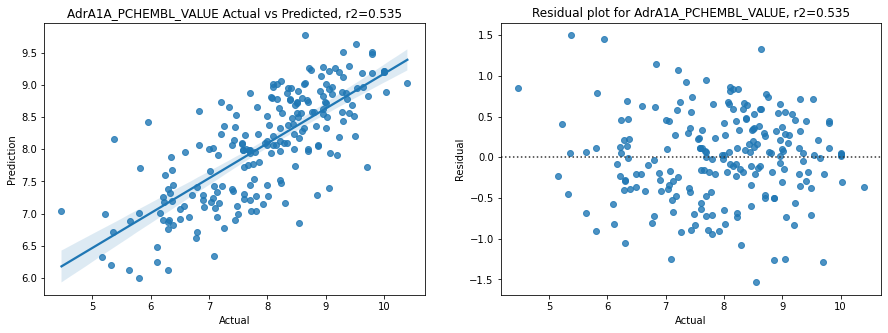

In [11]:
static_avp_avr_graphs(y_pred, y_test[ASSAY], np.mean(errors), ASSAY)

### Interactive plots

In [ ]:
avp_plot(y_test[ASSAY], y_pred, y_test.index.values, y_test["Structure"], np.mean(errors))

In [ ]:
avr = avr_plot(y_test[ASSAY], y_pred, y_test.index.values, y_test["Structure"], np.mean(errors))